In [13]:
import os
import json
import math
import random
import itertools
import numpy as np
import networkx as nx
import tqdm as tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.layout import *



In [14]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14

Find the ER for the MPC, MPG, and SP protocols

In [15]:
def load_data(filepath):
    pos = {}
    user = []

    # Step 1: 读取 JSON 文件
    with open(filepath, "r") as f:
        data = json.load(f)

    # Step 2: 初始化图
    G = nx.Graph()

    # Step 3: 添加节点

    for node in data["nodes"]:
        node_id = node["id"]
        x, y = node["latitude"], node["longitude"]
        G.add_node(node_id, location=node["location"], country=node["country"])  # 添加节点到图
        pos[node_id] = (y, x)  # 保存节点位置，注意 (longitude, latitude)

    # Step 4: 添加边
    for edge in data["links"]:
        source = int(edge["source"])
        target = int(edge["target"])
        G.add_edge(source, target, length=edge["length"])  # 添加边到图

    degree_dict = dict(G.degree())
    degree_items = list(degree_dict.items())
    first_node,first_degree = degree_items[0]
    print(f"First node ID: {first_node}, Degree: {first_degree}")

    user.append(data["nodes"][0]["id"])
    # for item in itertools.islice(reversed(list(data["nodes"])), first_degree):
    #     user.append(item['id'])
    # print(user)
    return G,user,pos

In [16]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def multi_iterative_score_partition_with_drawing(
    G, 
    fixed_node, 
    alpha=1.0, 
    beta=1.0,
    max_rounds=10,
    shuffle_nodes=True,
    pos=None,
    output_path=None
):
    """
    多轮迭代版“打分 + 搬家”分社区并绘制图：
      - 社区数 = degree(fixed_node) + 1
      - 初始:0号社区放 fixed_node,其余每个邻居一个社区
      - 分配时:score = alpha * distance + beta * community_size
      - 多轮:如果搬家能让节点的score降低,就搬家,直到稳定或max_rounds
      - 可选：绘制最终的社区图。

    参数:
        G (nx.Graph): 输入图
        fixed_node (int): 固定节点
        alpha (float): 距离权重
        beta (float): 社区规模权重
        max_rounds (int): 最大迭代轮数
        shuffle_nodes (bool): 每轮是否随机打乱节点遍历顺序
        pos (dict): 每个节点的坐标位置，格式 {node: (x, y)}
        output_path (str, 可选): 保存图片的路径。如果为 None,则只显示图像不保存。

    返回:
        communities (List[Set]): 列表长度 = degree(fixed_node) + 1,
                                 第0个 = {fixed_node},
                                 第 i+1 个 = 第 i 个邻居的社区。
        key_nodes (List[int]): 包含 fixed_node 以及各社区最远节点的列表。
    """

    # 1) 根据固定节点度数 => 准备社区容器
    neighbors = list(G.neighbors(fixed_node))
    print(f"the neighbors are {neighbors}")
    num_communities = len(neighbors)
    communities = [set() for _ in range(num_communities + 1)]
    visited = set()

    # 第0个社区放 fixed_node
    communities[0].add(fixed_node)
    visited.add(fixed_node)

    # 其余邻居各一个社区
    for i, nb in enumerate(neighbors, start=1):
        communities[i].add(nb)
        visited.add(nb)

    # 2) 初始化: 单轮分配 - 把剩余节点分配到“初次”score最小的社区
    for node in G.nodes():
        if node not in visited:
            best_score = float('inf')
            best_index = None
            for i, nb in enumerate(neighbors, start=1):
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size
                if score < best_score:
                    best_score = score
                    best_index = i
            communities[best_index].add(node)
            visited.add(node)

    # 3) 多轮迭代搬家
    round_num = 0
    while round_num < max_rounds:
        round_num += 1
        moved_count = 0

        # 获取所有节点（除 fixed_node 外），看要不要搬家
        all_nodes = [n for n in G.nodes() if n != fixed_node]

        # 是否随机打乱节点遍历顺序？
        if shuffle_nodes:
            random.shuffle(all_nodes)

        for node in all_nodes:
            # 当前所在社区 idx
            current_idx = None
            for i, comm in enumerate(communities):
                if node in comm:
                    current_idx = i
                    break

            # 算一下“当前score”
            if current_idx == 0:
                continue  # 固定节点不搬家

            nb_current = neighbors[current_idx - 1] if current_idx > 0 else fixed_node
            dist_current = nx.shortest_path_length(G, source=node, target=nb_current)
            size_current = len(communities[current_idx])
            current_score = alpha * dist_current + beta * size_current

            # 尝试搬去别的社区，看score是否更低
            best_score = current_score
            best_index = current_idx

            for i, nb in enumerate(neighbors, start=1):
                if i == current_idx:
                    continue  # 跳过自己
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size

                if score < best_score:
                    best_score = score
                    best_index = i

            # 如果找到更好的社区 => 搬家
            if best_index != current_idx:
                communities[current_idx].remove(node)
                communities[best_index].add(node)
                moved_count += 1

        #print(f"Round {round_num}: moved {moved_count} nodes")

        # 如果没有节点搬家 => 收敛 => 停止
        if moved_count == 0:
            break

    # 打印最终结果
    # print("\nFinal communities after iterative refinement:")
    # for i, comm in enumerate(communities):
    #     print(f"Community {i} (size={len(comm)}): {sorted(comm)}")

    # 找出每个社区中距离 fixed_node 最远的节点
    farthest_nodes = []
    for i, community in enumerate(communities):
        if i == 0:  # 跳过第0个社区，它只包含 fixed_node 本身
            continue
        if not community:  # 跳过空社区
            continue    
        farthest_node = max(community, key=lambda x: nx.shortest_path_length(G, fixed_node, x))
        farthest_nodes.append(farthest_node)

    #print(f"Farthest nodes in each community: {farthest_nodes}")

    # 将 fixed_node 与各社区最远节点合并成一个列表
    key_nodes = [fixed_node] + farthest_nodes
    #print(f"Key nodes (fixed + farthest): {key_nodes}")

    # 绘制社区图
    if pos is None:
        pos = nx.spring_layout(G, seed=42)  # 默认布局

    # 颜色列表，用于区分社区
    colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "pink"]
    
    plt.figure(figsize=(8, 6))
    
    # 绘制每个社区
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(
            G, pos, nodelist=community,
            node_color=colors[i % len(colors)], 
            label=f"Community {i}",
            alpha=0.8,
            node_size=100
        )

    # 特别标注固定节点（用圆形）
    nx.draw_networkx_nodes(
        G, pos, nodelist=[fixed_node],
        node_color="red", node_shape="o",
        node_size=100, alpha=0.9, label="Fixed Node"
    )
    # 特别标注最远节点（用三角形）
    nx.draw_networkx_nodes(
        G, pos, nodelist=farthest_nodes,
        node_color="gold", node_shape="^",
        node_size=100, alpha=0.9, label="Farthest Nodes"
    )

    # 绘制边
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)

    # 绘制节点标签
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    # 添加图例
    plt.legend(
        fontsize=6,  # 图例字体大小
        borderaxespad=0.5,  # 图例与轴边界的距离
        labelspacing=0.2,   # 图例条目之间的间距
        loc="upper left",  # 图例位置
        bbox_to_anchor=(1.05, 1),  # 将图例放到图外
    )
    plt.title("Graph with Colored Communities and Key Nodes")
    
    # 调整图形边距
    plt.tight_layout(pad=2.0)

    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {output_path}")
    else:
        plt.show()

    # 关闭图形以释放内存
    plt.close()

    # 返回社区列表，以及 [fixed_node + 所有最远节点]
    return communities, key_nodes


In [17]:

def plot_er_vs_p(p_range, ER, funcs, cols, output_path, fontsize=12, figsize=(10, 6), dpi=600):
    """
    绘制 ER 与链接生成概率 p 的关系图，并保存为文件。

    参数:
        p_range (array-like): p 的取值范围。
        ER (list of lists): 每个函数对应的 ER 数据。
        funcs (list): 包含函数的列表，用于生成图例名称。
        cols (list): 每个函数对应的颜色列表。
        output_path (str): 保存图片的路径。
        fontsize (int, 可选): 坐标轴和标签字体大小，默认 12。
        figsize (tuple, 可选): 图形大小，默认 (10, 6)。
        dpi (int, 可选): 图像分辨率，默认 600。
    """
    nom_list = [str(f).split(' ')[1] for f in funcs]
    plt.figure(figsize =(10,6),dpi=600 )
    plt.grid(linewidth=0.5)
    for i in range(len(funcs)):
        y = plt.plot(p_range, ER[i],
                    color = cols[i],
                    marker = "x",
                    linestyle='None',
                    markersize = 3,
                    #  alpha = 0.5,
                    #  linewidth=linewidth,
                    label = nom_list[i])
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.tick_params(labelsize=fontsize)

    plt.xlabel('Link generation probability p',fontsize=fontsize)
    plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

    ax = plt.gca()
    ax.set_xlim([0.2, 1])
    ax.set_ylim([0.0001, 1])

    # 保存图片
    plt.savefig(output_path, dpi=dpi)
    print(f"Plot saved to {output_path}")

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Aaron\AppData\Local\Temp\ipykernel_19184\2629642242.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)


First node ID: 39, Degree: 6
the neighbors are [25, 27, 38, 50, 100, 56]
Graph saved to f:\Third-year\Third-year project\quantum_repeaters_testing\communitie\class_0\TOP_104_USA100.png


  0%|          | 0/50 [00:00<?, ?it/s]f:\Third-year\Third-year project\quantum_repeaters_testing\simplequantnetsim\protocols.py:125: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.
  K = steiner_tree(
100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


[[1.         1.         1.         1.         1.         0.95238095
  0.95238095 0.86956522 0.90909091 0.86956522 0.76923077 0.83333333
  0.64516129 0.68965517 0.57142857 0.54054054 0.46511628 0.41666667
  0.25714286 0.3015873  0.16363636 0.10447761 0.15686275 0.04733728
  0.02150538 0.02209945 0.01030928 0.0104712  0.01041667 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.83333333 0.83333333 0.95238095 0.58823529 0.44444444
  0.38461538 0.2345679  0.21052632 0.19565217 0.1322314  0.10447761
  0.06       0.04142012 0.02777778 0.01041667 0.         0.00505051
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

100%|██████████| 50/50 [00:02<00:00, 19.82it/s]


[[1.         1.         1.         0.95238095 0.90909091 0.86956522
  0.86956522 0.86956522 0.71428571 0.90909091 0.71428571 0.8
  0.60606061 0.55555556 0.57142857 0.44444444 0.48780488 0.2739726
  0.29850746 0.25641026 0.26666667 0.18947368 0.17142857 0.11666667
  0.08730159 0.05769231 0.09848485 0.02824859 0.03278689 0.02659574
  0.02325581 0.02234637 0.00507614 0.00502513 0.         0.01578947
  0.0052356  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.90909091 0.76923077 0.625      0.60606061 0.5
  0.39215686 0.37735849 0.35714286 0.32786885 0.2375     0.2
  0.15151515 0.09923664 0.1588785  0.15384615 0.06962025 0.04487179
  0.04968944 0.0375     0.0443038  0.03448276 0.005      0.00502513
  0.0052356  0.00505051 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.  

100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


[[1.         1.         0.95238095 0.95238095 0.90909091 0.90909091
  0.90909091 0.95238095 0.86956522 0.74074074 0.68965517 0.5
  0.44444444 0.33898305 0.35185185 0.31666667 0.2195122  0.15533981
  0.12295082 0.10743802 0.0890411  0.02906977 0.06666667 0.02352941
  0.01621622 0.         0.00502513 0.00512821 0.         0.
  0.00507614 0.         0.005      0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.95238095 1.         0.86956522 0.95238095 0.68965517
  0.90909091 0.76923077 0.52631579 0.42553191 0.44444444 0.34545455
  0.35714286 0.19565217 0.1559633  0.25       0.14035088 0.11811024
  0.09302326 0.06578947 0.02380952 0.01612903 0.01020408 0.01578947
  0.         0.0052356  0.00510204 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.   

100%|██████████| 50/50 [00:01<00:00, 36.81it/s]


[[1.         1.         1.         1.         1.         1.
  0.90909091 0.86956522 0.8        0.71428571 0.86956522 0.68965517
  0.76923077 0.58823529 0.57142857 0.51282051 0.60606061 0.42553191
  0.54054054 0.32786885 0.42553191 0.39215686 0.29230769 0.2739726
  0.20454545 0.17894737 0.19587629 0.15686275 0.15       0.11382114
  0.125      0.07843137 0.12037037 0.0647482  0.07096774 0.04166667
  0.04294479 0.01595745 0.00502513 0.00515464 0.00507614 0.01657459
  0.         0.00520833 0.         0.00515464 0.         0.
  0.         0.        ]
 [1.         0.95238095 0.66666667 0.83333333 0.71428571 0.625
  0.52631579 0.48717949 0.66666667 0.37735849 0.51282051 0.37735849
  0.35087719 0.35087719 0.28169014 0.25352113 0.15686275 0.17475728
  0.12389381 0.14414414 0.10344828 0.06849315 0.07432432 0.06666667
  0.06040268 0.04166667 0.04046243 0.04       0.02994012 0.02890173
  0.02234637 0.         0.00518135 0.01052632 0.         0.
  0.00507614 0.         0.00507614 0.         0.01075

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


[[1.         0.95238095 1.         1.         0.86956522 0.90909091
  0.76923077 0.83333333 0.8        0.74074074 0.58823529 0.54054054
  0.37735849 0.27536232 0.38461538 0.27941176 0.1875     0.13333333
  0.12       0.06       0.05298013 0.05732484 0.03658537 0.01639344
  0.00510204 0.         0.005      0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.90909091 0.76923077 0.76923077 0.5        0.48780488
  0.29850746 0.55555556 0.2375     0.16071429 0.1015625  0.09489051
  0.07284768 0.08227848 0.         0.04320988 0.00507614 0.01015228
  0.01604278 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


[[1.         1.         1.         0.95238095 0.95238095 0.95238095
  0.90909091 0.76923077 0.8        0.74074074 0.68965517 0.51282051
  0.48780488 0.44444444 0.29230769 0.21348315 0.2183908  0.16666667
  0.04516129 0.08571429 0.14285714 0.05128205 0.04487179 0.015625
  0.01595745 0.01666667 0.0052356  0.00510204 0.         0.00510204
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.90909091 0.86956522 0.74074074 0.8        0.71428571
  0.64516129 0.76923077 0.51282051 0.51282051 0.44444444 0.31147541
  0.24096386 0.18811881 0.21111111 0.14414414 0.0794702  0.07518797
  0.07096774 0.05325444 0.01086957 0.02923977 0.01092896 0.01036269
  0.00505051 0.005      0.         0.00502513 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0. 

100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


[[1.         1.         1.         0.95238095 1.         1.
  0.95238095 0.90909091 0.95238095 0.95238095 0.83333333 0.86956522
  0.83333333 0.83333333 0.71428571 0.8        0.55555556 0.66666667
  0.5        0.60606061 0.40816327 0.43478261 0.42553191 0.46511628
  0.22988506 0.2        0.21176471 0.1322314  0.14285714 0.05732484
  0.04938272 0.02890173 0.05063291 0.03389831 0.02890173 0.00505051
  0.00515464 0.01630435 0.0052356  0.0104712  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.95238095 0.86956522 0.76923077 0.74074074 0.58823529
  0.68965517 0.74074074 0.47619048 0.35849057 0.44444444 0.23684211
  0.26666667 0.20930233 0.18604651 0.1        0.07236842 0.09219858
  0.08888889 0.06040268 0.01058201 0.01020408 0.01005025 0.02631579
  0.01612903 0.01041667 0.         0.         0.         0.00512821
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.       

100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


[[1.         1.         1.         0.95238095 0.83333333 0.74074074
  0.74074074 0.66666667 0.58823529 0.5        0.3220339  0.35714286
  0.27941176 0.28169014 0.23376623 0.1512605  0.1300813  0.14814815
  0.1015625  0.06338028 0.05421687 0.04375    0.04242424 0.03409091
  0.00512821 0.01604278 0.         0.01030928 0.00520833 0.
  0.00507614 0.         0.         0.         0.00505051 0.
  0.         0.005      0.         0.         0.         0.0052356
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         1.         0.90909091 0.68965517 0.64516129 0.52631579
  0.44444444 0.45454545 0.47619048 0.34545455 0.22222222 0.225
  0.15841584 0.14285714 0.1015625  0.104      0.07534247 0.03067485
  0.04458599 0.01639344 0.02197802 0.0104712  0.0304878  0.00518135
  0.00507614 0.         0.00507614 0.00510204 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00518135 0.         0.         0.         0.
  0.     

100%|██████████| 50/50 [00:02<00:00, 17.97it/s]


[[1.         1.         1.         0.95238095 0.86956522 0.8
  0.66666667 0.60606061 0.52631579 0.4        0.4        0.3030303
  0.4        0.20454545 0.2278481  0.17307692 0.06081081 0.07432432
  0.06       0.05960265 0.04022989 0.01036269 0.01675978 0.01621622
  0.01578947 0.00512821 0.0106383  0.         0.         0.01639344
  0.         0.00507614 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.83333333 0.8        0.76923077 0.71428571 0.58823529
  0.40816327 0.45454545 0.26388889 0.21428571 0.2183908  0.15151515
  0.12612613 0.11278195 0.07857143 0.06369427 0.04320988 0.03977273
  0.0273224  0.0052356  0.01092896 0.0106383  0.00520833 0.
  0.         0.         0.00502513 0.         0.         0.
  0.00502513 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

100%|██████████| 50/50 [00:02<00:00, 23.19it/s]


[[1.         1.         0.95238095 1.         1.         0.95238095
  0.95238095 0.95238095 0.95238095 1.         0.95238095 0.90909091
  0.76923077 0.8        0.66666667 0.71428571 0.47619048 0.8
  0.5        0.60606061 0.52631579 0.5        0.33898305 0.28358209
  0.3015873  0.51282051 0.19354839 0.16071429 0.23076923 0.16666667
  0.11926606 0.13157895 0.12820513 0.06802721 0.03333333 0.02793296
  0.04268293 0.02259887 0.01639344 0.0052356  0.005      0.
  0.00515464 0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.90909091 0.66666667 0.66666667 0.57142857 0.45454545
  0.47619048 0.27536232 0.32786885 0.20454545 0.18556701 0.14035088
  0.12195122 0.07246377 0.12195122 0.0621118  0.02793296 0.05882353
  0.01621622 0.03773585 0.01630435 0.02352941 0.01612903 0.
  0.015625   0.         0.         0.00520833 0.         0.
  0.         0.         0.00507614 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.      

100%|██████████| 50/50 [00:02<00:00, 17.82it/s]


[[1.         1.         1.         1.         1.         1.
  0.95238095 0.90909091 0.86956522 0.90909091 0.83333333 0.74074074
  0.8        0.625      0.55555556 0.625      0.48780488 0.55555556
  0.52631579 0.36363636 0.33898305 0.26666667 0.26086957 0.1978022
  0.08391608 0.05298013 0.112      0.08888889 0.05333333 0.07246377
  0.02185792 0.03529412 0.01546392 0.00515464 0.00512821 0.00505051
  0.01595745 0.         0.         0.0052356  0.00505051 0.00502513
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.86956522 0.74074074 0.76923077 0.66666667 0.45454545
  0.48780488 0.33333333 0.38461538 0.22891566 0.2739726  0.19767442
  0.17647059 0.13913043 0.12698413 0.09302326 0.0942029  0.0625
  0.04320988 0.03550296 0.03428571 0.01020408 0.00518135 0.
  0.01052632 0.         0.         0.         0.01075269 0.
  0.00512821 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.    

100%|██████████| 50/50 [00:01<00:00, 41.36it/s]


[[1.         0.95238095 0.95238095 0.86956522 0.83333333 0.625
  0.76923077 0.76923077 0.52631579 0.48780488 0.625      0.55555556
  0.57142857 0.33898305 0.46511628 0.36363636 0.26388889 0.18478261
  0.17647059 0.17977528 0.12605042 0.09375    0.125      0.06097561
  0.0625     0.04651163 0.0625     0.04166667 0.02339181 0.01578947
  0.01041667 0.01694915 0.02298851 0.01052632 0.01630435 0.
  0.00505051 0.00505051 0.01005025 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.83333333 0.71428571 0.76923077 0.58823529 0.45454545
  0.60606061 0.45454545 0.44444444 0.37037037 0.31666667 0.2375
  0.2278481  0.18085106 0.13559322 0.16037736 0.16831683 0.13559322
  0.0794702  0.08219178 0.07913669 0.05625    0.06369427 0.0295858
  0.01015228 0.02688172 0.01724138 0.00515464 0.00510204 0.01639344
  0.01015228 0.01587302 0.         0.01025641 0.01086957 0.
  0.0052356  0.         0.00510204 0.         0.00515464 0.
  0. 

100%|██████████| 50/50 [00:02<00:00, 19.88it/s]


[[1.         0.95238095 0.8        0.8        0.52631579 0.60606061
  0.42553191 0.32786885 0.20454545 0.21111111 0.2        0.14285714
  0.16       0.10526316 0.07586207 0.11811024 0.04678363 0.02162162
  0.02247191 0.03550296 0.02890173 0.02094241 0.0104712  0.005
  0.00512821 0.         0.         0.01010101 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.86956522 0.64516129 0.46511628 0.39215686 0.25316456
  0.18478261 0.15686275 0.08391608 0.104      0.12173913 0.03636364
  0.02702703 0.02747253 0.04046243 0.02162162 0.01036269 0.00520833
  0.00518135 0.01005025 0.00505051 0.         0.         0.
  0.         0.00505051 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         

100%|██████████| 50/50 [00:08<00:00,  6.25it/s]


[[1.         1.         0.90909091 0.86956522 0.74074074 0.5
  0.48780488 0.57142857 0.37735849 0.39215686 0.2        0.3030303
  0.15686275 0.17525773 0.17171717 0.0738255  0.04705882 0.07284768
  0.01630435 0.04968944 0.00507614 0.005      0.0106383  0.00507614
  0.         0.00507614 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.   

100%|██████████| 50/50 [00:00<00:00, 68.43it/s]


[[1.         1.         1.         1.         0.95238095 1.
  0.90909091 0.83333333 0.74074074 0.76923077 0.74074074 0.58823529
  0.68965517 0.76923077 0.58823529 0.54054054 0.43478261 0.5
  0.35714286 0.40816327 0.37037037 0.43478261 0.3220339  0.37037037
  0.34545455 0.23170732 0.17821782 0.11290323 0.11965812 0.16346154
  0.14953271 0.14782609 0.07633588 0.06622517 0.08270677 0.09923664
  0.05487805 0.06       0.05732484 0.03680982 0.04142012 0.02222222
  0.01530612 0.00520833 0.01587302 0.005      0.01036269 0.00502513
  0.         0.01081081]
 [1.         0.83333333 0.8        0.83333333 0.86956522 0.76923077
  0.8        0.58823529 0.57142857 0.46511628 0.60606061 0.37037037
  0.38461538 0.34482759 0.36363636 0.25373134 0.28787879 0.16346154
  0.5        0.29850746 0.25333333 0.17525773 0.21686747 0.11570248
  0.14563107 0.12280702 0.14018692 0.14035088 0.05960265 0.05806452
  0.07236842 0.05194805 0.03314917 0.04705882 0.01621622 0.06
  0.03703704 0.03658537 0.02234637 0.0270270

100%|██████████| 50/50 [00:02<00:00, 19.68it/s]


[[1.         1.         0.86956522 0.90909091 0.86956522 0.66666667
  0.74074074 0.54054054 0.54054054 0.36363636 0.34482759 0.29411765
  0.2345679  0.27027027 0.19318182 0.13675214 0.1509434  0.12295082
  0.14545455 0.09558824 0.04733728 0.07051282 0.05       0.0297619
  0.01639344 0.02139037 0.02312139 0.01025641 0.00520833 0.00520833
  0.01086957 0.         0.         0.         0.00512821 0.00502513
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.83333333 0.8        0.44444444 0.31666667 0.28358209
  0.13333333 0.16666667 0.13392857 0.13274336 0.03508772 0.07236842
  0.03508772 0.02173913 0.02247191 0.00518135 0.01657459 0.01036269
  0.01086957 0.01086957 0.00507614 0.         0.         0.
  0.         0.         0.00505051 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.

100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


[[1.         1.         1.         0.90909091 0.76923077 0.90909091
  0.86956522 0.74074074 0.60606061 0.64516129 0.66666667 0.68965517
  0.66666667 0.54054054 0.43478261 0.37735849 0.3015873  0.3030303
  0.18556701 0.24390244 0.13913043 0.14814815 0.10687023 0.08029197
  0.10769231 0.06896552 0.1015625  0.06329114 0.02873563 0.02298851
  0.02840909 0.02994012 0.02890173 0.01069519 0.00512821 0.01069519
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.86956522 0.90909091 0.90909091 0.74074074 0.8
  0.5        0.57142857 0.58823529 0.45454545 0.3220339  0.25675676
  0.29850746 0.34545455 0.24050633 0.16       0.11811024 0.09448819
  0.18681319 0.05660377 0.08571429 0.07246377 0.03636364 0.02209945
  0.02272727 0.00520833 0.01058201 0.005      0.00518135 0.01081081
  0.00502513 0.00520833 0.         0.0052356  0.00505051 0.
  0.         0.         0.00512821 0.         0.       

100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


[[1.         0.86956522 0.64516129 0.8        0.76923077 0.52631579
  0.42553191 0.41666667 0.43478261 0.40816327 0.41666667 0.25333333
  0.19565217 0.24675325 0.21428571 0.09489051 0.09929078 0.07746479
  0.04242424 0.02234637 0.04878049 0.02259887 0.02873563 0.01041667
  0.         0.00502513 0.01020408 0.00512821 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.71428571 0.55555556 0.29850746 0.296875   0.15841584
  0.1031746  0.07692308 0.04166667 0.03932584 0.02222222 0.04938272
  0.01020408 0.01020408 0.00515464 0.         0.         0.00510204
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


[[1.         1.         1.         1.         1.         0.95238095
  0.90909091 1.         0.86956522 1.         1.         0.86956522
  0.8        0.90909091 0.68965517 0.625      0.66666667 0.57142857
  0.41666667 0.39215686 0.43478261 0.37735849 0.28358209 0.30769231
  0.26027397 0.2739726  0.15686275 0.14953271 0.15533981 0.06081081
  0.09302326 0.05660377 0.02808989 0.03296703 0.01020408 0.00507614
  0.00518135 0.00510204 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         1.         0.90909091 0.95238095 0.86956522 0.86956522
  0.71428571 0.68965517 0.74074074 0.625      0.52631579 0.57142857
  0.41666667 0.58823529 0.47619048 0.44444444 0.42553191 0.35714286
  0.29850746 0.25333333 0.27941176 0.12844037 0.11290323 0.13636364
  0.10687023 0.09219858 0.05294118 0.06622517 0.03488372 0.05128205
  0.01041667 0.04571429 0.01030928 0.01075269 0.0106383  0.
  0.         0.         0.00502513 0.         0

C:\Users\Aaron\AppData\Local\Temp\ipykernel_19184\3804625699.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Graph saved to f:\Third-year\Third-year project\quantum_repeaters_testing\communitie\class_0\TOP_59_KAREN.png


100%|██████████| 50/50 [00:01<00:00, 26.56it/s]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_19184\2629642242.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize =(10,6),dpi=600 )


[[1.         1.         0.95238095 0.86956522 0.68965517 0.8
  0.76923077 0.68965517 0.66666667 0.58823529 0.52631579 0.42553191
  0.42553191 0.47619048 0.36363636 0.46511628 0.23684211 0.25
  0.18478261 0.19318182 0.19565217 0.18556701 0.17171717 0.11111111
  0.0915493  0.15384615 0.07594937 0.06122449 0.02857143 0.0621118
  0.04069767 0.03529412 0.0621118  0.01621622 0.02298851 0.00507614
  0.02688172 0.01075269 0.         0.01075269 0.00502513 0.00510204
  0.         0.00515464 0.00510204 0.         0.         0.
  0.00512821 0.        ]
 [1.         1.         0.90909091 0.95238095 0.95238095 0.64516129
  0.68965517 0.48780488 0.68965517 0.52631579 0.71428571 0.68965517
  0.41304348 0.47619048 0.39215686 0.29411765 0.32786885 0.2278481
  0.26027397 0.17525773 0.18681319 0.2        0.16504854 0.11450382
  0.125      0.07746479 0.08730159 0.04268293 0.04166667 0.04790419
  0.02139037 0.04848485 0.04117647 0.0106383  0.04458599 0.01621622
  0.01639344 0.02247191 0.00520833 0.01041667 

100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


[[1.         0.95238095 0.95238095 0.90909091 0.95238095 0.71428571
  0.83333333 0.76923077 0.5        0.74074074 0.51282051 0.55555556
  0.48780488 0.57142857 0.51282051 0.36363636 0.37254902 0.30769231
  0.25974026 0.19318182 0.12711864 0.11904762 0.10687023 0.1015625
  0.06666667 0.04624277 0.02285714 0.03428571 0.01694915 0.02247191
  0.02857143 0.00505051 0.         0.0052356  0.00505051 0.
  0.         0.00502513 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.86956522 0.51282051 0.55555556 0.71428571 0.37735849
  0.28787879 0.26470588 0.24050633 0.19565217 0.13043478 0.08029197
  0.08088235 0.12711864 0.07482993 0.03888889 0.04142012 0.0375
  0.01554404 0.03529412 0.02247191 0.01538462 0.00502513 0.
  0.         0.0106383  0.00512821 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0. 

100%|██████████| 50/50 [00:00<00:00, 64.26it/s]


[[1.         1.         1.         1.         0.95238095 0.95238095
  0.95238095 0.95238095 0.83333333 0.76923077 0.8        0.71428571
  0.71428571 0.68965517 0.74074074 0.71428571 0.74074074 0.57142857
  0.64516129 0.46511628 0.55555556 0.5        0.43478261 0.39583333
  0.29850746 0.30645161 0.29411765 0.35087719 0.40425532 0.2345679
  0.1827957  0.22891566 0.16363636 0.15740741 0.20689655 0.10169492
  0.1        0.13559322 0.08955224 0.05369128 0.04069767 0.04117647
  0.07407407 0.02824859 0.02747253 0.02234637 0.01595745 0.01058201
  0.00512821 0.01675978]
 [1.         0.86956522 0.95238095 0.76923077 0.66666667 0.68965517
  0.60606061 0.5        0.47619048 0.47619048 0.28985507 0.39215686
  0.31746032 0.31746032 0.27777778 0.24675325 0.25974026 0.17647059
  0.14150943 0.15686275 0.11666667 0.12       0.12612613 0.12711864
  0.05421687 0.04733728 0.05263158 0.04848485 0.03550296 0.02873563
  0.03370787 0.02247191 0.01685393 0.01025641 0.01025641 0.01538462
  0.01020408 0.         

100%|██████████| 50/50 [00:01<00:00, 34.06it/s]


[[1.         0.95238095 1.         1.         1.         1.
  0.90909091 0.8        1.         0.95238095 0.90909091 0.71428571
  0.76923077 0.86956522 0.71428571 0.60606061 0.71428571 0.60606061
  0.45454545 0.52631579 0.5        0.45454545 0.37254902 0.29850746
  0.36363636 0.44444444 0.23170732 0.21052632 0.13392857 0.21686747
  0.15686275 0.15533981 0.09448819 0.19607843 0.1        0.05095541
  0.08571429 0.05405405 0.04347826 0.03278689 0.01666667 0.02173913
  0.02298851 0.0052356  0.01052632 0.02139037 0.         0.00507614
  0.         0.        ]
 [1.         0.83333333 0.90909091 0.83333333 0.68965517 0.46511628
  0.625      0.5        0.57142857 0.58823529 0.37735849 0.37037037
  0.28169014 0.29032258 0.14150943 0.31746032 0.24358974 0.1875
  0.14678899 0.16666667 0.20454545 0.05696203 0.06802721 0.08163265
  0.08823529 0.05696203 0.06       0.04242424 0.03592814 0.03488372
  0.03592814 0.01648352 0.01052632 0.01058201 0.01020408 0.
  0.01092896 0.01005025 0.005      0.005208

100%|██████████| 50/50 [00:01<00:00, 43.66it/s]


[[1.         1.         1.         1.         1.         1.
  0.95238095 1.         0.90909091 0.86956522 0.90909091 1.
  0.8        0.83333333 0.74074074 0.83333333 0.74074074 0.83333333
  0.64516129 0.55555556 0.5        0.66666667 0.625      0.54054054
  0.37037037 0.57142857 0.42222222 0.41666667 0.35087719 0.25333333
  0.27941176 0.30645161 0.20212766 0.17525773 0.19354839 0.11864407
  0.14655172 0.08391608 0.1372549  0.08965517 0.0738255  0.05590062
  0.04268293 0.03636364 0.01020408 0.02312139 0.01020408 0.01036269
  0.01587302 0.00520833]
 [1.         0.95238095 0.83333333 0.83333333 0.64516129 0.625
  0.52631579 0.58823529 0.37037037 0.45454545 0.37735849 0.3030303
  0.34482759 0.4        0.25675676 0.27941176 0.25974026 0.11504425
  0.17821782 0.1509434  0.10526316 0.12149533 0.07894737 0.04347826
  0.04790419 0.06748466 0.04487179 0.04117647 0.03409091 0.03389831
  0.01685393 0.02139037 0.0104712  0.02857143 0.01075269 0.
  0.0052356  0.00512821 0.01530612 0.00518135 0.     

100%|██████████| 50/50 [00:03<00:00, 16.12it/s]


[[1.         1.         0.95238095 0.90909091 0.68965517 0.86956522
  0.68965517 0.54054054 0.35087719 0.38461538 0.34482759 0.27777778
  0.27941176 0.15384615 0.1322314  0.14851485 0.0962963  0.05194805
  0.04294479 0.03468208 0.05298013 0.00507614 0.02824859 0.01069519
  0.01648352 0.         0.01612903 0.01621622 0.         0.
  0.         0.00507614 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         1.         1.         0.90909091 0.83333333 0.74074074
  0.55555556 0.51282051 0.47619048 0.29411765 0.33333333 0.29411765
  0.19354839 0.1559633  0.07971014 0.09848485 0.09848485 0.07831325
  0.0952381  0.03977273 0.02824859 0.02762431 0.02762431 0.00507614
  0.01612903 0.         0.01578947 0.005      0.00515464 0.
  0.00507614 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.       

100%|██████████| 50/50 [00:01<00:00, 31.52it/s]


[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         0.95238095 0.8
  0.95238095 1.         0.83333333 0.86956522 0.76923077 0.68965517
  0.8        0.57142857 0.83333333 0.71428571 0.52631579 0.51282051
  0.52631579 0.40816327 0.33333333 0.32786885 0.42222222 0.28571429
  0.25675676 0.18       0.1559633  0.14018692 0.14563107 0.13274336
  0.10687023 0.07692308 0.05228758 0.01639344 0.05194805 0.01587302
  0.02185792 0.01       0.00512821 0.01010101 0.         0.
  0.         0.        ]
 [1.         1.         0.90909091 0.90909091 0.8        0.64516129
  0.74074074 0.64516129 0.66666667 0.90909091 0.54054054 0.55555556
  0.51282051 0.54054054 0.46511628 0.44444444 0.42553191 0.39215686
  0.33898305 0.26760563 0.24050633 0.18556701 0.19767442 0.15238095
  0.10852713 0.125      0.1        0.05780347 0.1147541  0.04166667
  0.02873563 0.02873563 0.01630435 0.02890173 0.015625   0.01685393
  0.01010101 0.01086957 0.0106383  0.0104712  

100%|██████████| 50/50 [00:01<00:00, 45.29it/s]


[[1.         0.95238095 0.95238095 0.90909091 0.86956522 0.86956522
  0.86956522 0.86956522 0.71428571 0.90909091 0.83333333 0.68965517
  0.68965517 0.47619048 0.625      0.46511628 0.55555556 0.44444444
  0.48780488 0.37735849 0.35714286 0.3877551  0.26760563 0.23170732
  0.35087719 0.23170732 0.17142857 0.18478261 0.1559633  0.1954023
  0.16037736 0.125      0.1119403  0.05960265 0.04347826 0.04651163
  0.07246377 0.03571429 0.08208955 0.01020408 0.03428571 0.04142012
  0.02840909 0.00502513 0.02162162 0.01069519 0.005      0.00502513
  0.         0.01015228]
 [1.         1.         1.         0.95238095 0.83333333 0.95238095
  0.8        0.95238095 0.74074074 0.66666667 0.90909091 0.68965517
  0.76923077 0.60606061 0.625      0.5        0.60606061 0.52631579
  0.5        0.47619048 0.30769231 0.3220339  0.3877551  0.29508197
  0.23170732 0.17307692 0.21176471 0.225      0.19565217 0.17592593
  0.14018692 0.104      0.14678899 0.13793103 0.0890411  0.05960265
  0.07236842 0.02840909 

100%|██████████| 50/50 [00:03<00:00, 16.28it/s]


[[1.         1.         0.86956522 0.8        0.74074074 0.60606061
  0.55555556 0.47619048 0.40816327 0.36363636 0.22619048 0.26315789
  0.13157895 0.11570248 0.08974359 0.07352941 0.09375    0.04790419
  0.04347826 0.03296703 0.02702703 0.01025641 0.01704545 0.01058201
  0.00502513 0.         0.00510204 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.      

100%|██████████| 50/50 [00:02<00:00, 18.99it/s]


[[1.         0.90909091 0.90909091 0.83333333 0.90909091 0.76923077
  0.64516129 0.66666667 0.66666667 0.58823529 0.57142857 0.64516129
  0.40816327 0.39215686 0.35185185 0.28571429 0.28169014 0.34545455
  0.24675325 0.18181818 0.19047619 0.12096774 0.07692308 0.09489051
  0.04761905 0.04268293 0.06369427 0.03726708 0.03488372 0.02116402
  0.0212766  0.01020408 0.01666667 0.00510204 0.         0.
  0.00507614 0.005      0.00507614 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         

100%|██████████| 50/50 [00:02<00:00, 22.99it/s]


[[1.         1.         0.95238095 0.95238095 1.         0.95238095
  0.76923077 0.95238095 0.83333333 0.8        0.76923077 0.76923077
  0.58823529 0.42553191 0.51282051 0.45454545 0.3877551  0.32786885
  0.33333333 0.24324324 0.23170732 0.13333333 0.21590909 0.18085106
  0.1300813  0.12280702 0.10144928 0.09027778 0.02702703 0.08270677
  0.02702703 0.04216867 0.02793296 0.01041667 0.02247191 0.00507614
  0.         0.00518135 0.         0.00515464 0.01036269 0.
  0.01058201 0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         1.         0.86956522 0.95238095 0.8        0.64516129
  0.71428571 0.625      0.55555556 0.43478261 0.51282051 0.29850746
  0.37254902 0.29032258 0.27142857 0.17171717 0.19565217 0.1171875
  0.12307692 0.11811024 0.03614458 0.05555556 0.05       0.02673797
  0.02824859 0.01685393 0.01041667 0.01041667 0.0273224  0.00505051
  0.00520833 0.01041667 0.00518135 0.         0.00507614 0.0052356
  0.         0.         0.         0.    

100%|██████████| 50/50 [00:02<00:00, 19.65it/s]


[[1.         1.         0.95238095 0.90909091 0.90909091 0.76923077
  0.8        0.86956522 0.74074074 0.71428571 0.68965517 0.57142857
  0.52631579 0.625      0.47619048 0.35714286 0.27941176 0.30645161
  0.29850746 0.29411765 0.27027027 0.14953271 0.29411765 0.10687023
  0.1147541  0.17       0.04938272 0.09219858 0.04294479 0.02747253
  0.03488372 0.01578947 0.01657459 0.02150538 0.         0.
  0.         0.01030928 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.95238095 0.90909091 0.8        0.76923077 0.8
  0.57142857 0.64516129 0.60606061 0.55555556 0.40816327 0.36363636
  0.33333333 0.25974026 0.19318182 0.14953271 0.17       0.16831683
  0.14018692 0.07913669 0.05194805 0.04968944 0.1031746  0.0326087
  0.03314917 0.01612903 0.04294479 0.02298851 0.02116402 0.01041667
  0.01704545 0.00518135 0.         0.         0.00510204 0.
  0.         0.         0.         0.         0.         0.
  0

100%|██████████| 50/50 [00:02<00:00, 17.19it/s]


[[1.         0.90909091 1.         1.         0.90909091 0.90909091
  0.8        0.86956522 0.76923077 0.64516129 0.60606061 0.55555556
  0.60606061 0.60606061 0.42553191 0.48780488 0.52631579 0.30769231
  0.3220339  0.20930233 0.26470588 0.15315315 0.27536232 0.14285714
  0.13636364 0.1588785  0.08333333 0.05294118 0.05228758 0.05325444
  0.04046243 0.02702703 0.05806452 0.02173913 0.01554404 0.02083333
  0.00507614 0.01639344 0.00518135 0.         0.00510204 0.
  0.01030928 0.00515464 0.         0.         0.         0.
  0.         0.        ]
 [1.         0.90909091 0.74074074 0.66666667 0.58823529 0.54054054
  0.71428571 0.46511628 0.30645161 0.34545455 0.26760563 0.28358209
  0.17708333 0.19047619 0.18269231 0.14035088 0.09774436 0.09923664
  0.10655738 0.05298013 0.05625    0.06711409 0.04216867 0.04938272
  0.01612903 0.02173913 0.01081081 0.01630435 0.00502513 0.
  0.01081081 0.00512821 0.00510204 0.         0.         0.
  0.01069519 0.00512821 0.         0.         0.       

100%|██████████| 50/50 [00:03<00:00, 12.55it/s]


[[1.         1.         0.95238095 1.         0.95238095 0.66666667
  0.74074074 0.60606061 0.66666667 0.64516129 0.52631579 0.55555556
  0.36538462 0.52631579 0.36363636 0.32786885 0.31746032 0.26865672
  0.24675325 0.296875   0.16666667 0.15686275 0.04878049 0.1037037
  0.07746479 0.06535948 0.02139037 0.03351955 0.02873563 0.015625
  0.01530612 0.02173913 0.0104712  0.01092896 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         1.         0.90909091 0.83333333 0.76923077 0.83333333
  0.8        0.76923077 0.74074074 0.66666667 0.64516129 0.48780488
  0.46511628 0.35087719 0.35714286 0.27941176 0.3877551  0.32258065
  0.32258065 0.2345679  0.21686747 0.1559633  0.09923664 0.17708333
  0.10833333 0.04166667 0.1015625  0.04458599 0.0443038  0.02941176
  0.02673797 0.00510204 0.00515464 0.00510204 0.00520833 0.
  0.00518135 0.00512821 0.00520833 0.         0.         0

100%|██████████| 50/50 [00:01<00:00, 29.07it/s]


[[1.         0.86956522 0.64516129 0.57142857 0.33898305 0.29508197
  0.14285714 0.17821782 0.12820513 0.05660377 0.09774436 0.05298013
  0.08461538 0.0295858  0.02162162 0.01704545 0.00510204 0.02247191
  0.0052356  0.005      0.         0.         0.         0.00510204
  0.         0.00512821 0.         0.         0.         0.00505051
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.86956522 0.47619048 0.54054054 0.35185185 0.32786885
  0.24358974 0.1827957  0.2345679  0.14285714 0.0794702  0.07692308
  0.02808989 0.02139037 0.05555556 0.0326087  0.02366864 0.01058201
  0.015625   0.005      0.         0.         0.         0.
  0.         0.         0.         0.00502513 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.       

100%|██████████| 50/50 [00:00<00:00, 56.55it/s]


[[1.         1.         0.95238095 0.95238095 0.86956522 0.90909091
  0.90909091 0.83333333 0.71428571 0.8        0.76923077 0.625
  0.71428571 0.76923077 0.64516129 0.54054054 0.41666667 0.58823529
  0.34482759 0.36363636 0.37735849 0.44444444 0.3015873  0.28358209
  0.25333333 0.19101124 0.25641026 0.28571429 0.19148936 0.17708333
  0.12698413 0.10743802 0.12195122 0.1147541  0.10743802 0.07142857
  0.05       0.05988024 0.03448276 0.06849315 0.05660377 0.01685393
  0.01724138 0.02366864 0.0212766  0.03658537 0.         0.
  0.         0.00520833]
 [1.         0.83333333 0.74074074 0.74074074 0.71428571 0.57142857
  0.58823529 0.58823529 0.54054054 0.37037037 0.28571429 0.33898305
  0.24       0.27536232 0.25       0.23255814 0.12396694 0.21505376
  0.10687023 0.0729927  0.1023622  0.08130081 0.06896552 0.04635762
  0.03821656 0.02857143 0.00518135 0.04142012 0.03726708 0.015625
  0.01639344 0.01069519 0.0106383  0.02259887 0.         0.00520833
  0.00502513 0.         0.         0.0

100%|██████████| 50/50 [00:01<00:00, 25.23it/s]


[[1.         0.90909091 1.         0.90909091 0.74074074 0.66666667
  0.76923077 0.45454545 0.57142857 0.41666667 0.28125    0.31147541
  0.29230769 0.19587629 0.22891566 0.18085106 0.15384615 0.17
  0.08088235 0.04761905 0.04375    0.01630435 0.02906977 0.01630435
  0.02197802 0.01075269 0.03680982 0.01086957 0.         0.
  0.00510204 0.00505051 0.         0.         0.         0.
  0.005      0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.07971014 0.05806452 0.096      0.14035088 0.08571429
  0.1031746  0.10077519 0.13513514 0.09219858 0.1147541  0.09923664
  0.04402516 0.04678363 0.05       0.03428571 0.01630435 0.01036269
  0.01570681 0.01587302 0.01675978 0.03680982 0.01075269 0.00518135
  0.         0.00507614 0.         0.00512821 0.00518135 0.
  0.         0.         0.         0.00502513 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.  

100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


[[1.         1.         0.90909091 0.90909091 0.86956522 0.90909091
  0.64516129 0.74074074 0.60606061 0.5        0.44444444 0.42553191
  0.32758621 0.4        0.3125     0.23255814 0.2183908  0.2375
  0.16666667 0.12096774 0.06944444 0.11904762 0.09230769 0.08695652
  0.03550296 0.04605263 0.04268293 0.02824859 0.02857143 0.0106383
  0.01587302 0.015625   0.00507614 0.01036269 0.00515464 0.00505051
  0.01025641 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.95238095 0.68965517 0.71428571 0.66666667 0.74074074
  0.41666667 0.44444444 0.32258065 0.38461538 0.29411765 0.28571429
  0.26760563 0.20618557 0.16161616 0.10294118 0.12307692 0.15238095
  0.07092199 0.0625     0.03592814 0.05590062 0.03703704 0.01587302
  0.02298851 0.00518135 0.00510204 0.01041667 0.01020408 0.00510204
  0.         0.         0.00502513 0.00520833 0.00515464 0.
  0.         0.         0.         0.         0.    

100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


[[1.         1.         1.         0.95238095 0.95238095 0.86956522
  0.95238095 0.86956522 0.68965517 0.83333333 0.83333333 0.71428571
  0.76923077 0.55555556 0.51282051 0.57142857 0.66666667 0.43478261
  0.60606061 0.42553191 0.37037037 0.42553191 0.26027397 0.24358974
  0.32258065 0.27027027 0.20689655 0.10714286 0.15533981 0.13636364
  0.07643312 0.13675214 0.08029197 0.04678363 0.03370787 0.04191617
  0.0304878  0.0239521  0.02339181 0.         0.01570681 0.0104712
  0.01030928 0.         0.         0.         0.         0.
  0.00515464 0.        ]
 [1.         0.95238095 0.86956522 0.76923077 0.86956522 0.8
  0.76923077 0.8        0.58823529 0.45454545 0.52631579 0.60606061
  0.40816327 0.3877551  0.41666667 0.46511628 0.33333333 0.31746032
  0.2        0.21176471 0.20618557 0.15454545 0.13114754 0.11570248
  0.14545455 0.08333333 0.08088235 0.05298013 0.04268293 0.03278689
  0.03550296 0.01639344 0.02777778 0.02162162 0.02285714 0.01058201
  0.00515464 0.01621622 0.02105263 0.01

100%|██████████| 50/50 [00:01<00:00, 37.27it/s]


[[1.         1.         0.90909091 1.         0.95238095 0.76923077
  0.90909091 0.8        0.64516129 0.71428571 0.625      0.58823529
  0.66666667 0.68965517 0.45238095 0.44444444 0.48780488 0.36538462
  0.37037037 0.27272727 0.296875   0.42553191 0.24358974 0.28787879
  0.18947368 0.26027397 0.1588785  0.18478261 0.15151515 0.12068966
  0.08208955 0.11538462 0.06578947 0.0794702  0.05594406 0.04487179
  0.05882353 0.04242424 0.03614458 0.07857143 0.02793296 0.02747253
  0.02209945 0.02247191 0.0201005  0.01666667 0.00520833 0.0104712
  0.         0.        ]
 [1.         1.         0.86956522 0.86956522 0.71428571 0.74074074
  0.8        0.83333333 0.64516129 0.55555556 0.43478261 0.625
  0.66666667 0.52631579 0.48780488 0.48780488 0.54054054 0.40816327
  0.32258065 0.44444444 0.43478261 0.26388889 0.24691358 0.2
  0.23076923 0.23376623 0.19767442 0.15178571 0.15740741 0.20930233
  0.16326531 0.12931034 0.05806452 0.05673759 0.09022556 0.09677419
  0.07741935 0.04216867 0.03592814 0

100%|██████████| 50/50 [00:00<00:00, 64.61it/s]


[[1.         0.95238095 1.         0.83333333 0.76923077 0.68965517
  0.66666667 0.71428571 0.5        0.64516129 0.58823529 0.42553191
  0.48780488 0.31746032 0.54054054 0.32142857 0.25974026 0.22619048
  0.22619048 0.18947368 0.15740741 0.18181818 0.17431193 0.11111111
  0.11904762 0.11678832 0.09090909 0.06164384 0.06622517 0.13333333
  0.05590062 0.05882353 0.05660377 0.03488372 0.01612903 0.02272727
  0.02259887 0.03468208 0.01058201 0.0104712  0.02923977 0.01595745
  0.01595745 0.01570681 0.00518135 0.00515464 0.005      0.00520833
  0.         0.        ]
 [1.         0.95238095 0.76923077 0.8        0.8        0.8
  0.68965517 0.5        0.41666667 0.44444444 0.58823529 0.48780488
  0.60606061 0.37735849 0.34545455 0.28787879 0.32258065 0.21794872
  0.18367347 0.29411765 0.15533981 0.17171717 0.125      0.13274336
  0.0962963  0.12781955 0.13761468 0.09090909 0.10447761 0.09160305
  0.05517241 0.07142857 0.05487805 0.02673797 0.02890173 0.04624277
  0.02339181 0.04242424 0.0217

100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


[[1.         1.         1.         1.         1.         1.
  0.95238095 1.         0.90909091 0.95238095 0.83333333 0.83333333
  0.83333333 0.66666667 0.71428571 0.76923077 0.71428571 0.57142857
  0.8        0.58823529 0.625      0.55555556 0.45454545 0.35714286
  0.37735849 0.41666667 0.29850746 0.26315789 0.16964286 0.22093023
  0.21590909 0.15533981 0.14414414 0.10144928 0.08163265 0.06756757
  0.08148148 0.02906977 0.05325444 0.         0.01612903 0.02762431
  0.01052632 0.         0.00515464 0.01086957 0.00507614 0.
  0.         0.        ]
 [1.         0.95238095 1.         0.8        0.8        0.90909091
  0.55555556 0.5        0.66666667 0.625      0.5        0.54054054
  0.5        0.28358209 0.14814815 0.26388889 0.16346154 0.17708333
  0.18811881 0.14035088 0.07189542 0.06289308 0.0952381  0.06711409
  0.0308642  0.04046243 0.03125    0.04242424 0.01604278 0.00520833
  0.02339181 0.00502513 0.00502513 0.0104712  0.         0.
  0.00510204 0.         0.00502513 0.         0

100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


[[1.         0.90909091 0.90909091 0.86956522 0.8        0.8
  0.74074074 0.71428571 0.54054054 0.57142857 0.48780488 0.45454545
  0.48780488 0.35087719 0.42553191 0.46511628 0.28787879 0.26470588
  0.28571429 0.2278481  0.3015873  0.1827957  0.26666667 0.14912281
  0.12820513 0.18478261 0.1031746  0.1031746  0.10833333 0.07051282
  0.06711409 0.08695652 0.06535948 0.05590062 0.03333333 0.01036269
  0.02162162 0.02673797 0.01075269 0.01612903 0.02645503 0.01010101
  0.         0.0052356  0.         0.00512821 0.01041667 0.
  0.005      0.        ]
 [1.         0.95238095 0.86956522 0.95238095 0.76923077 0.68965517
  0.8        0.68965517 0.71428571 0.52631579 0.47619048 0.55555556
  0.51282051 0.40816327 0.51282051 0.37037037 0.41666667 0.29850746
  0.34482759 0.25       0.21518987 0.18681319 0.14545455 0.19148936
  0.13888889 0.15740741 0.11864407 0.1023622  0.112      0.08571429
  0.06081081 0.0625     0.04733728 0.02272727 0.01666667 0.02222222
  0.01685393 0.00507614 0.01069519 0.0

 42%|████▏     | 21/50 [00:01<00:01, 17.23it/s]


KeyboardInterrupt: 

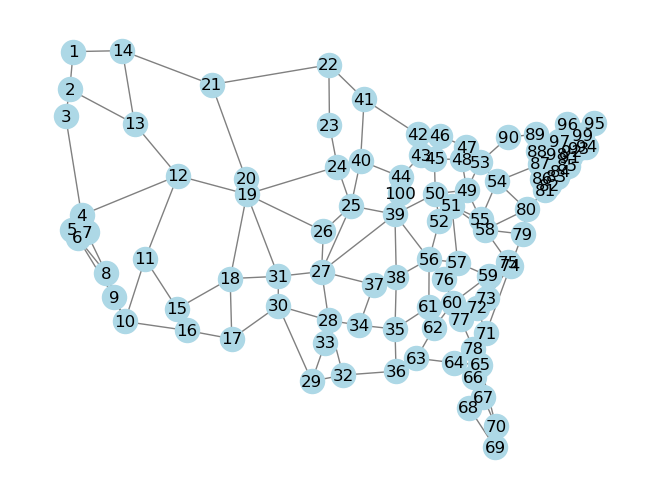

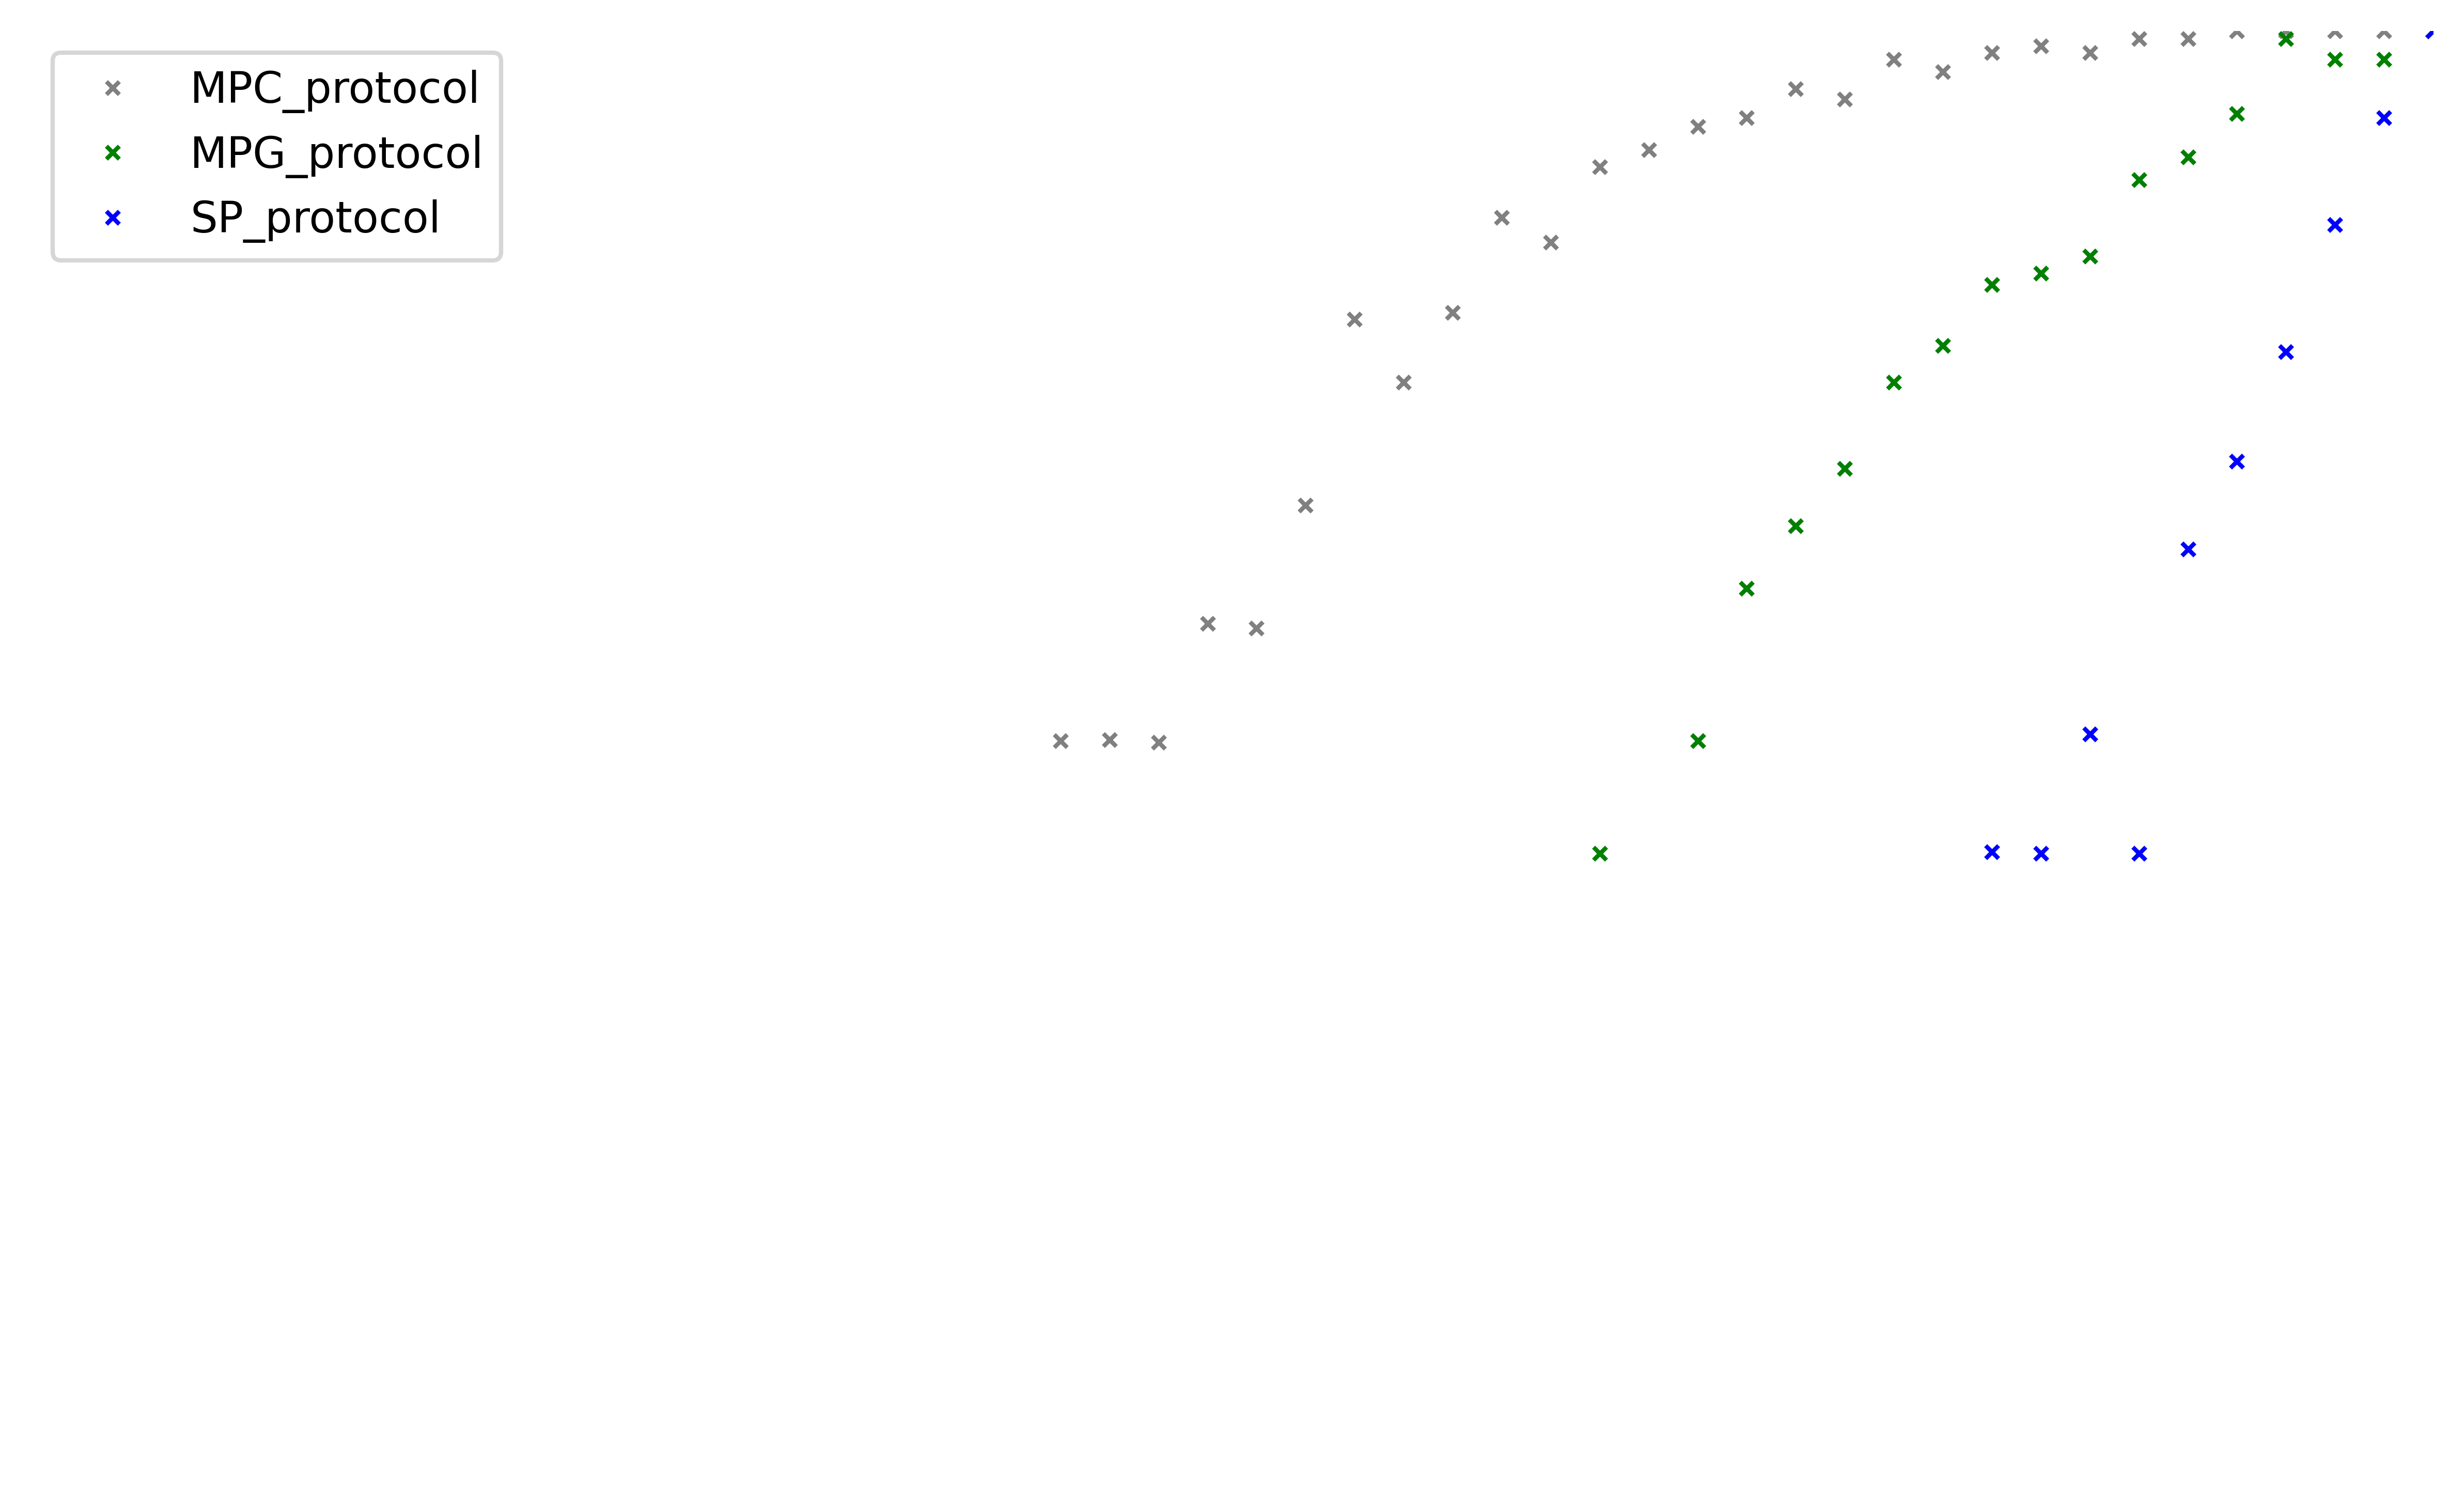

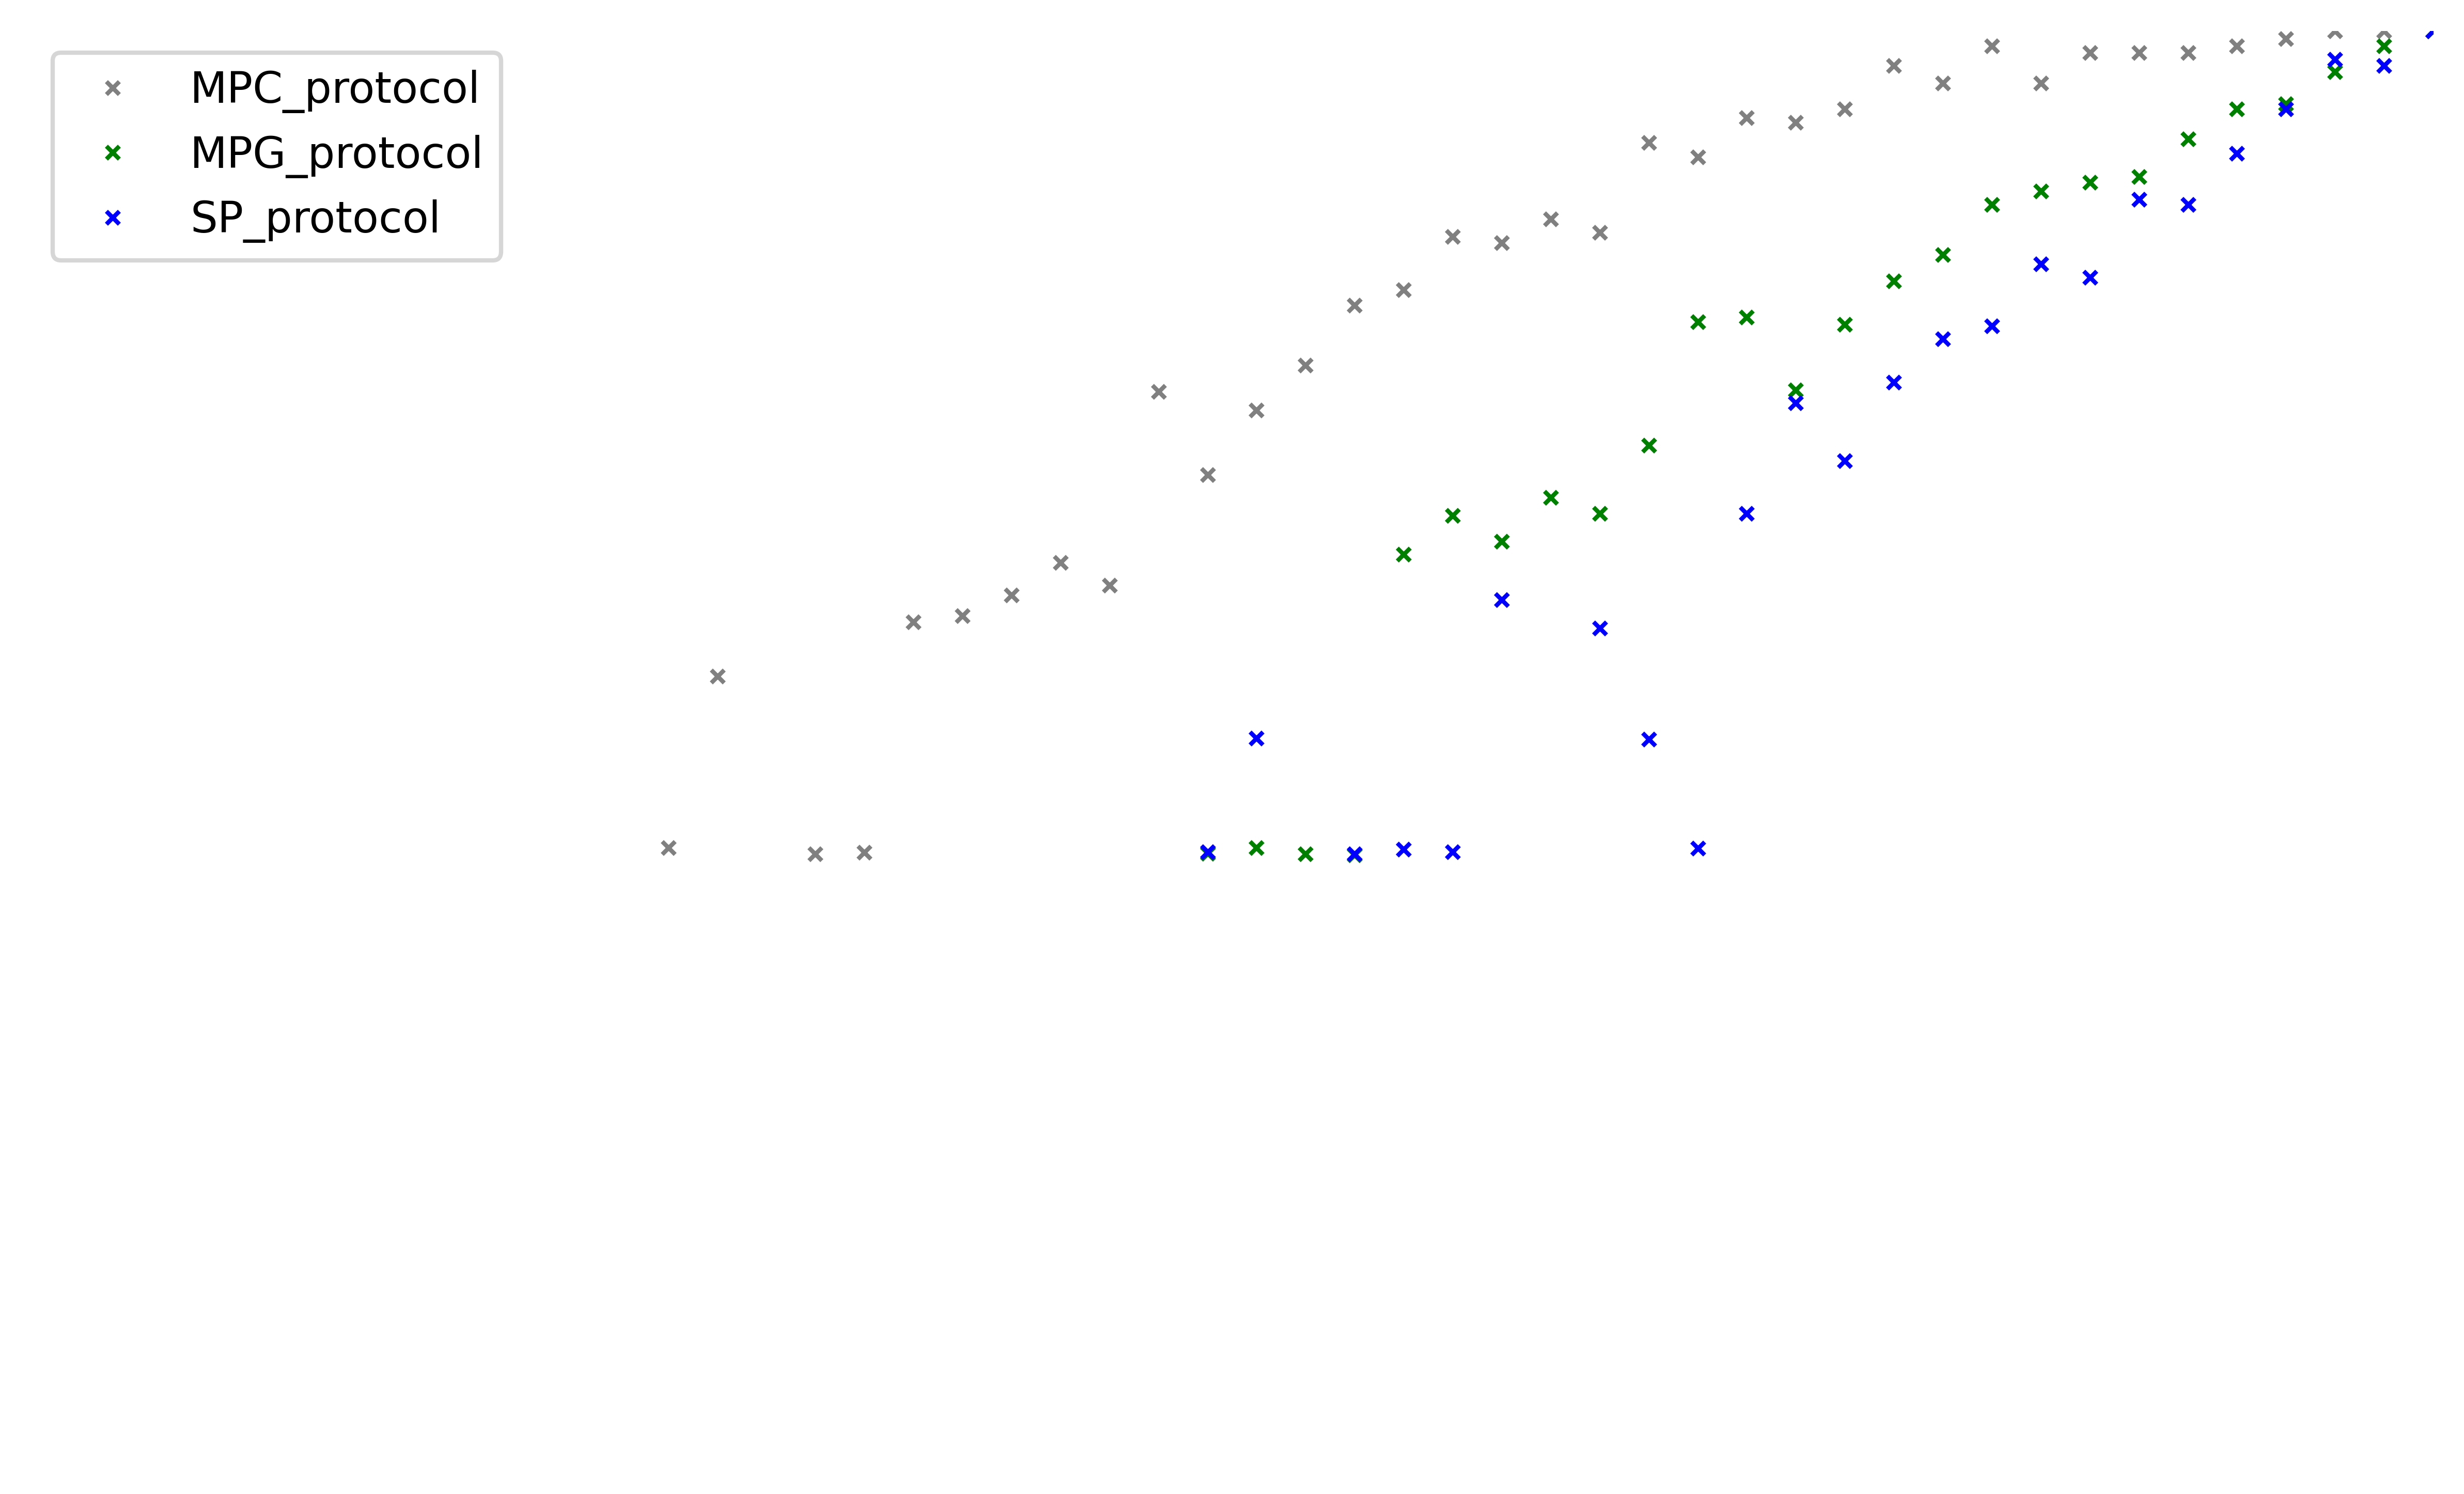

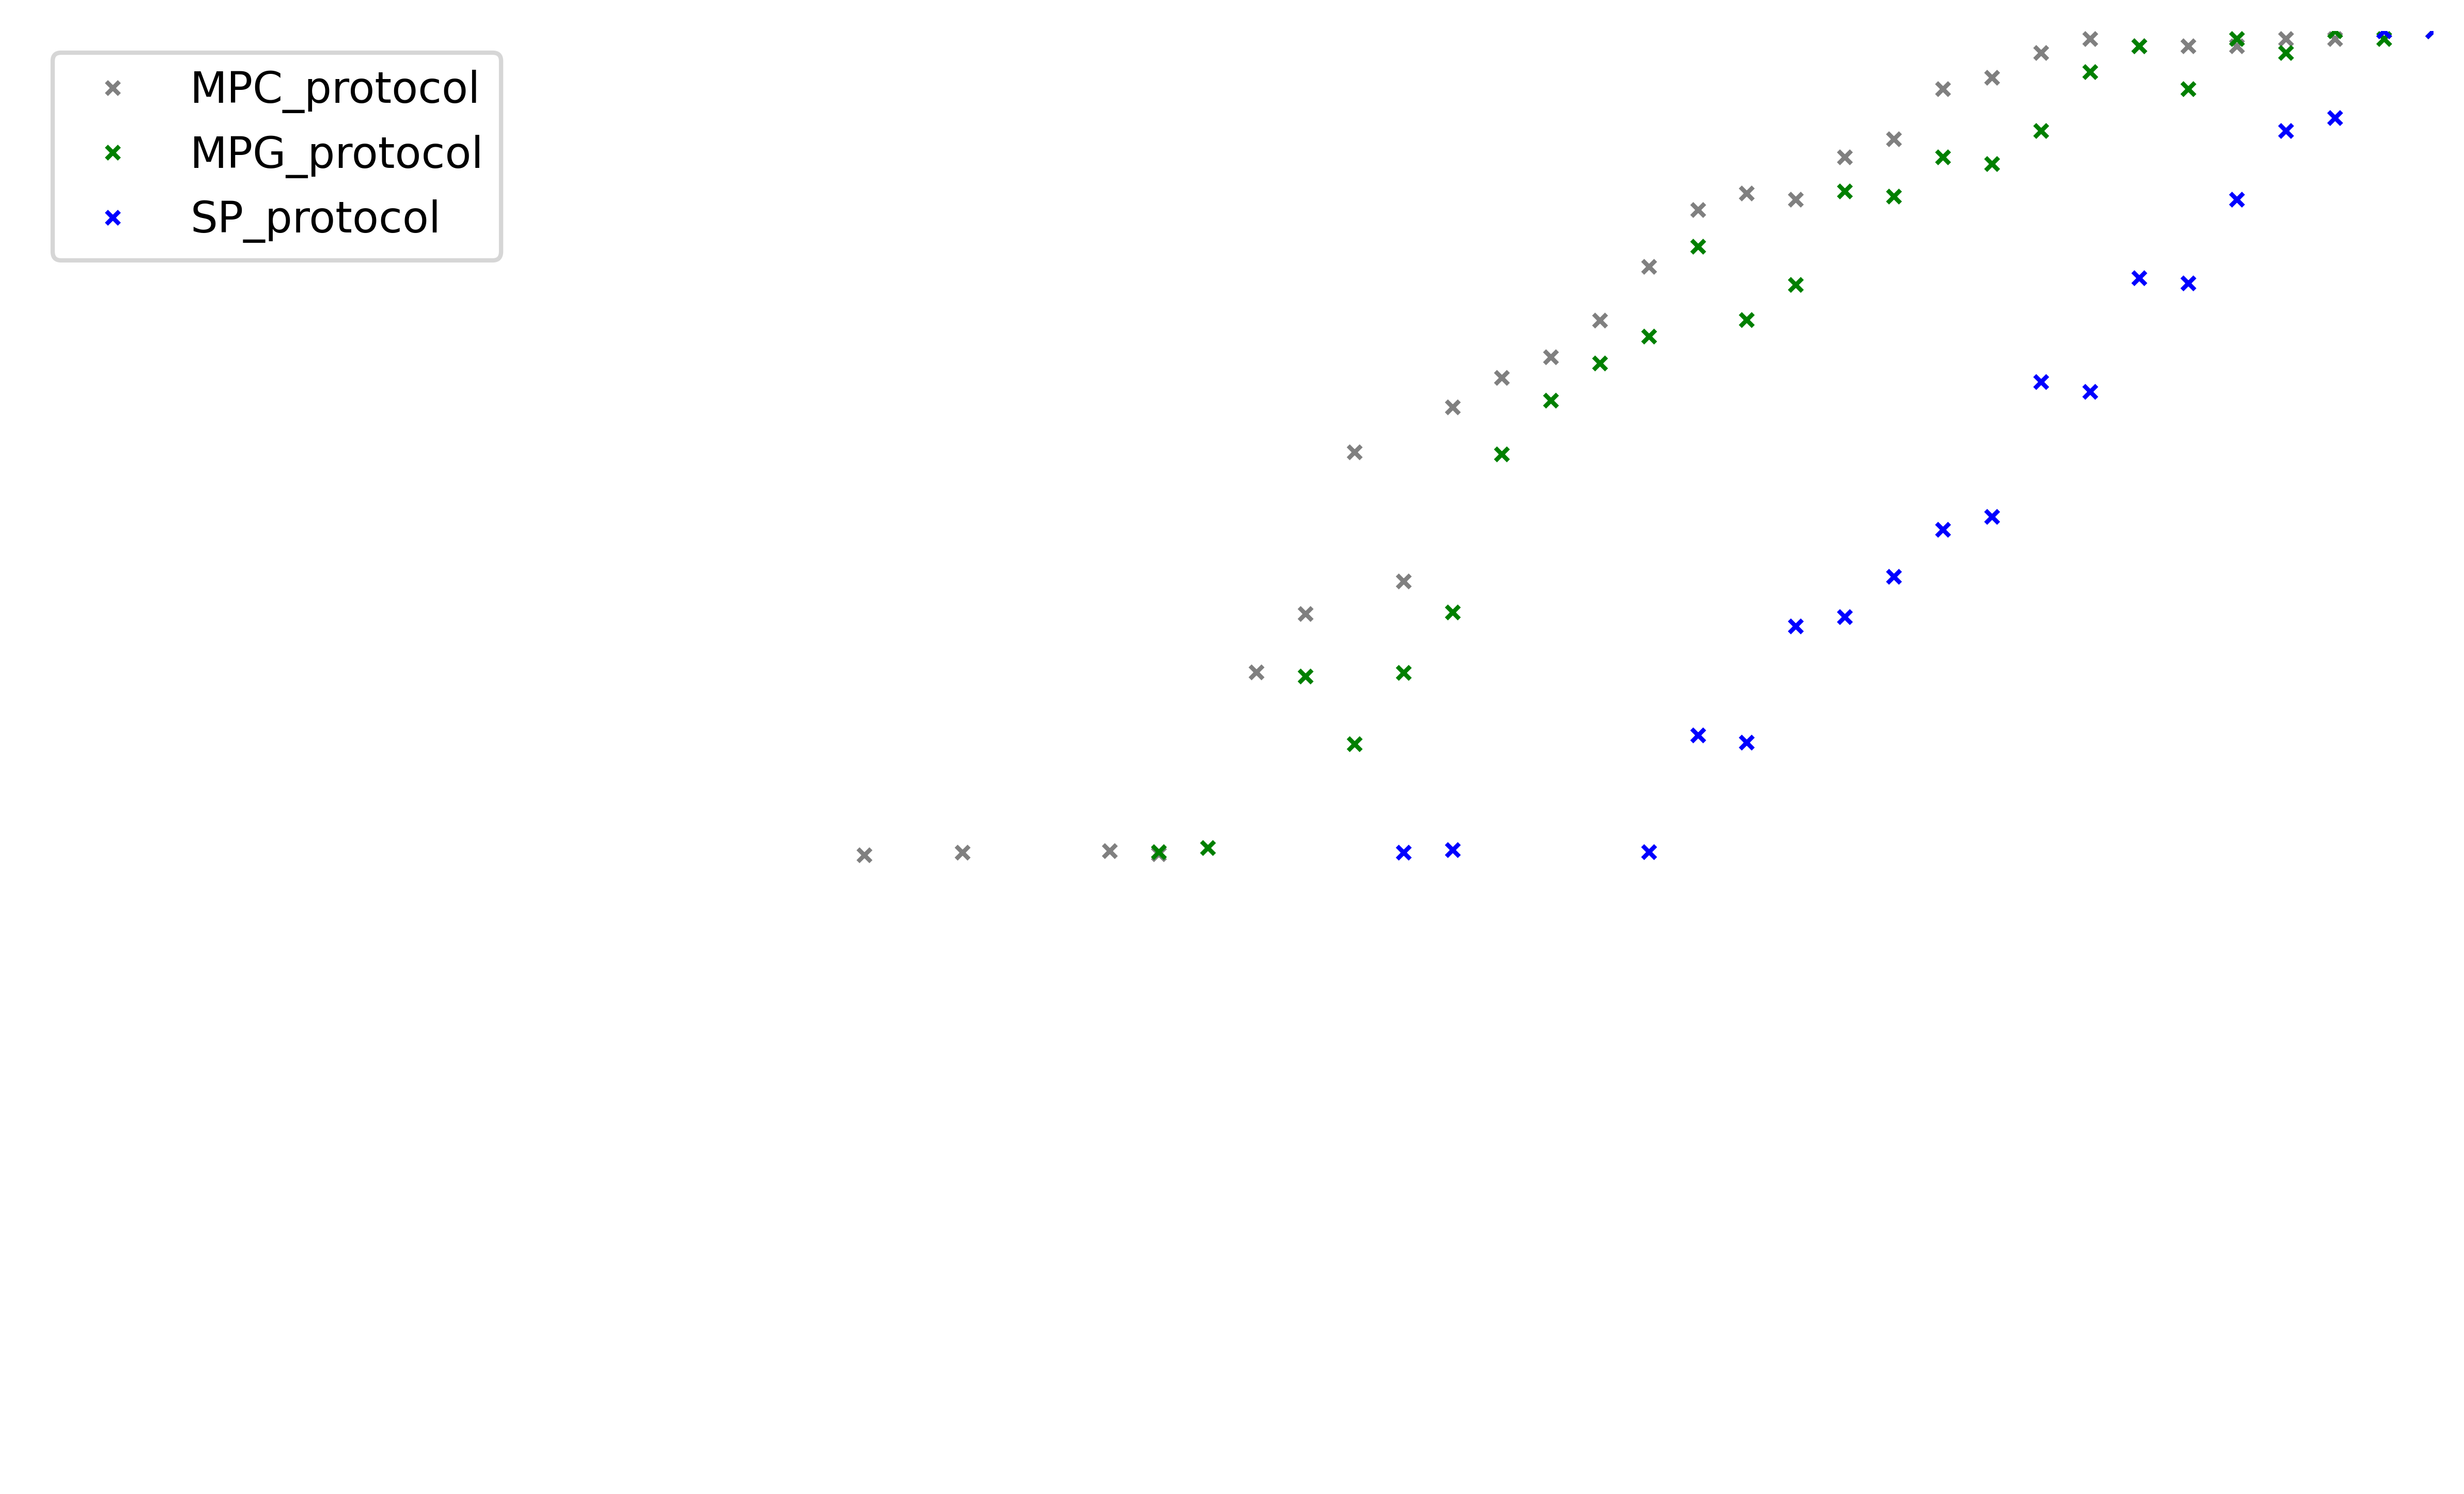

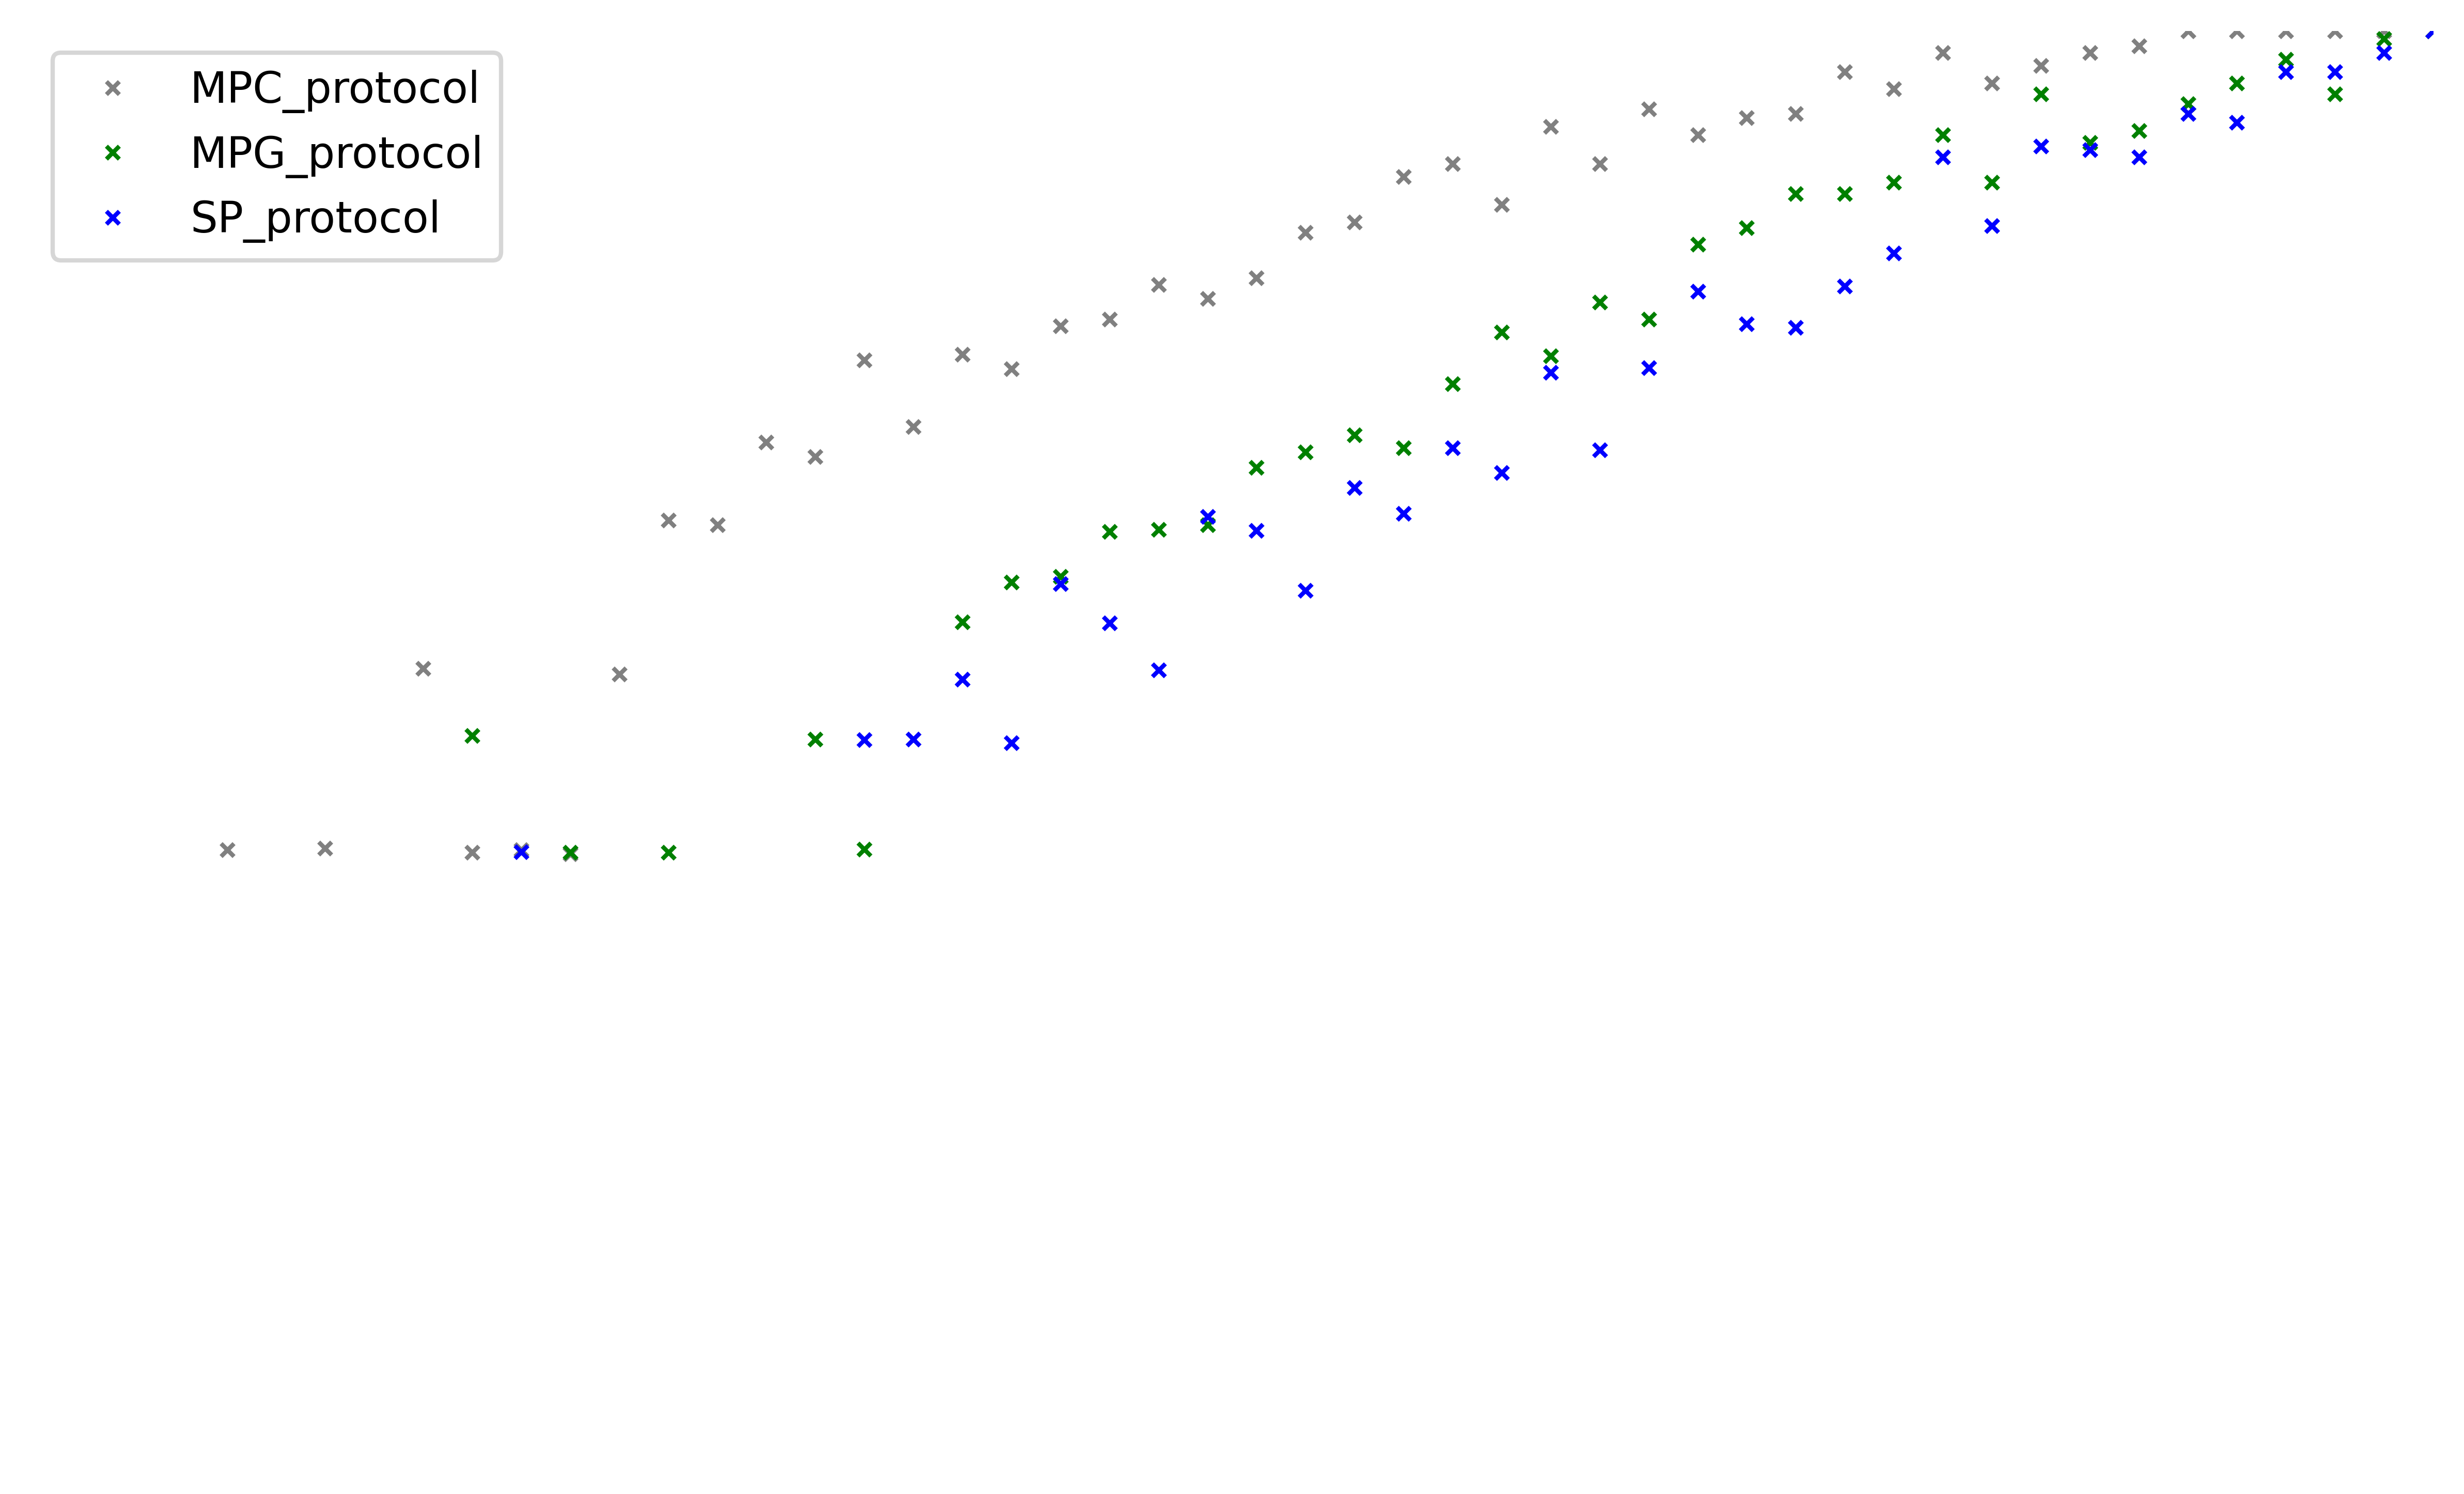

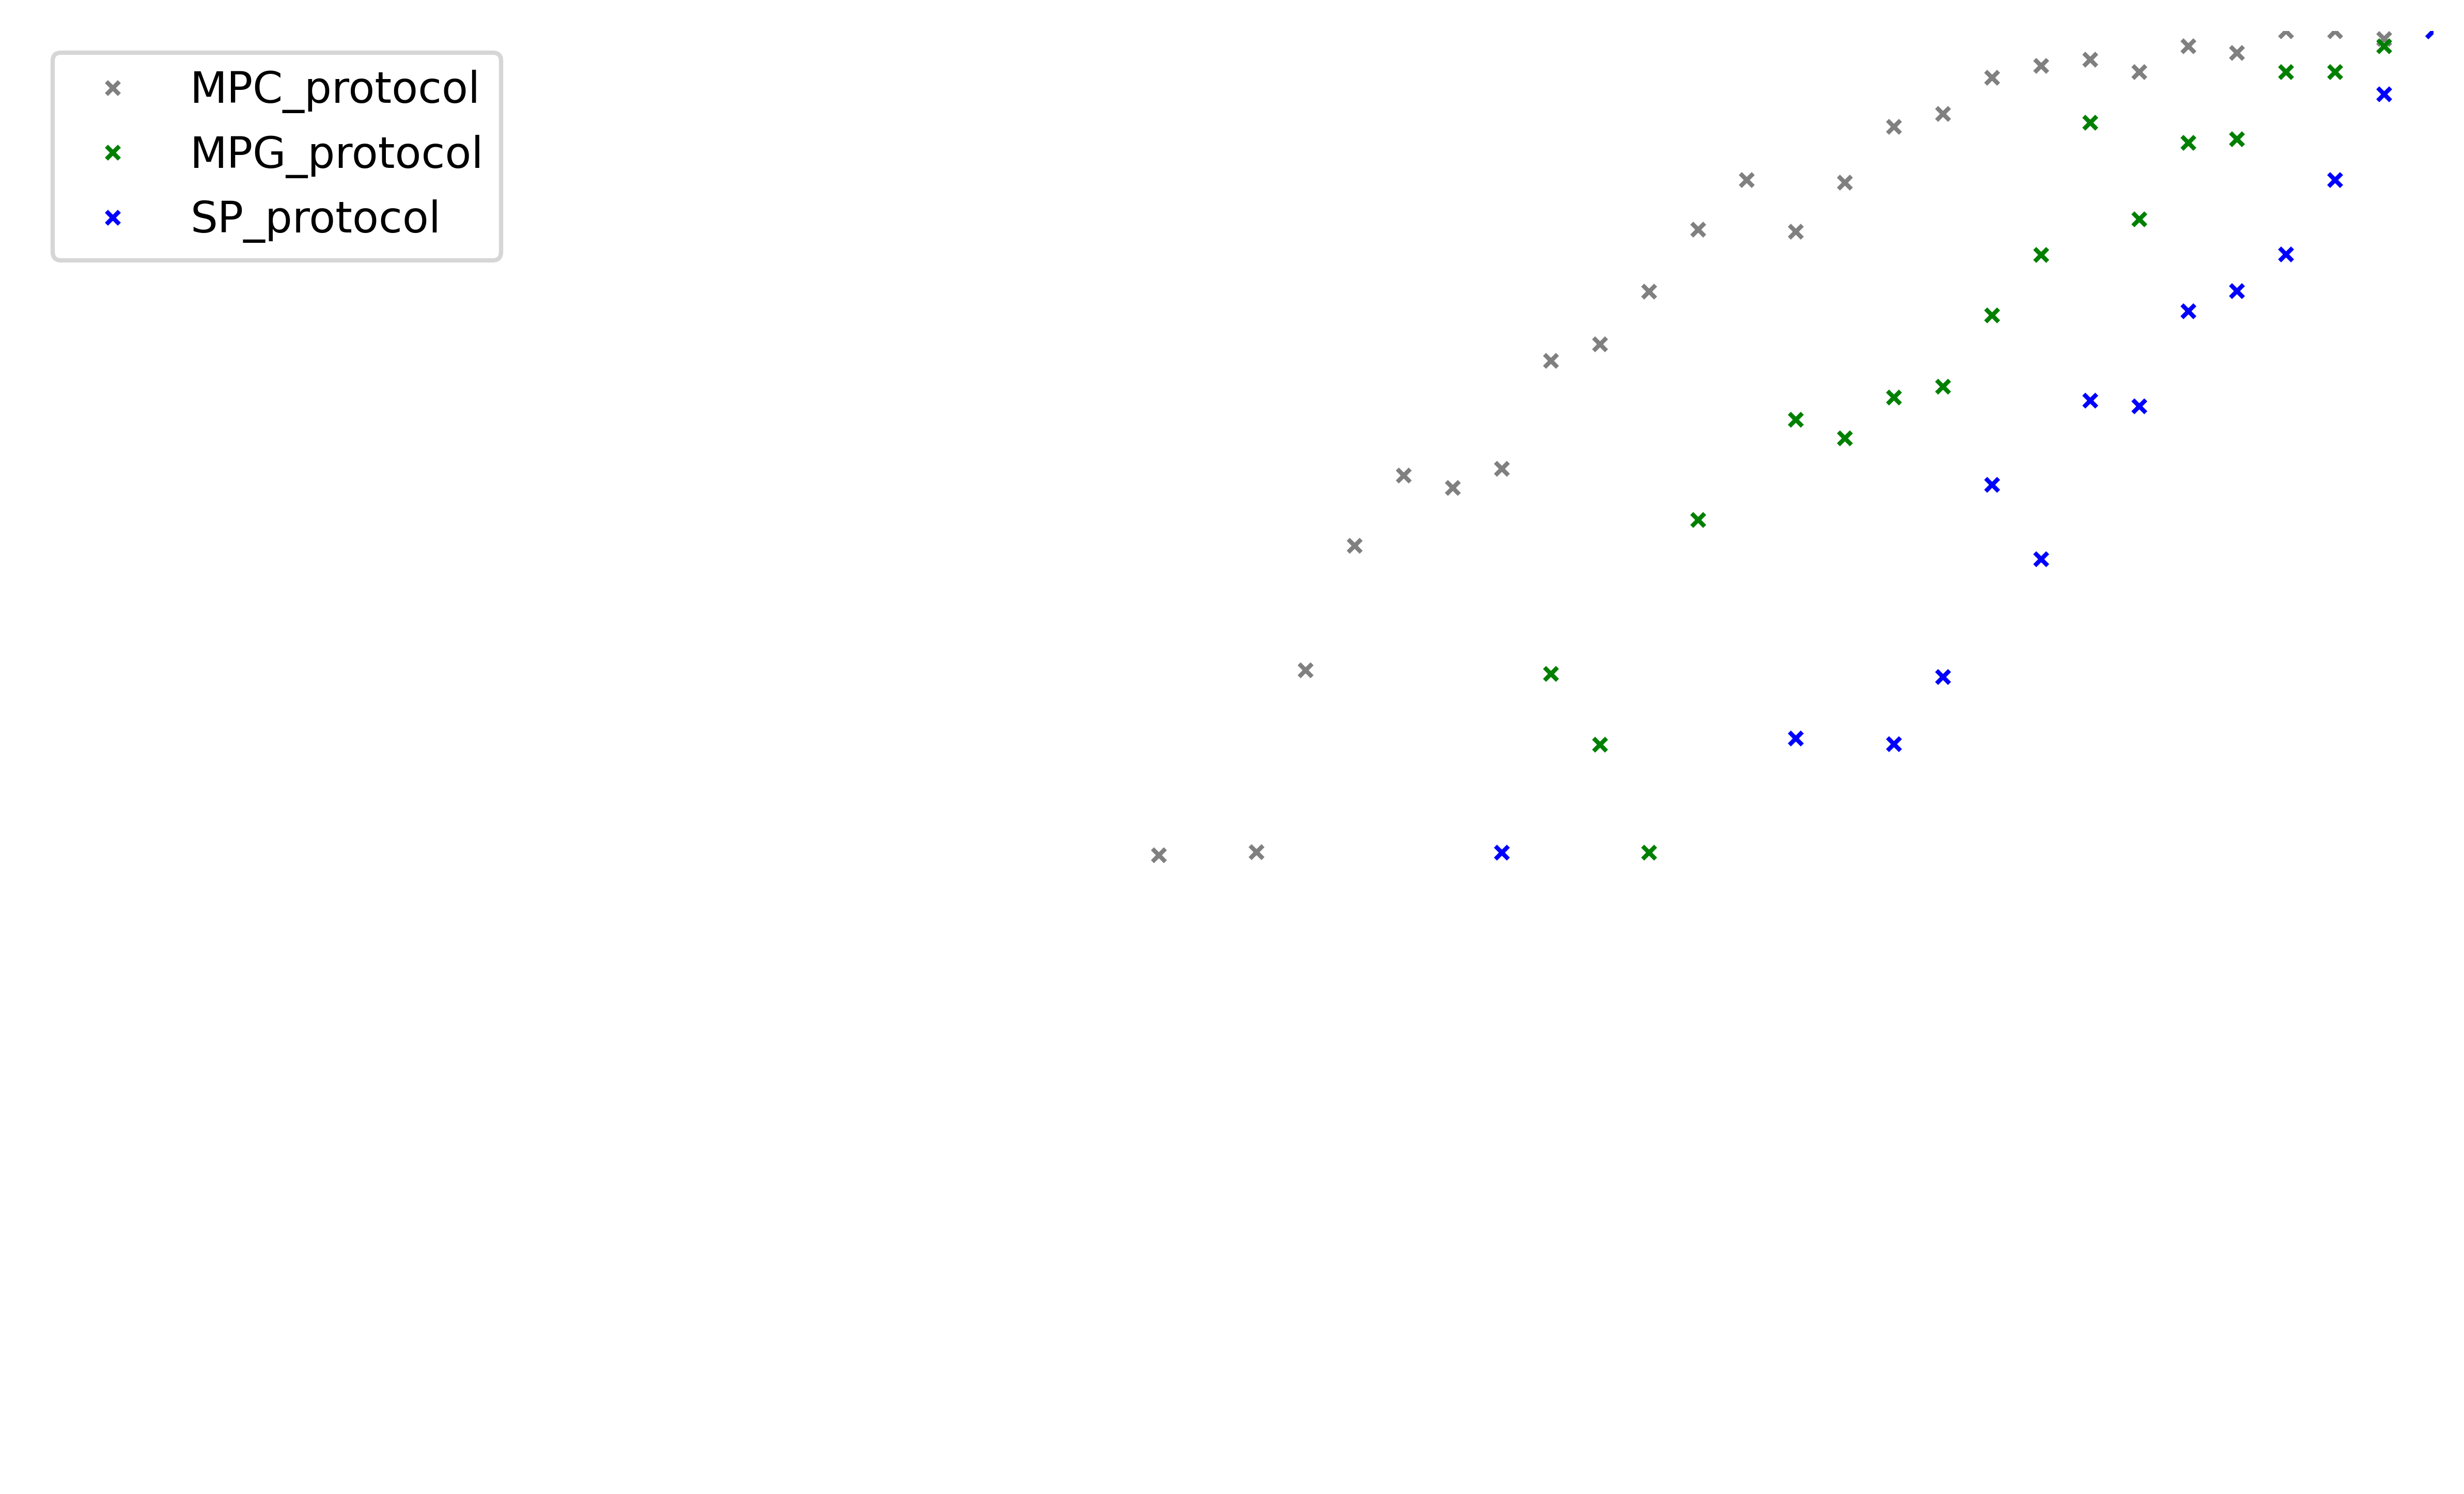

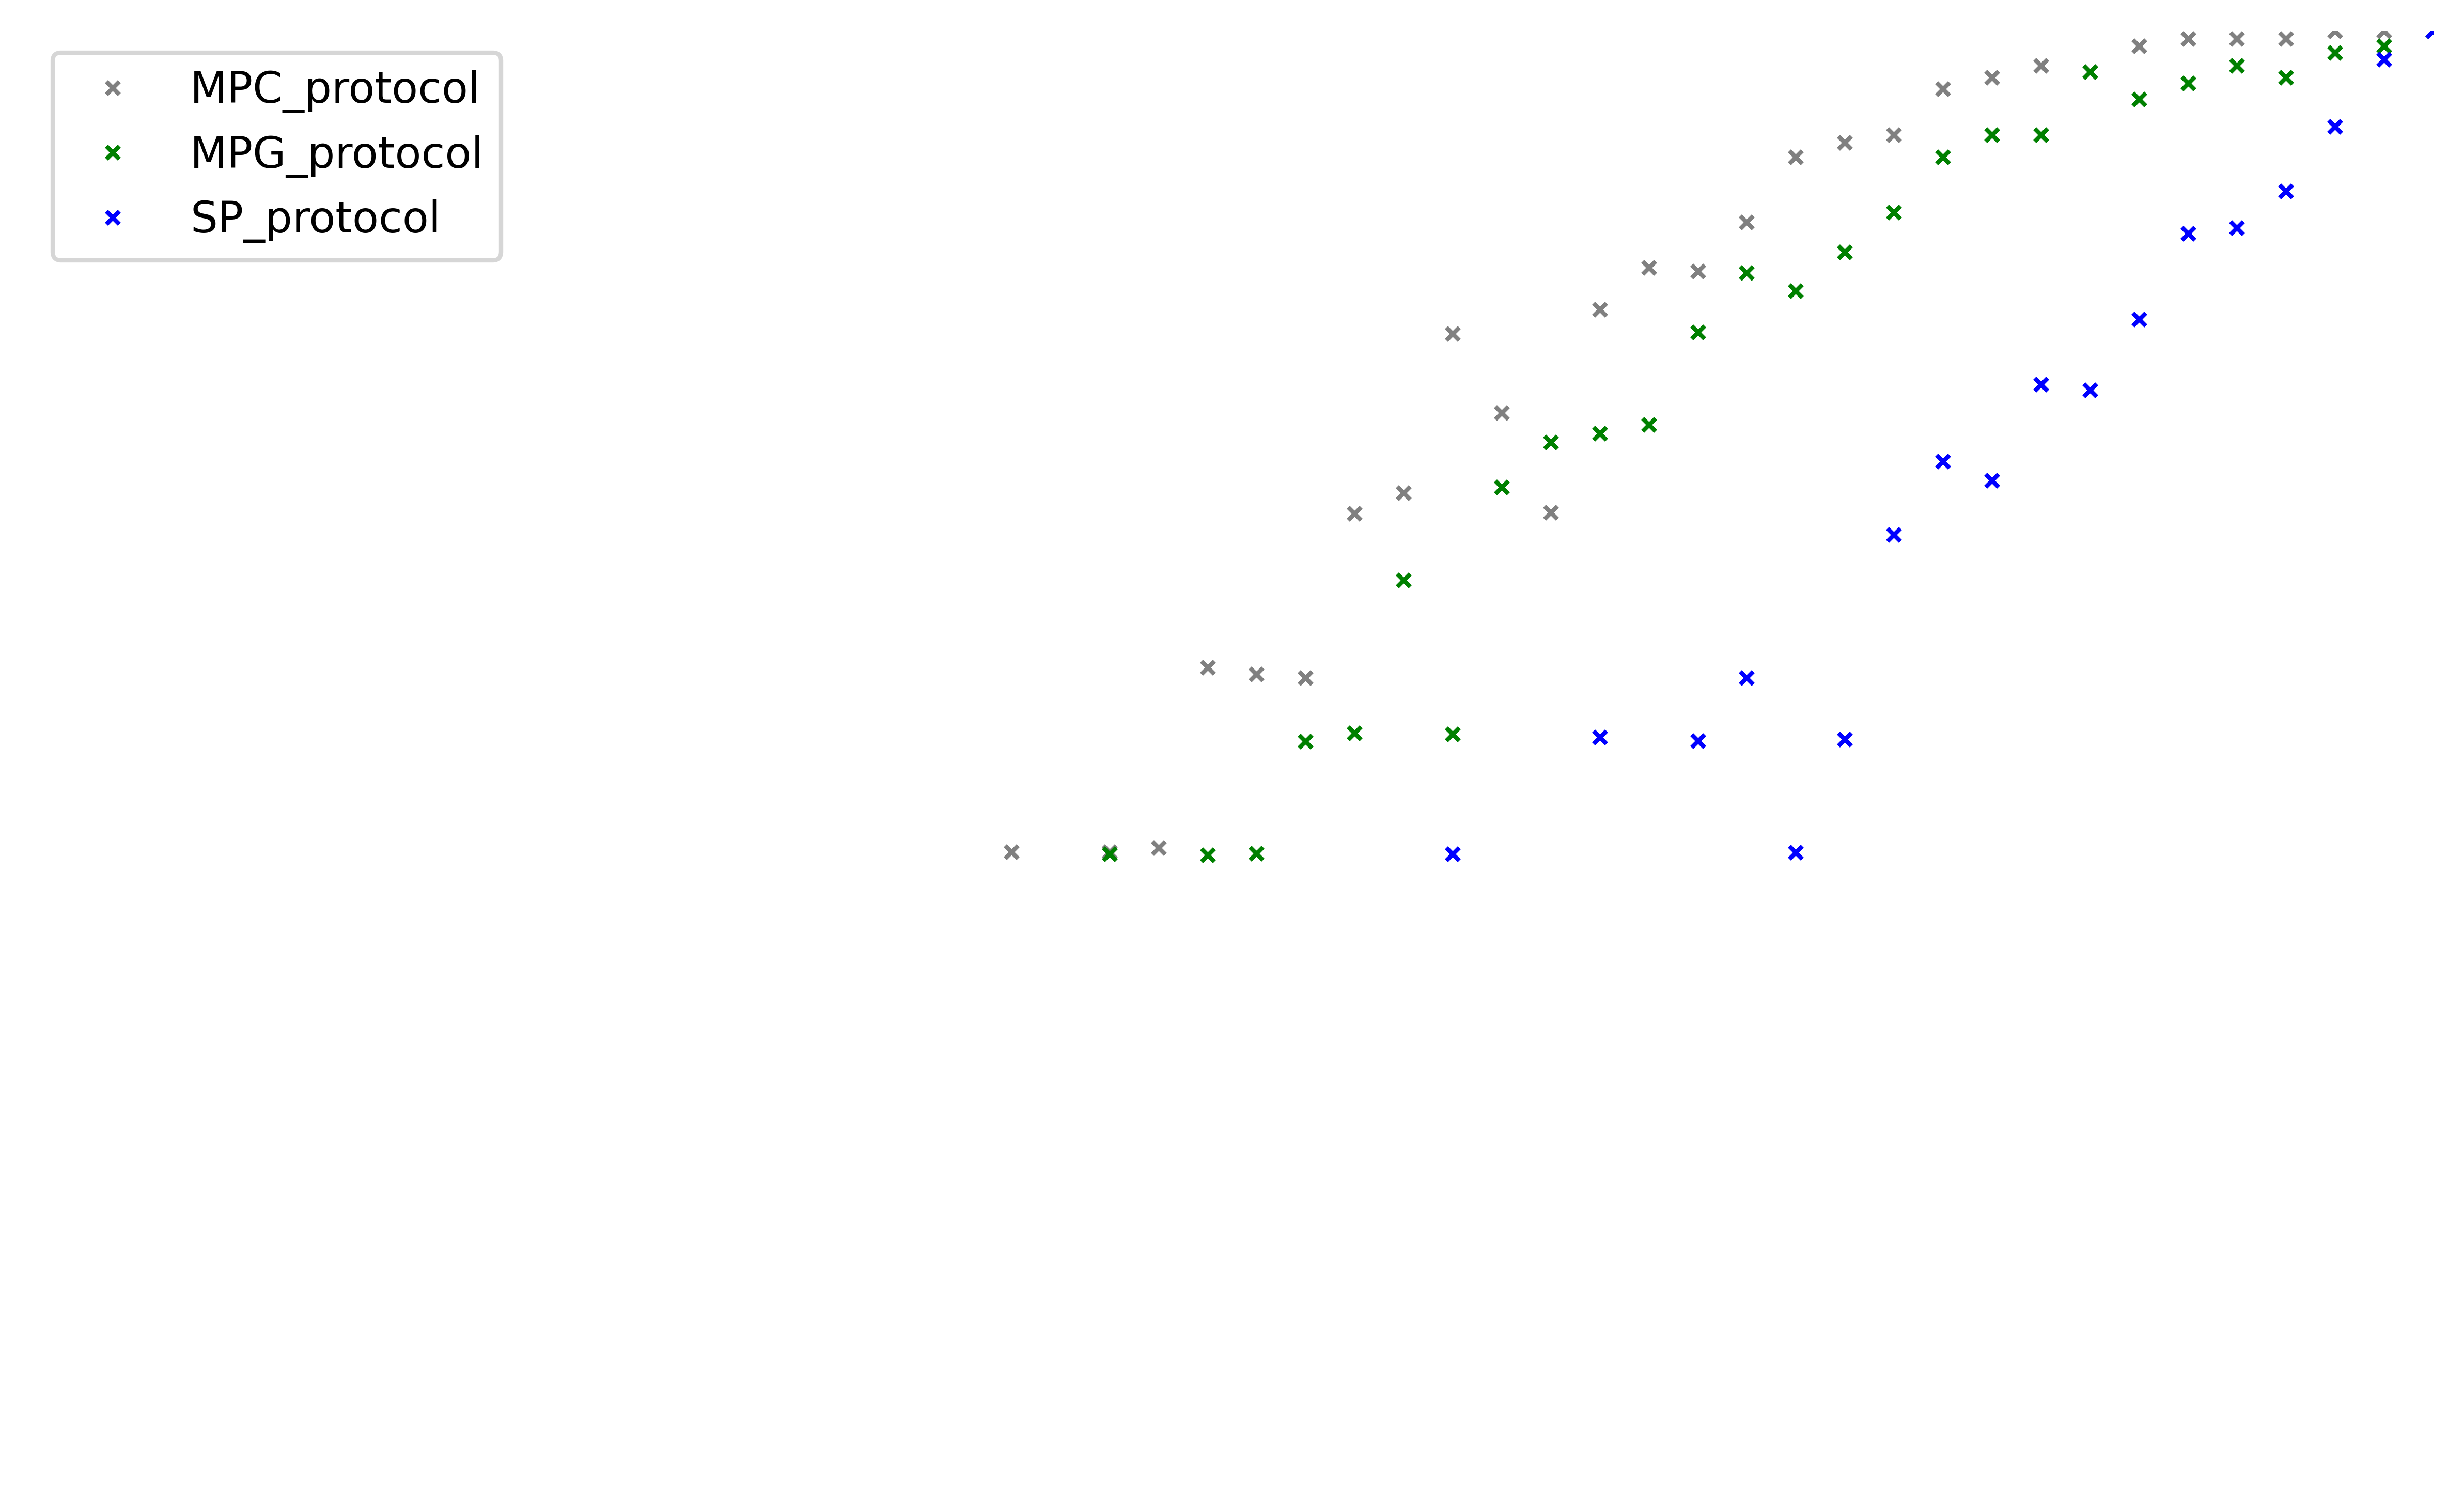

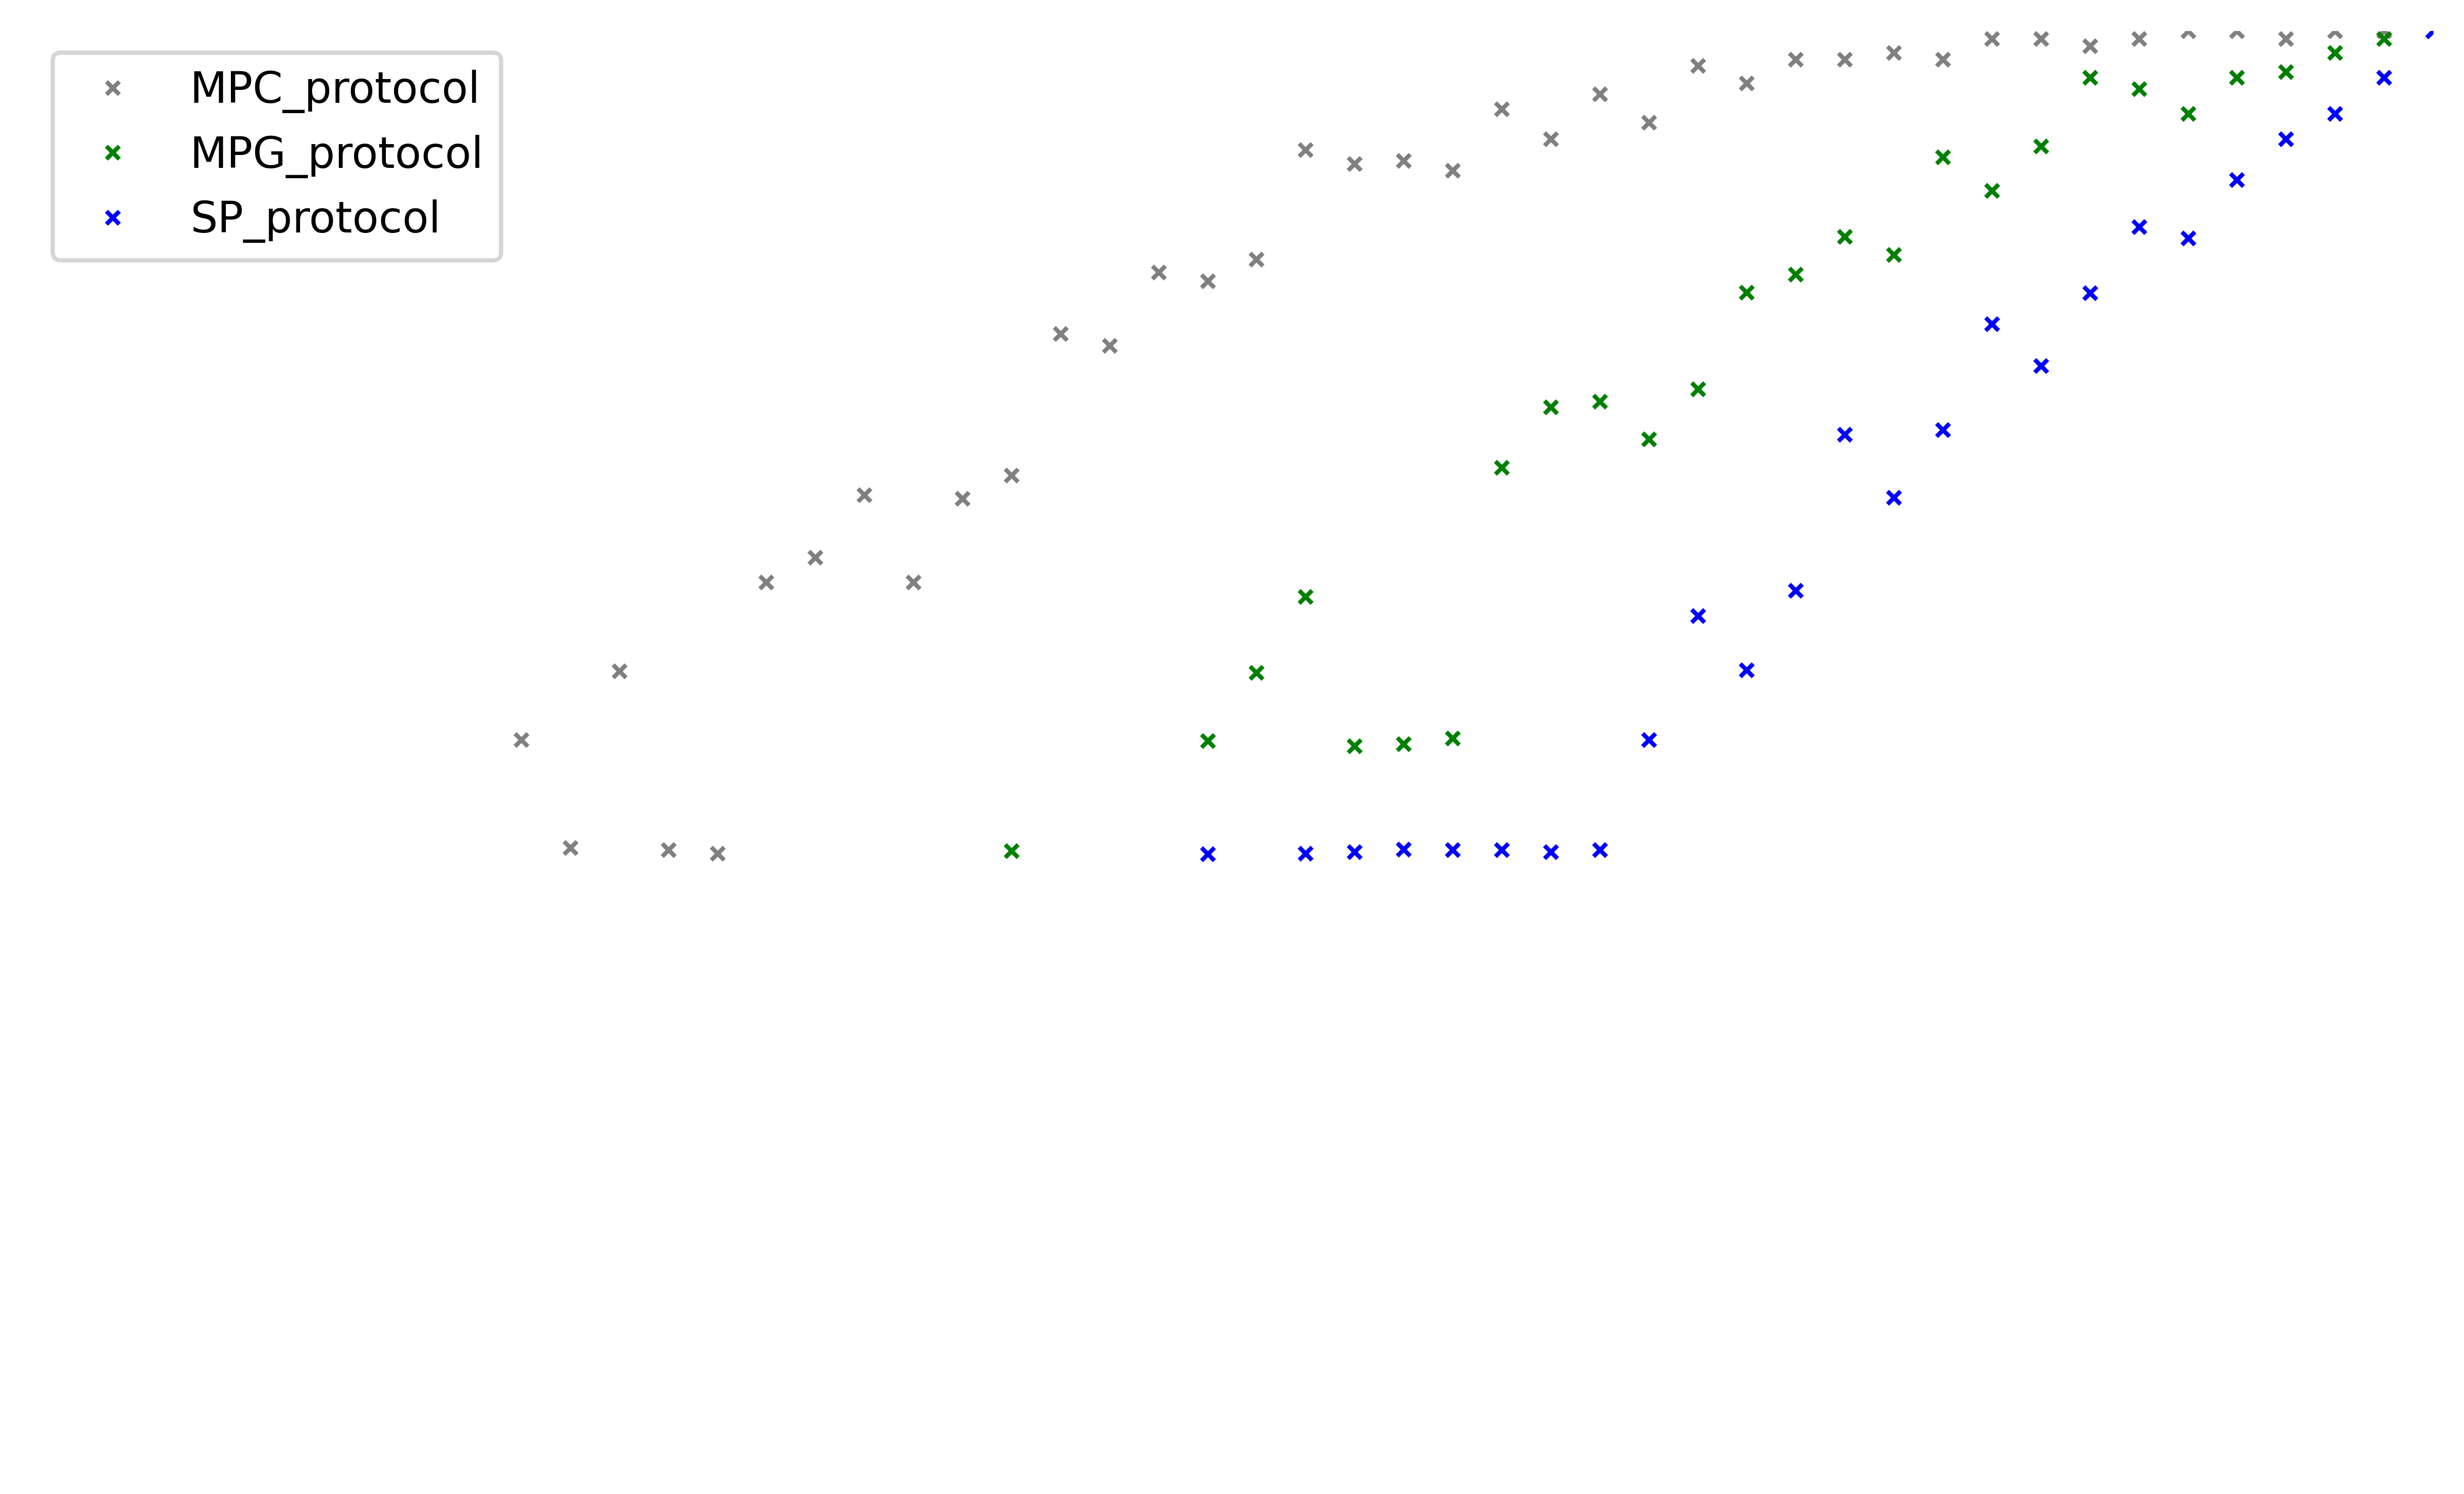

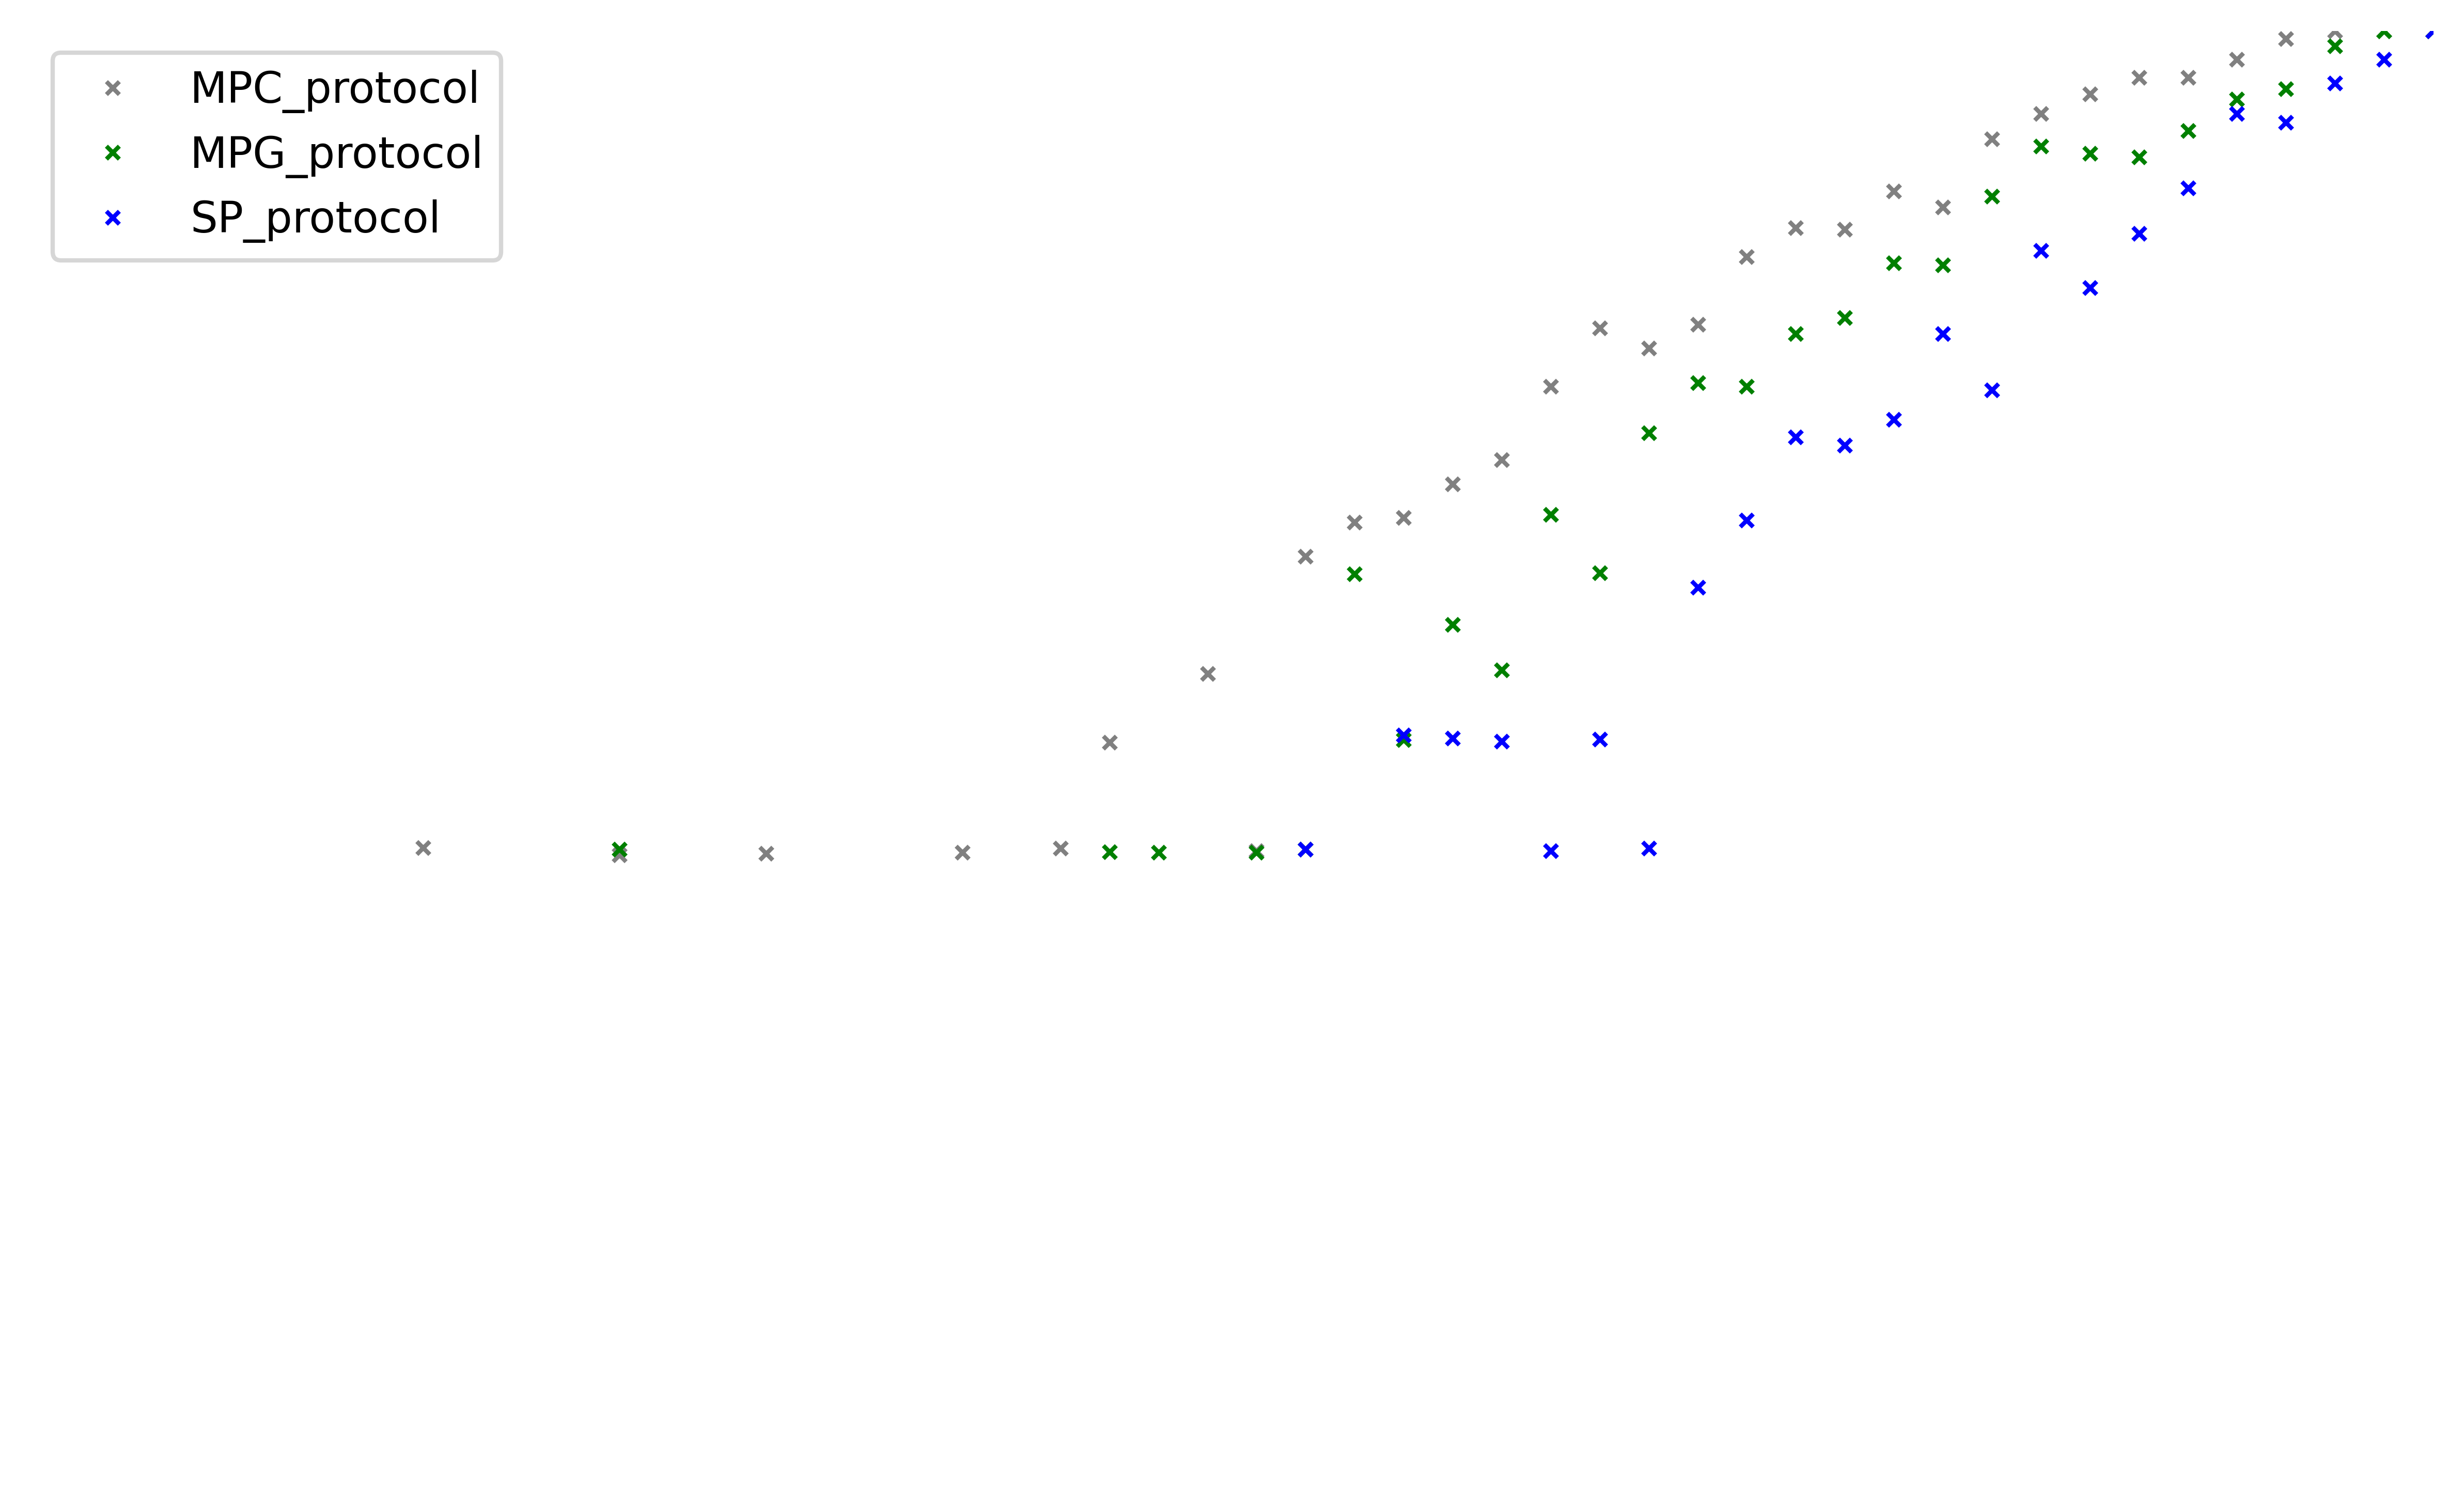

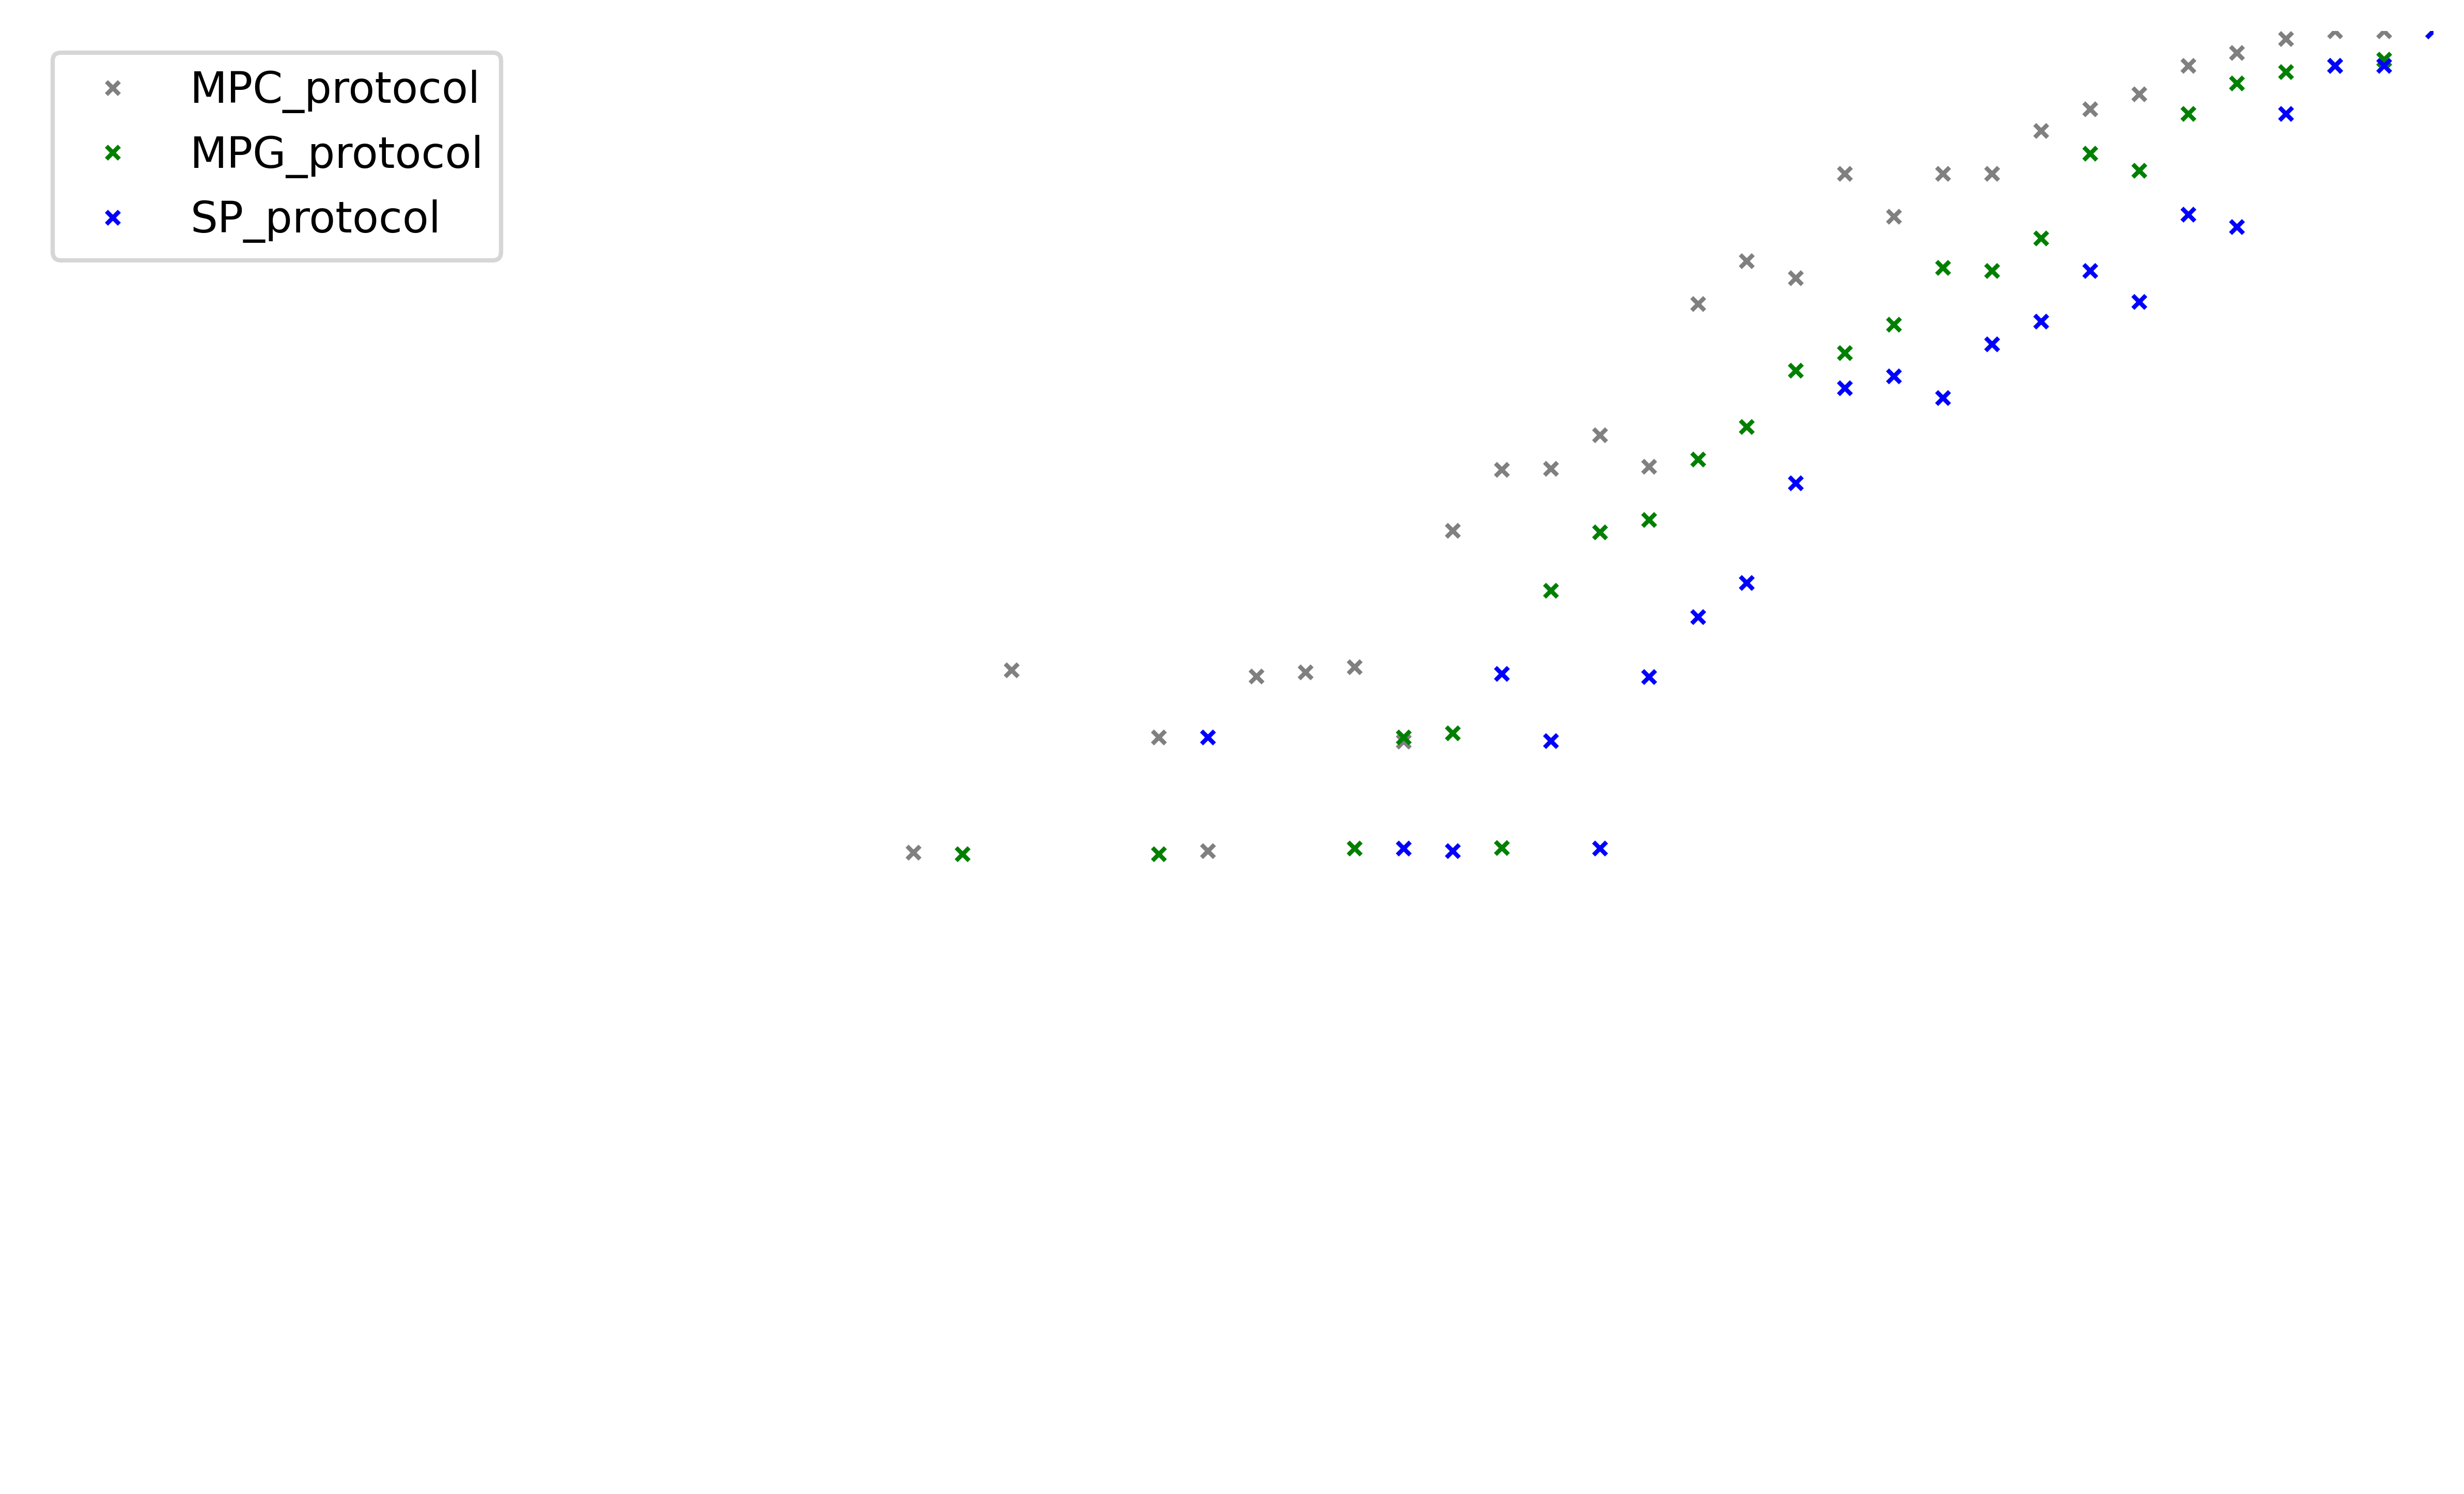

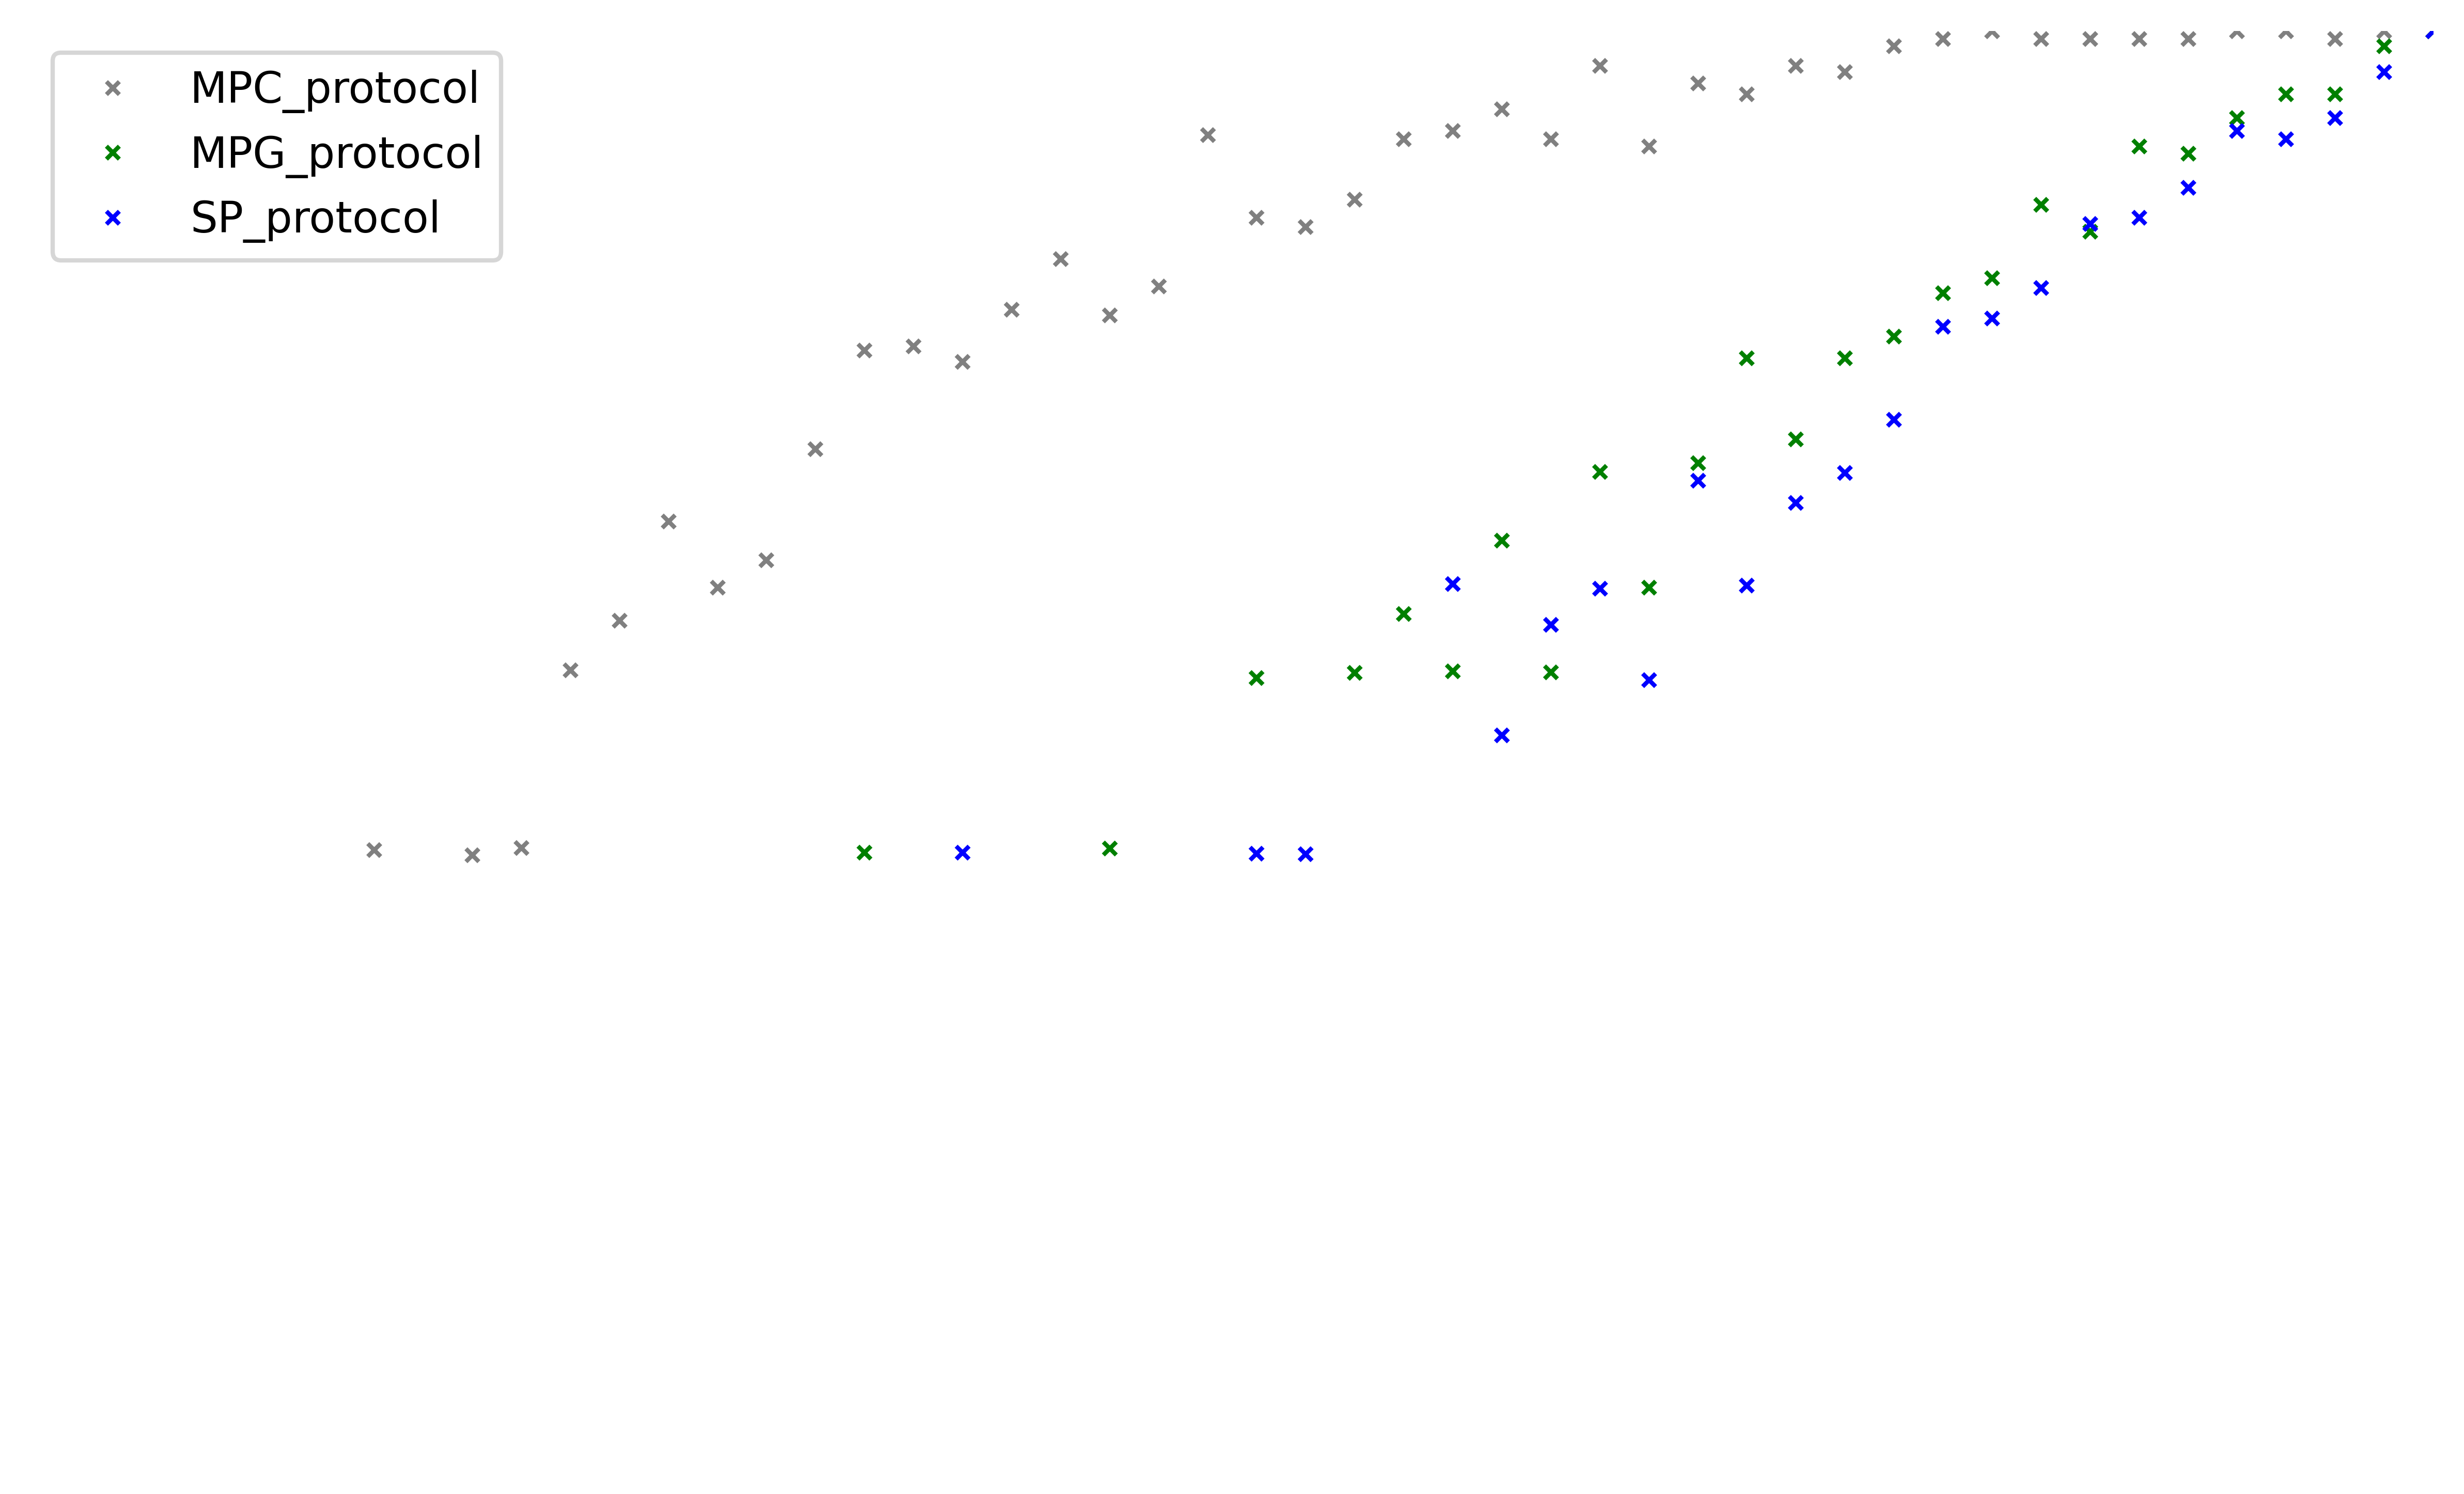

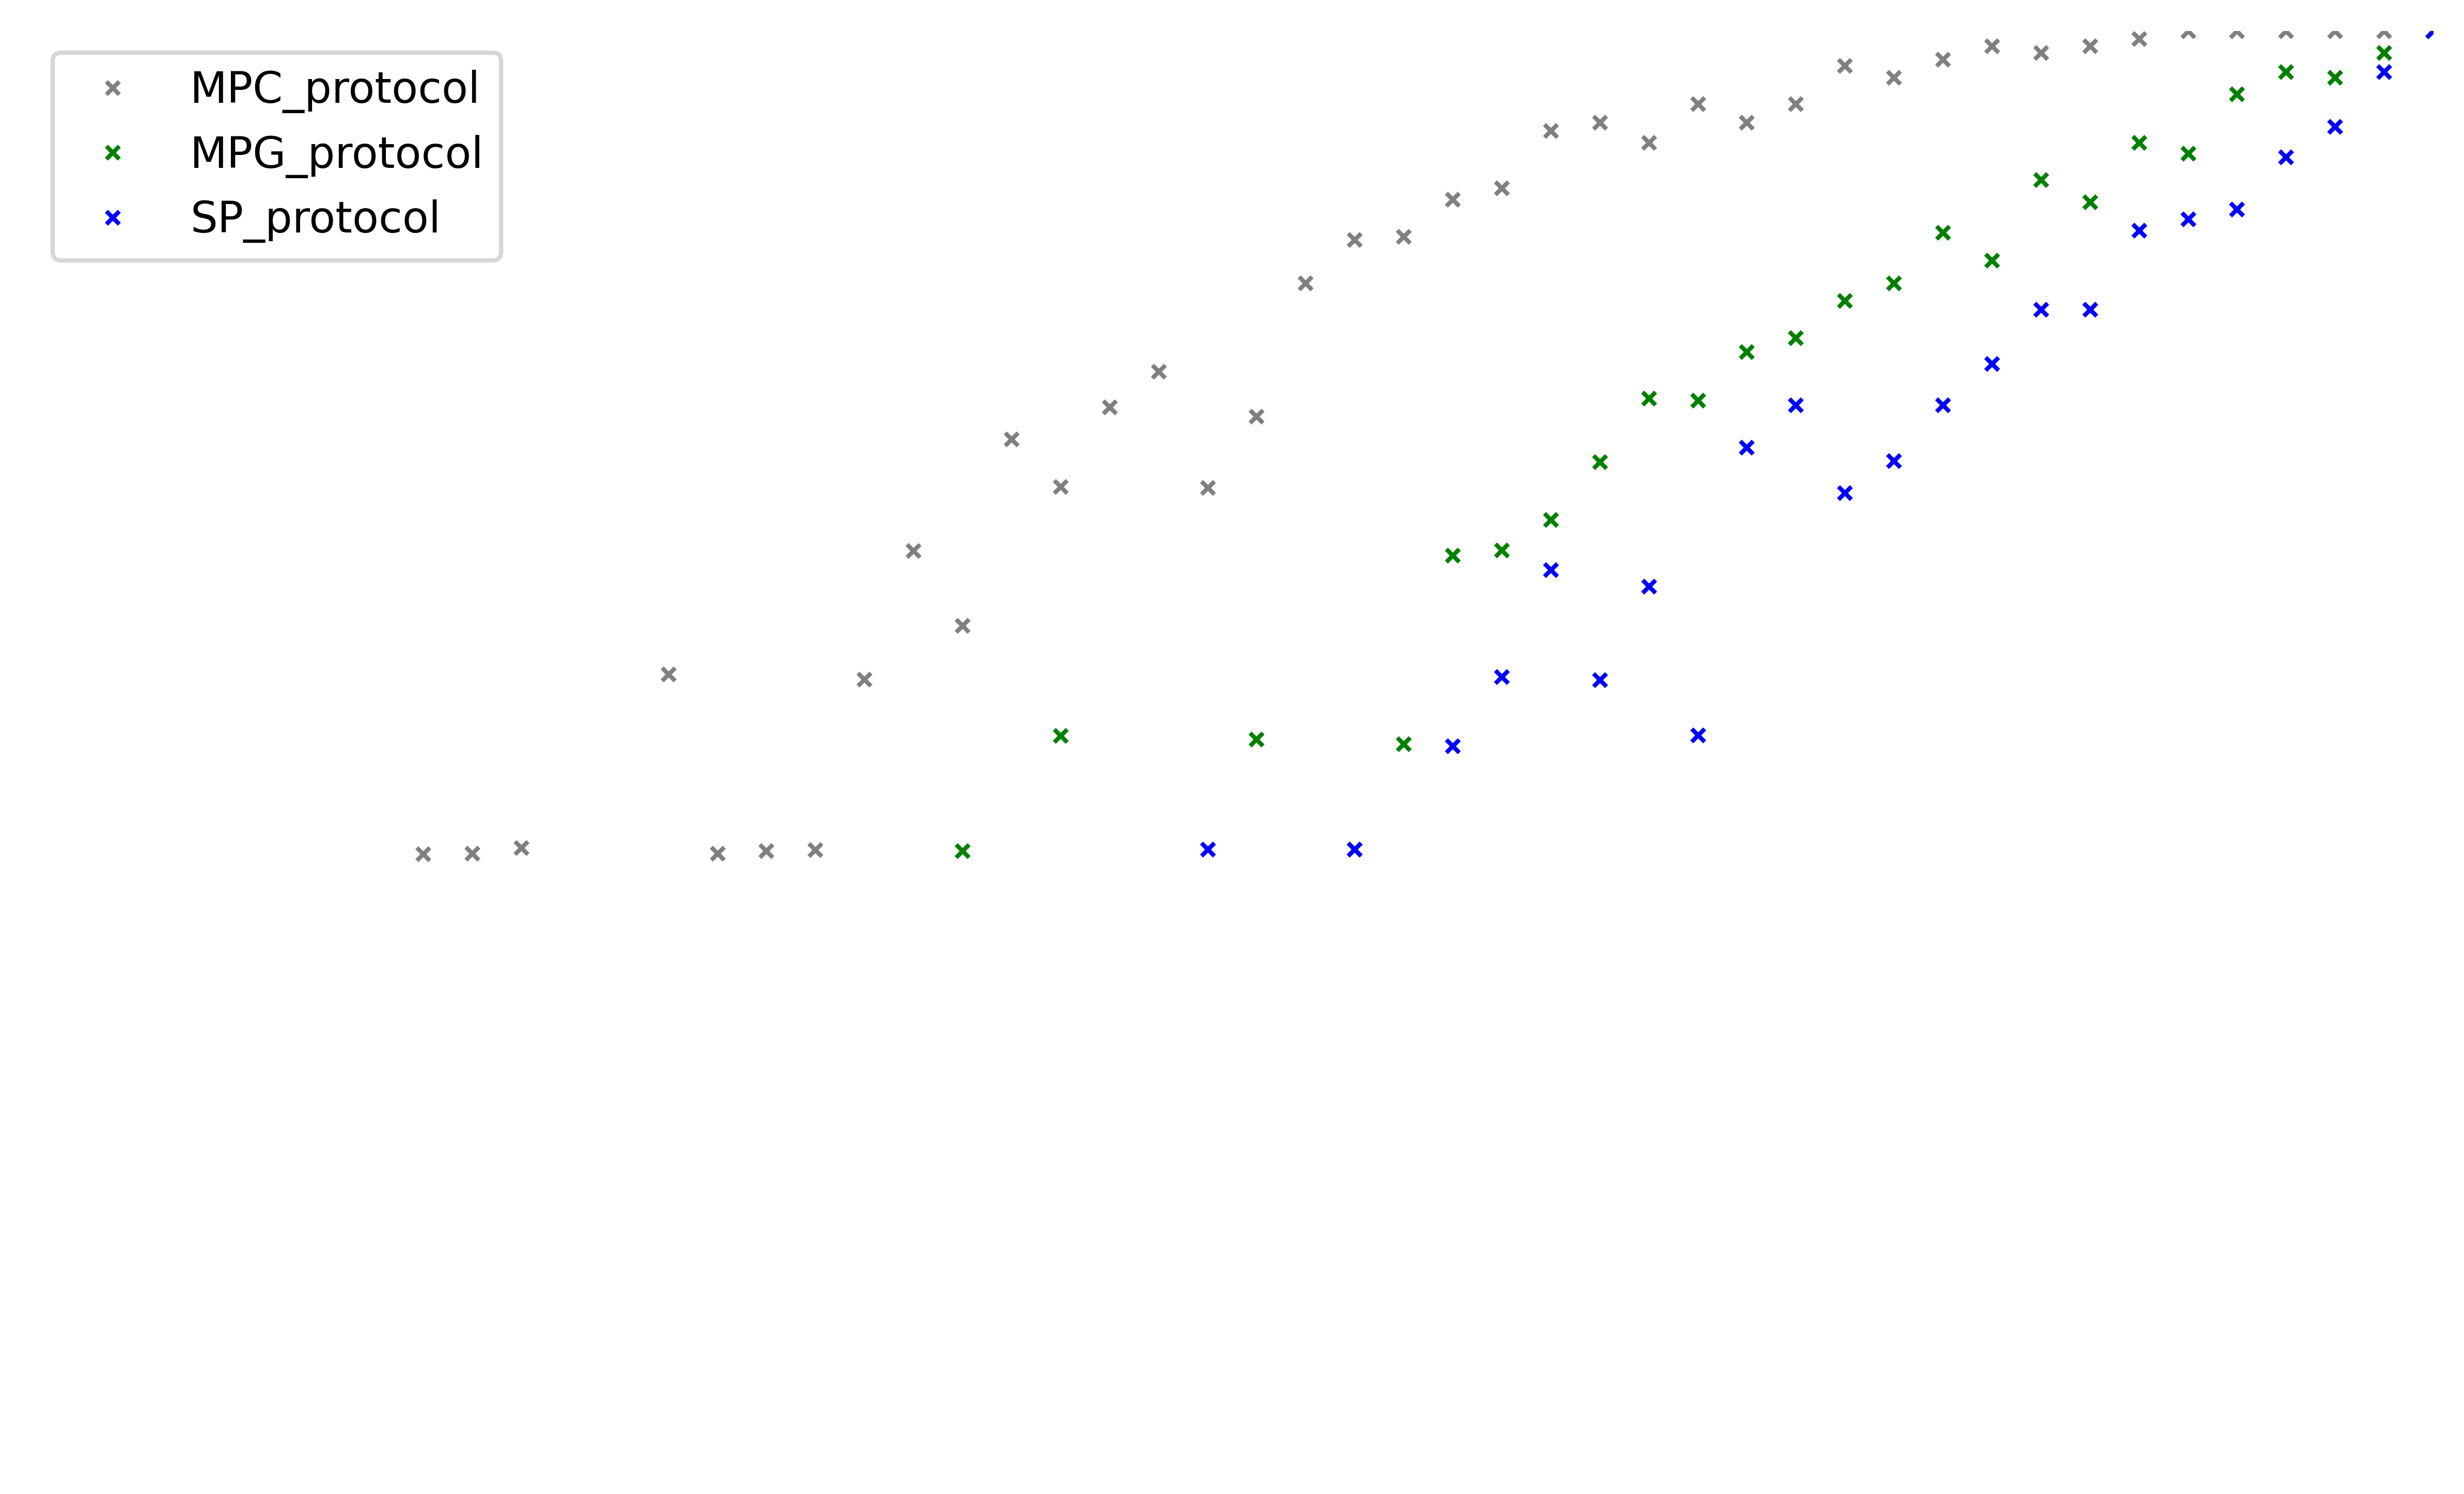

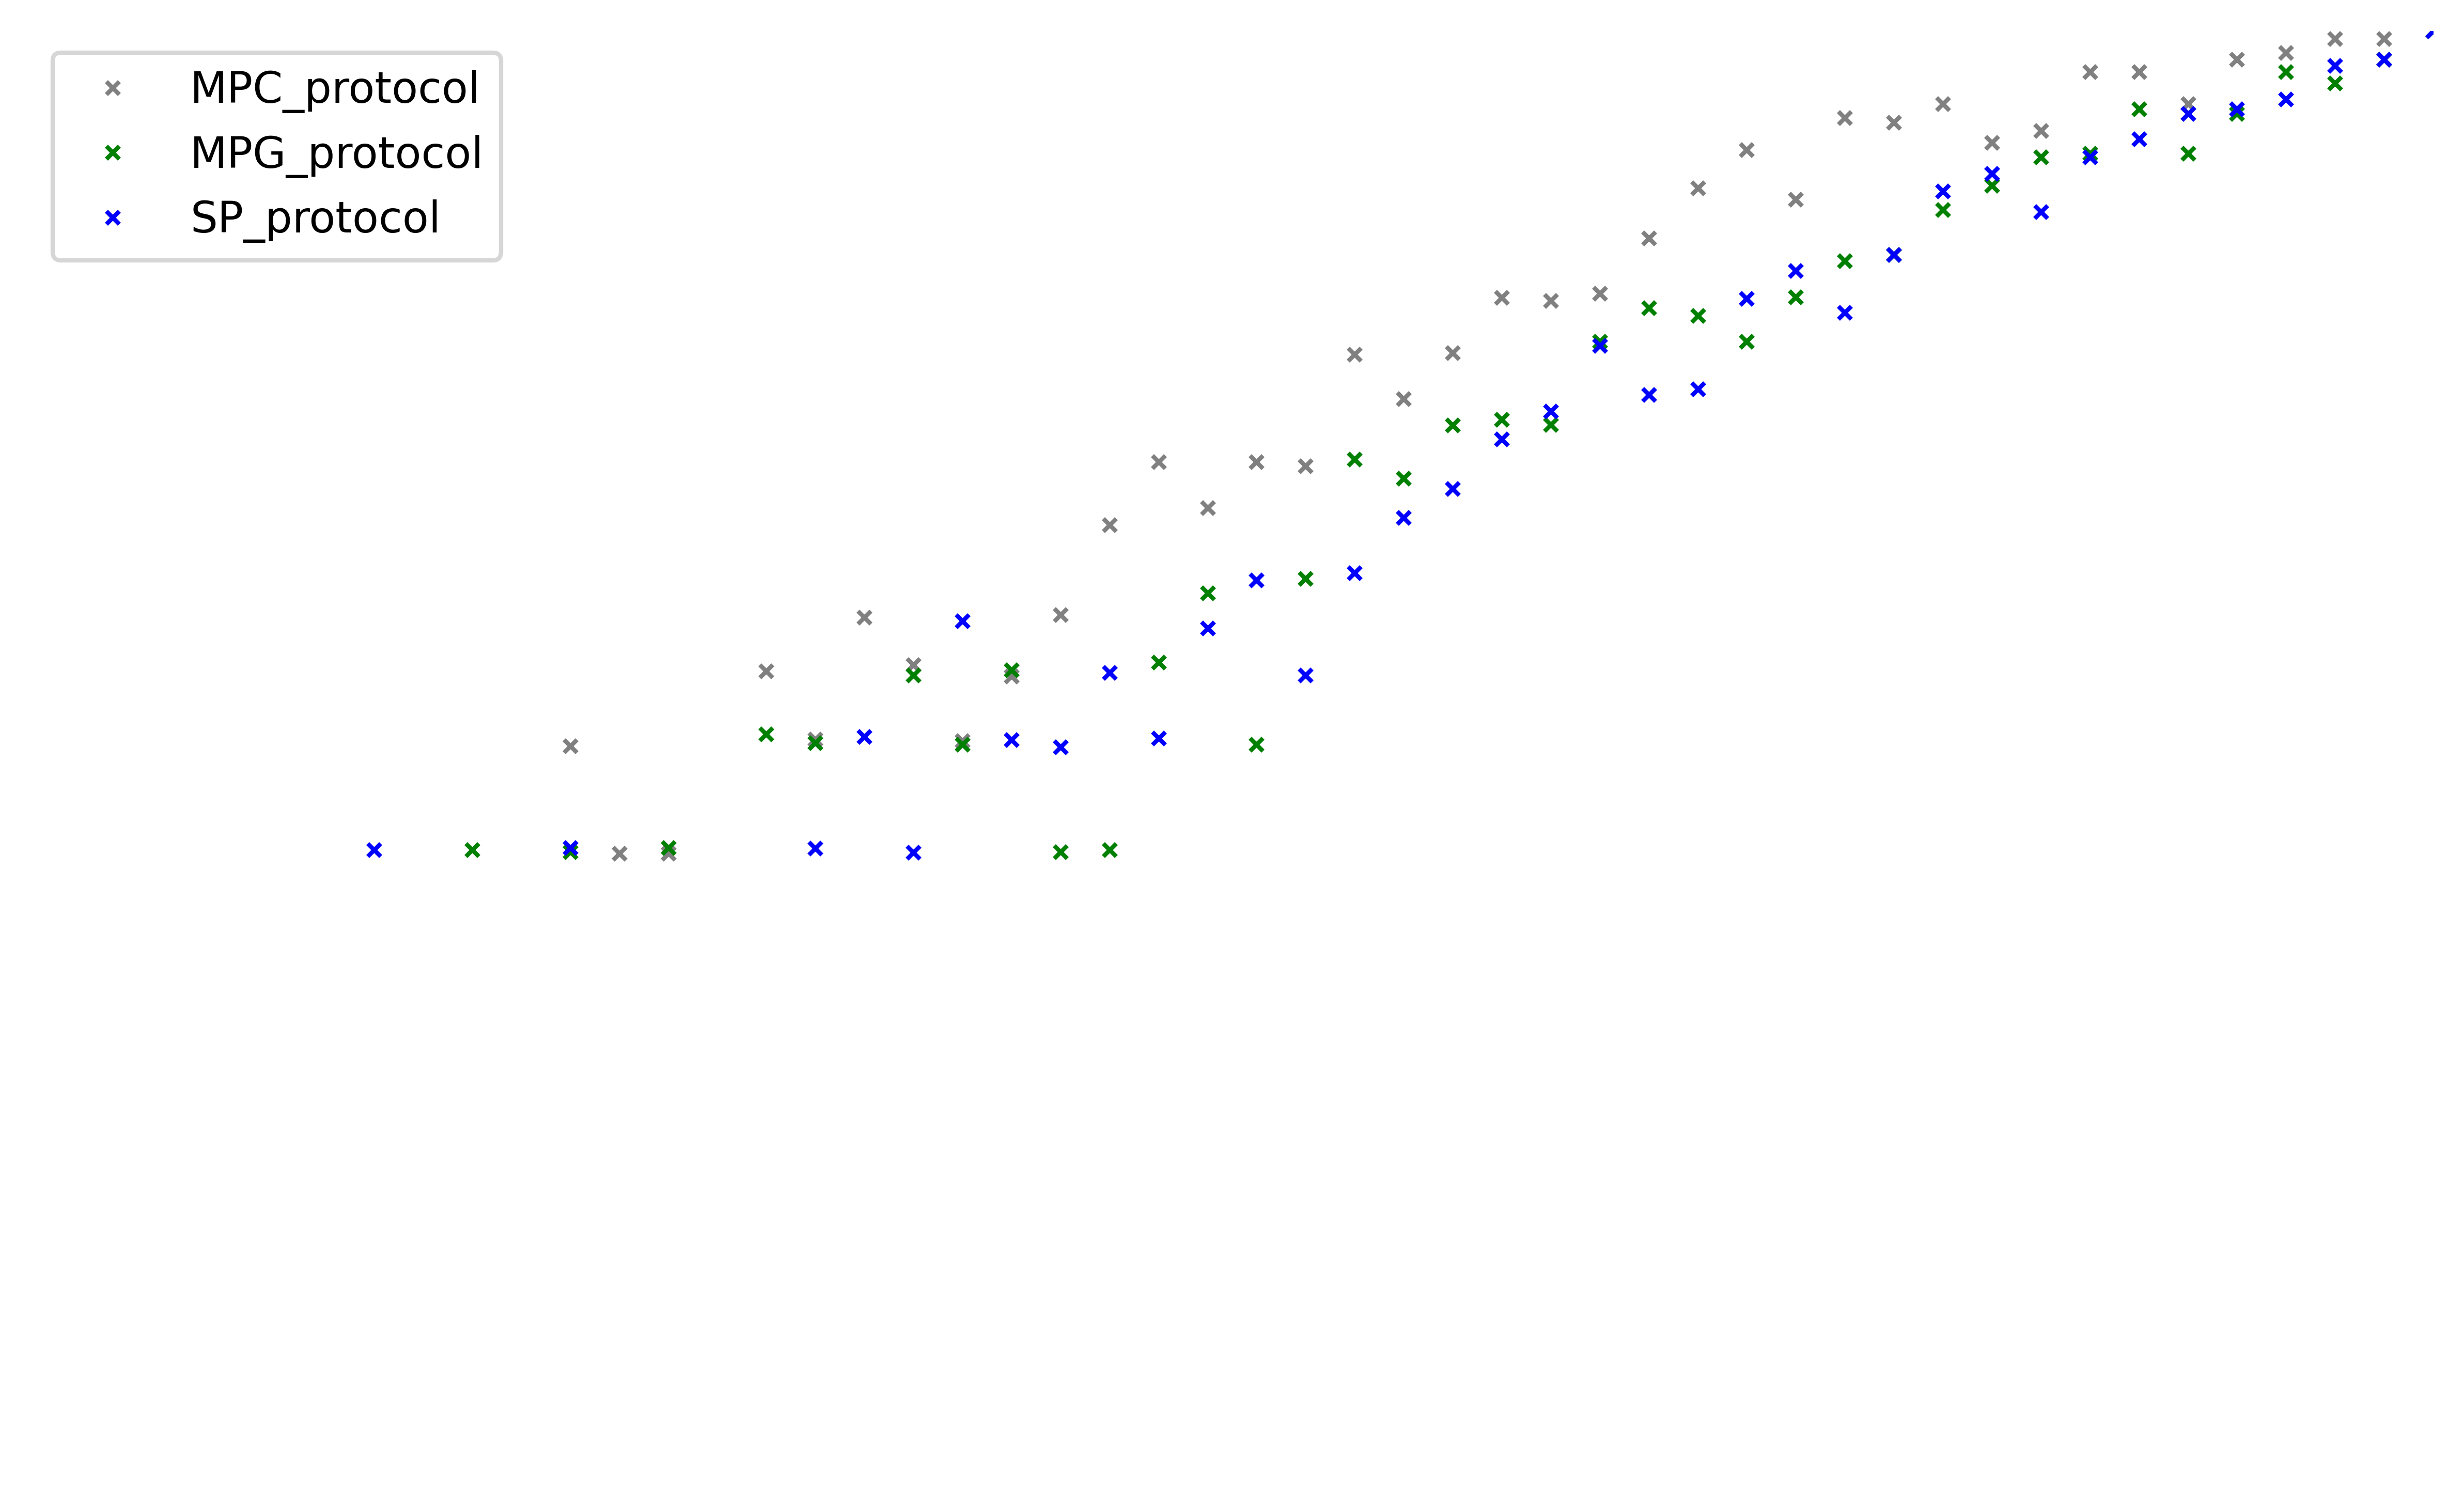

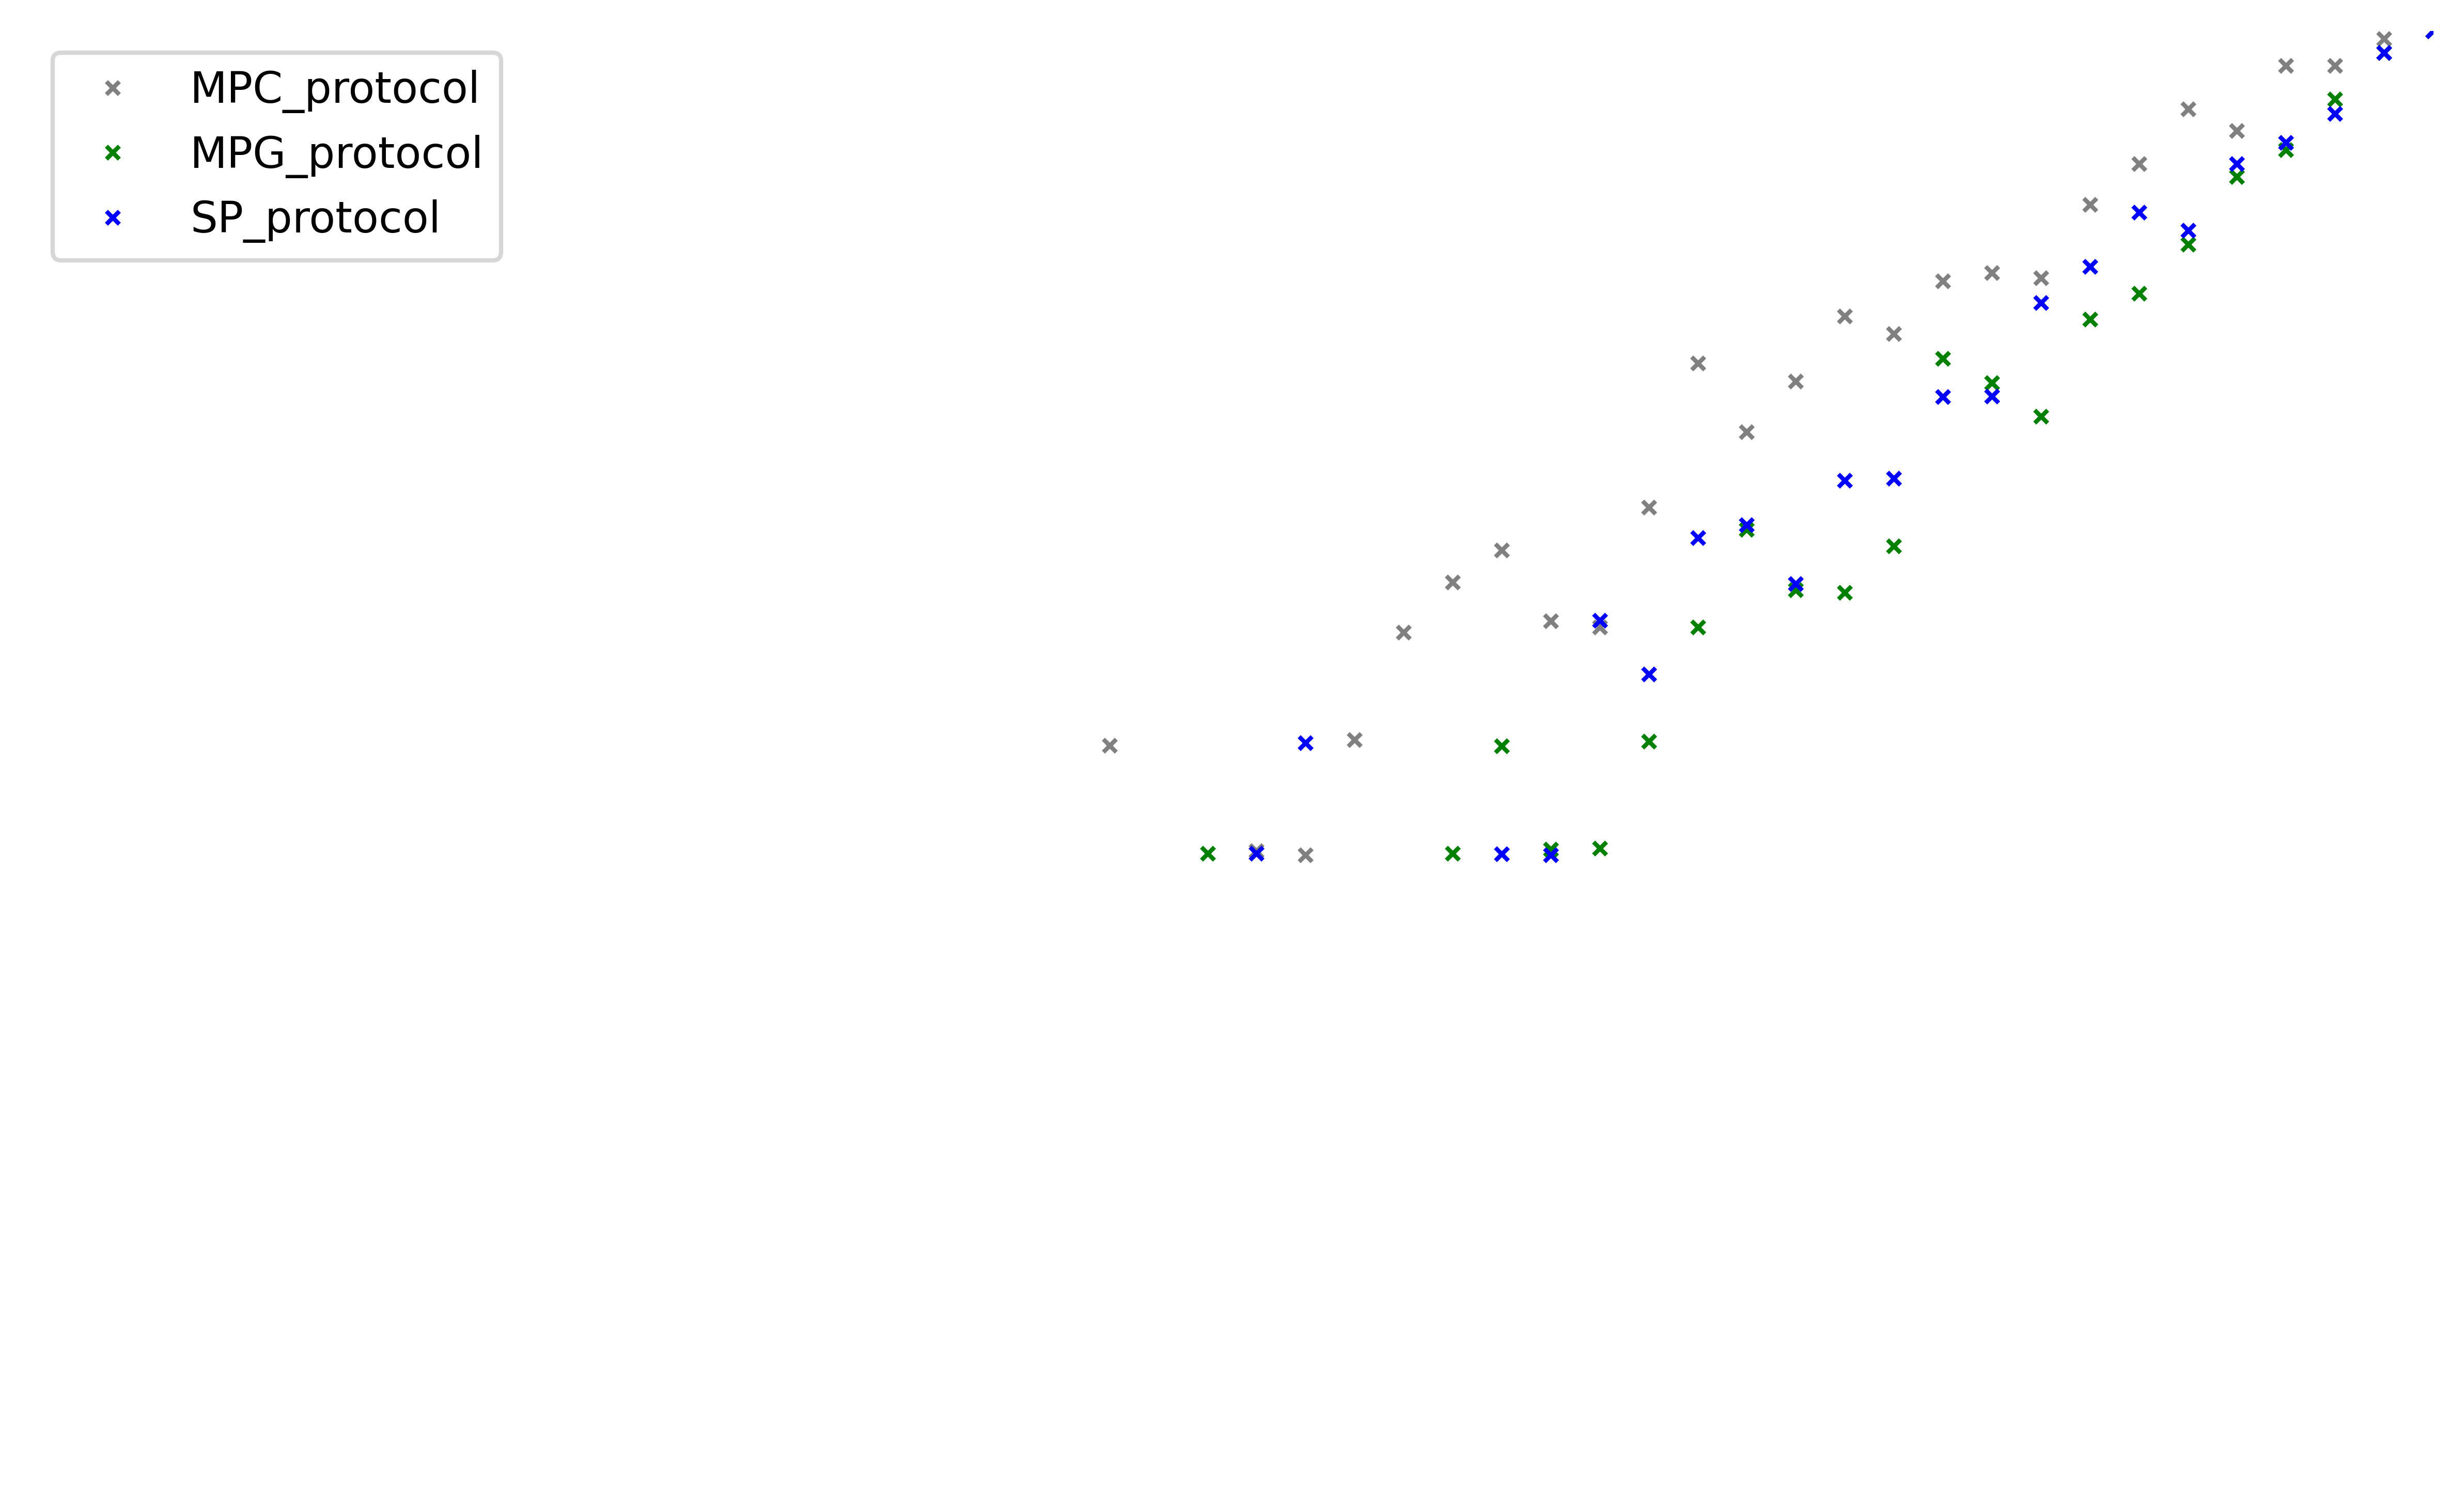

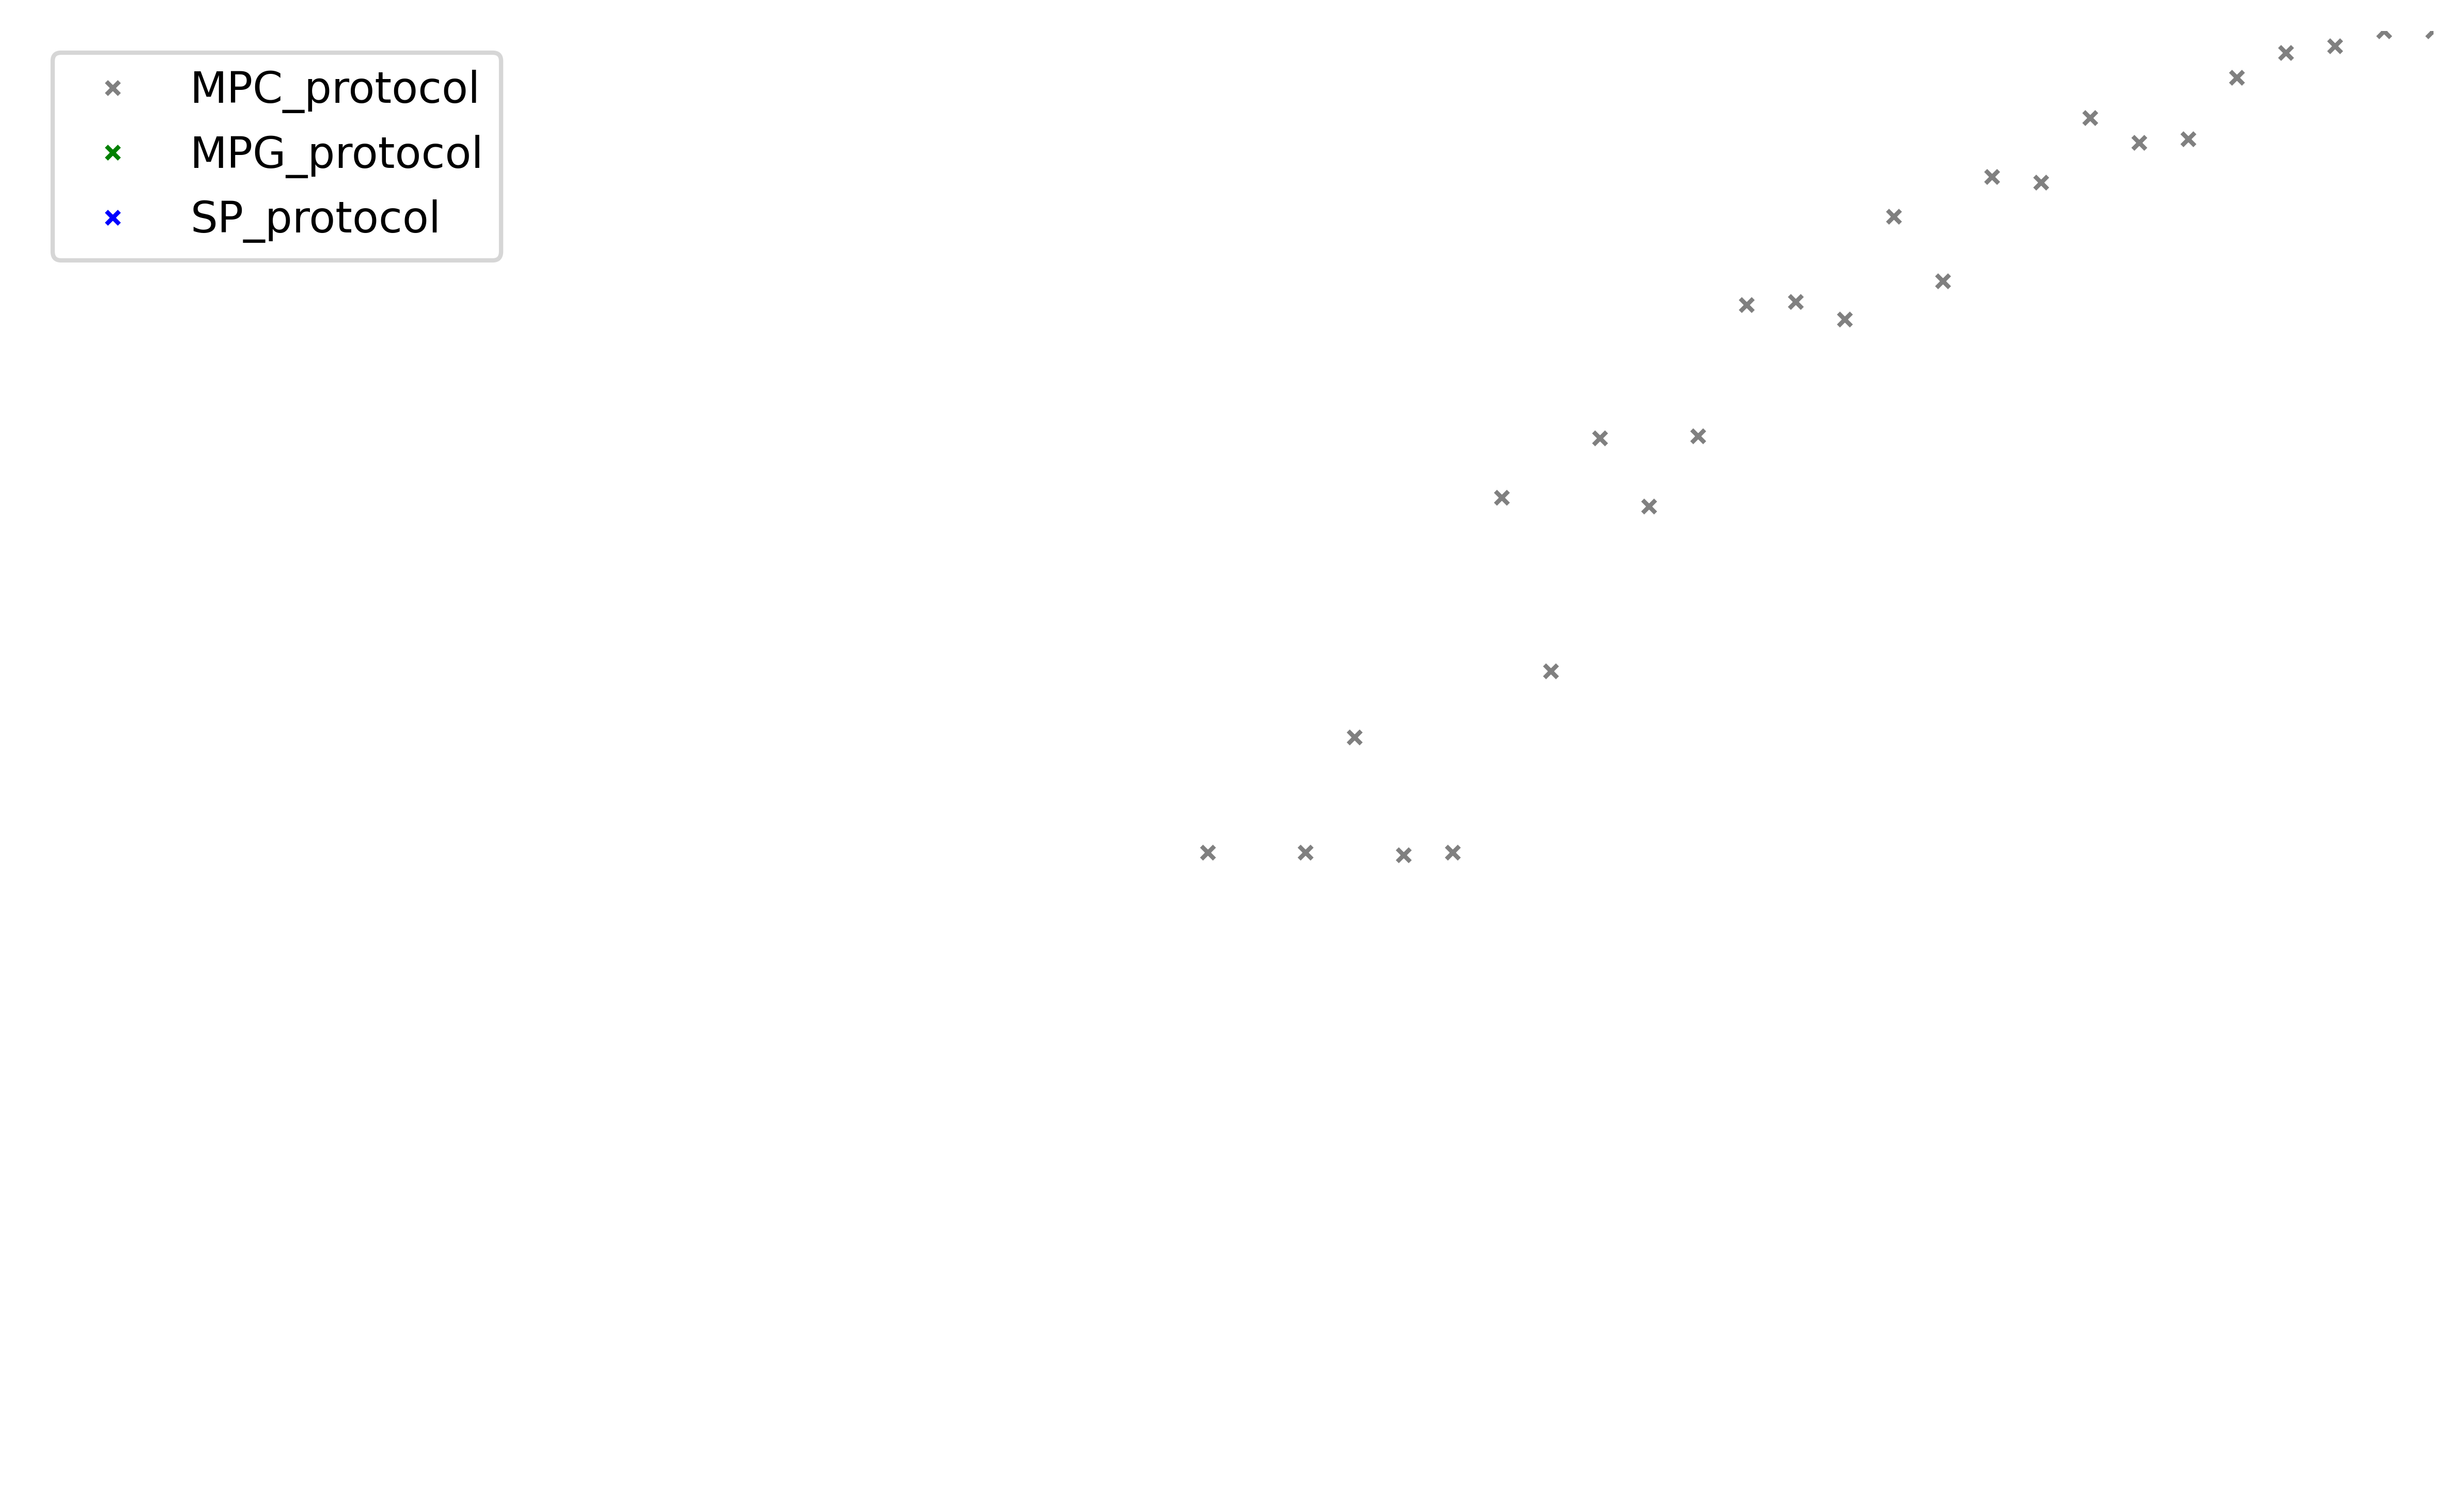

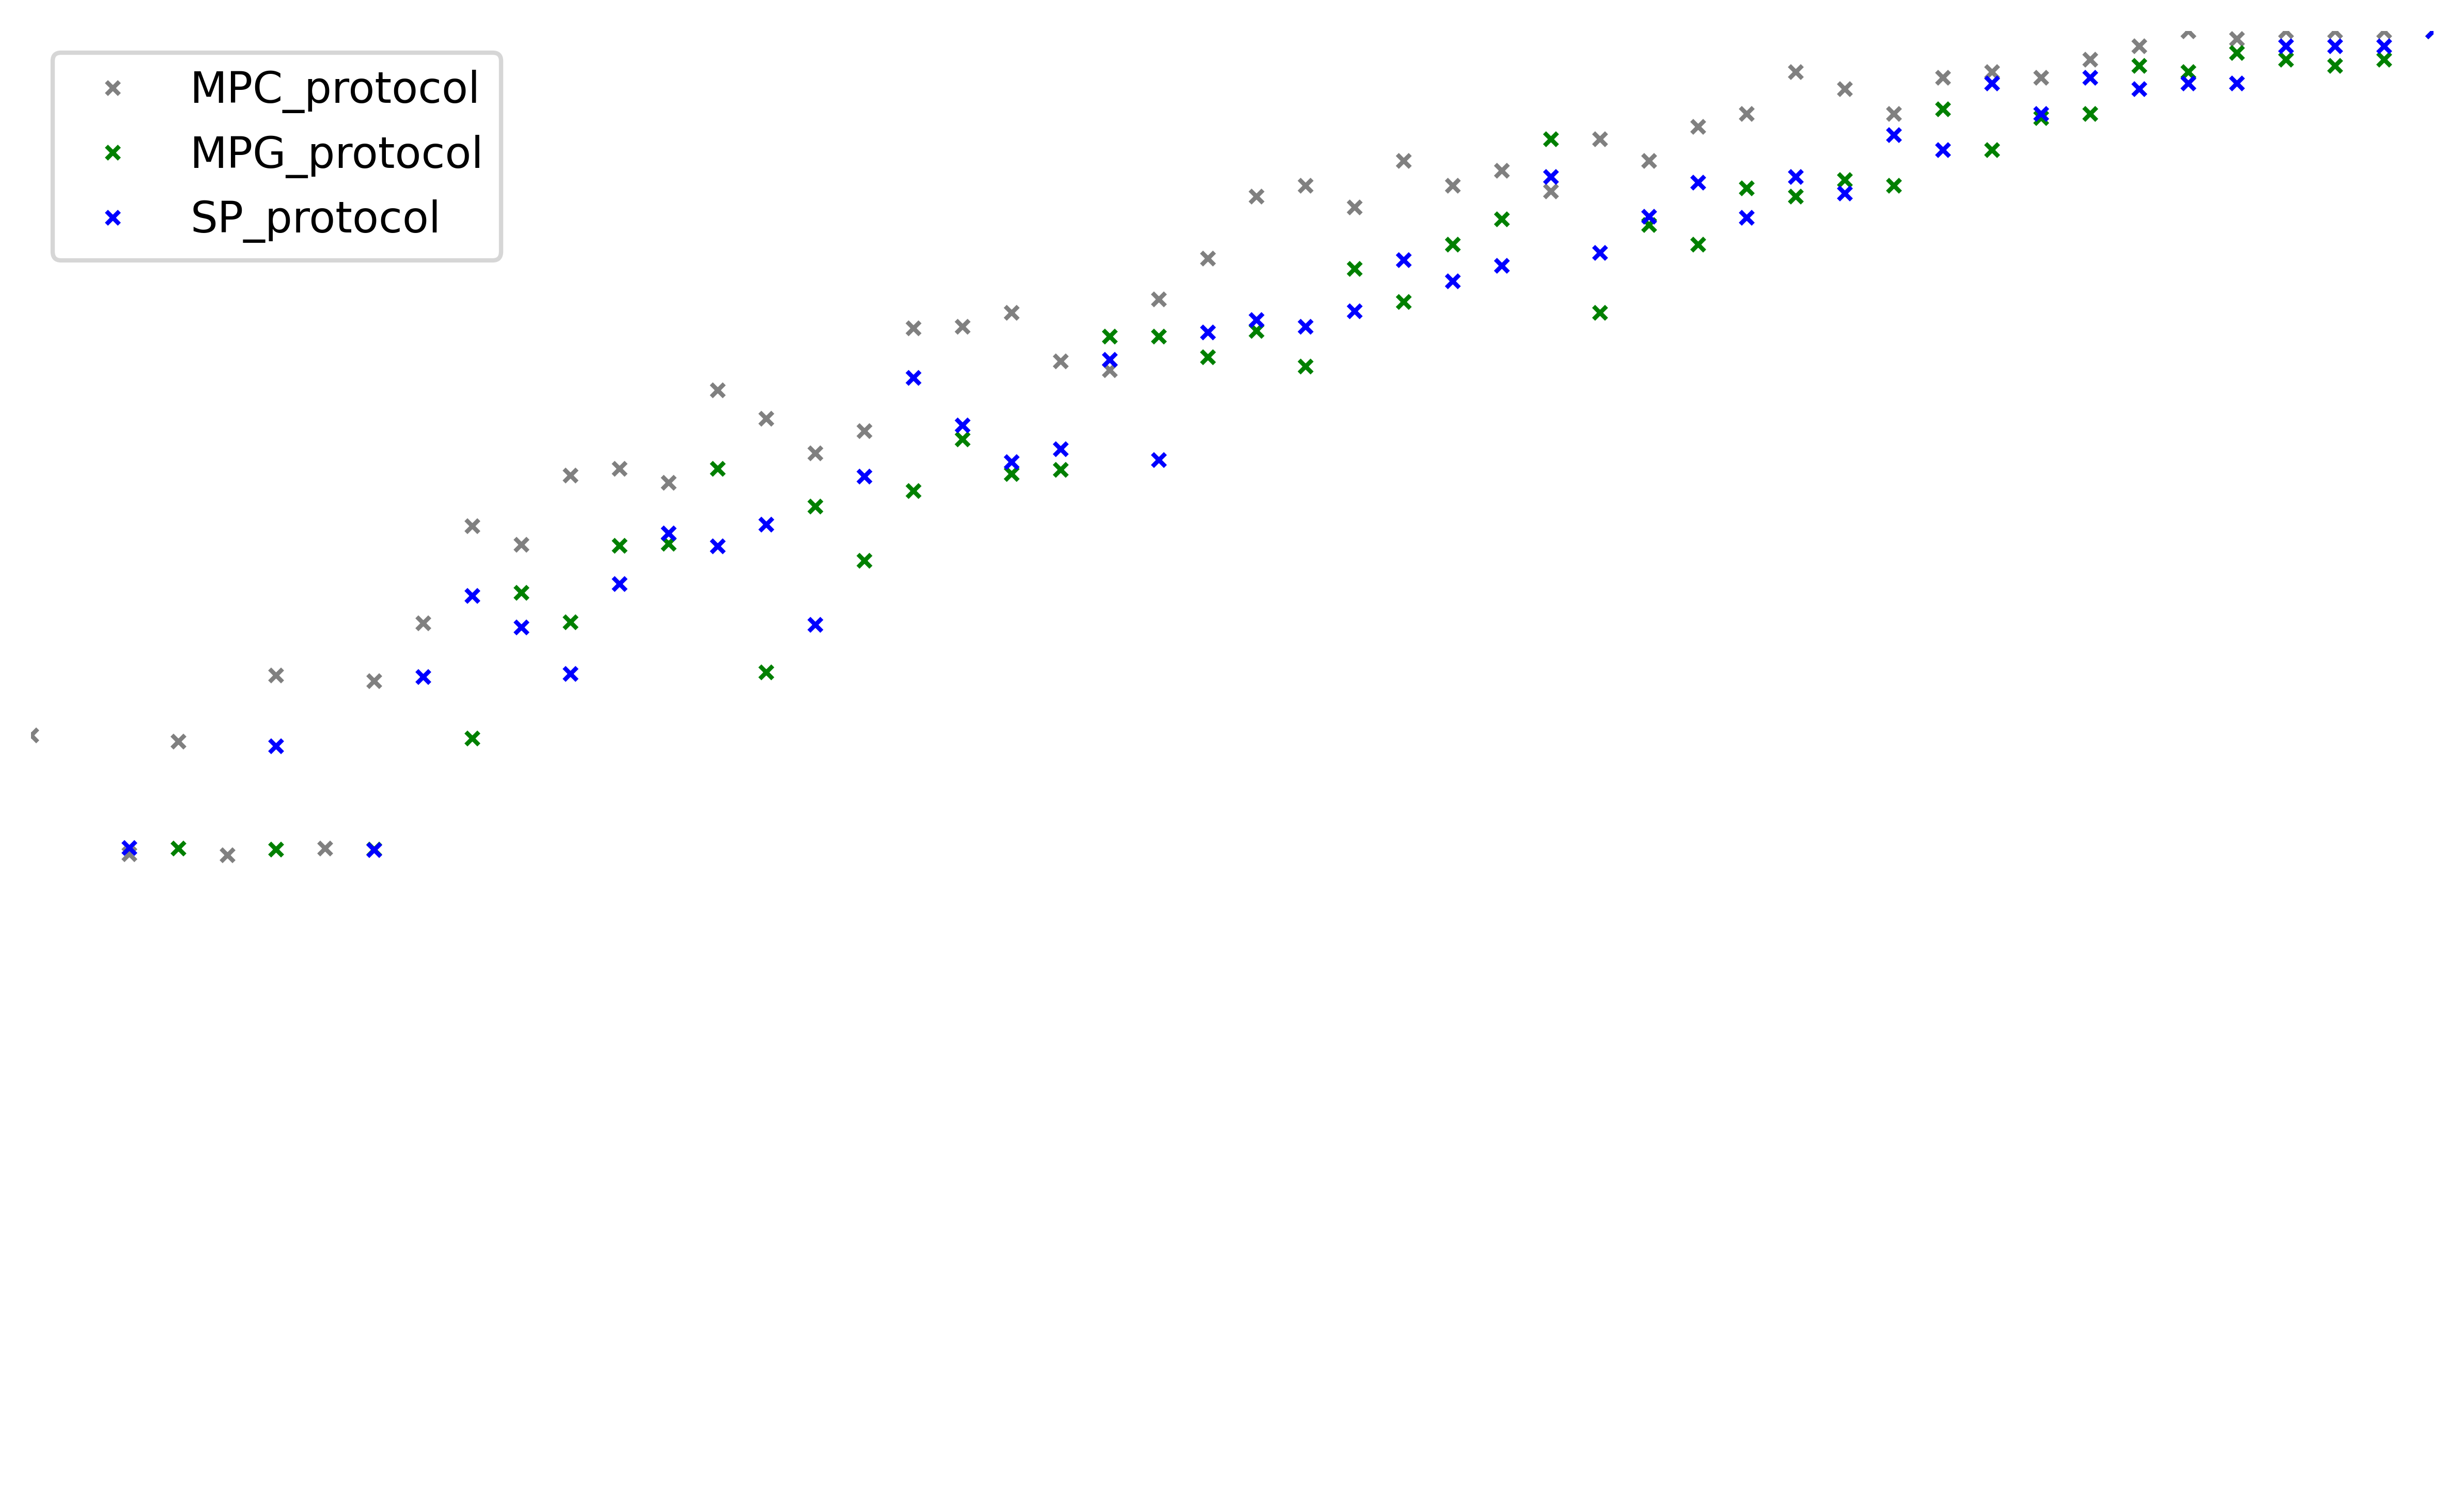

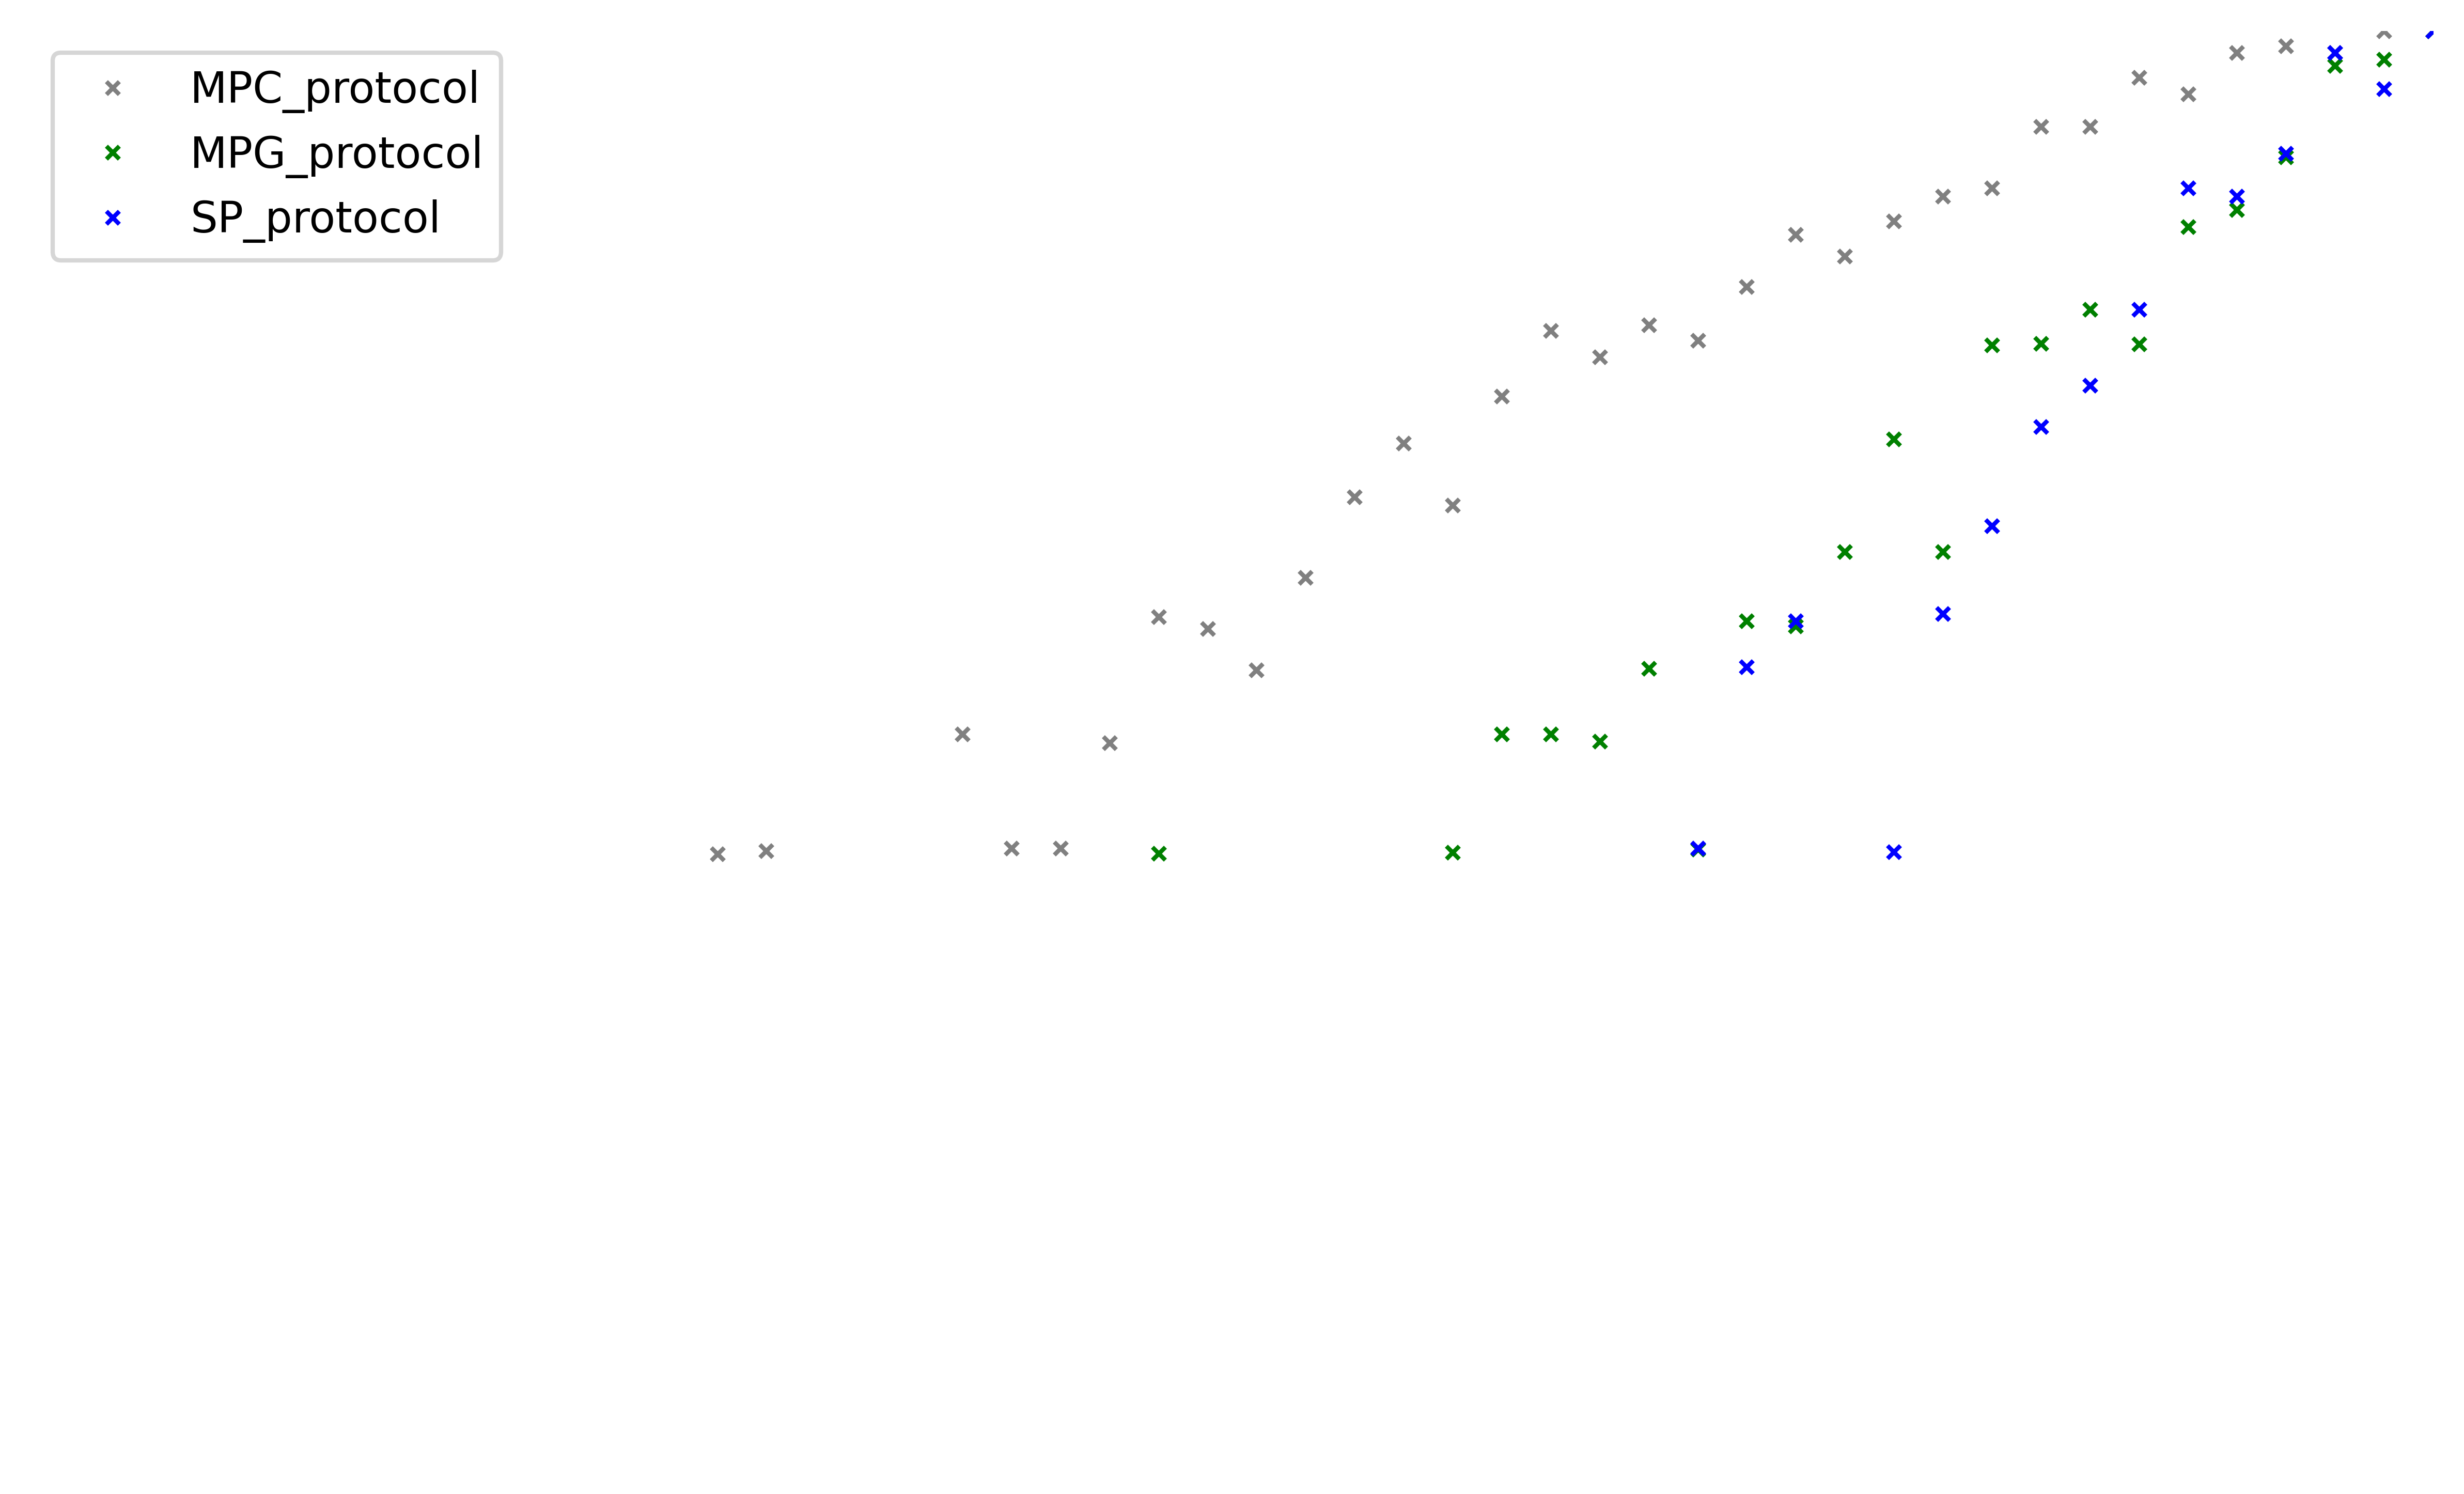

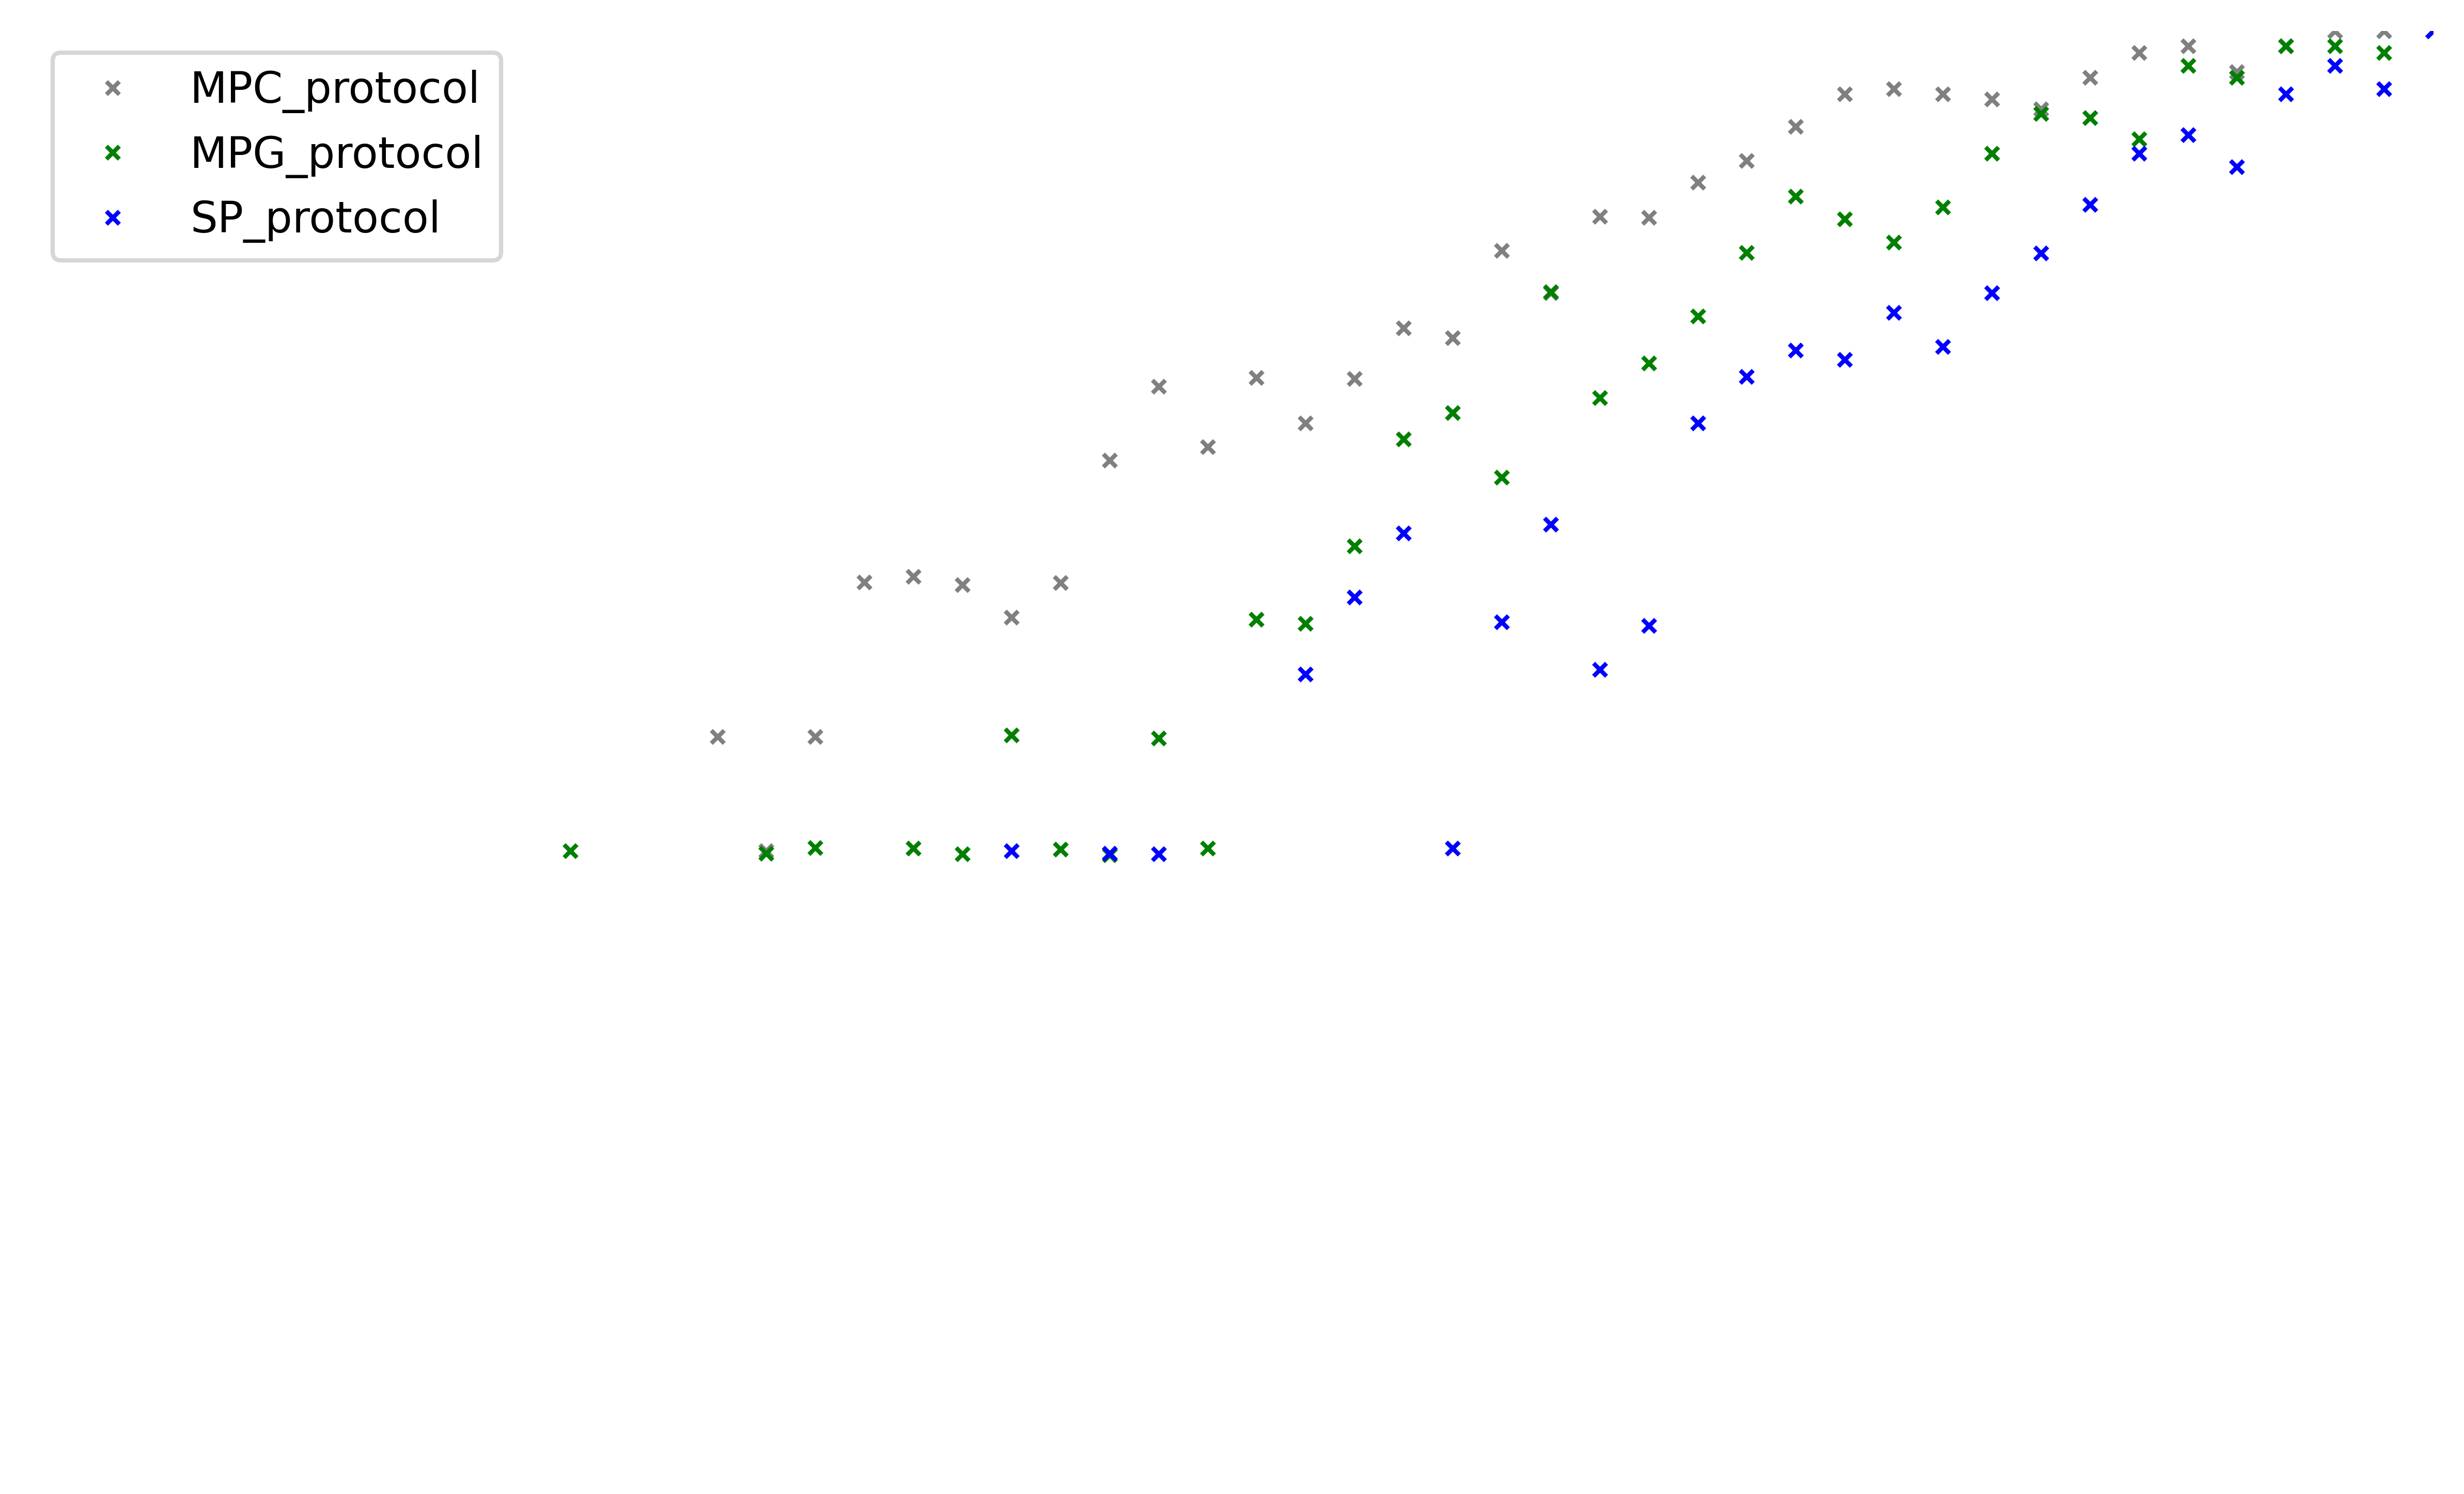

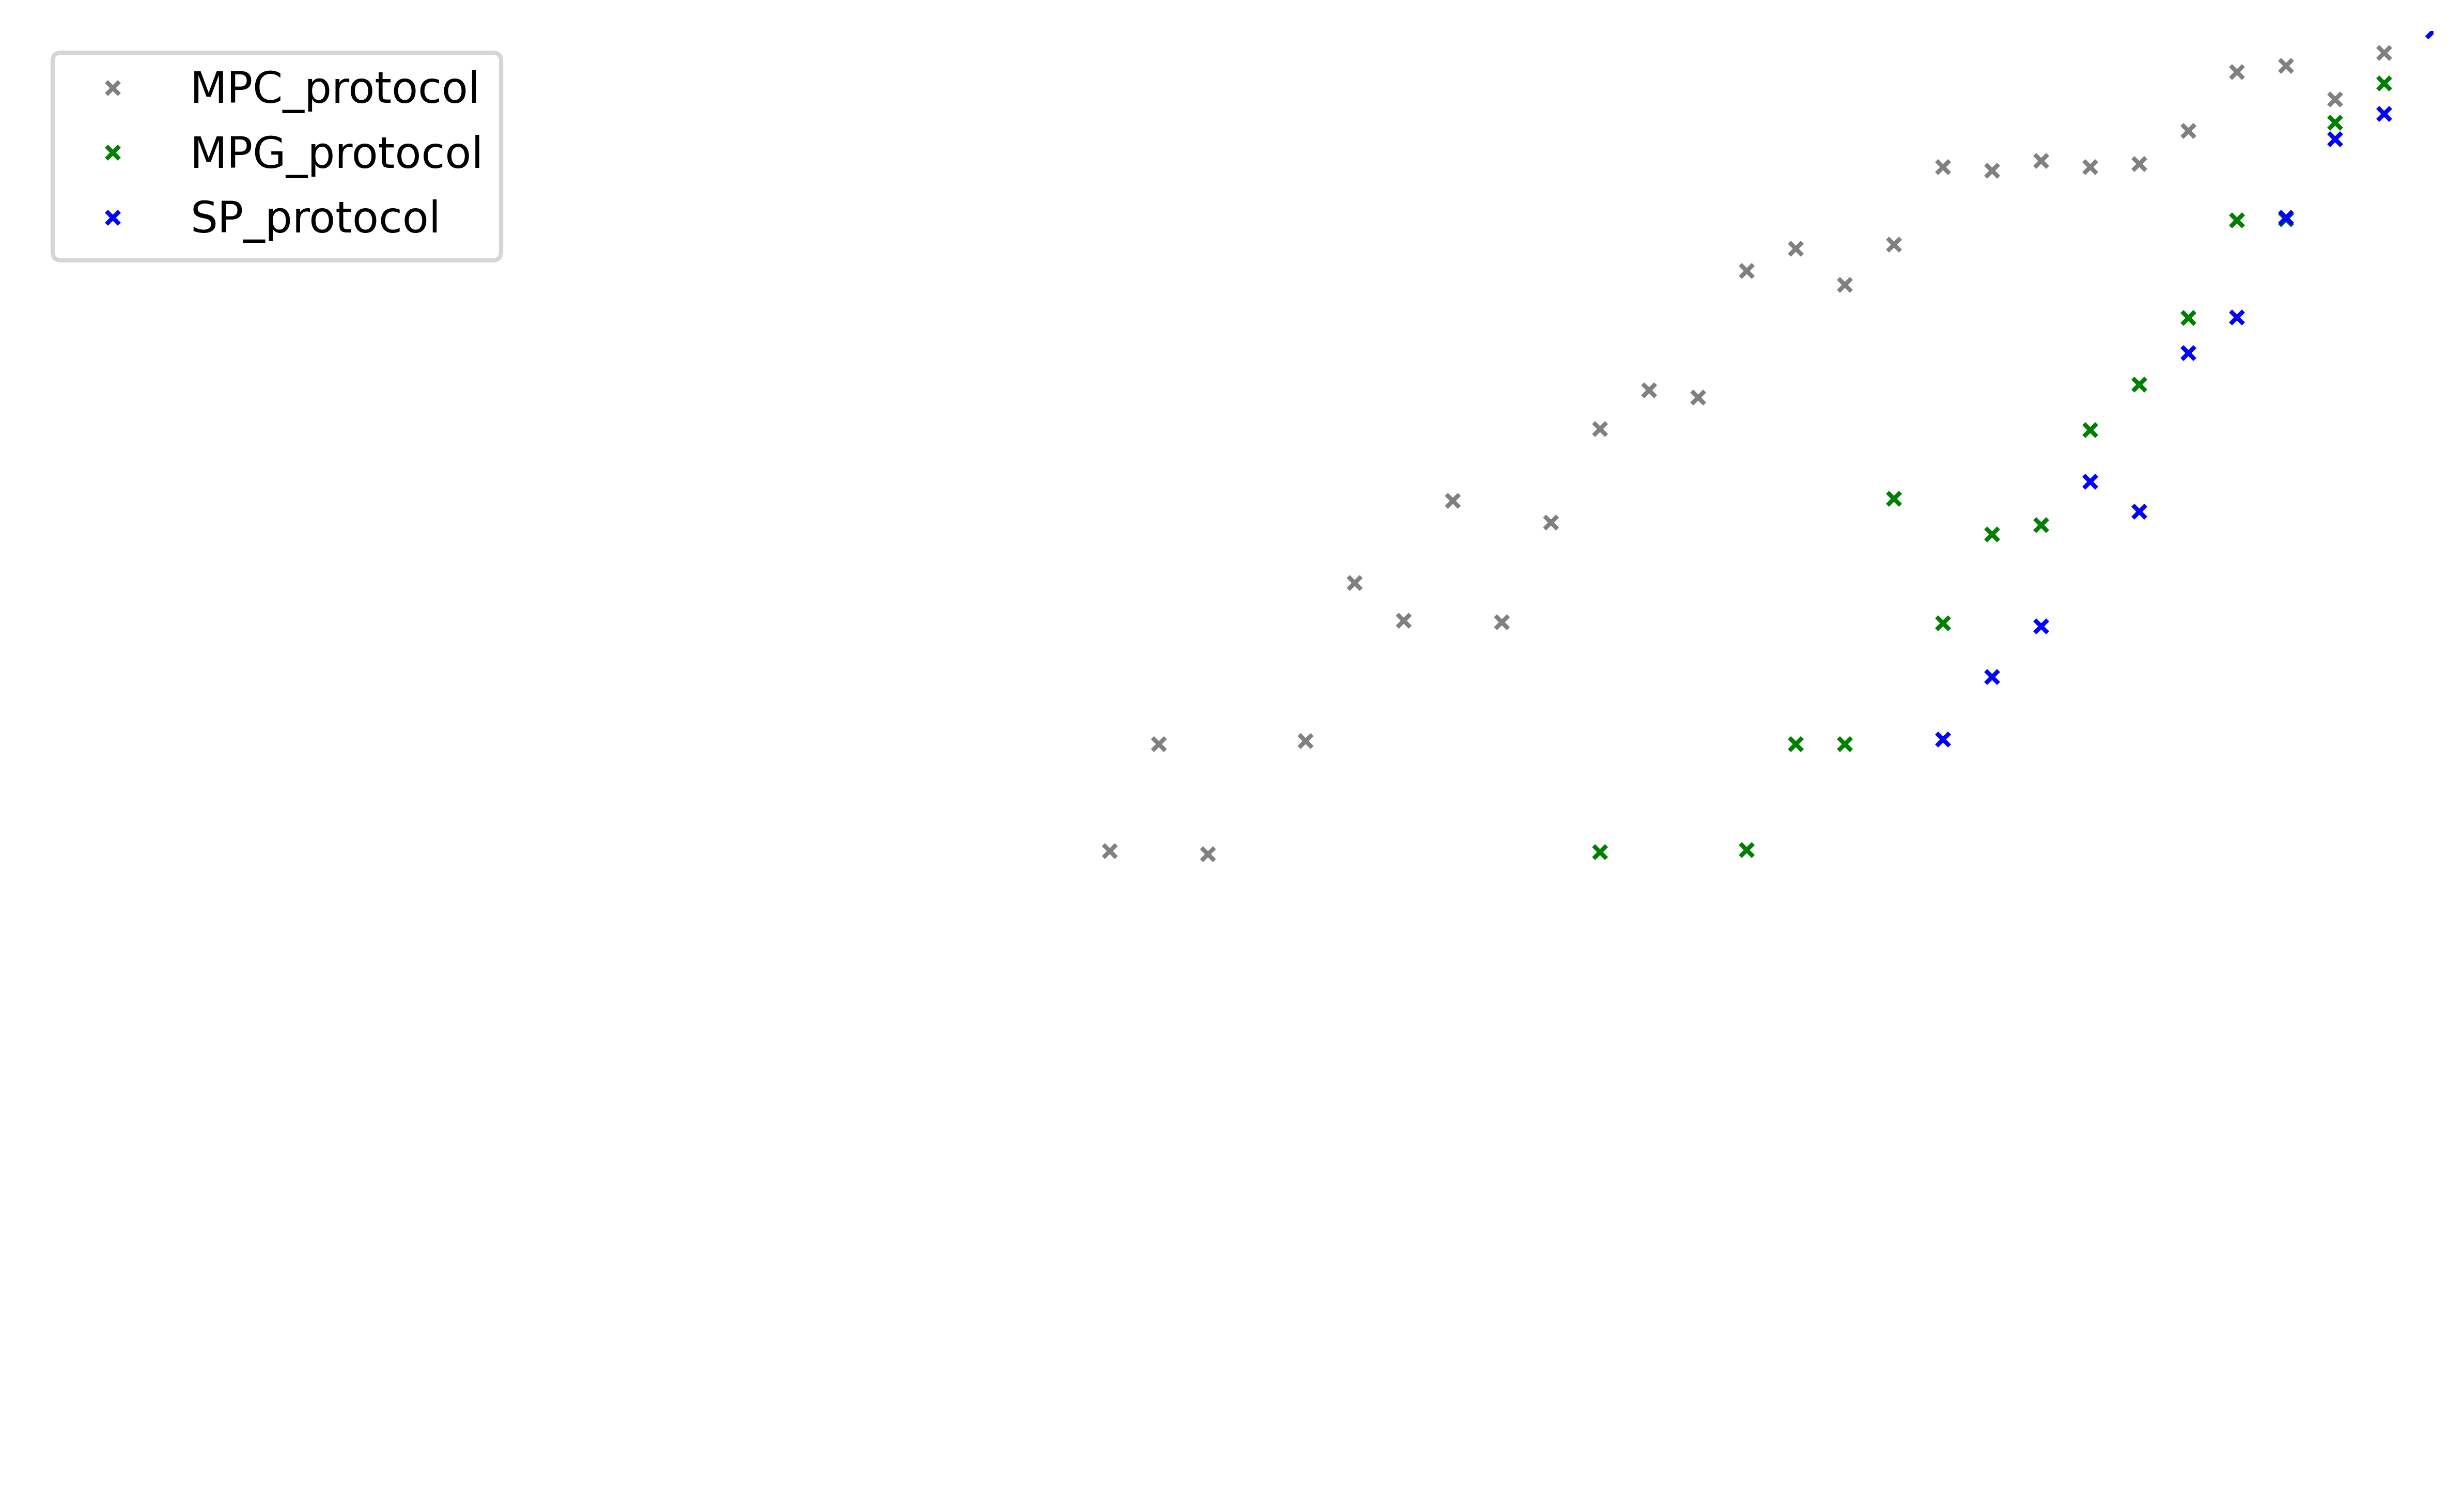

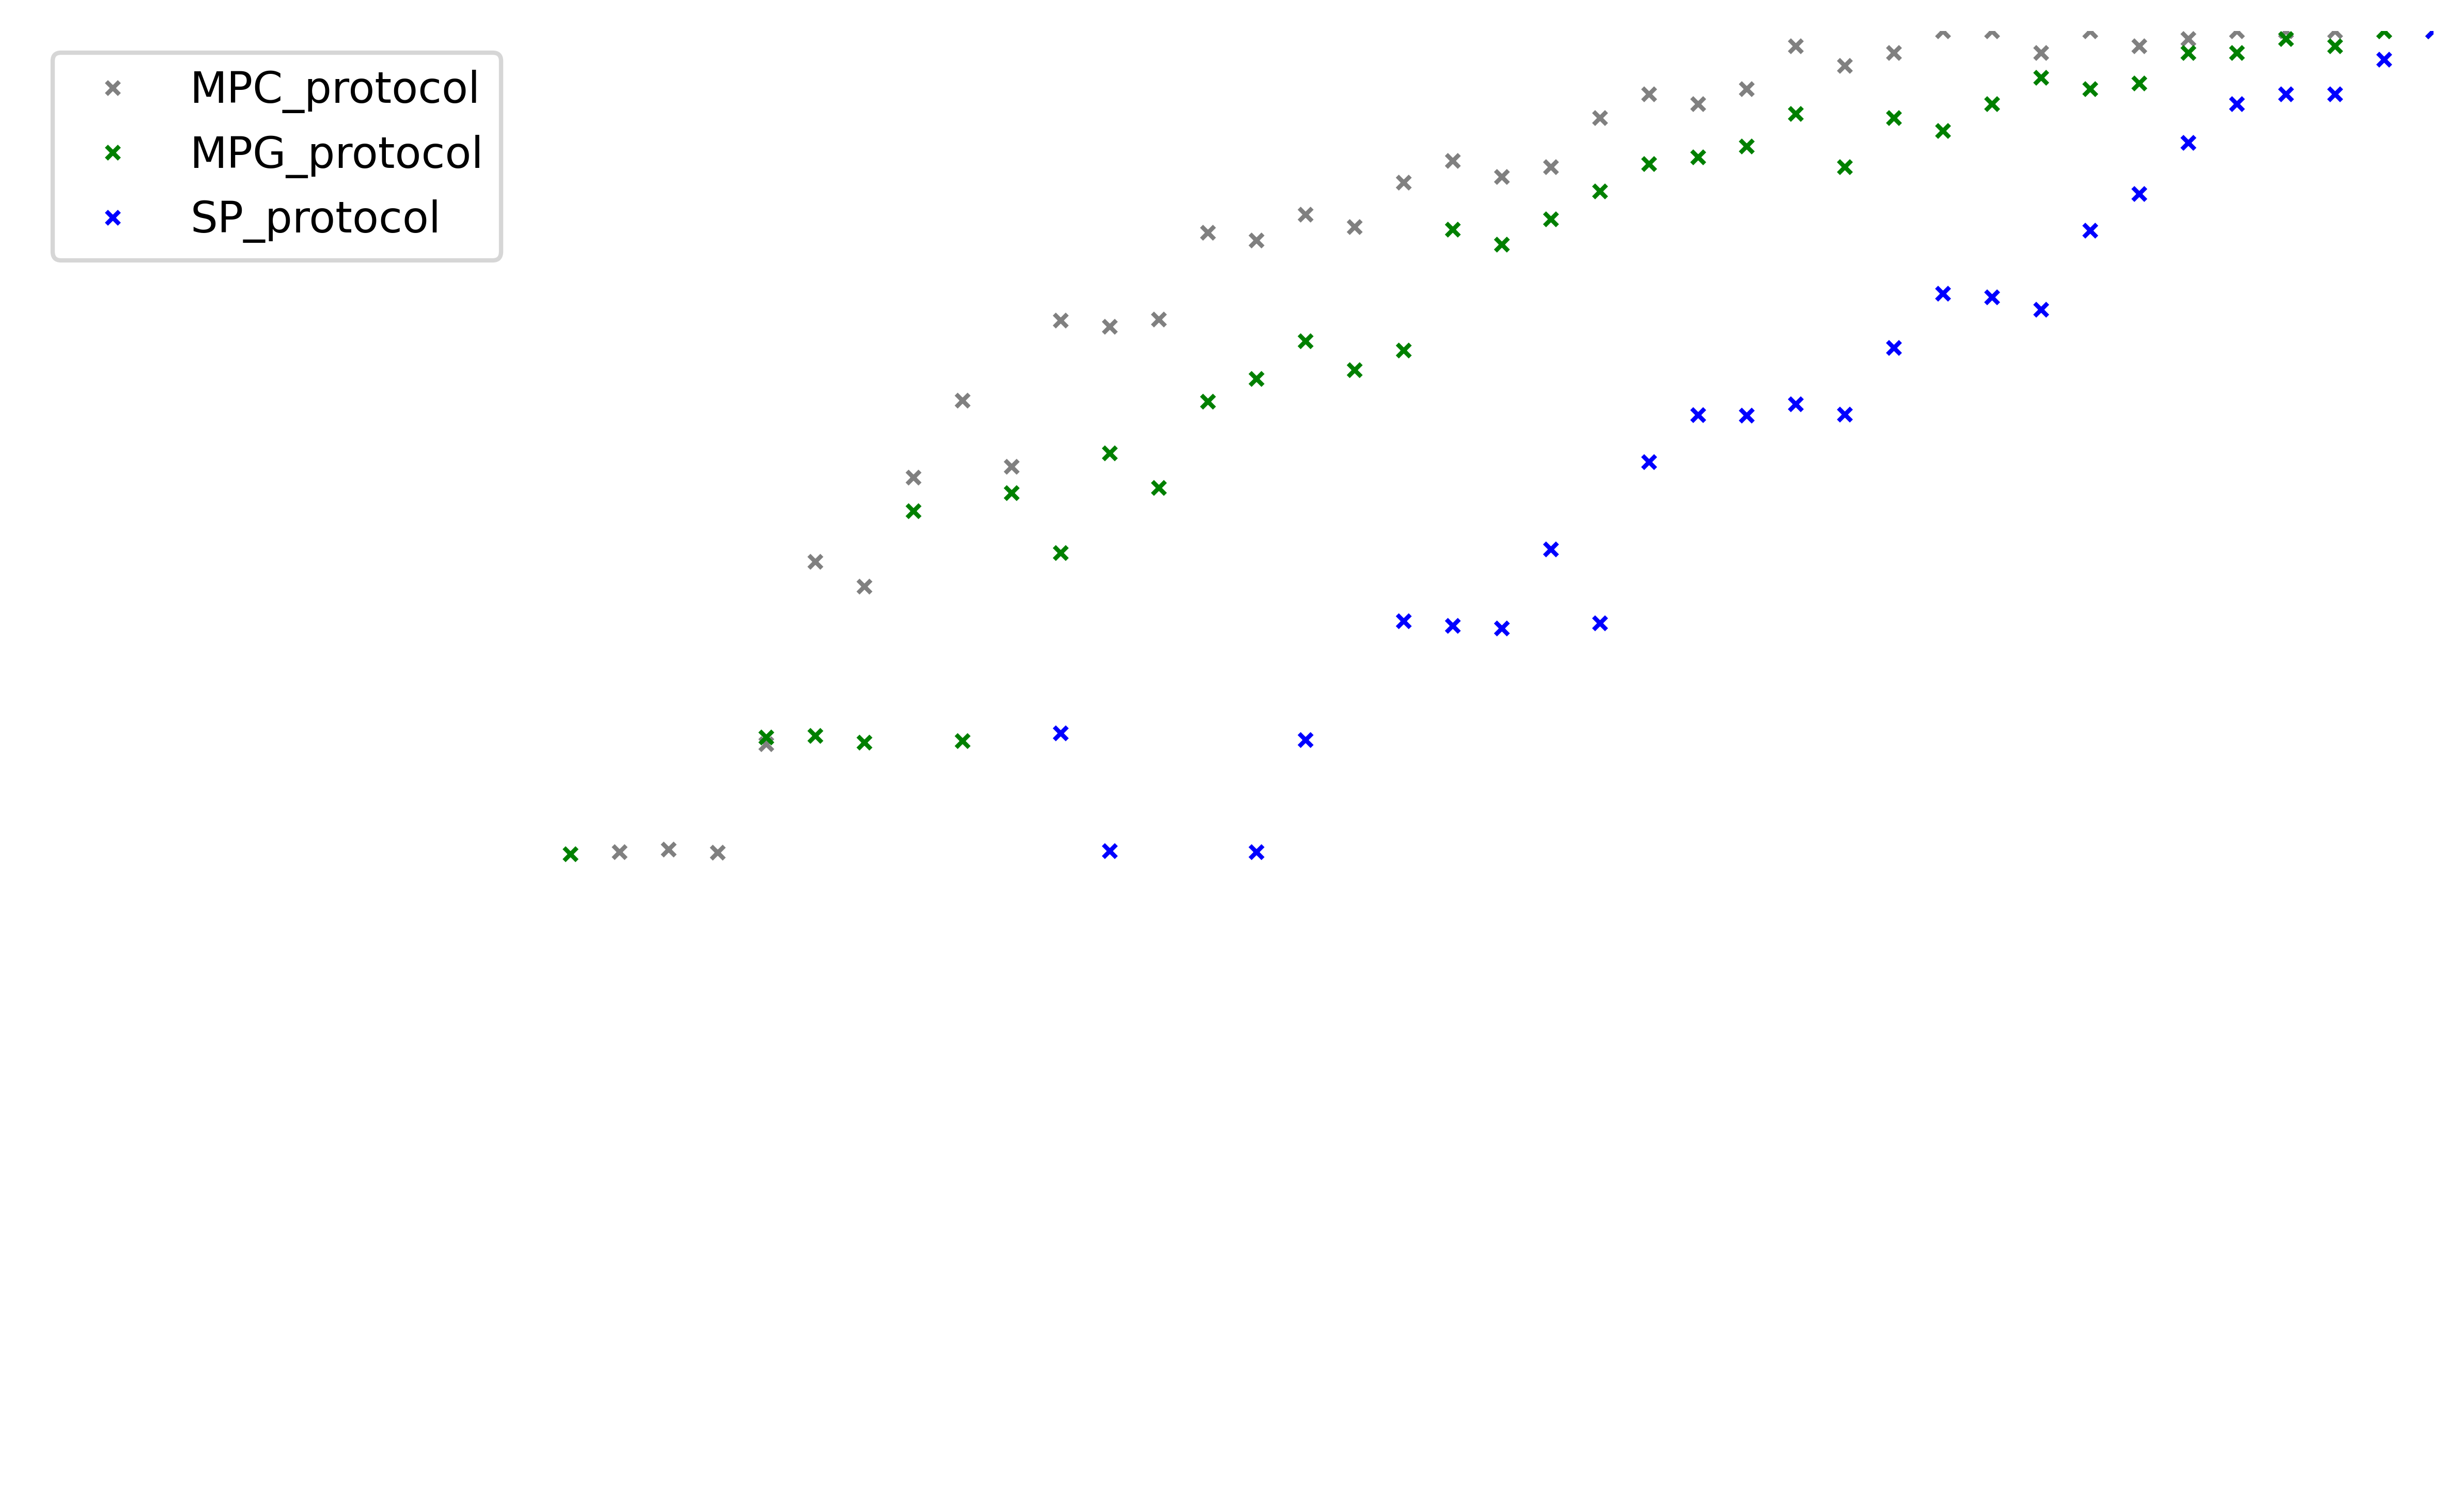

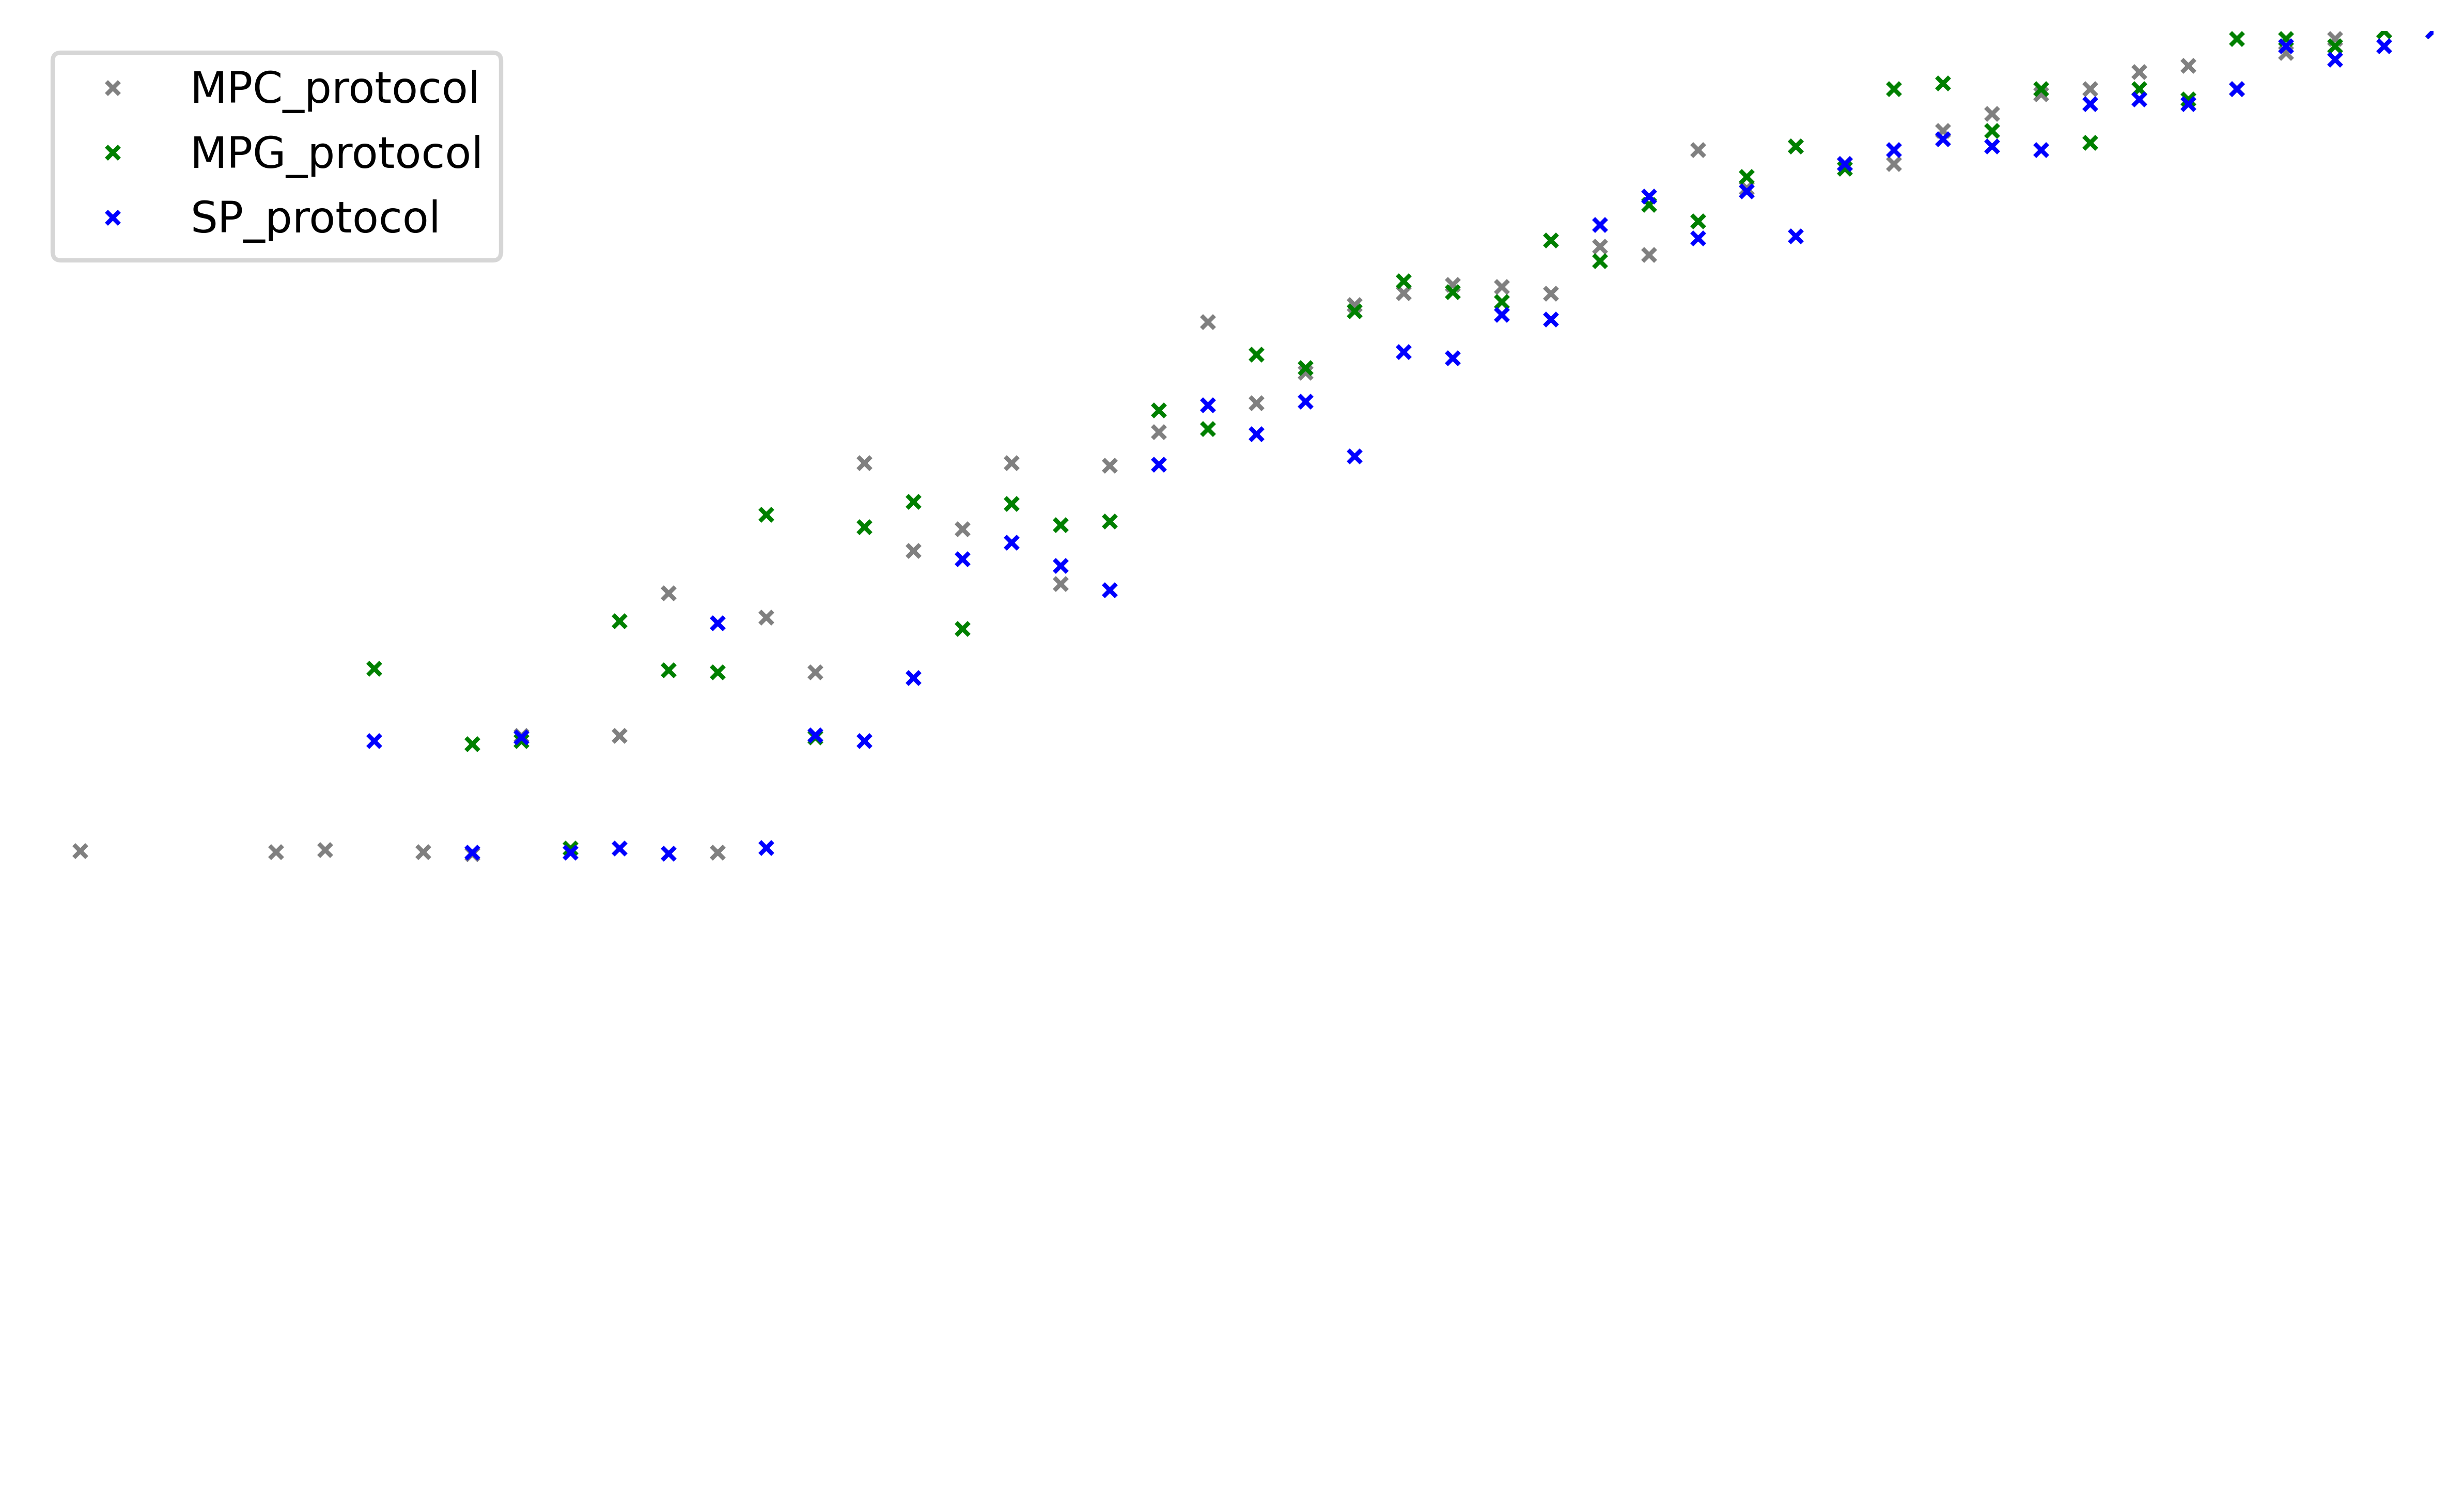

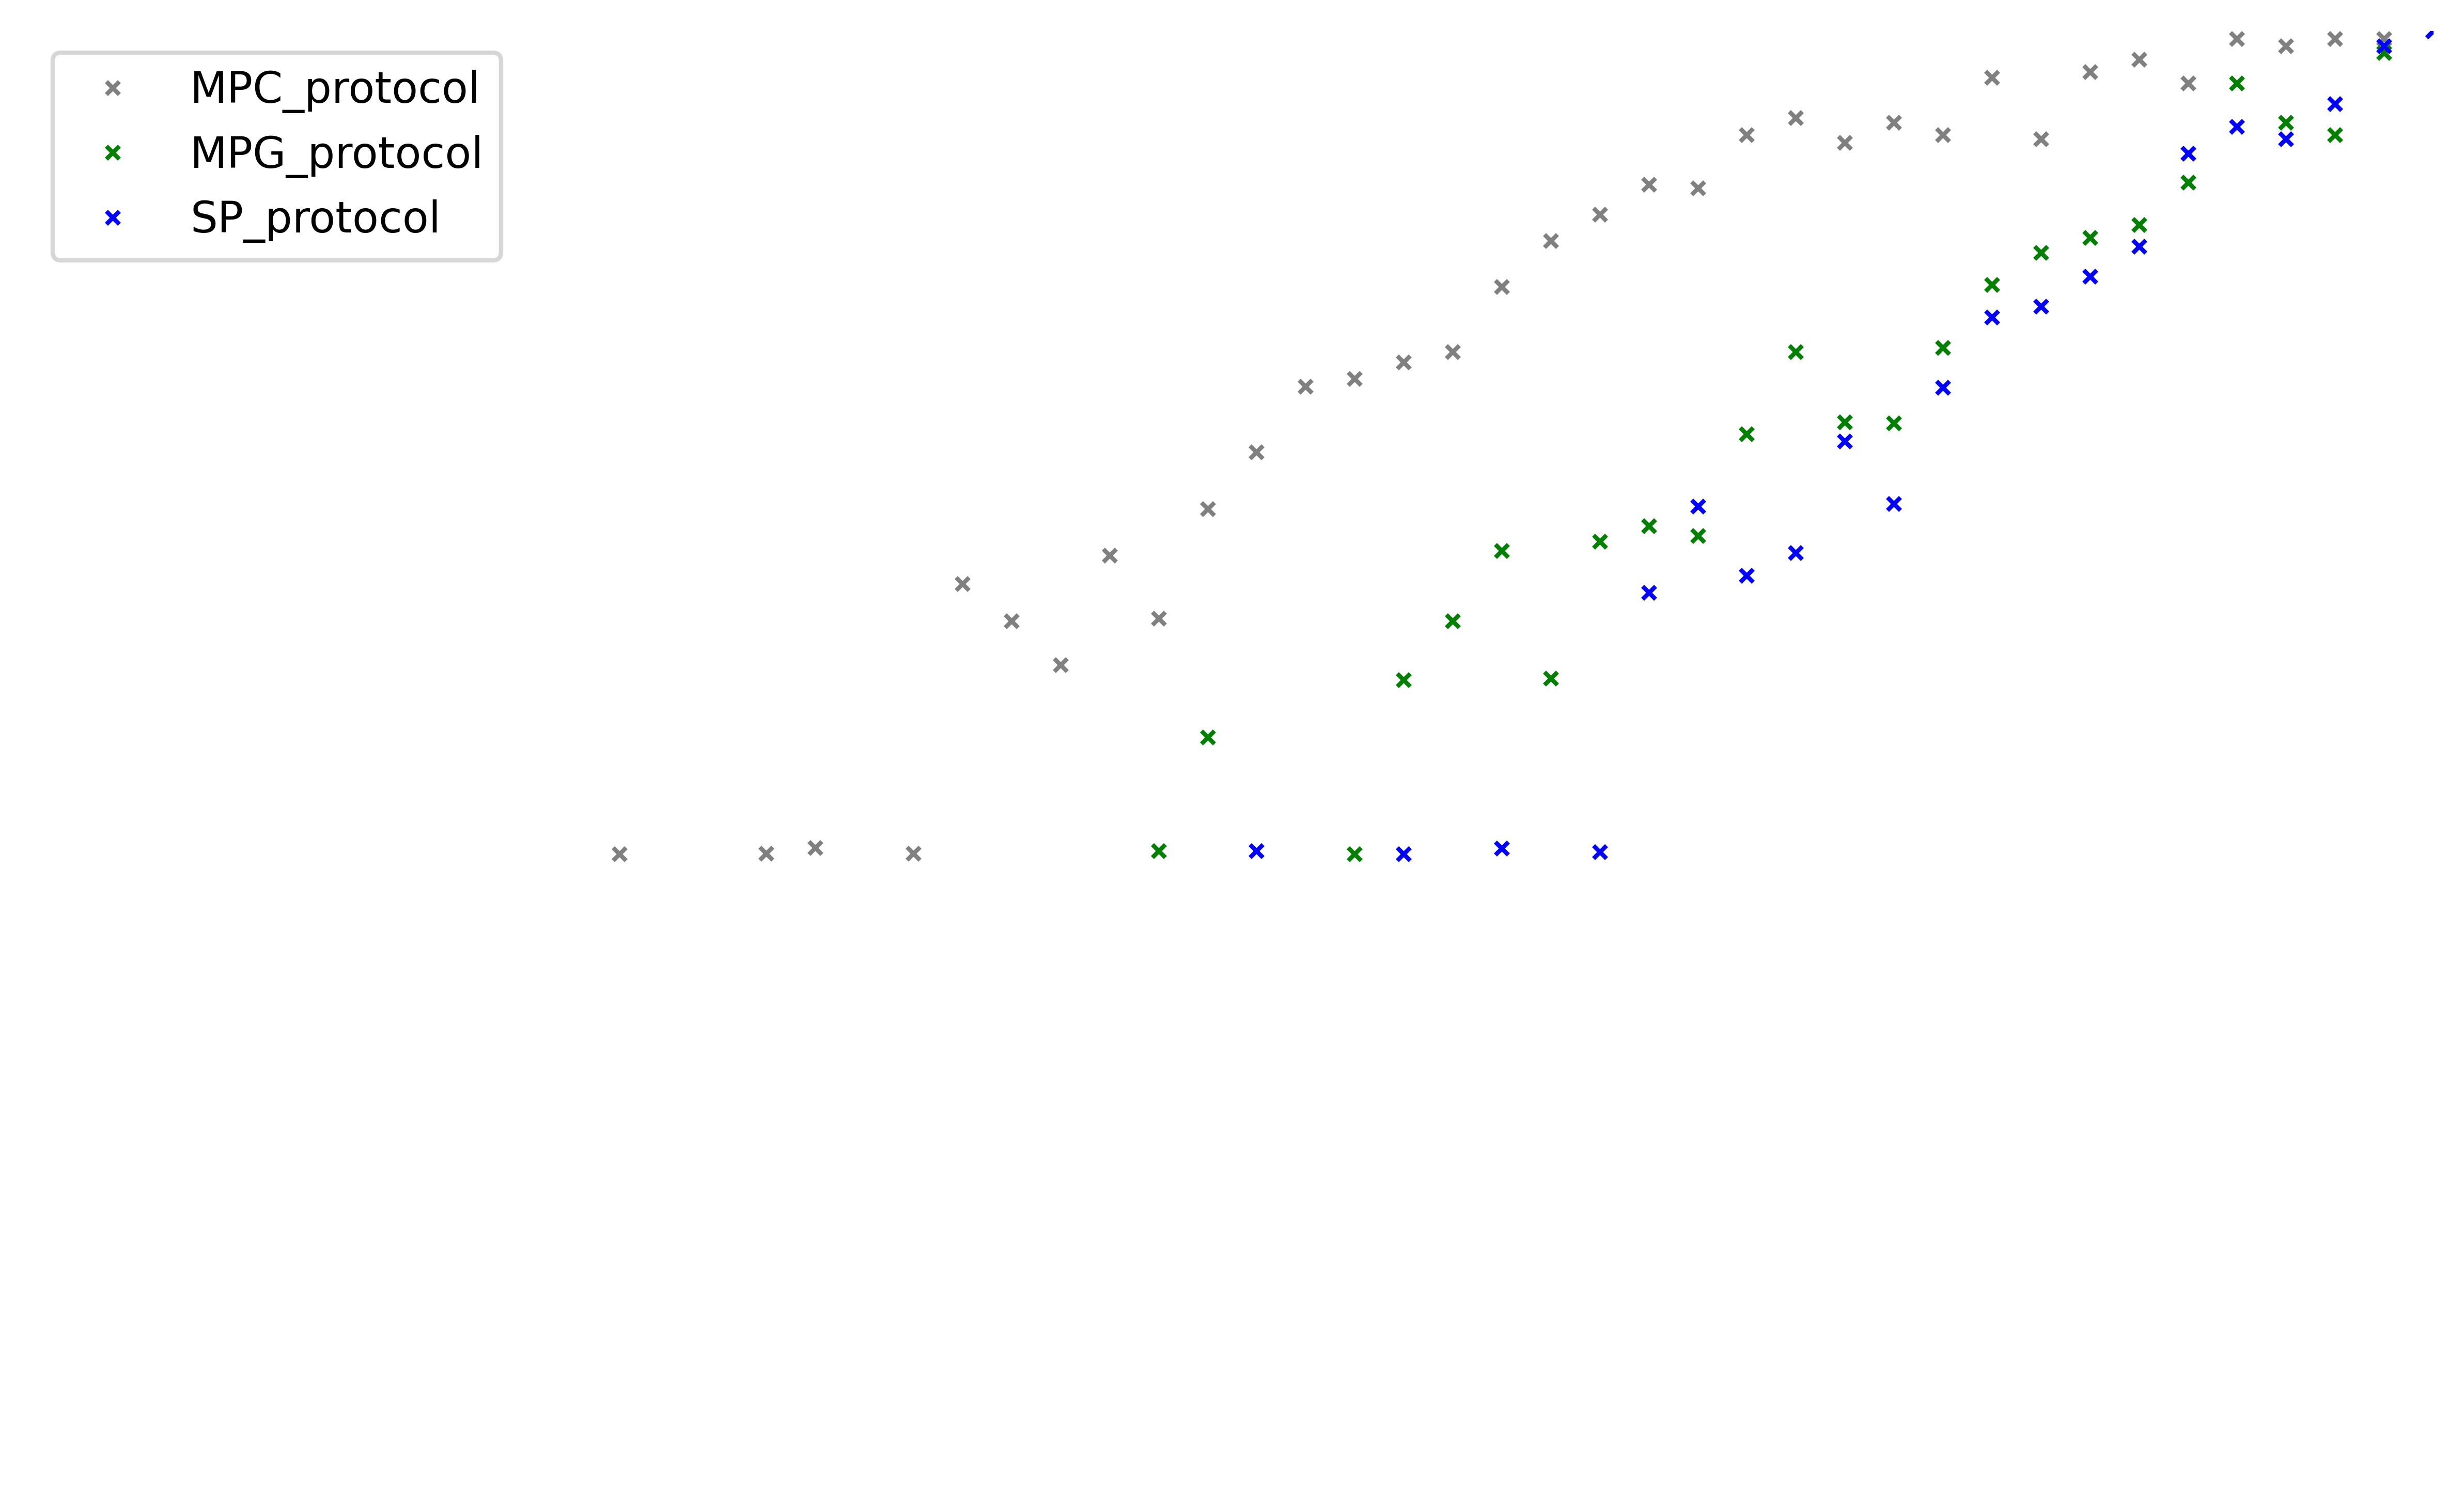

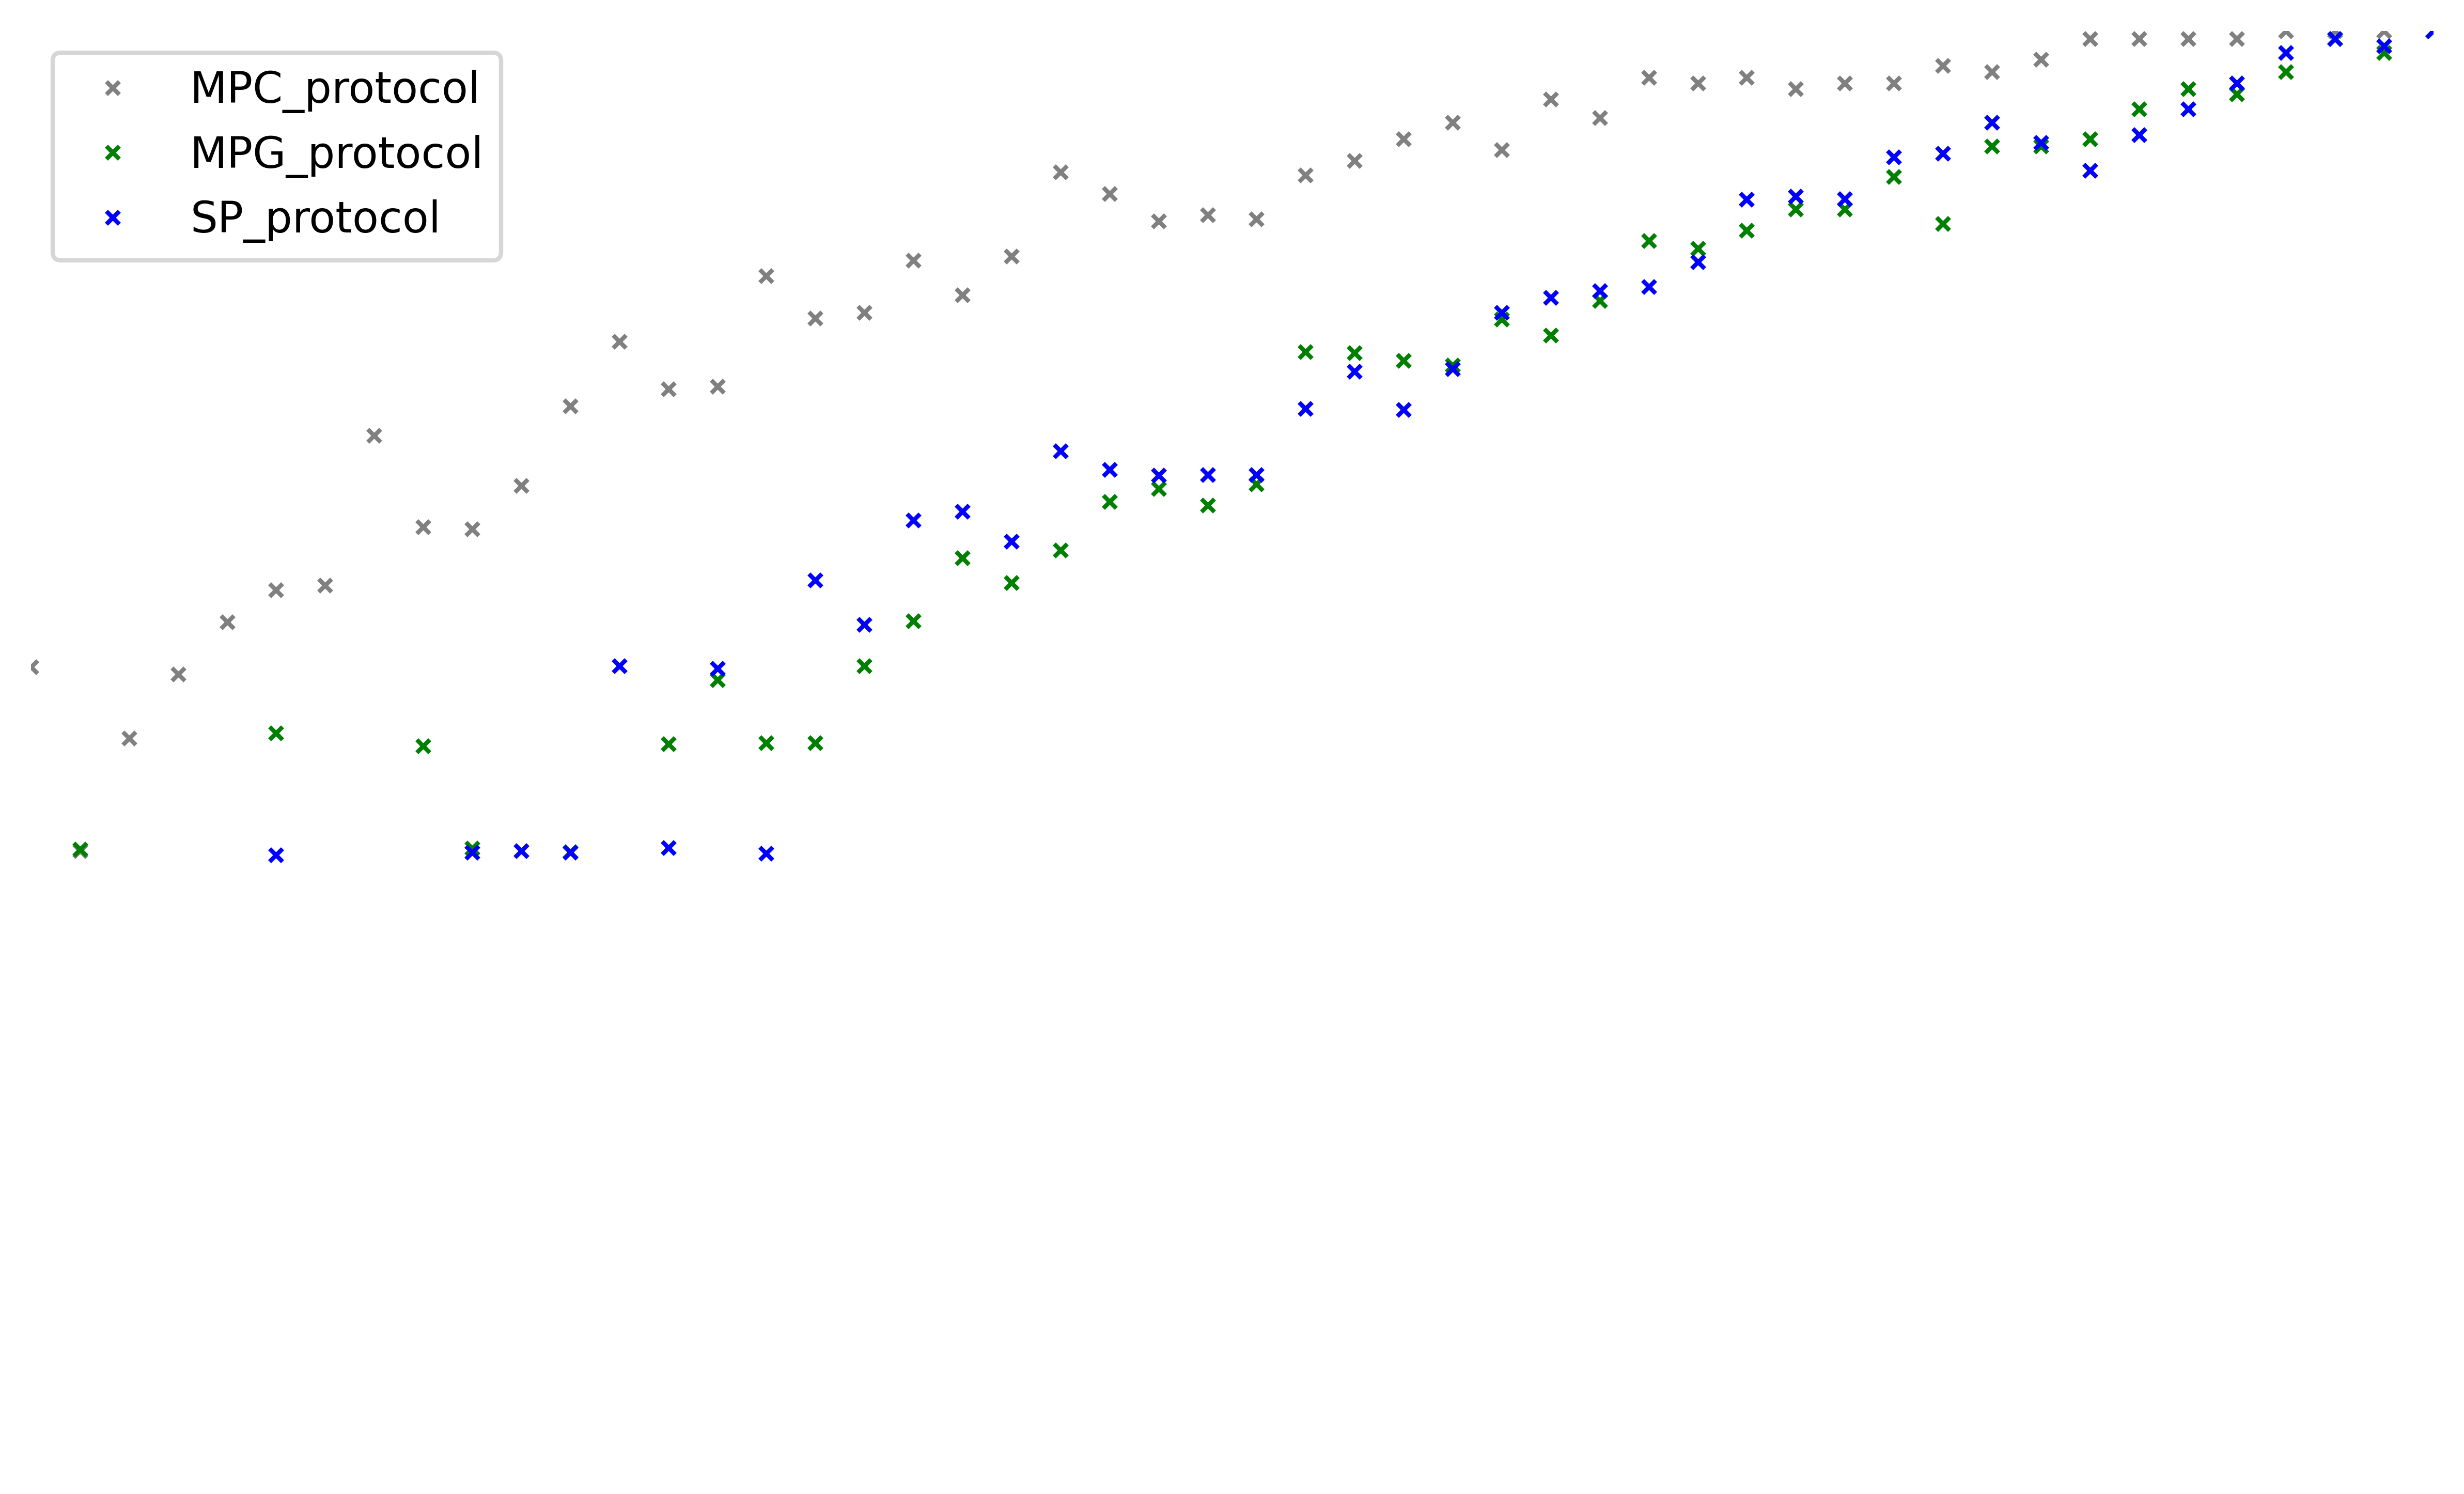

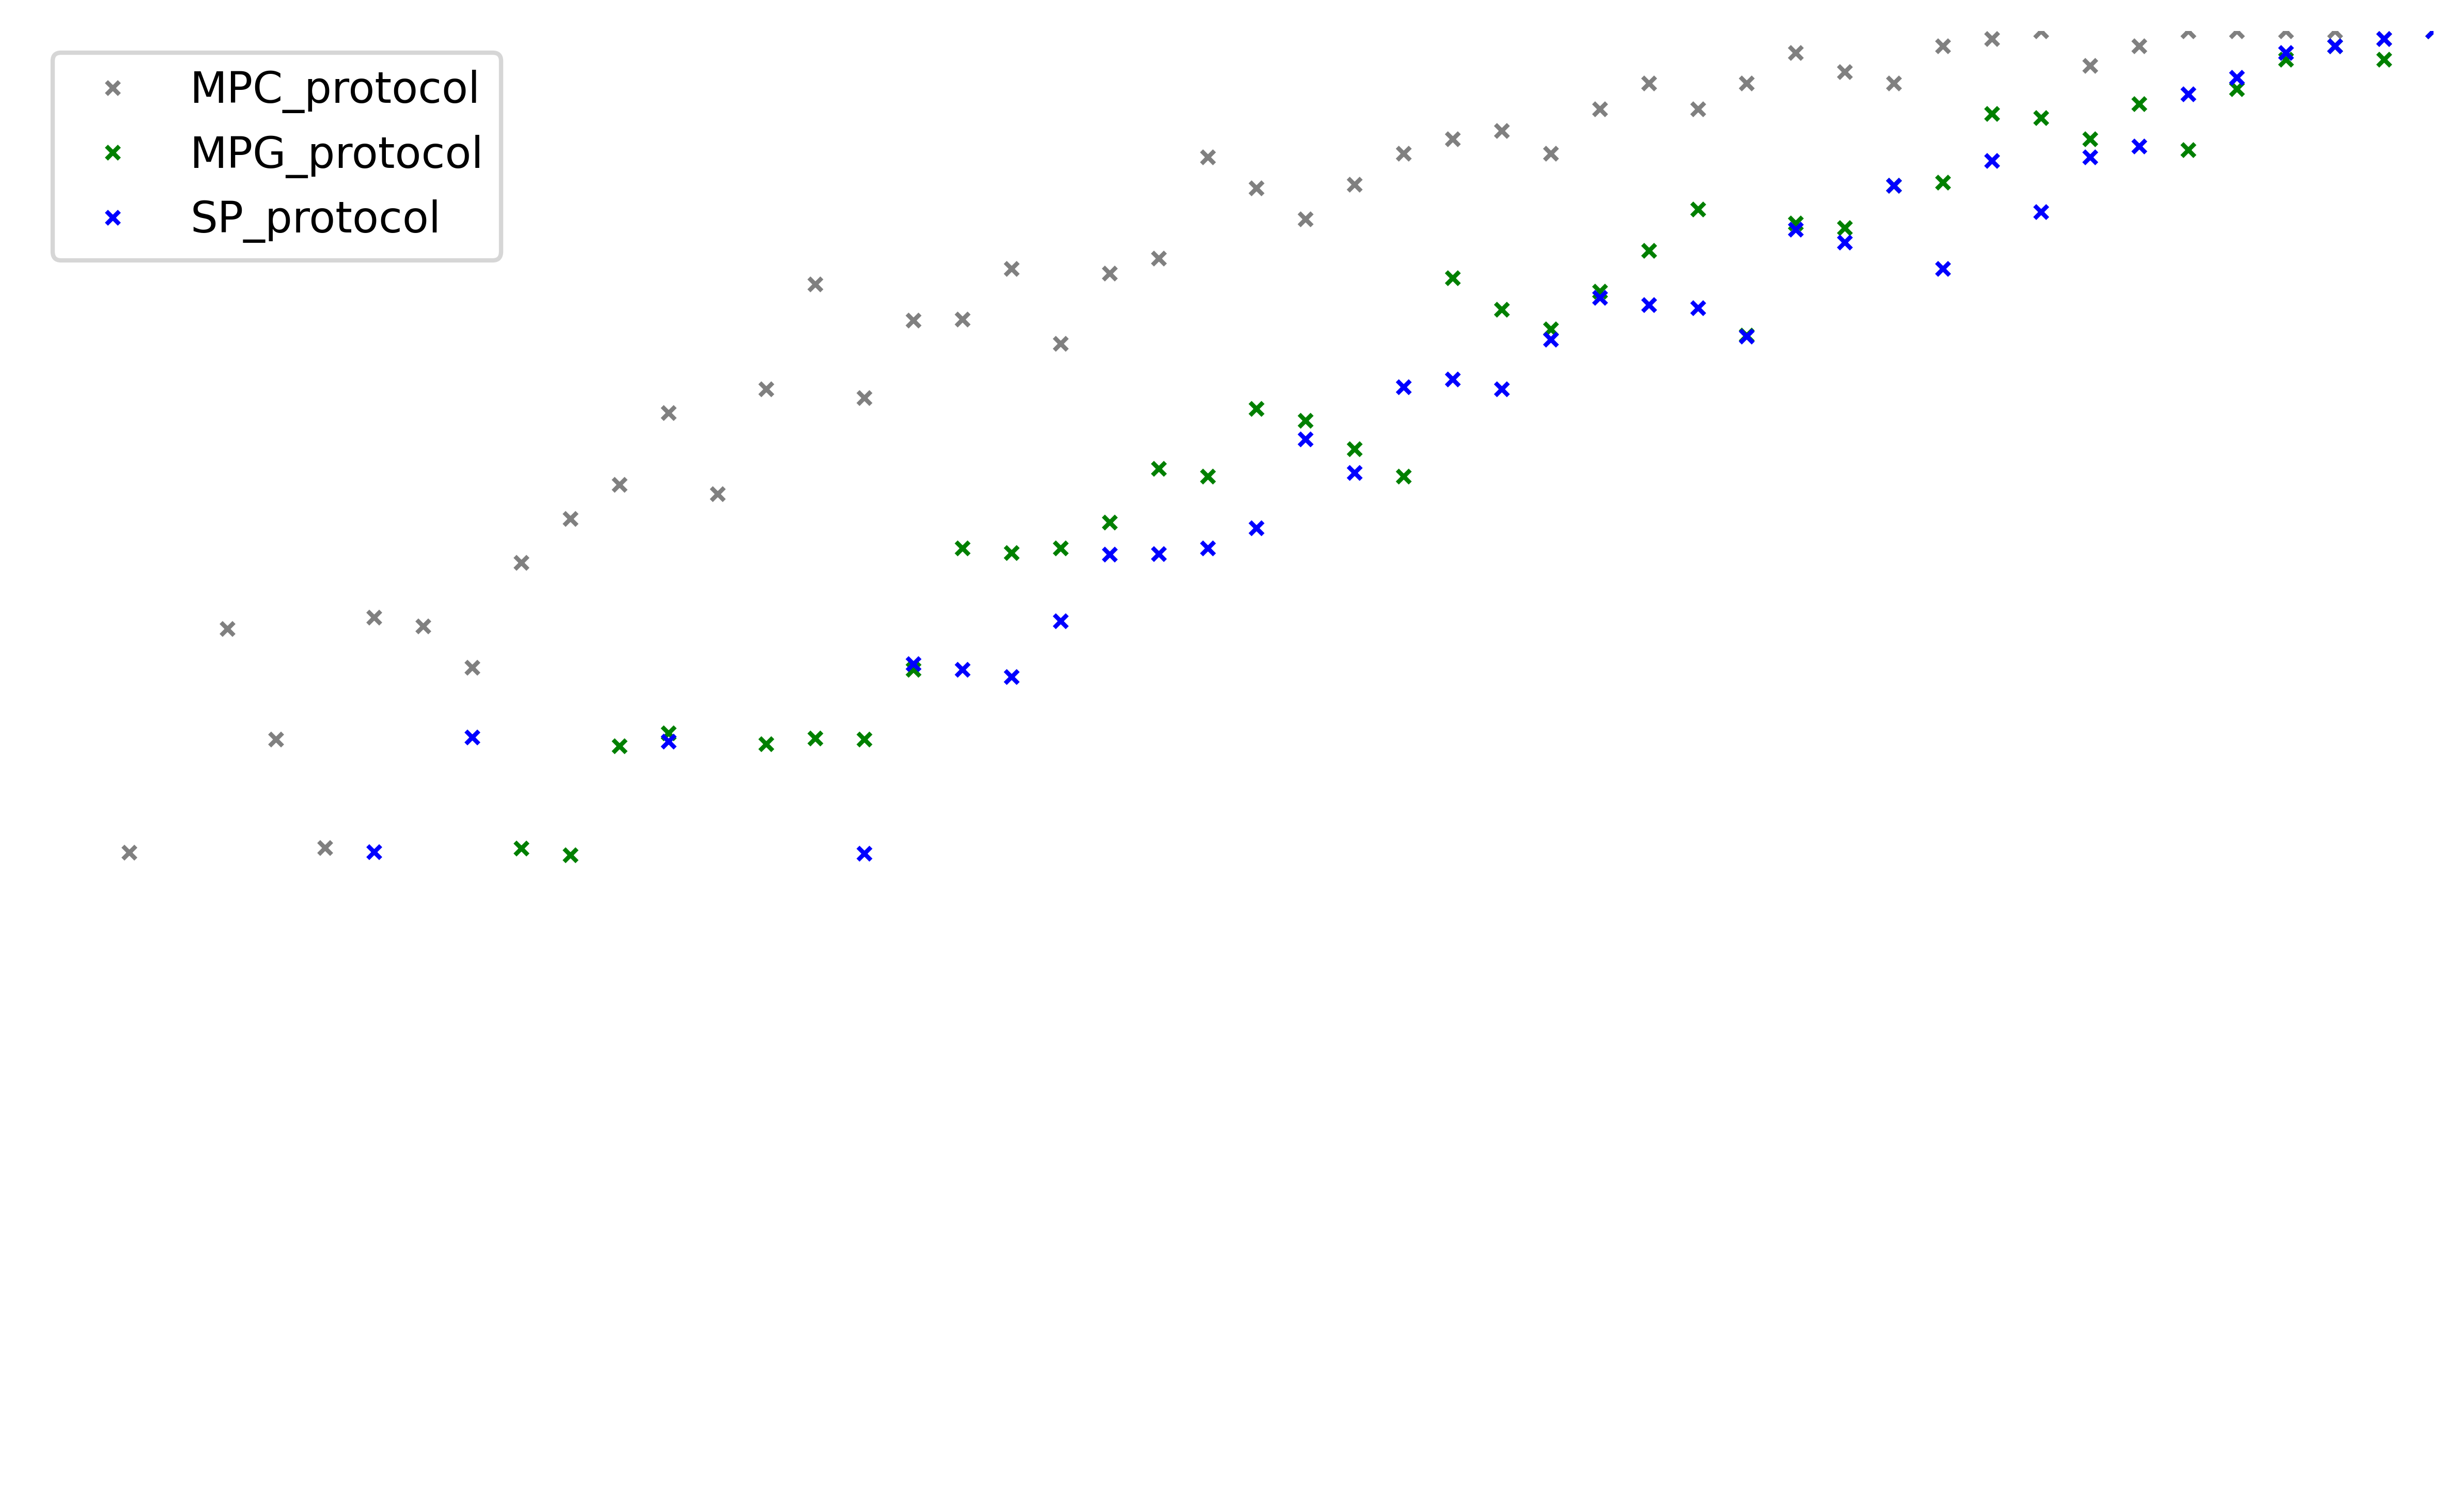

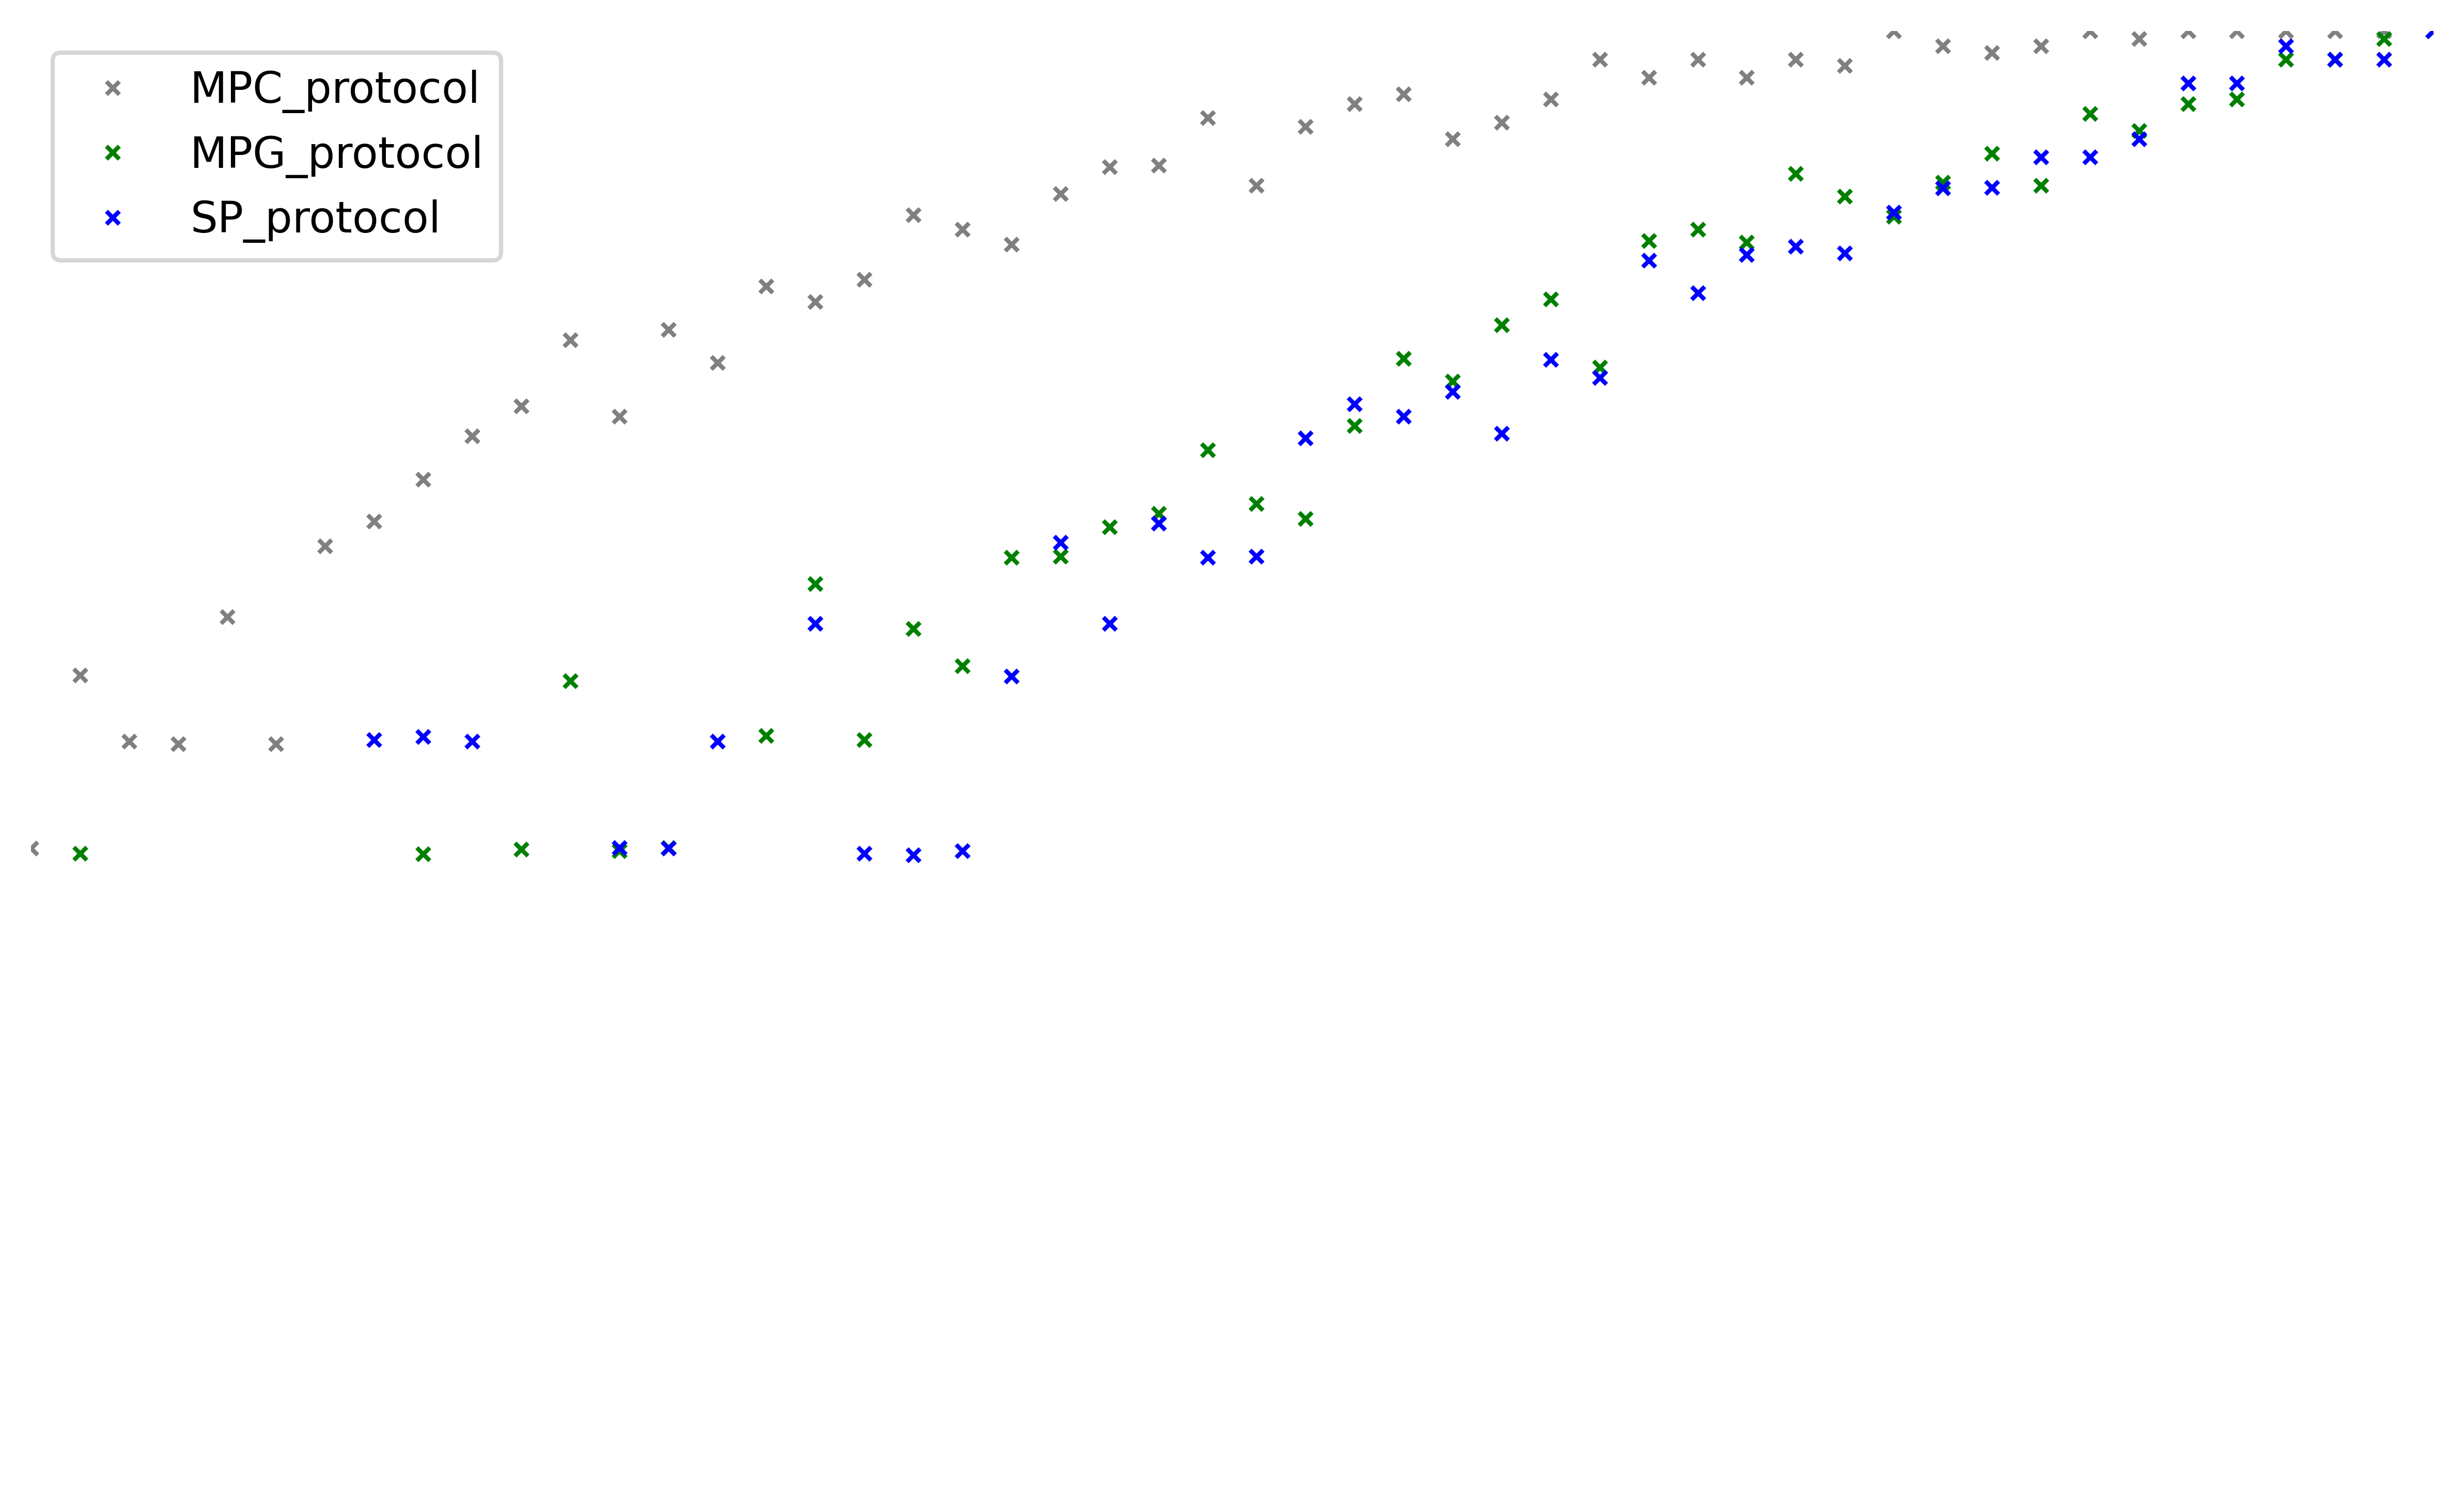

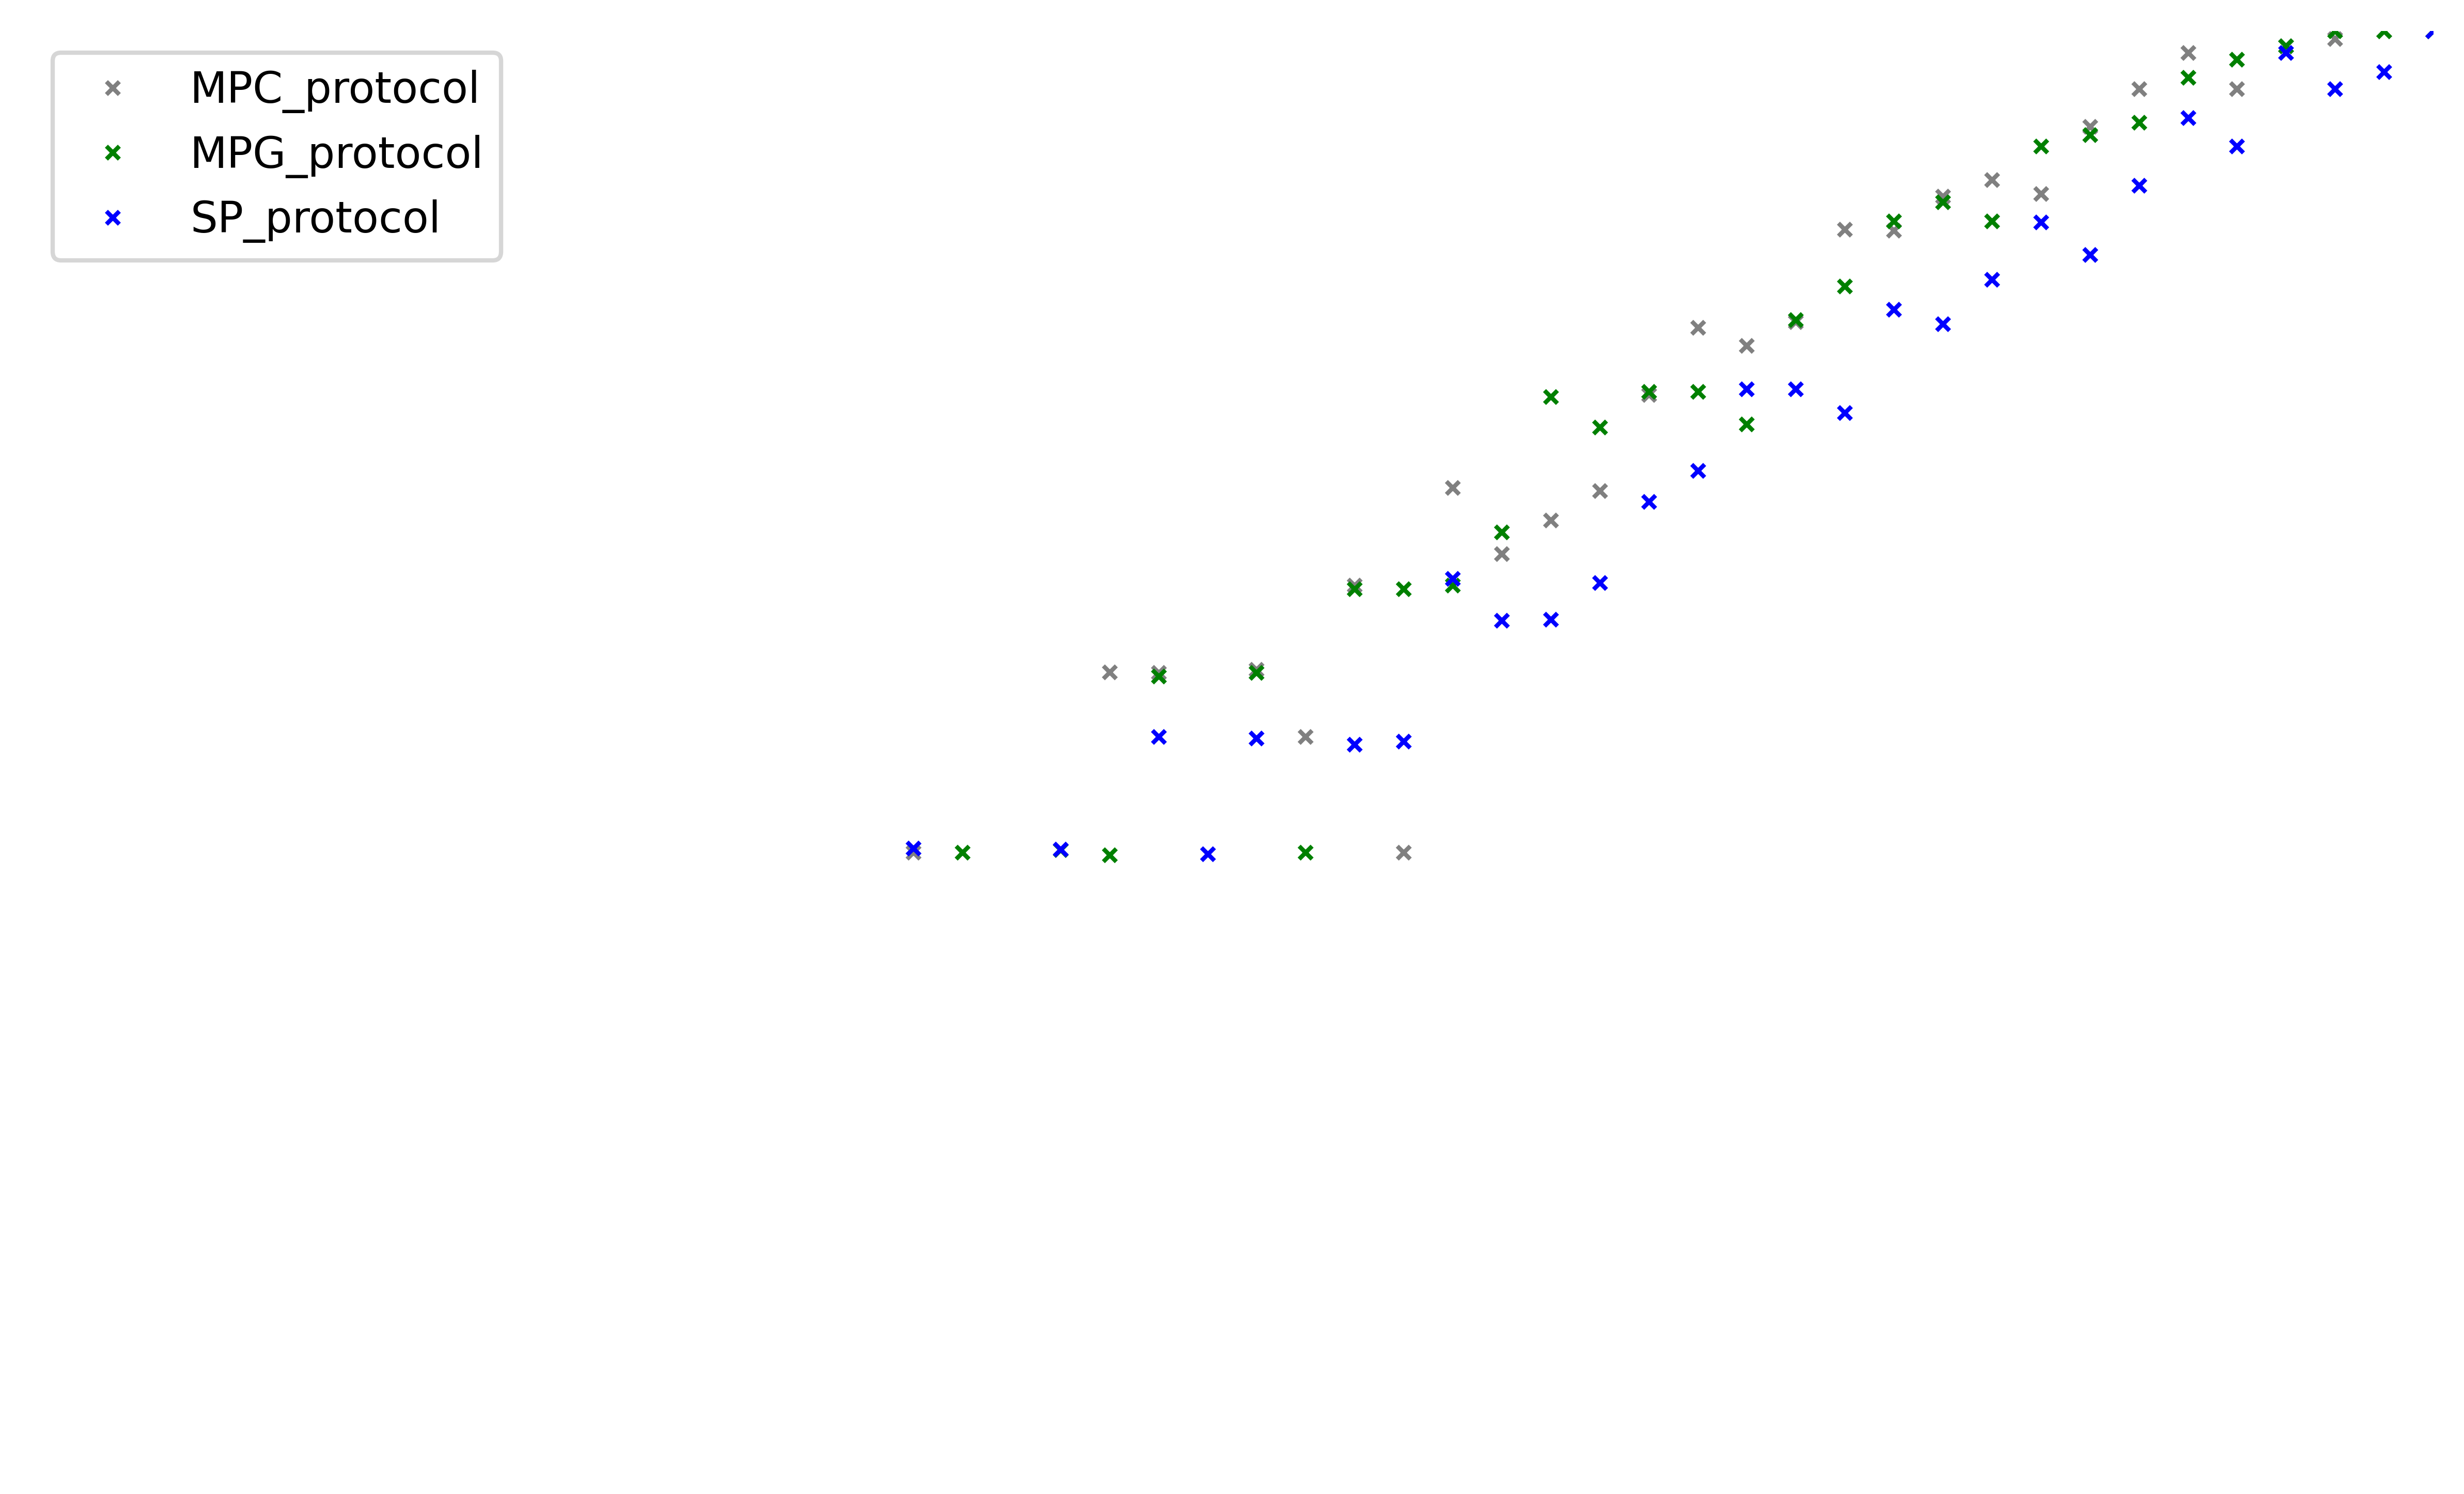

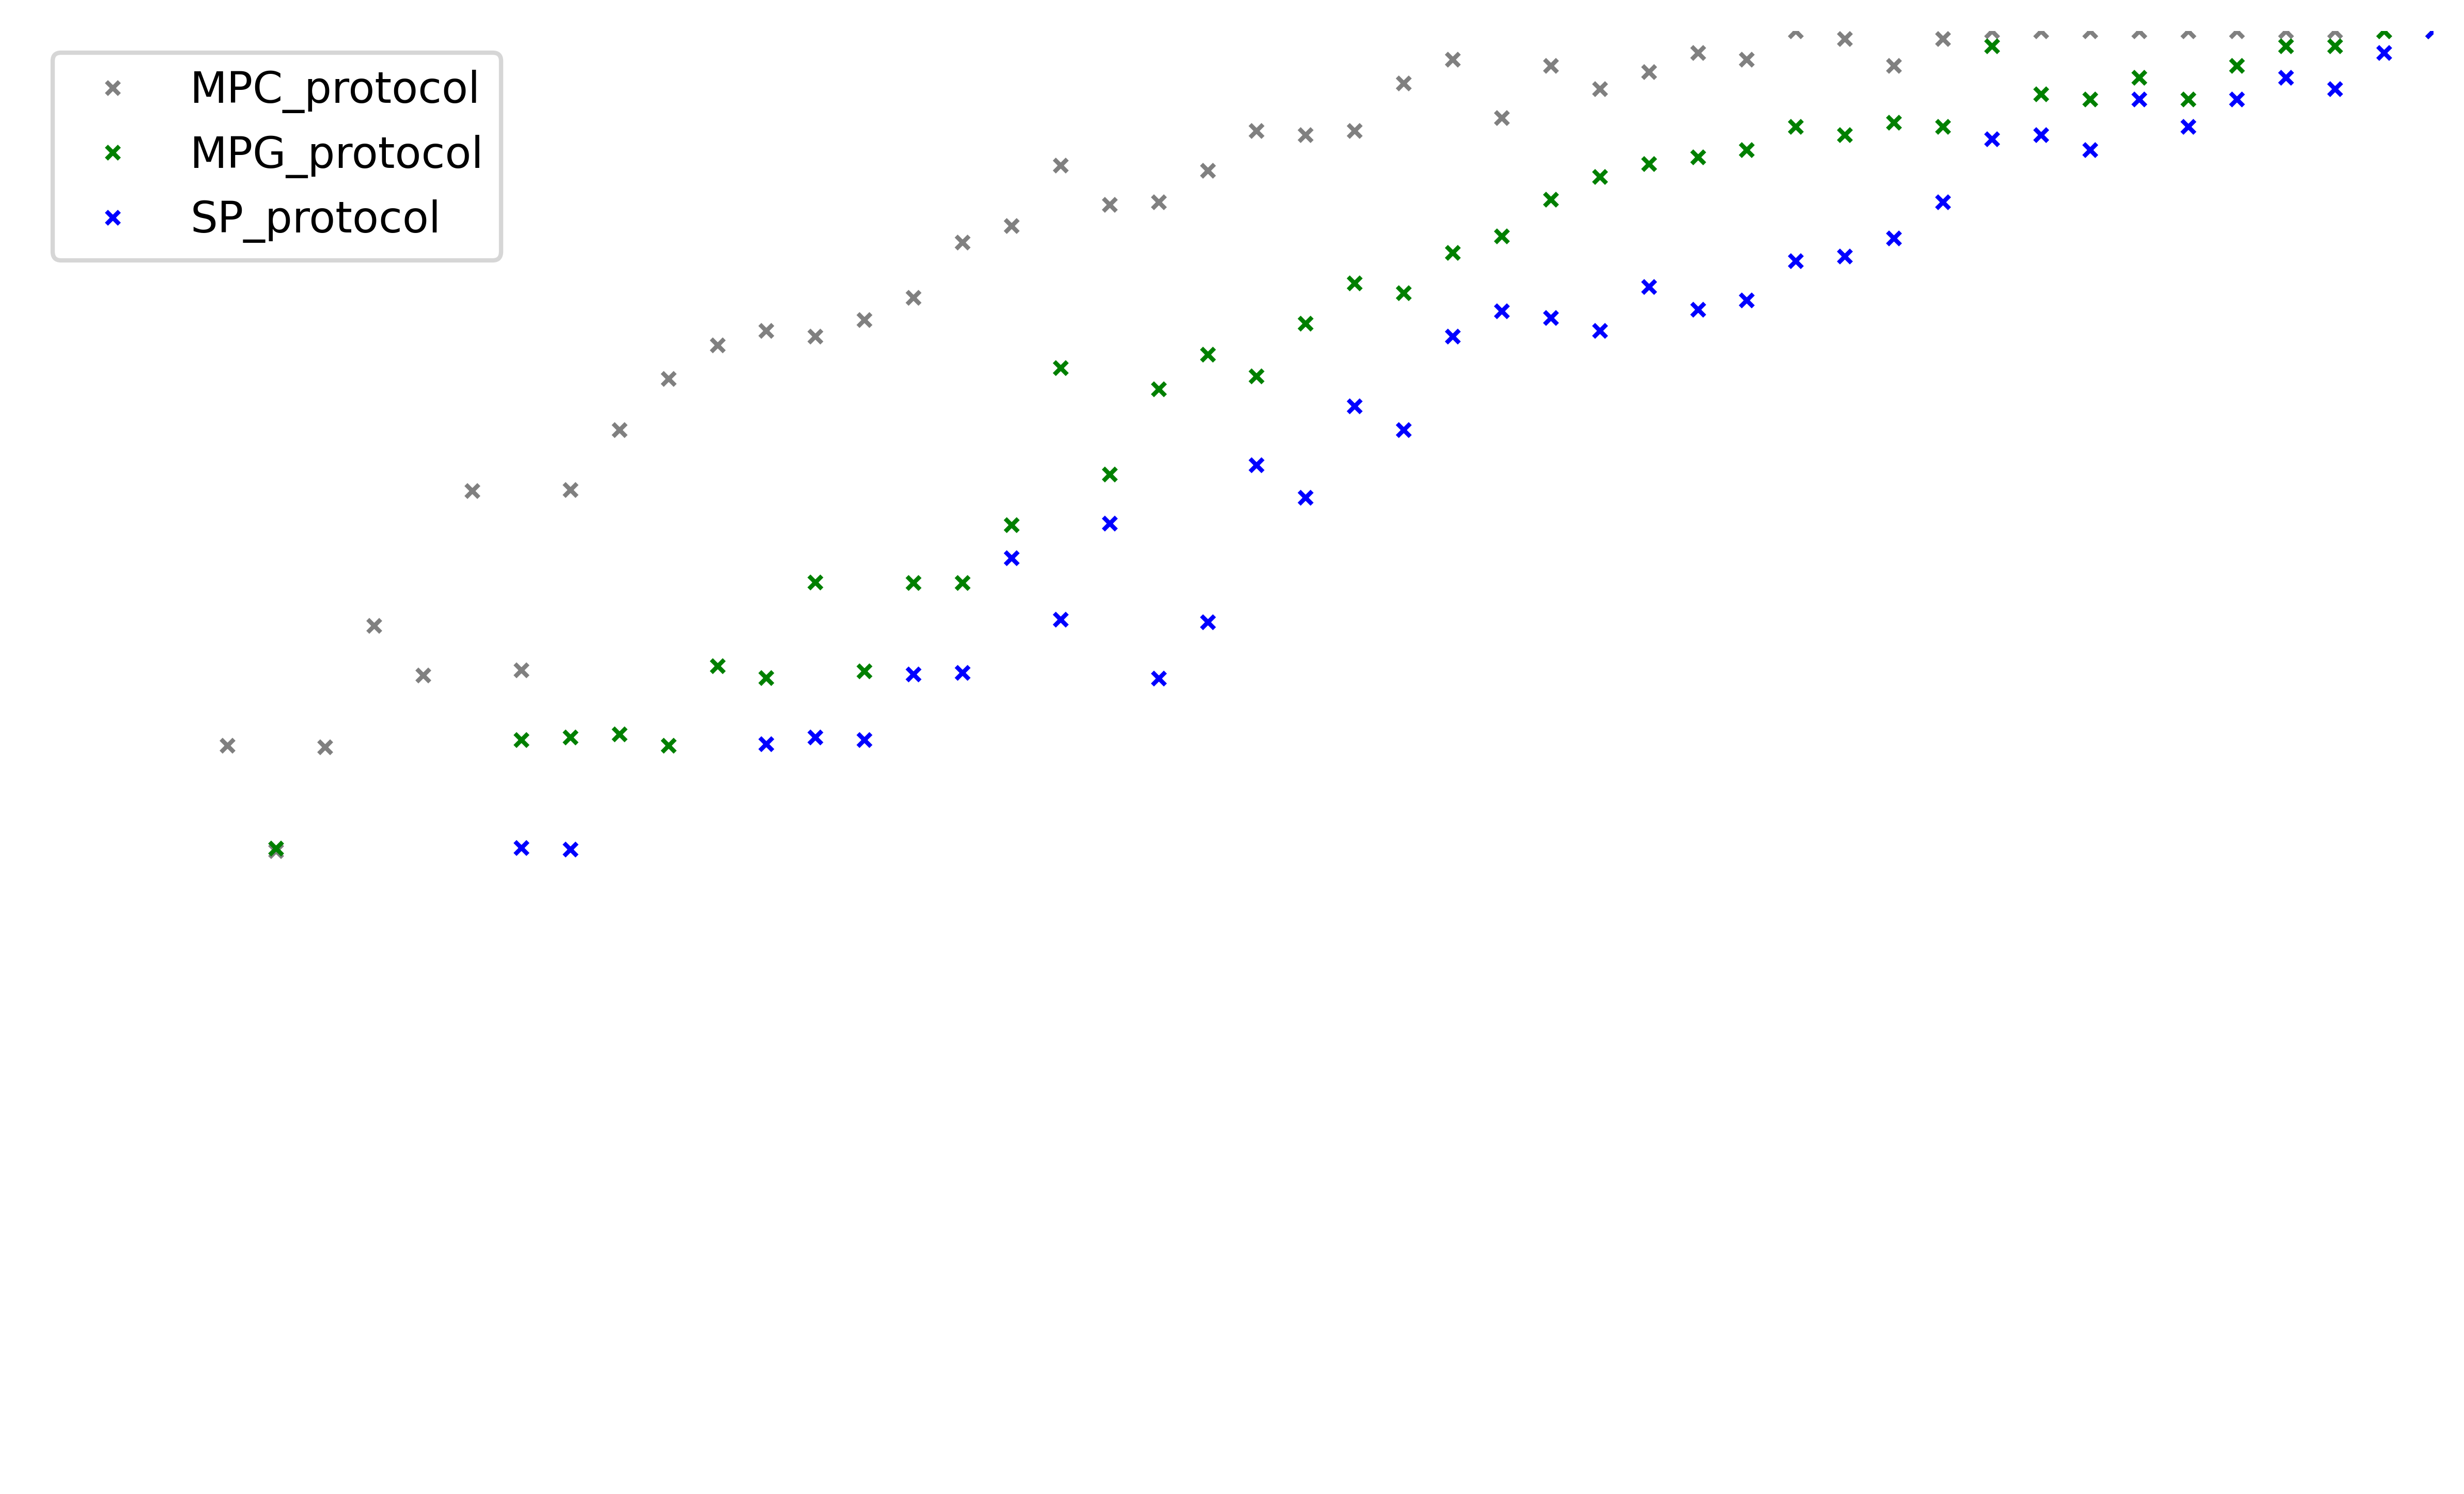

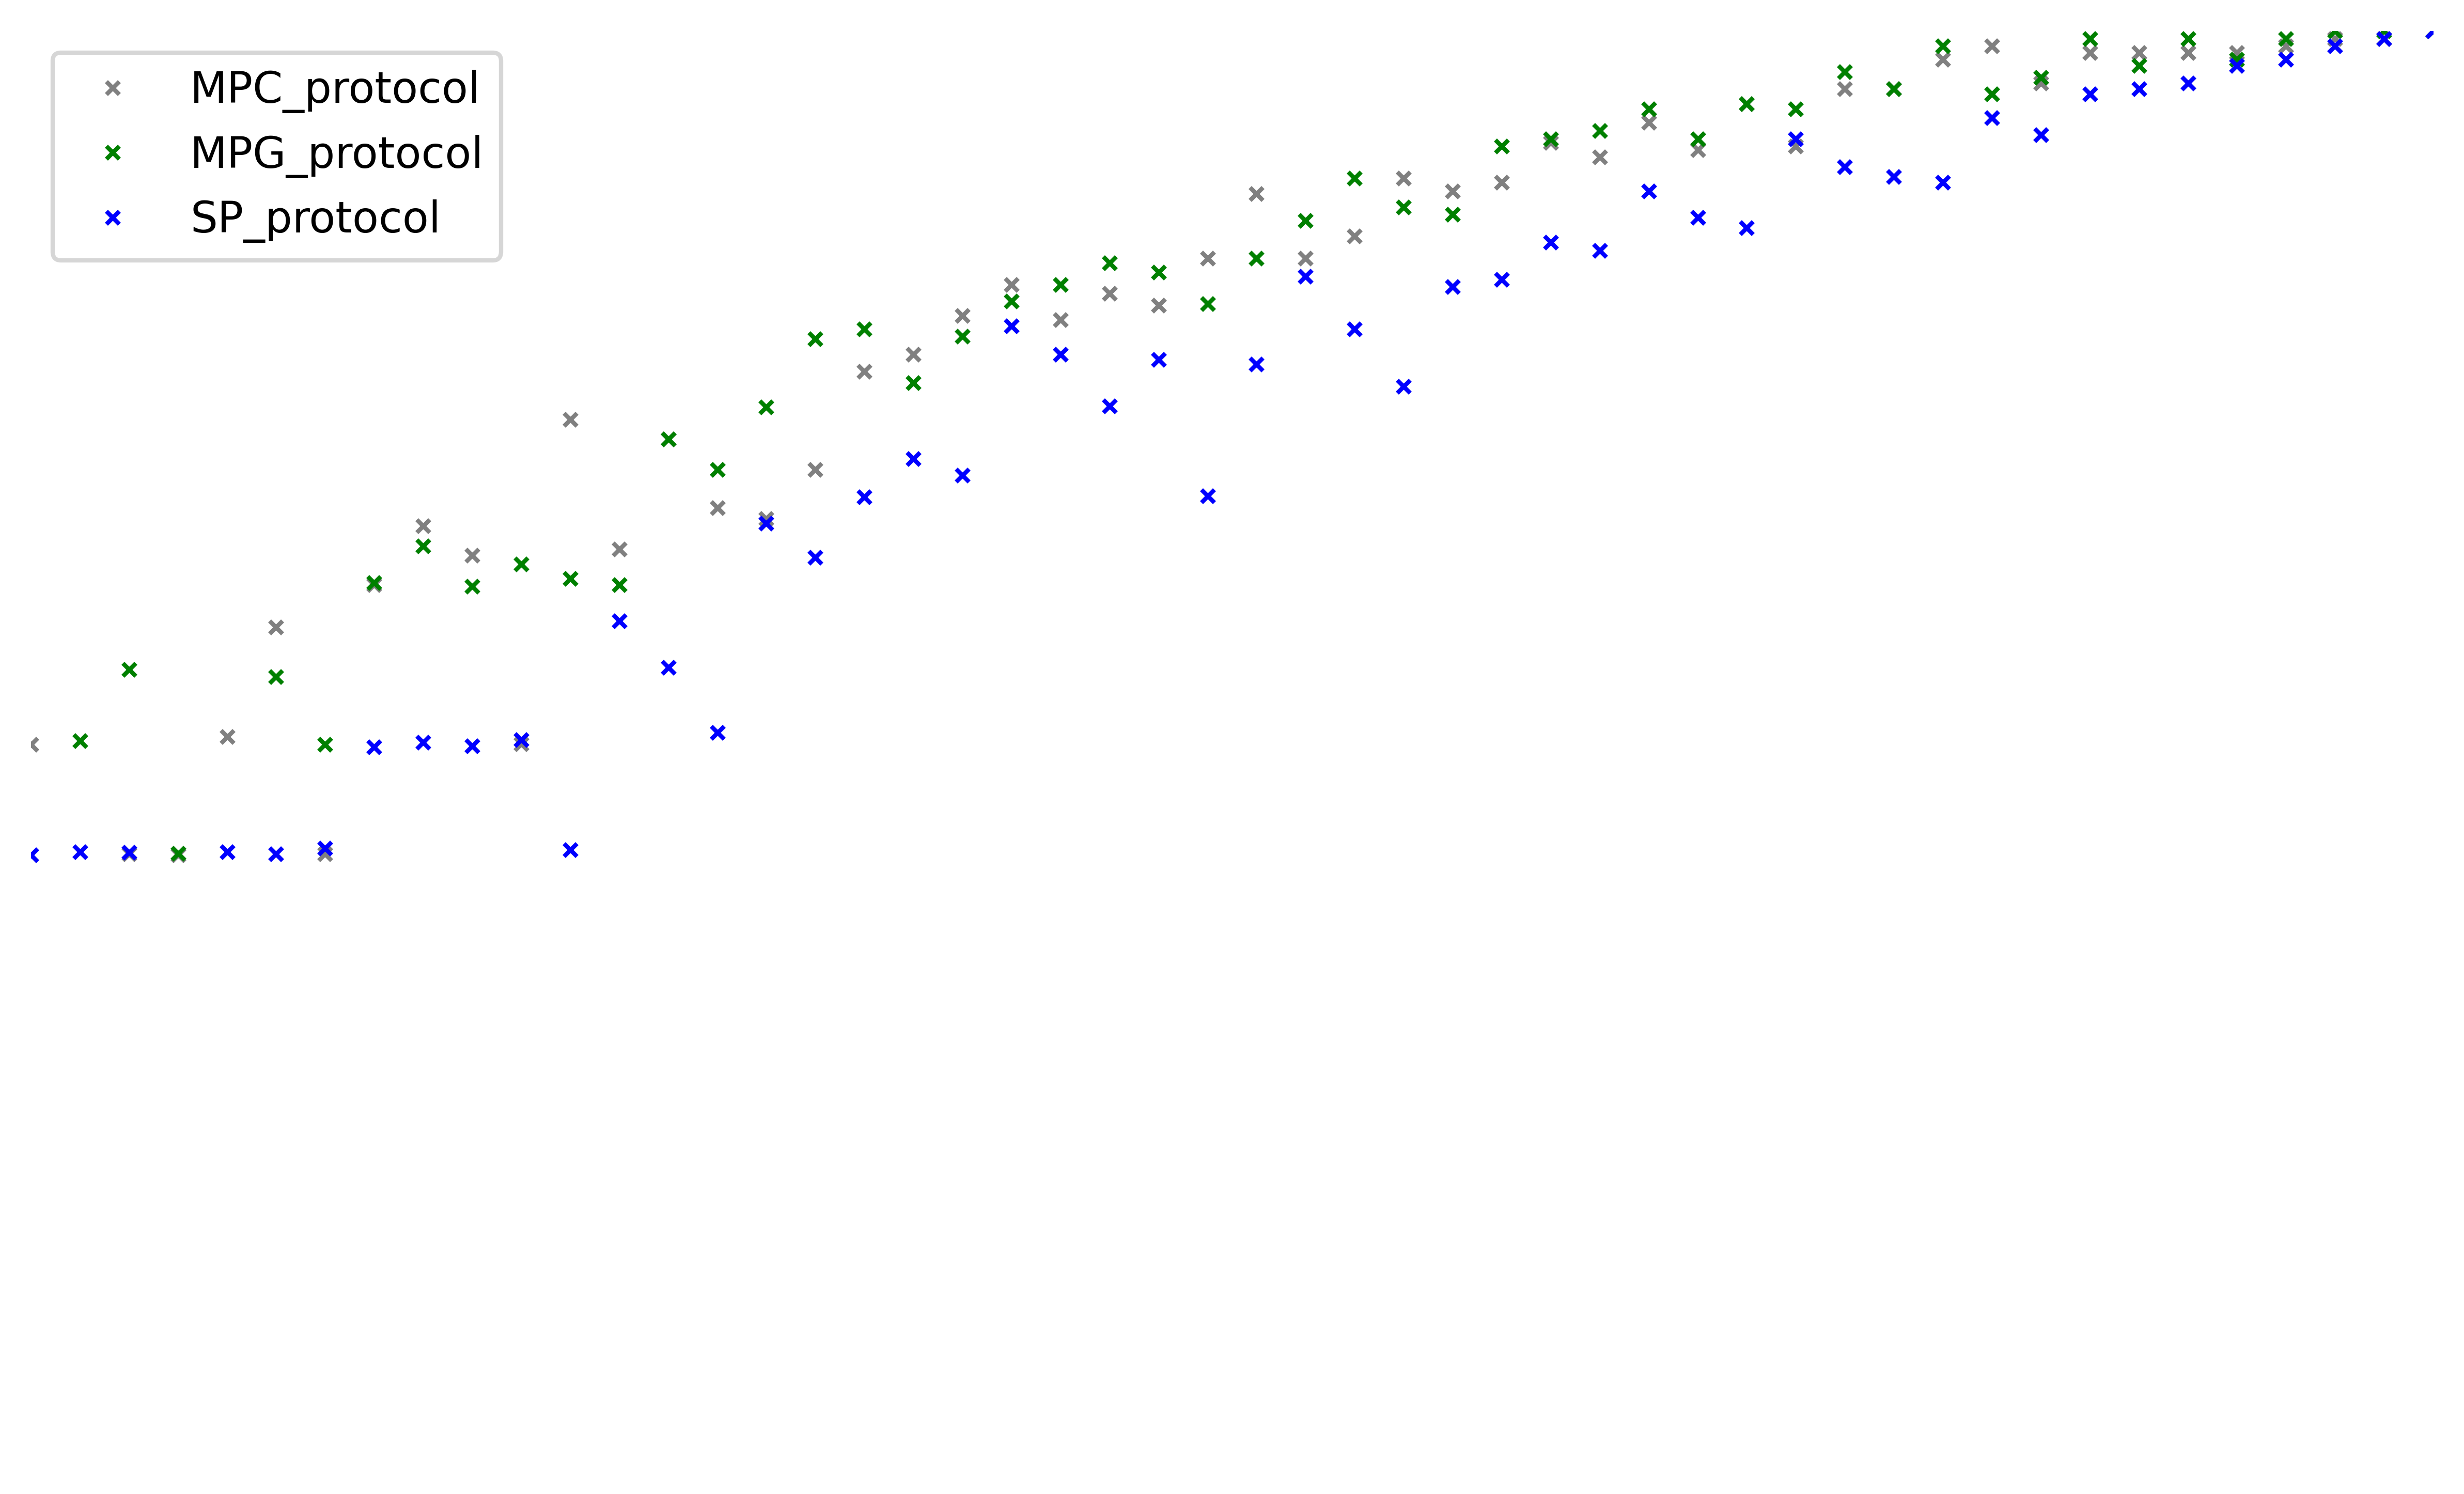

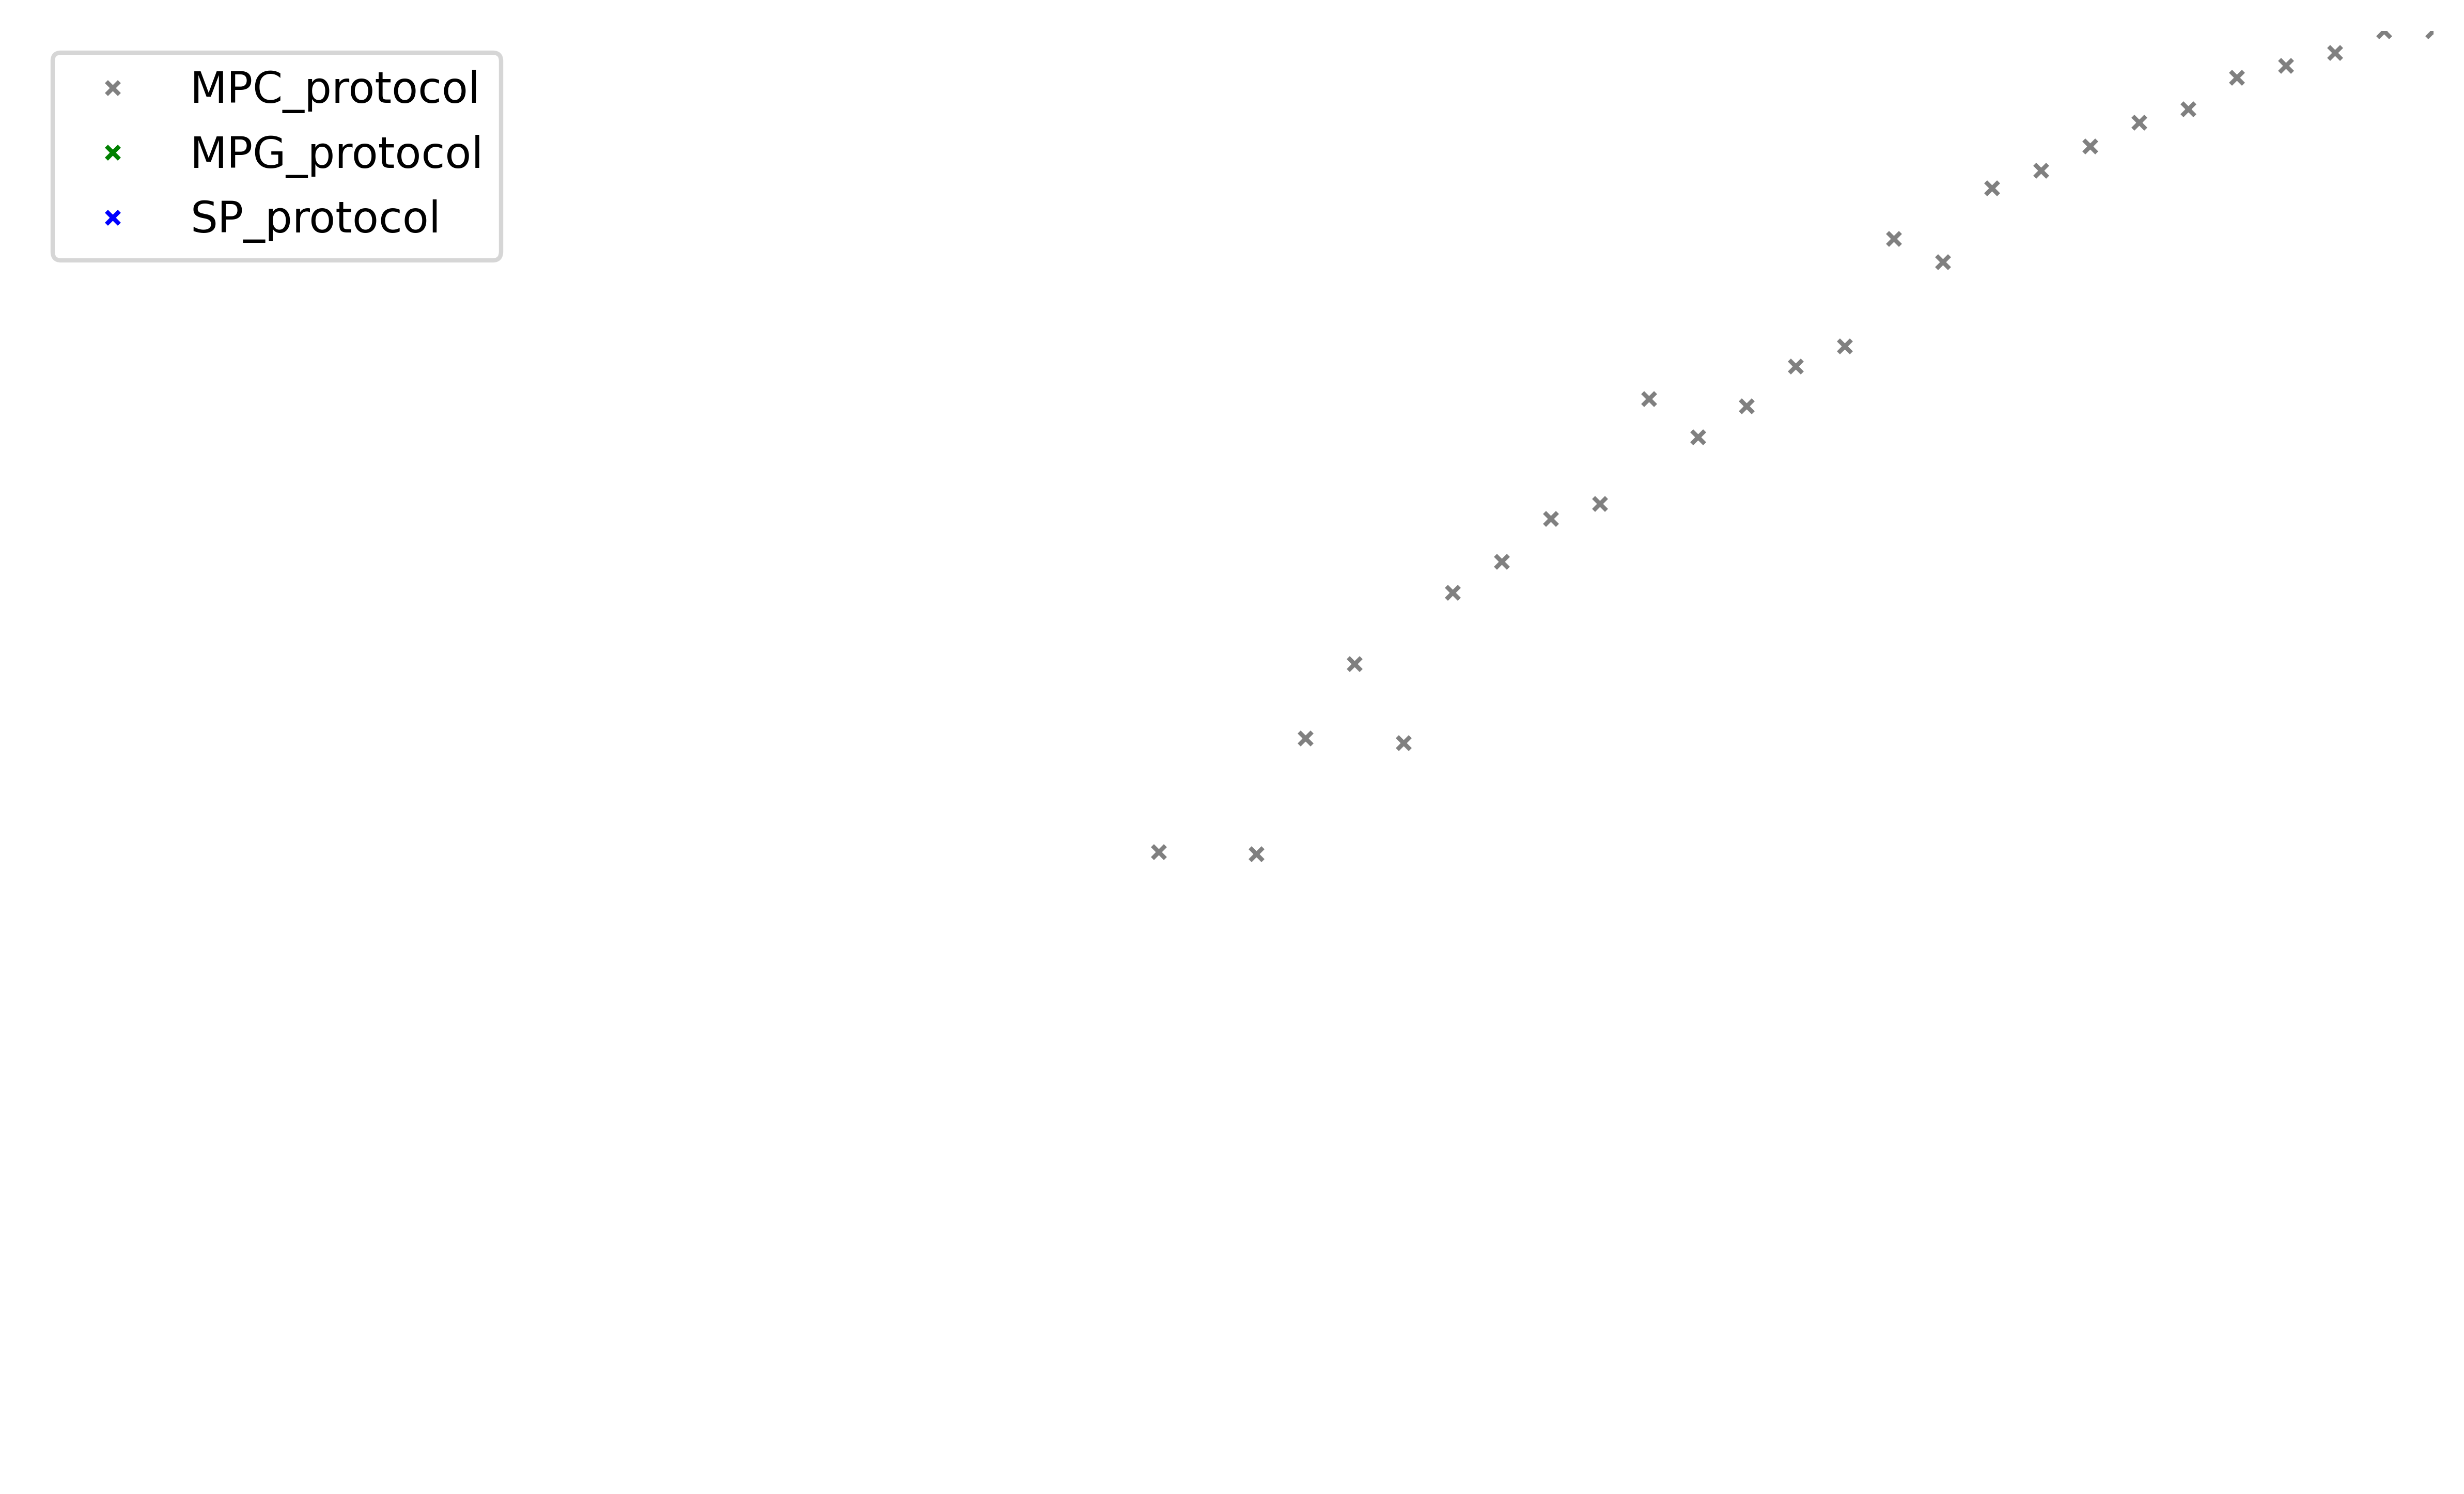

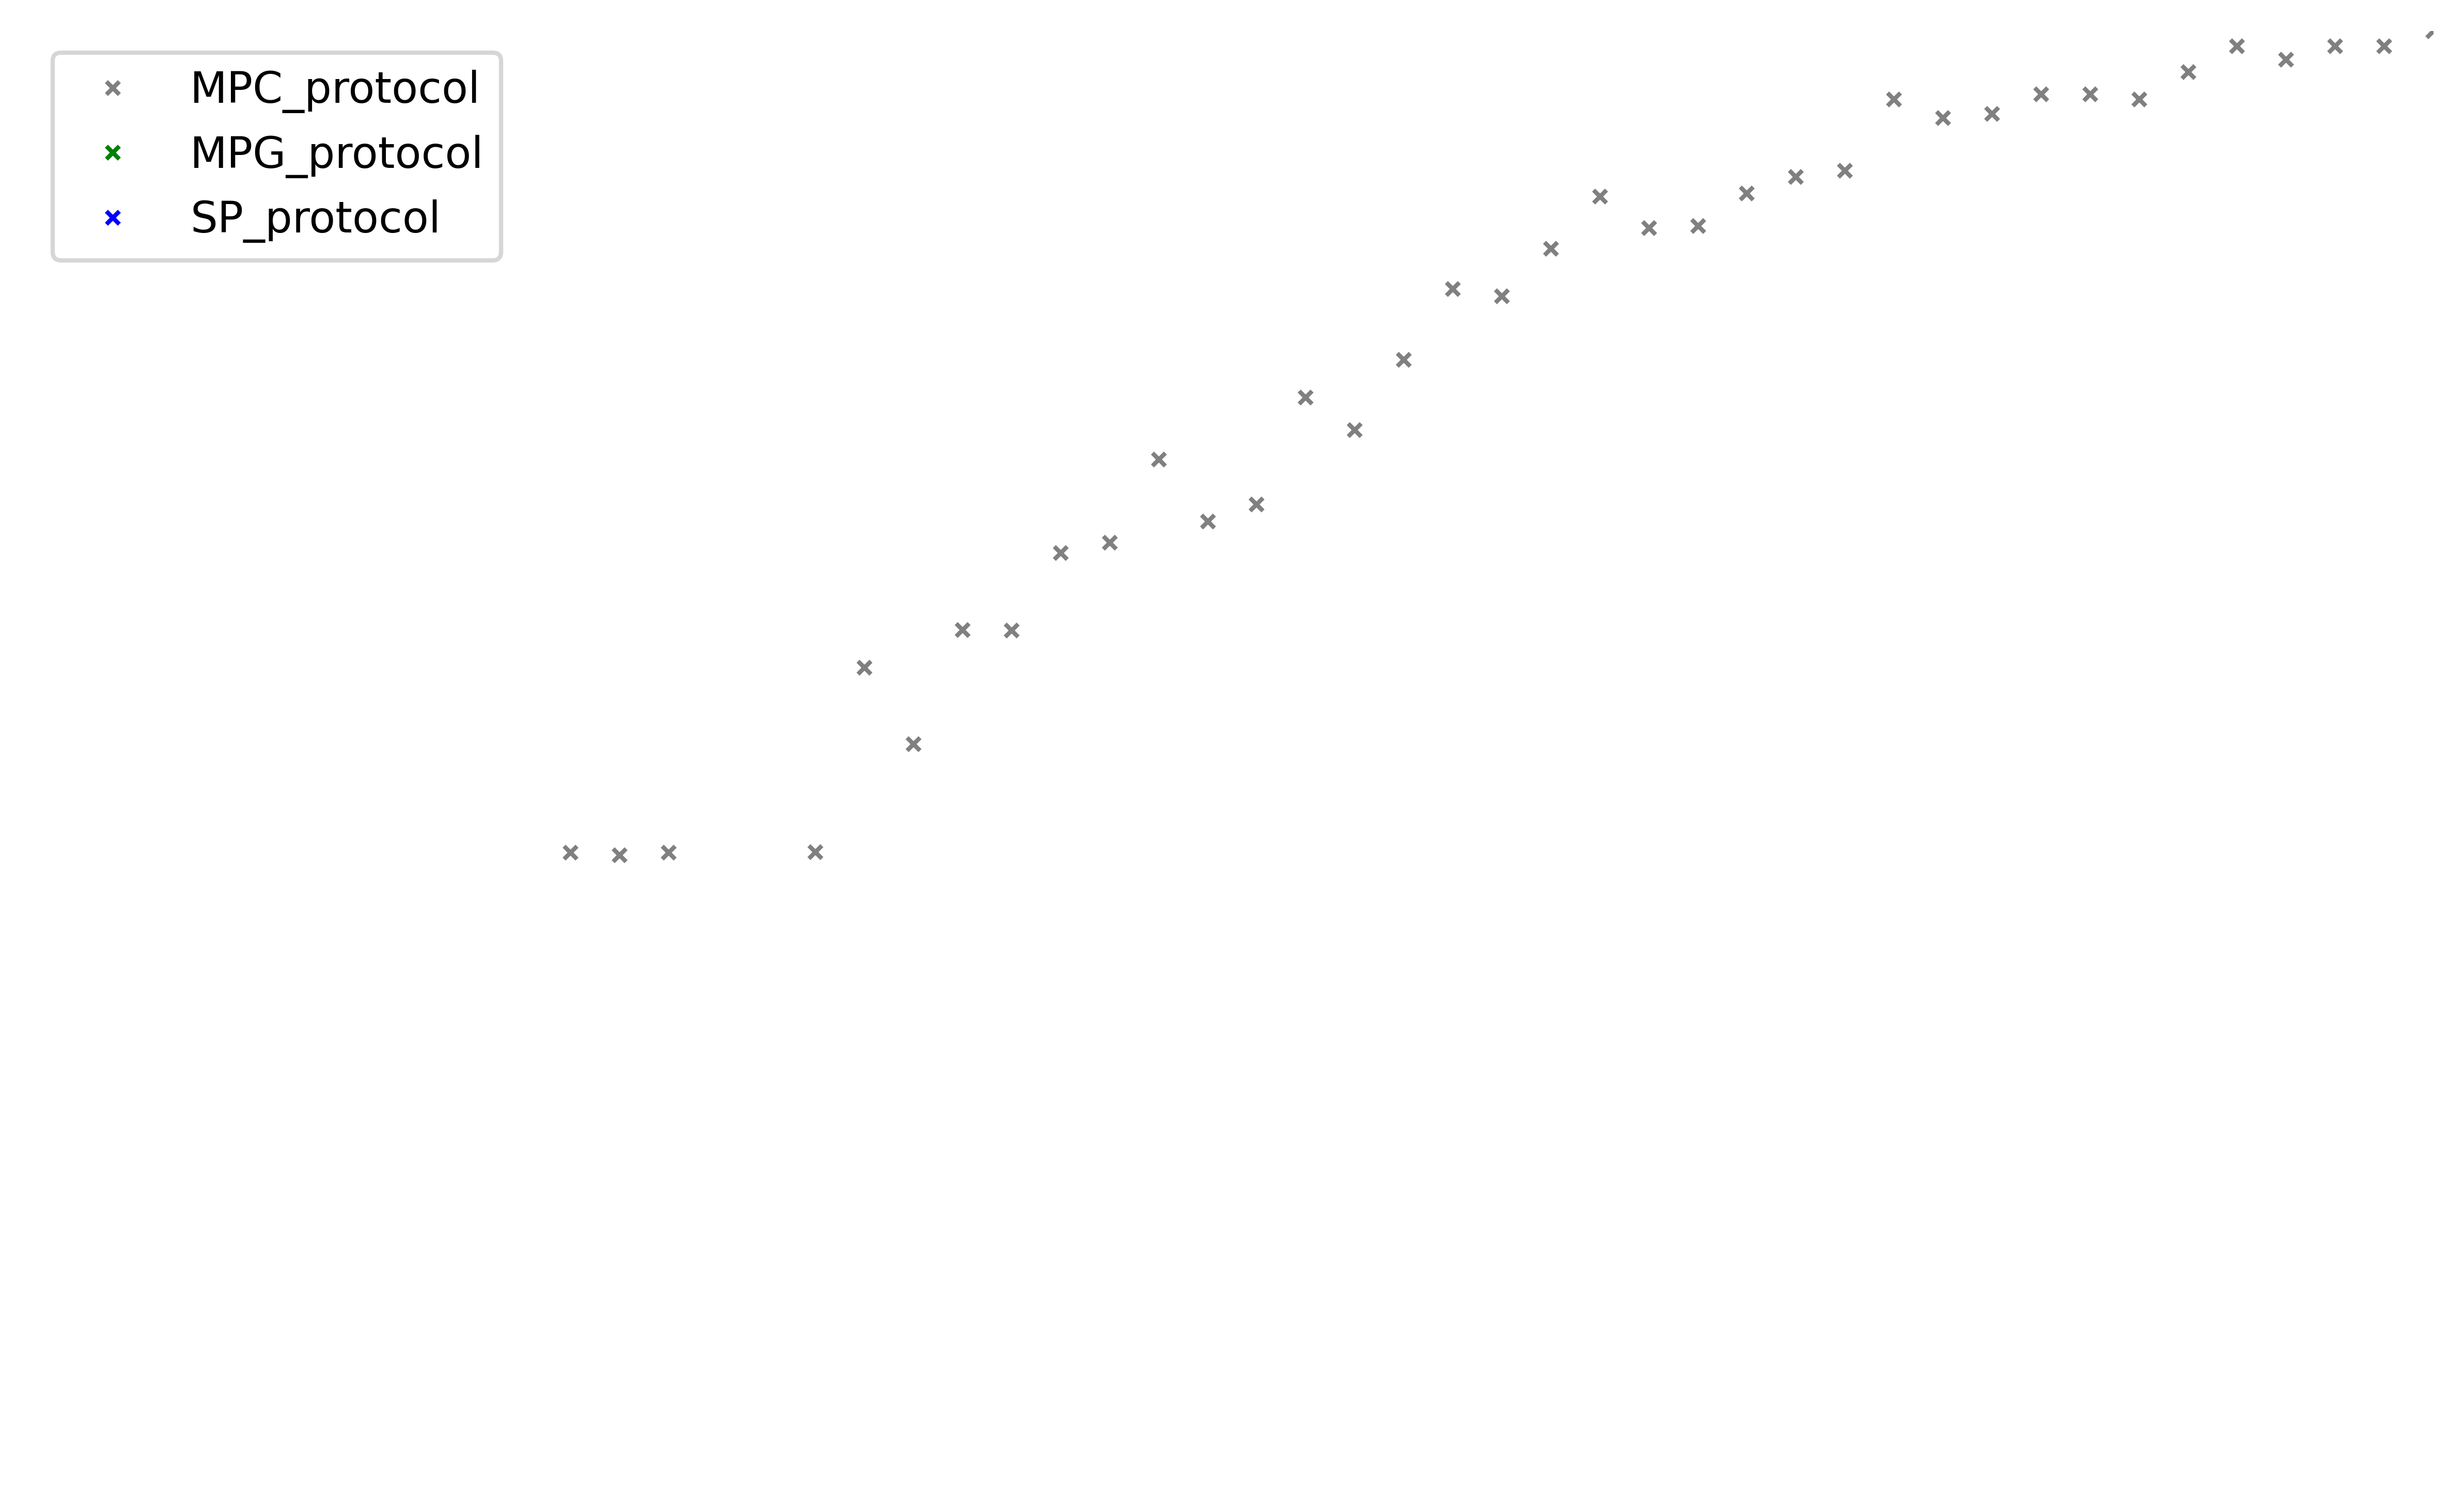

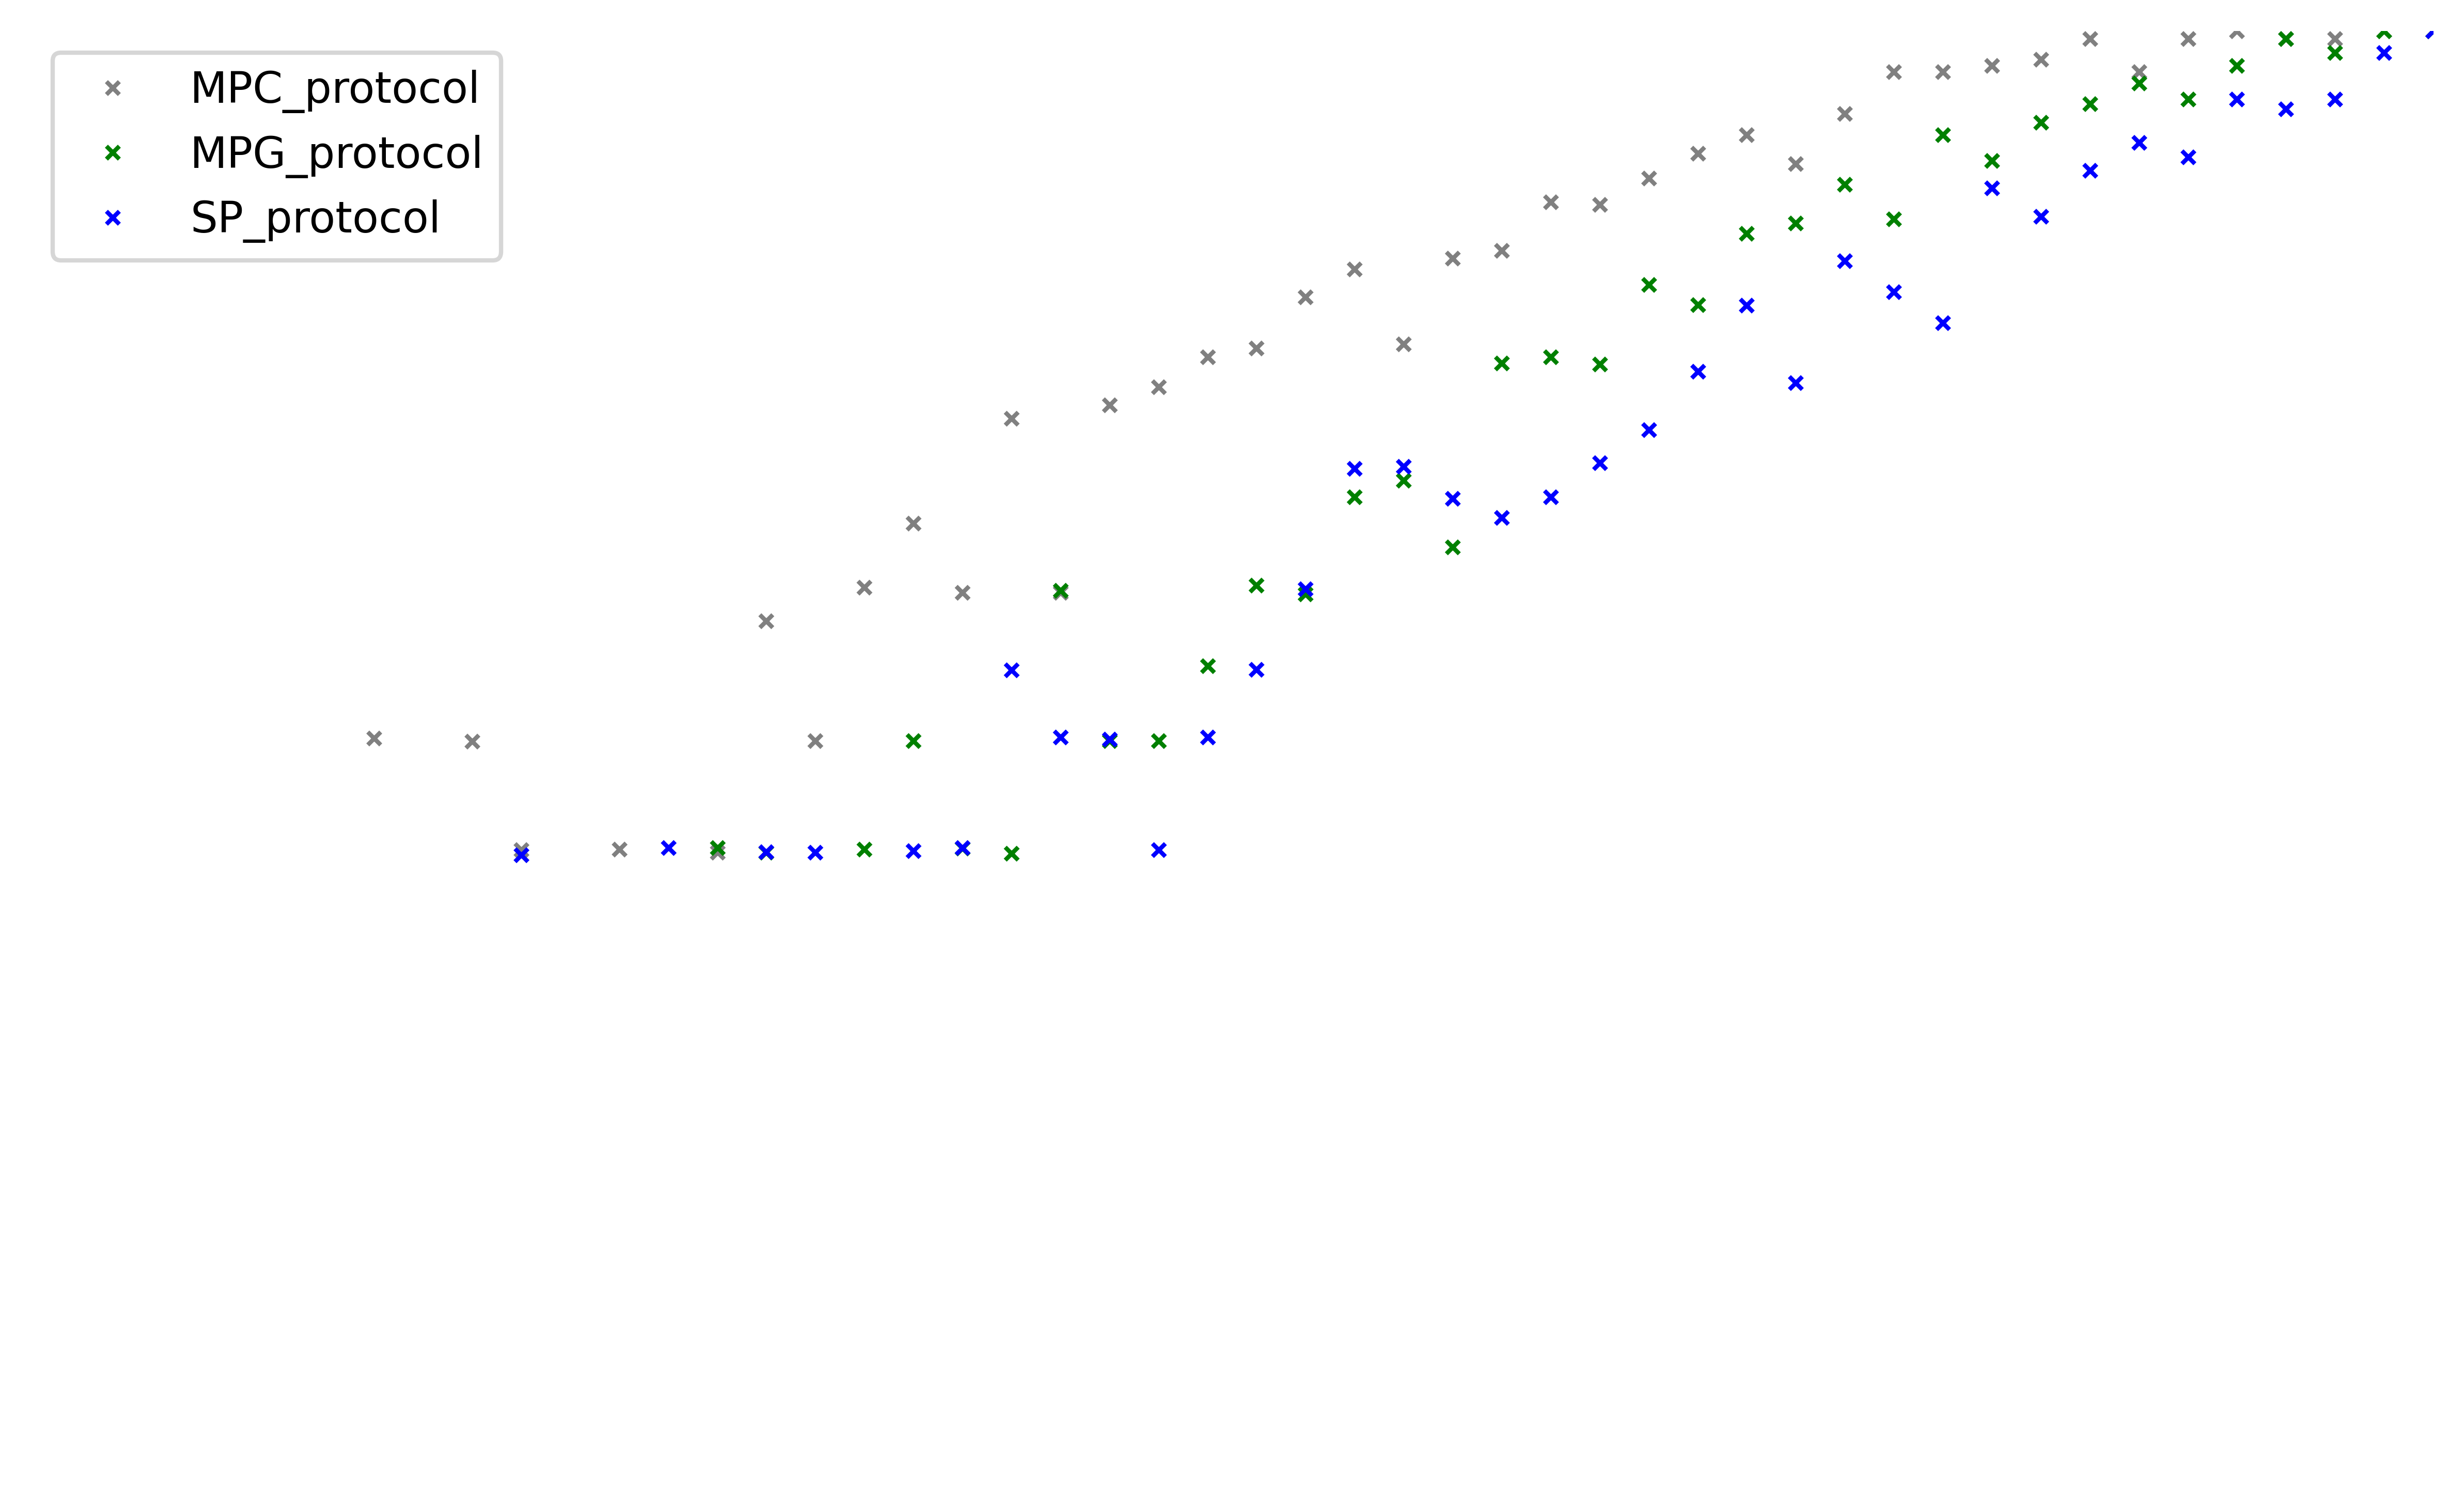

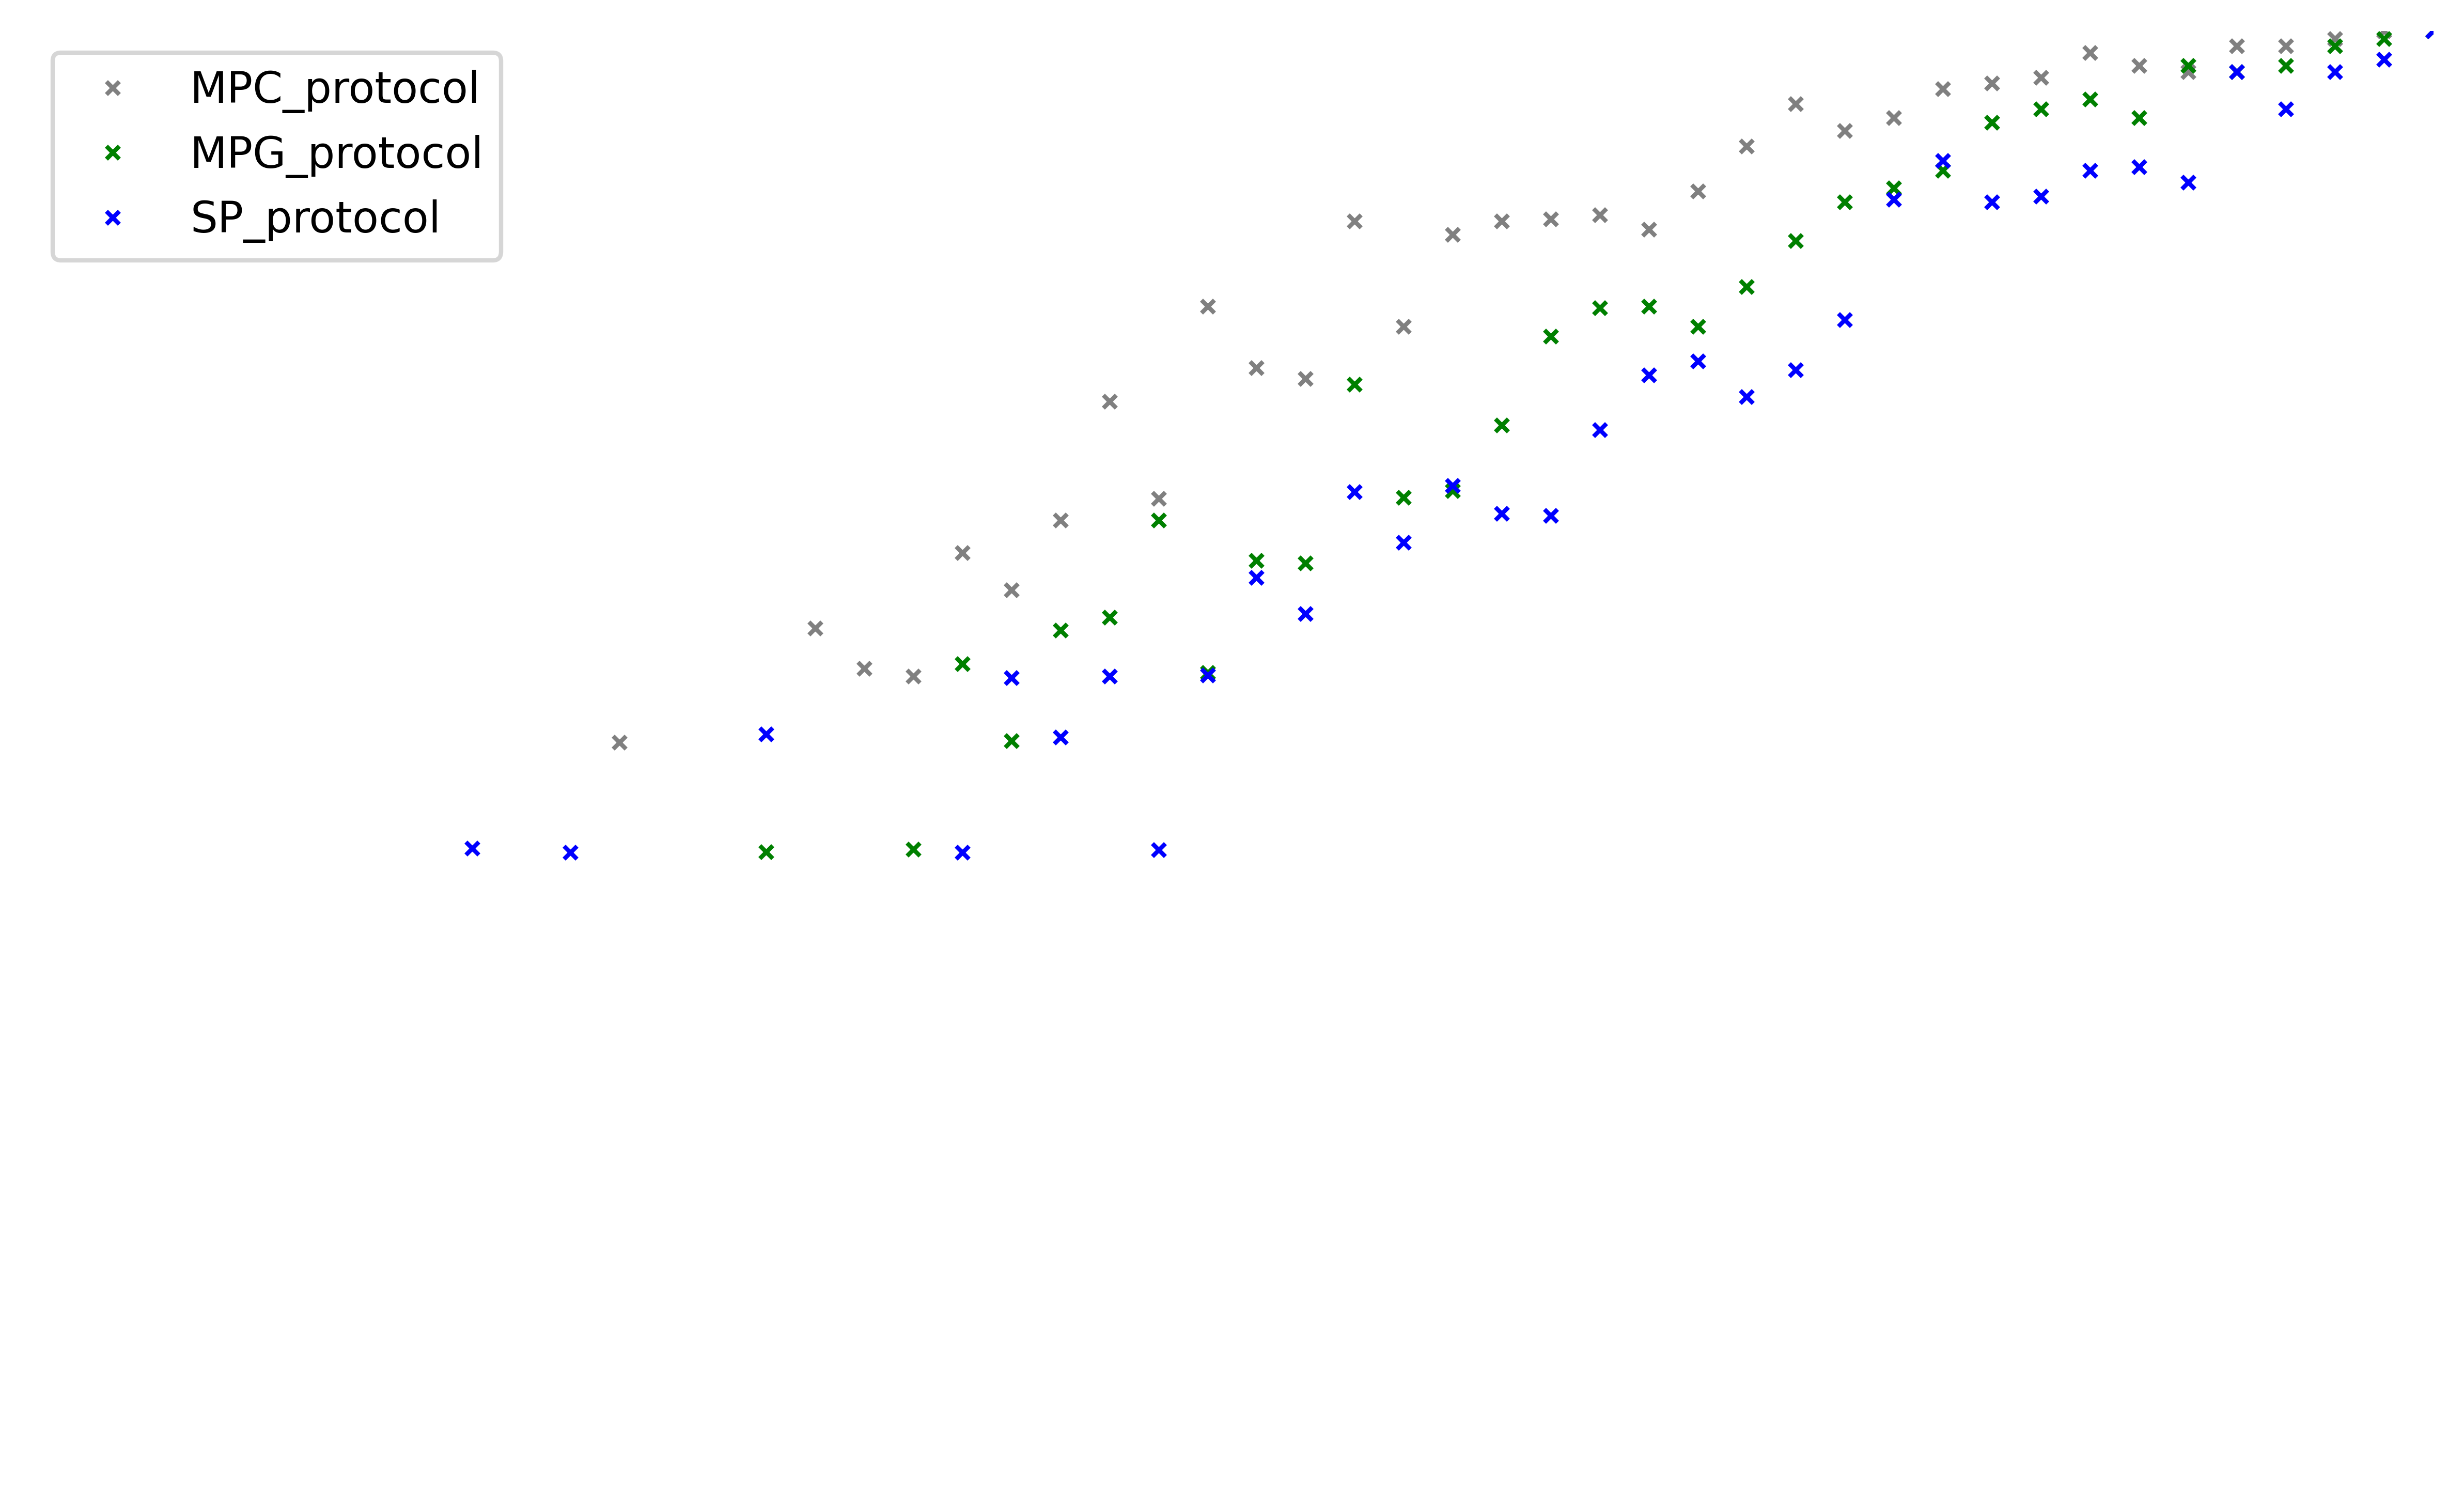

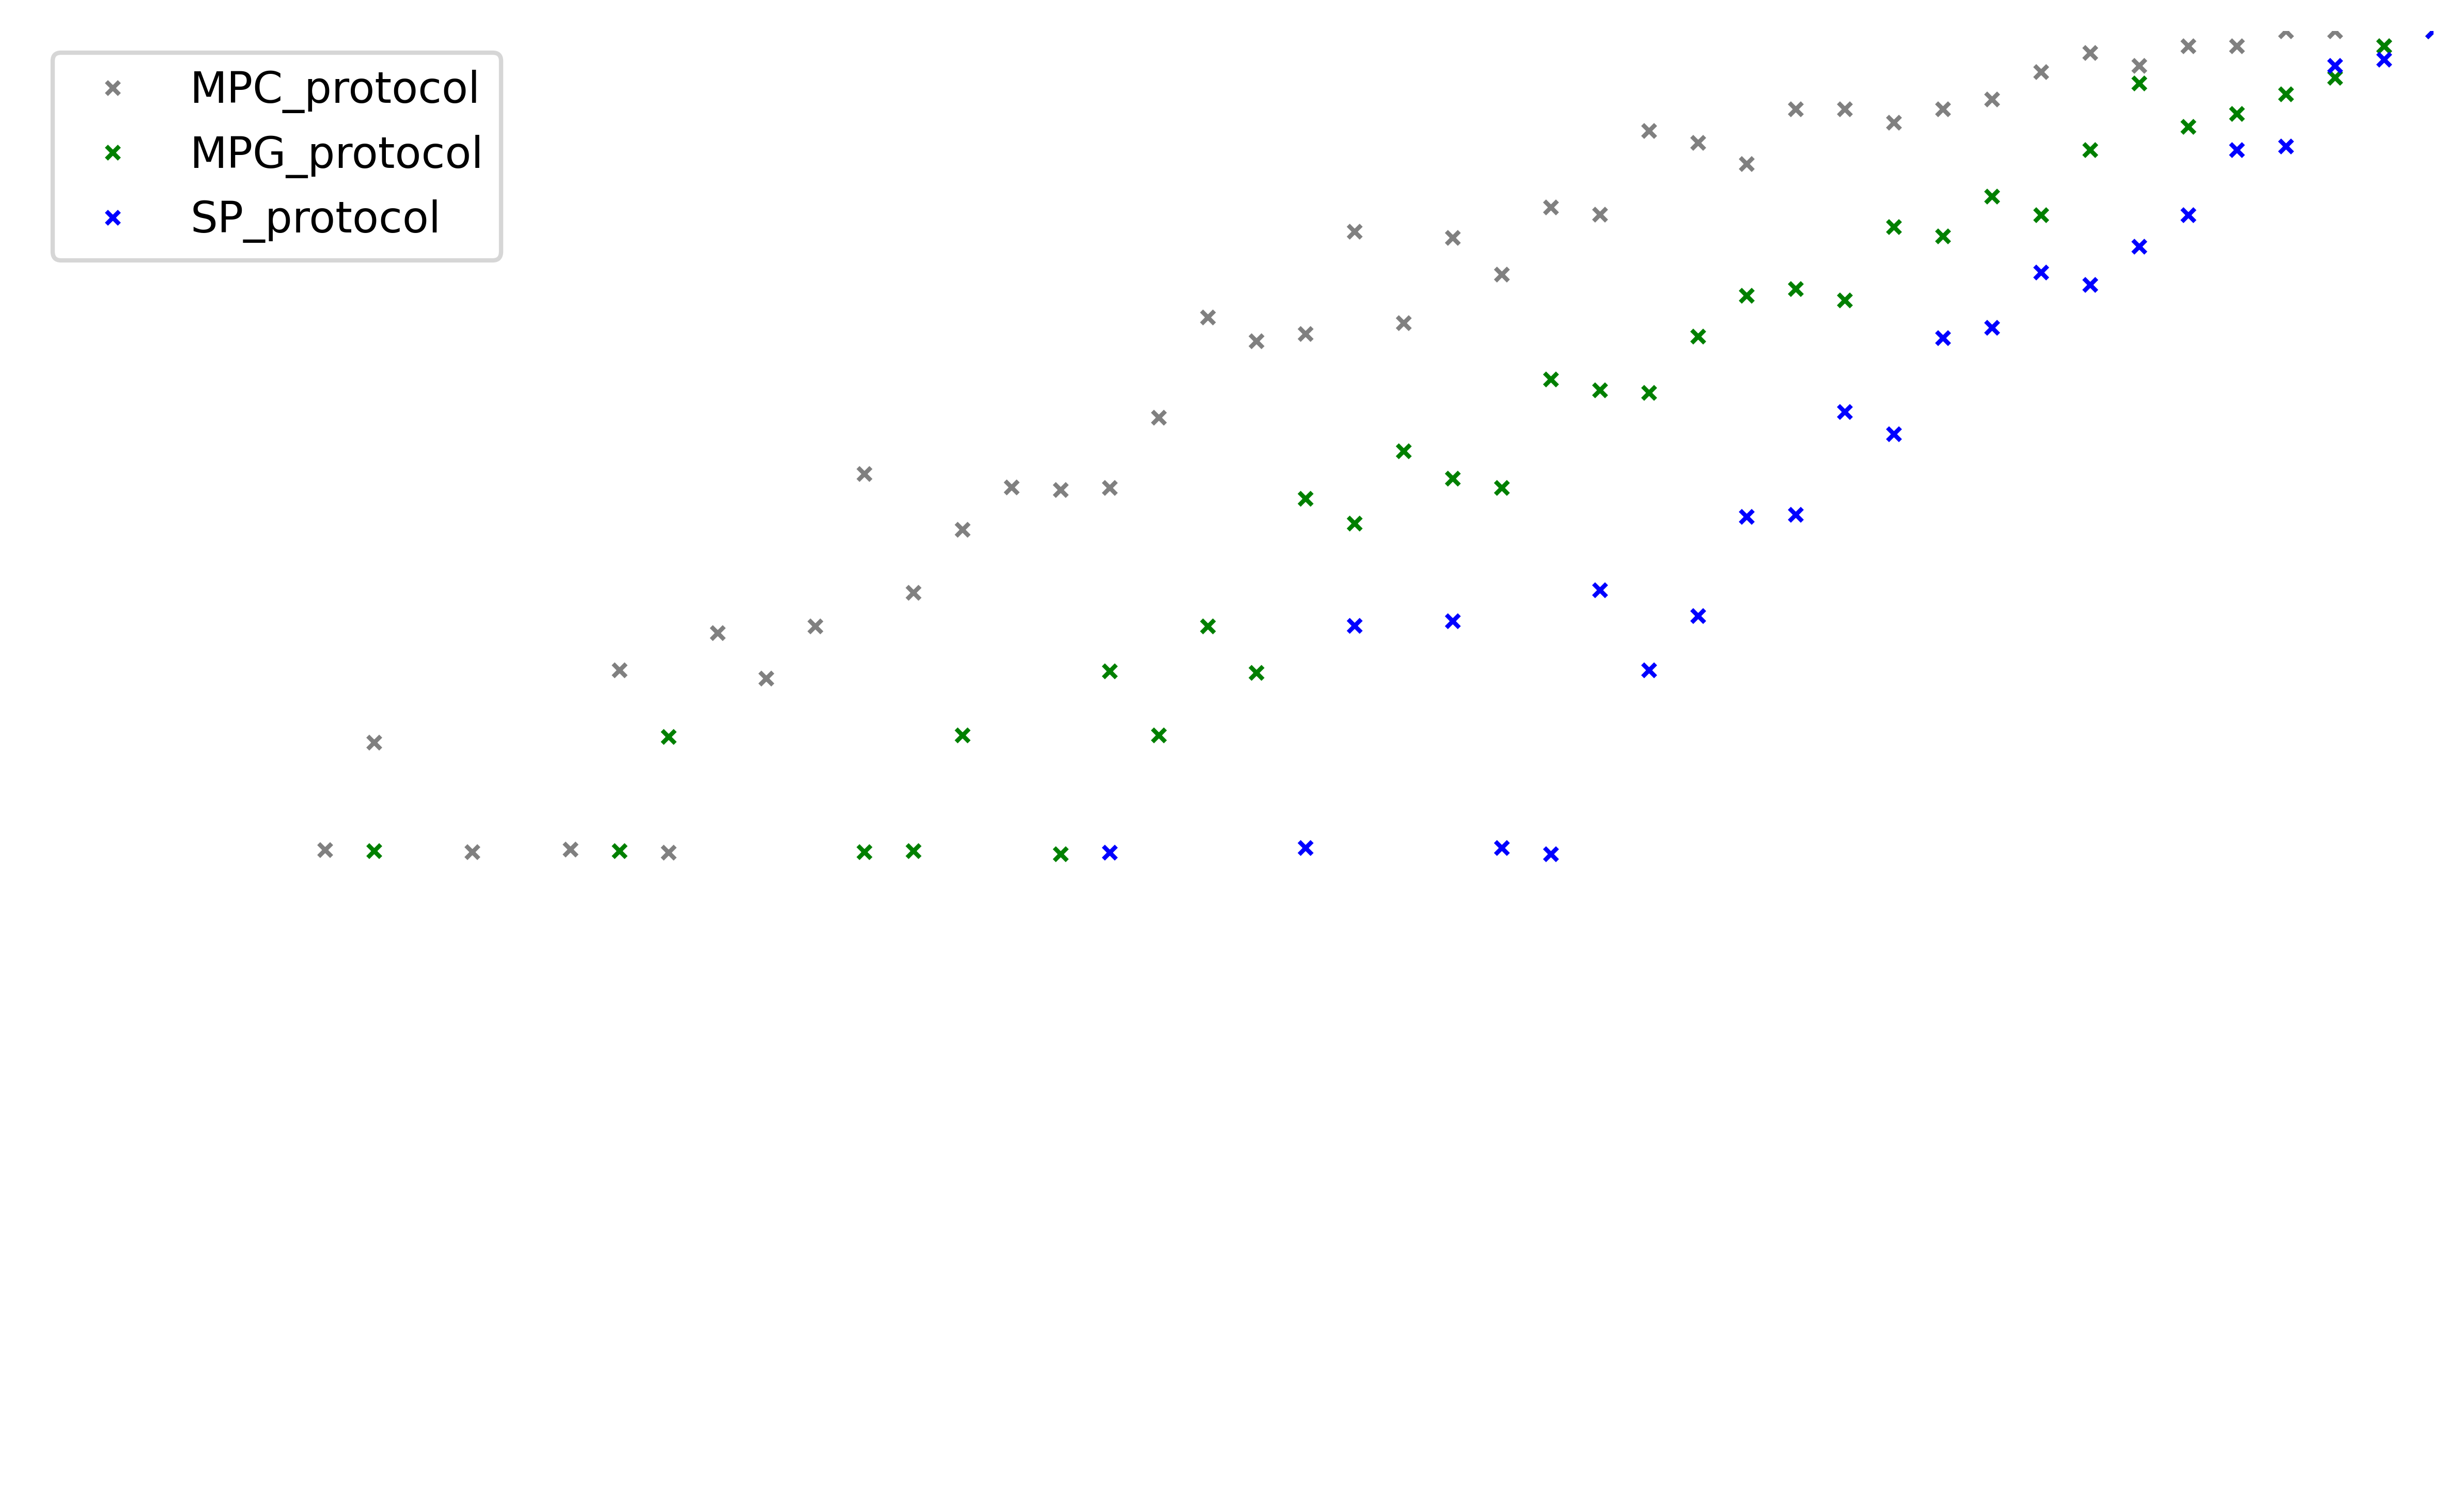

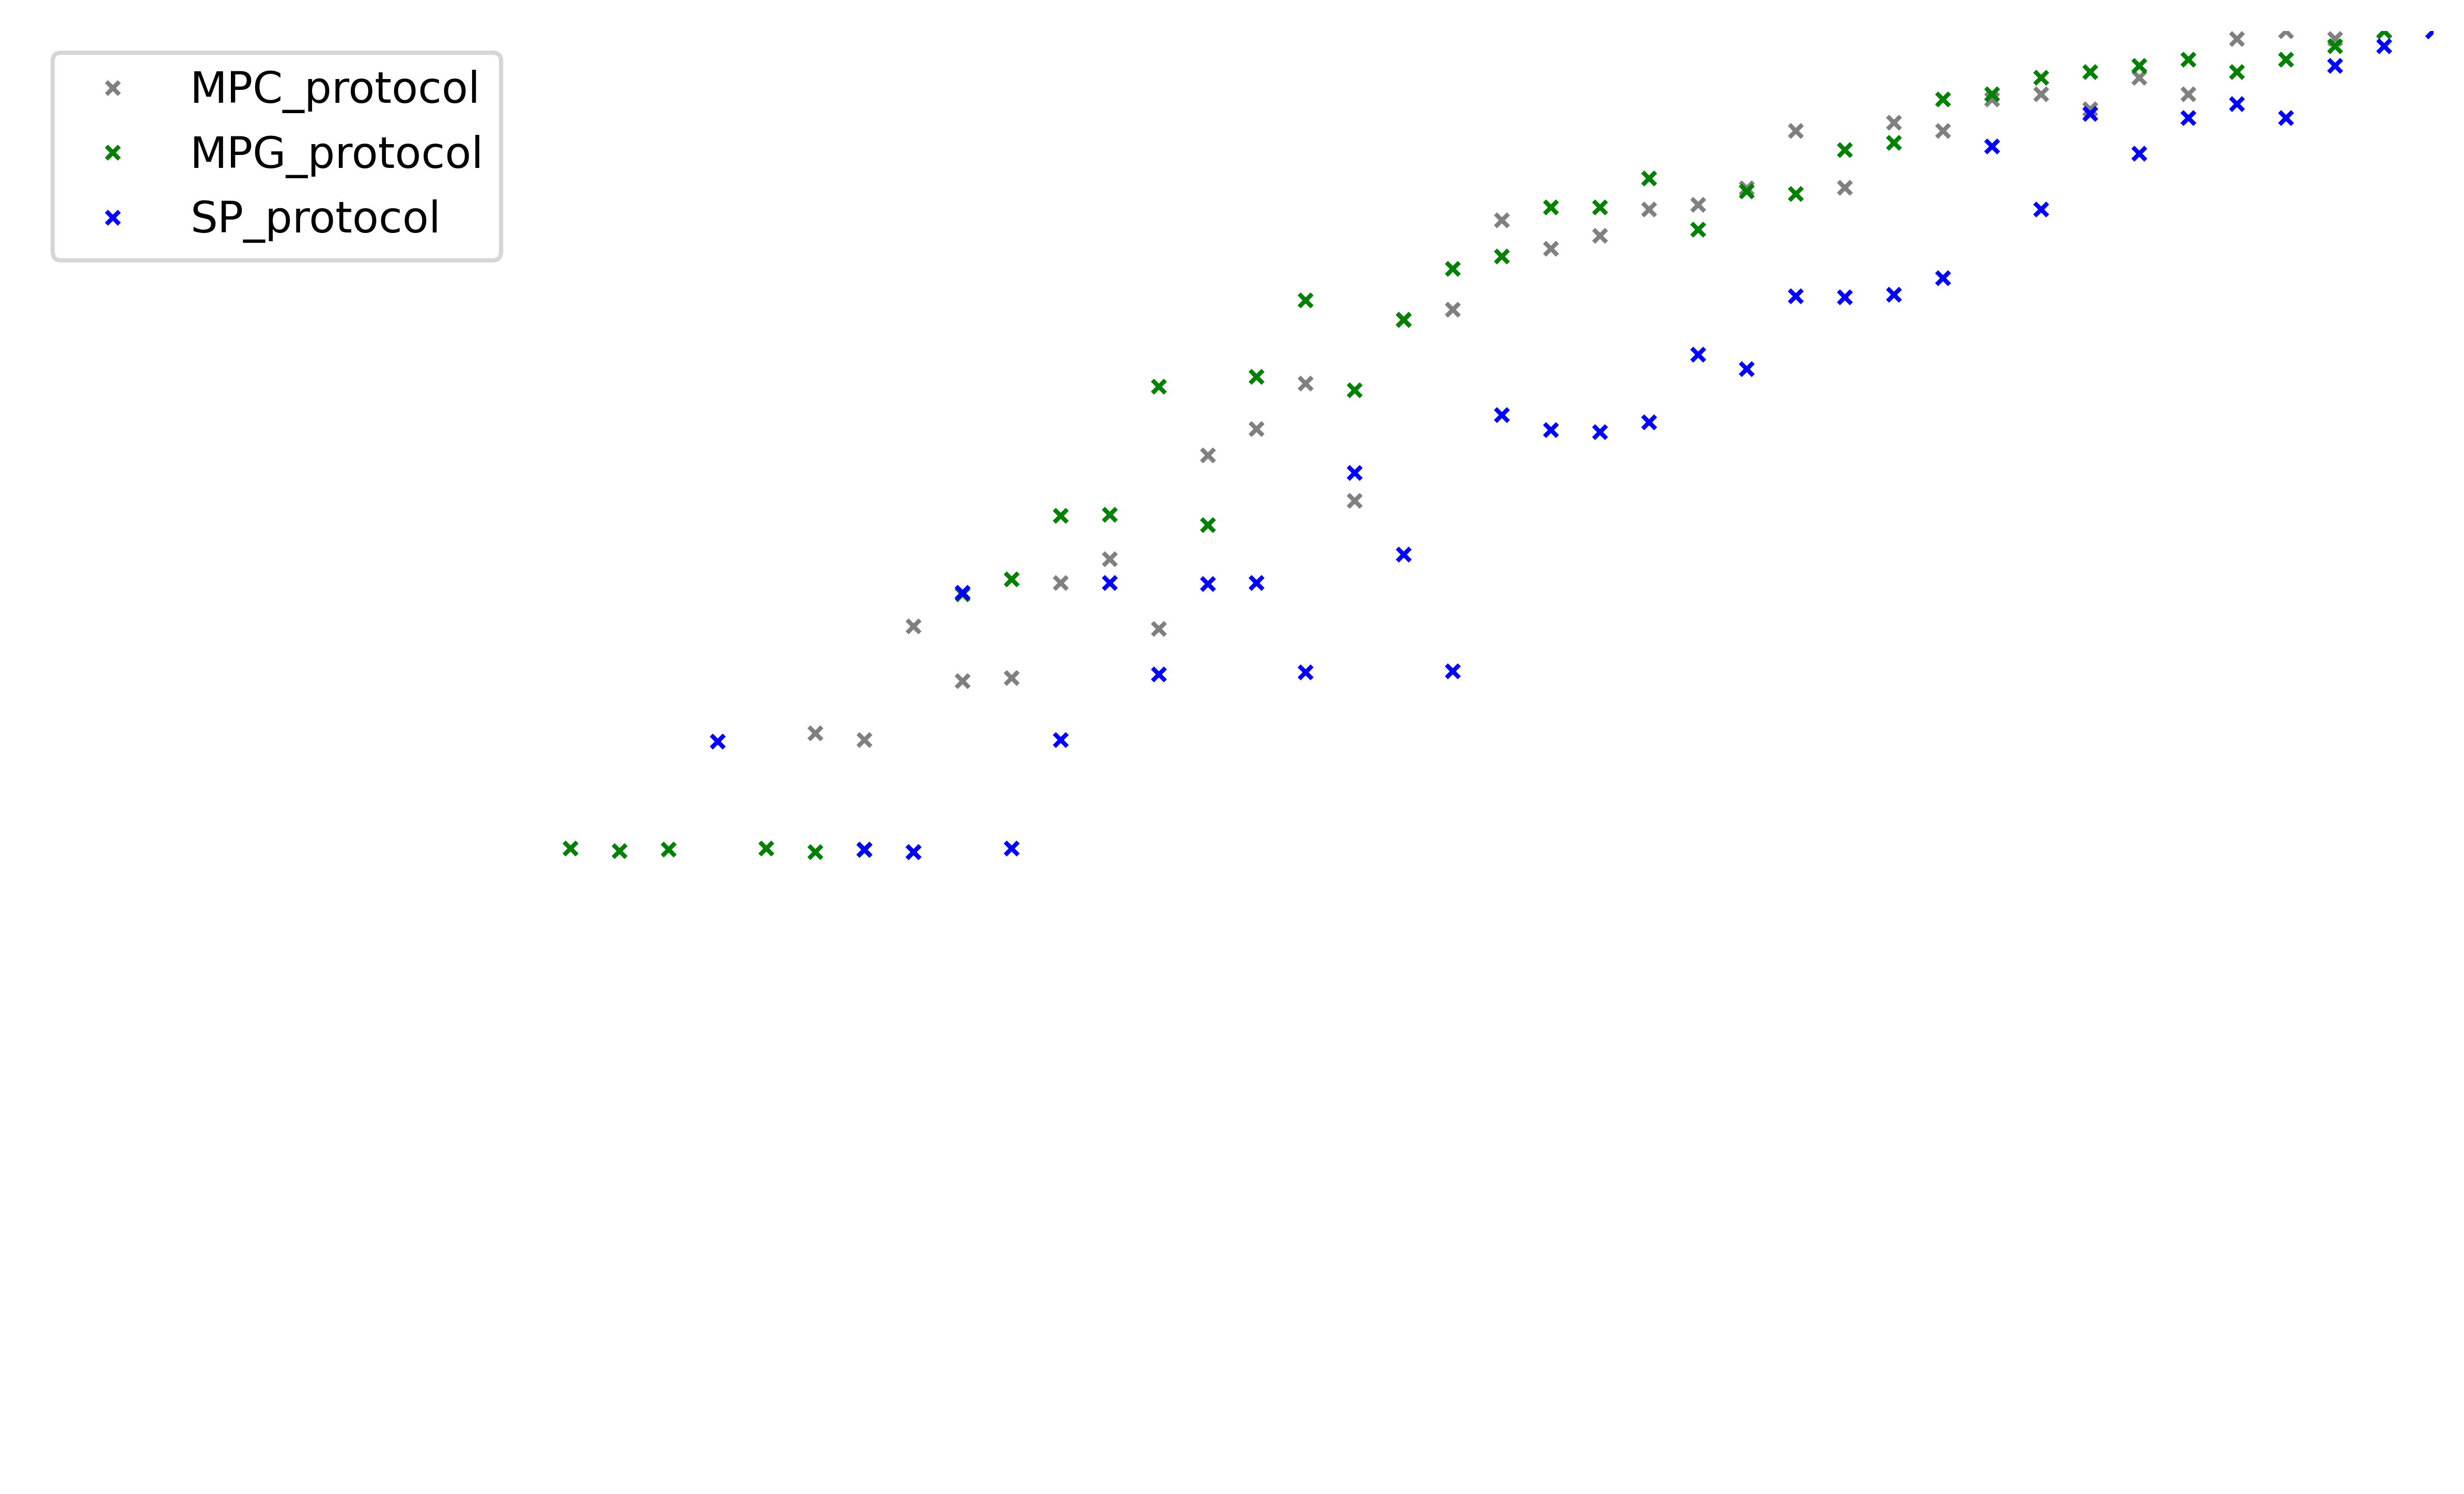

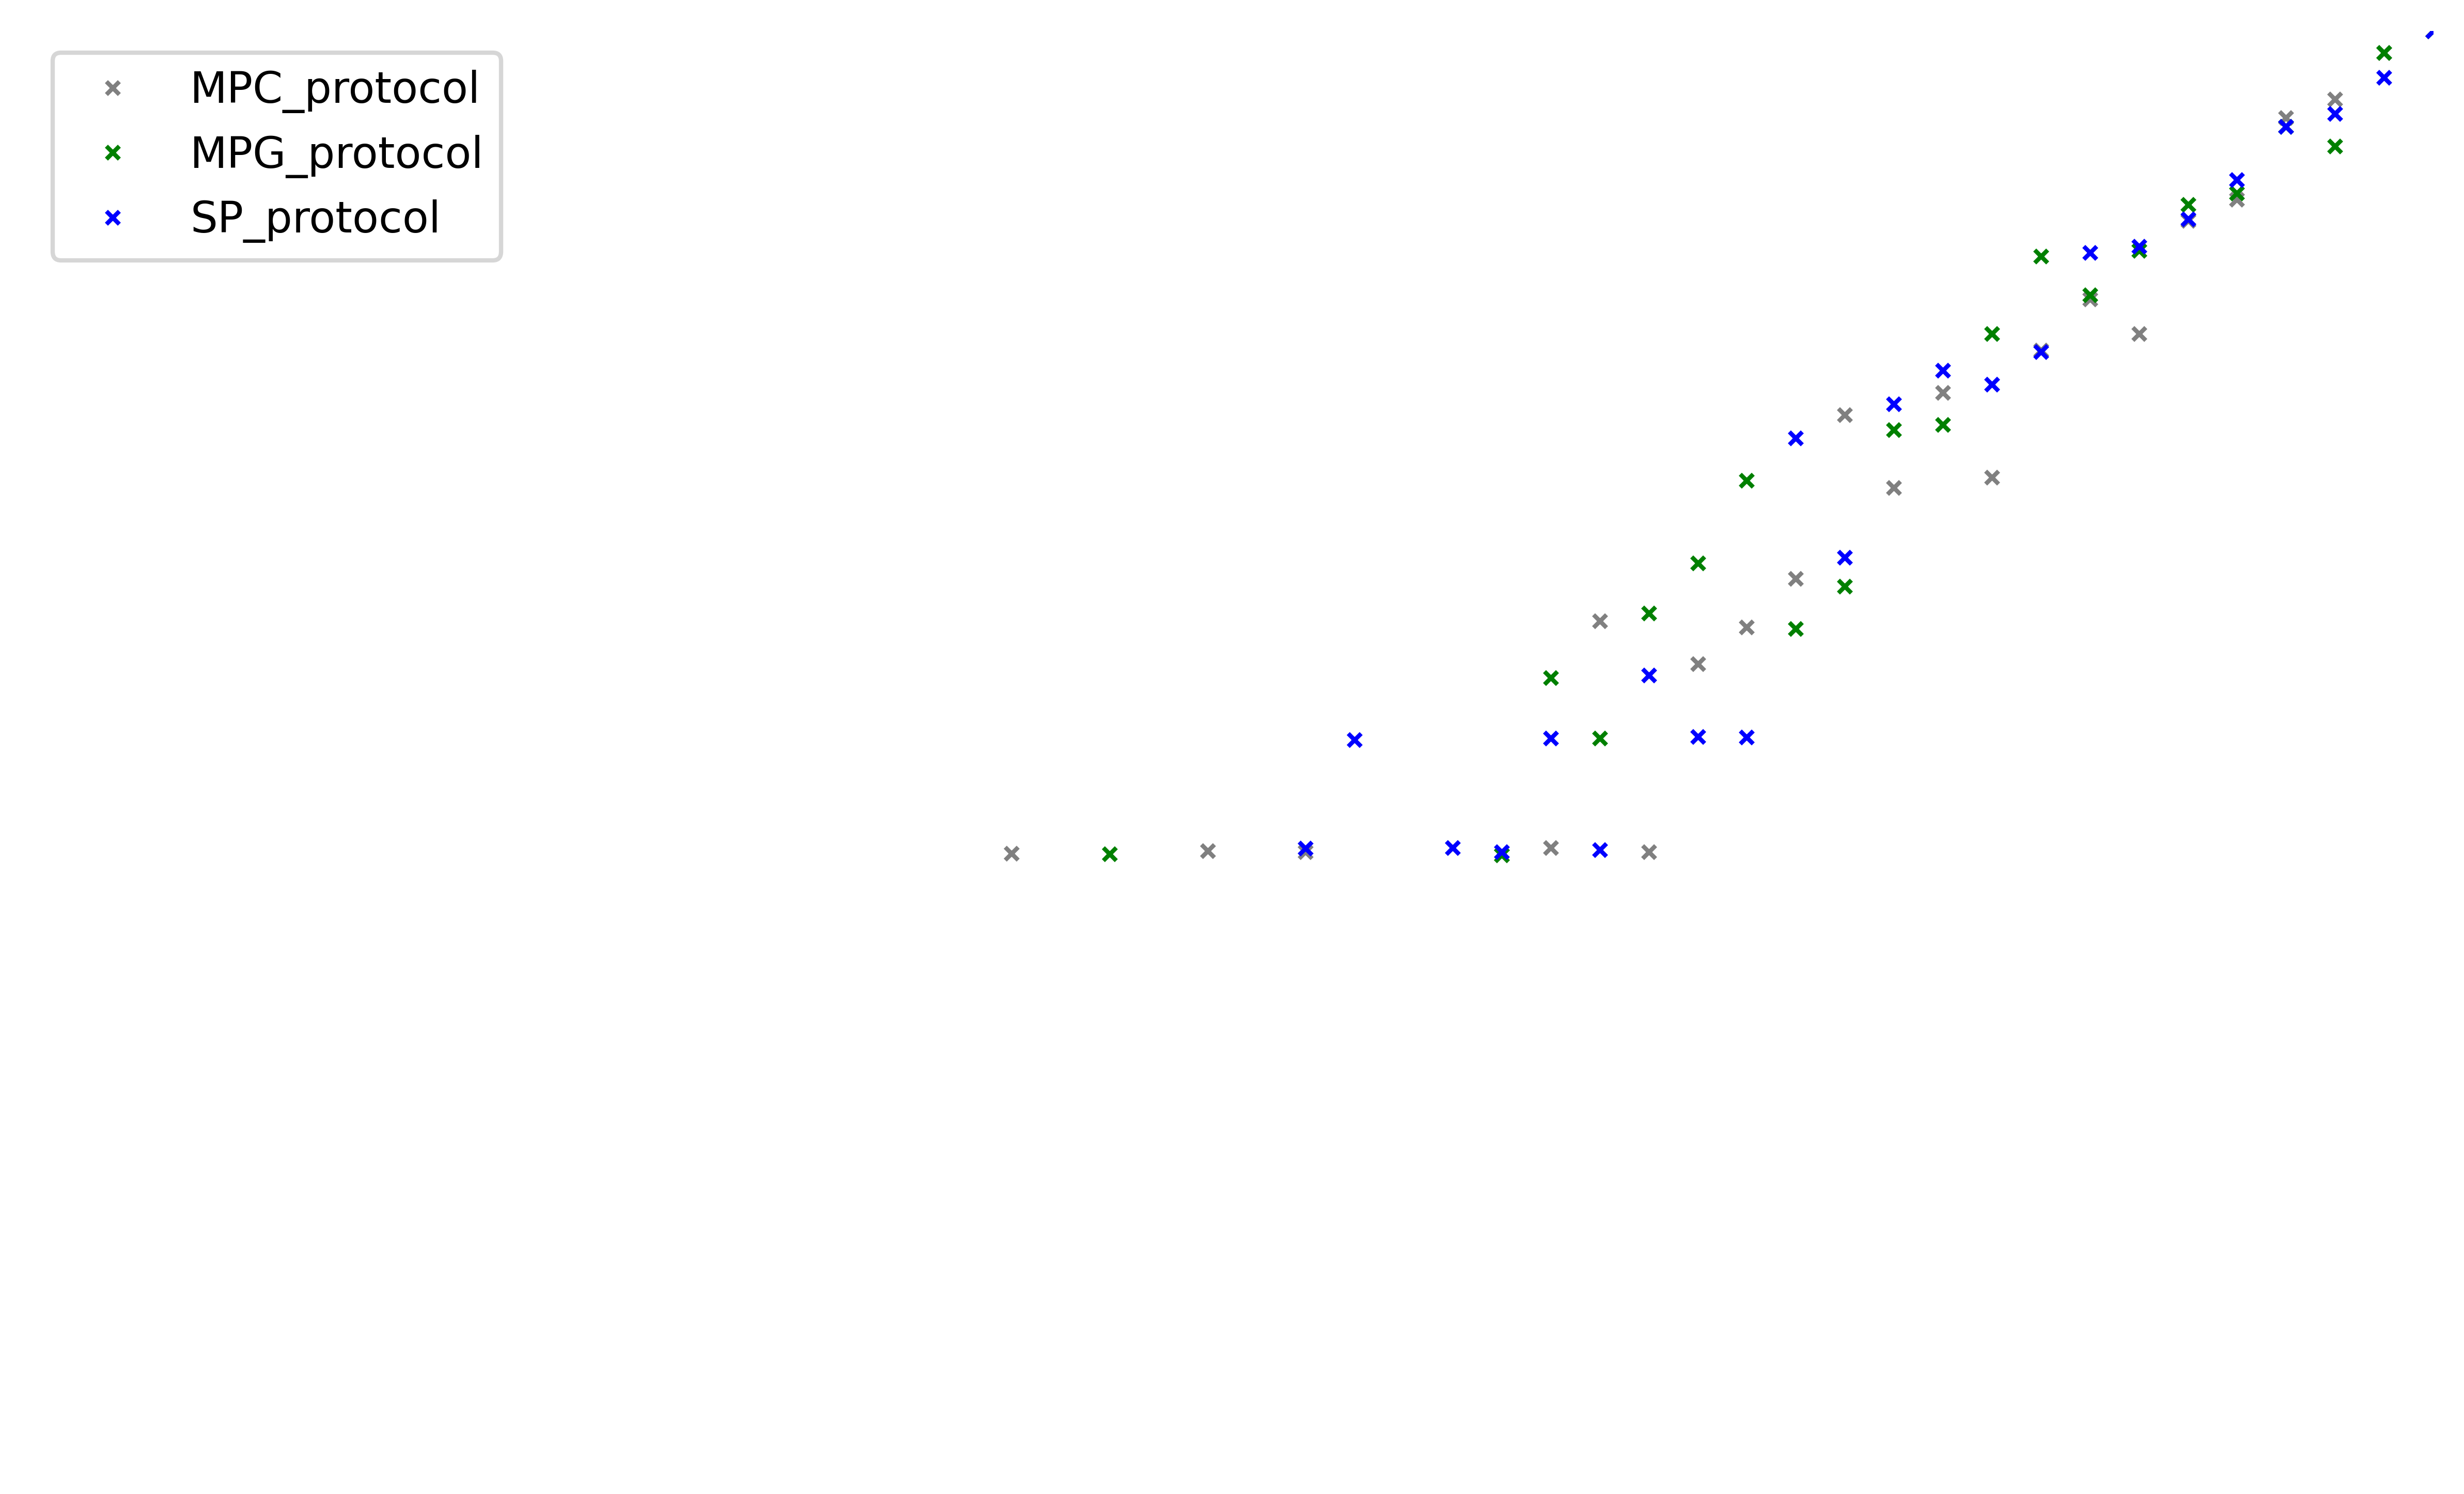

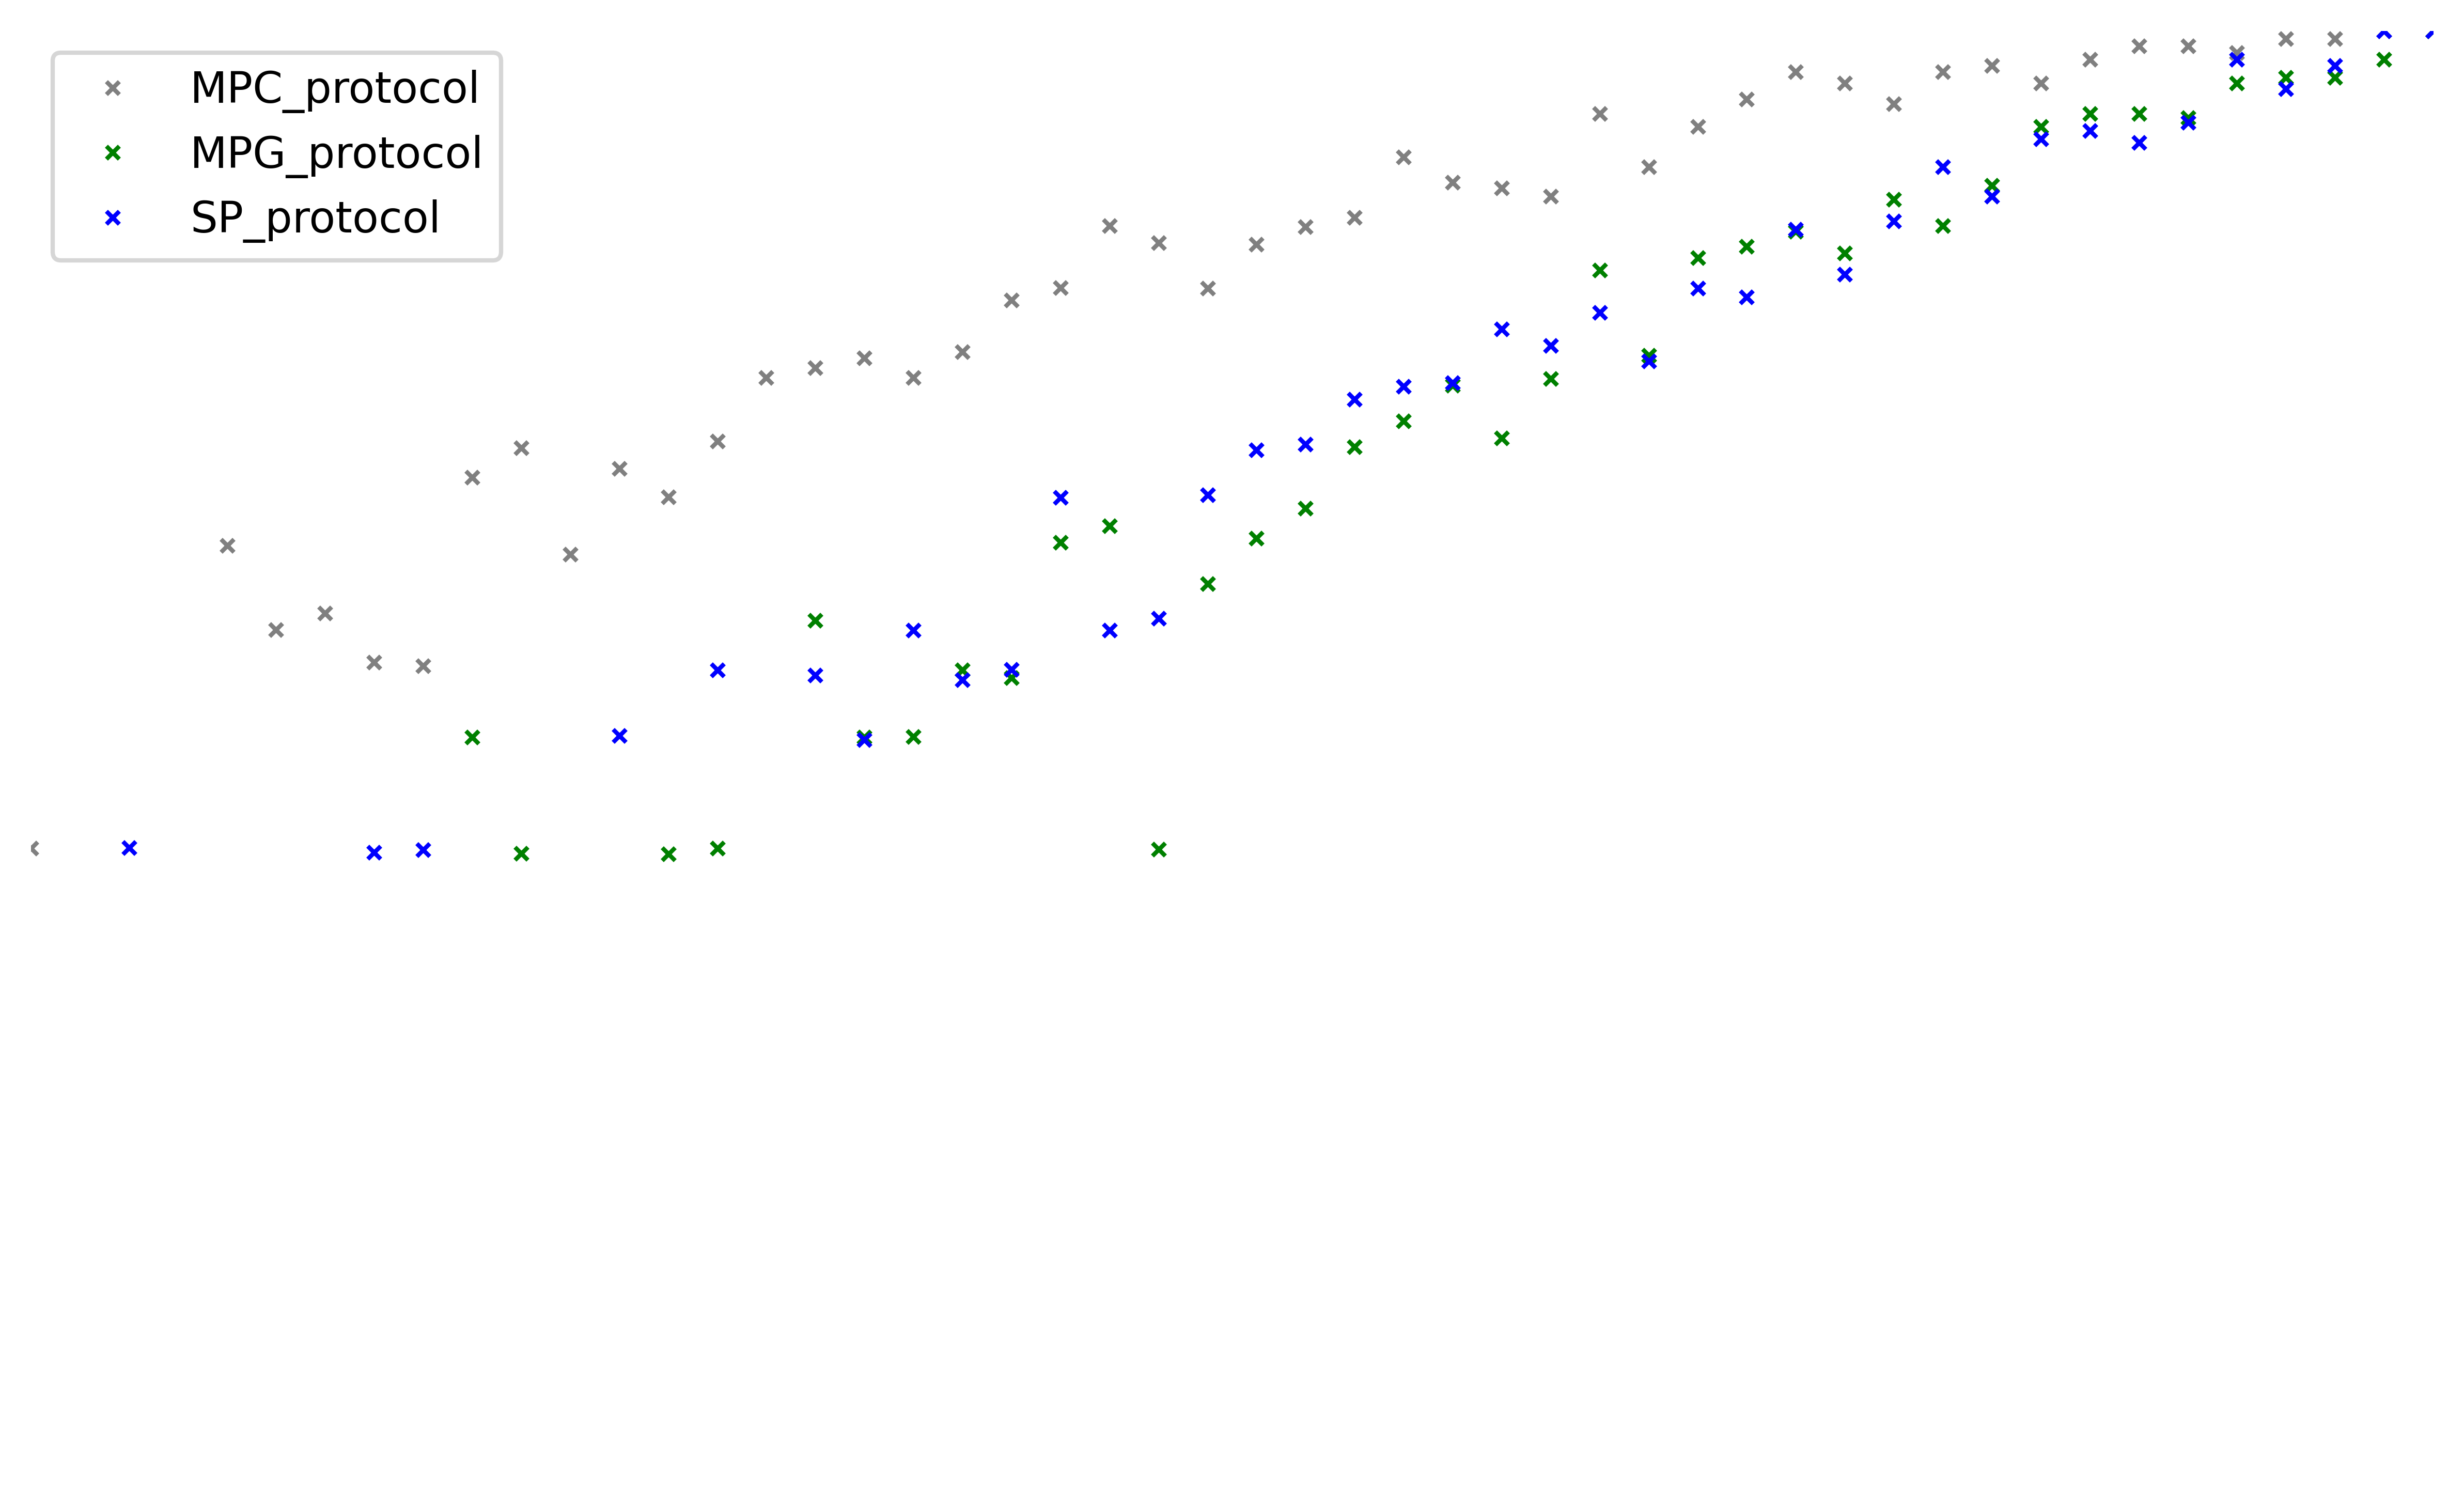

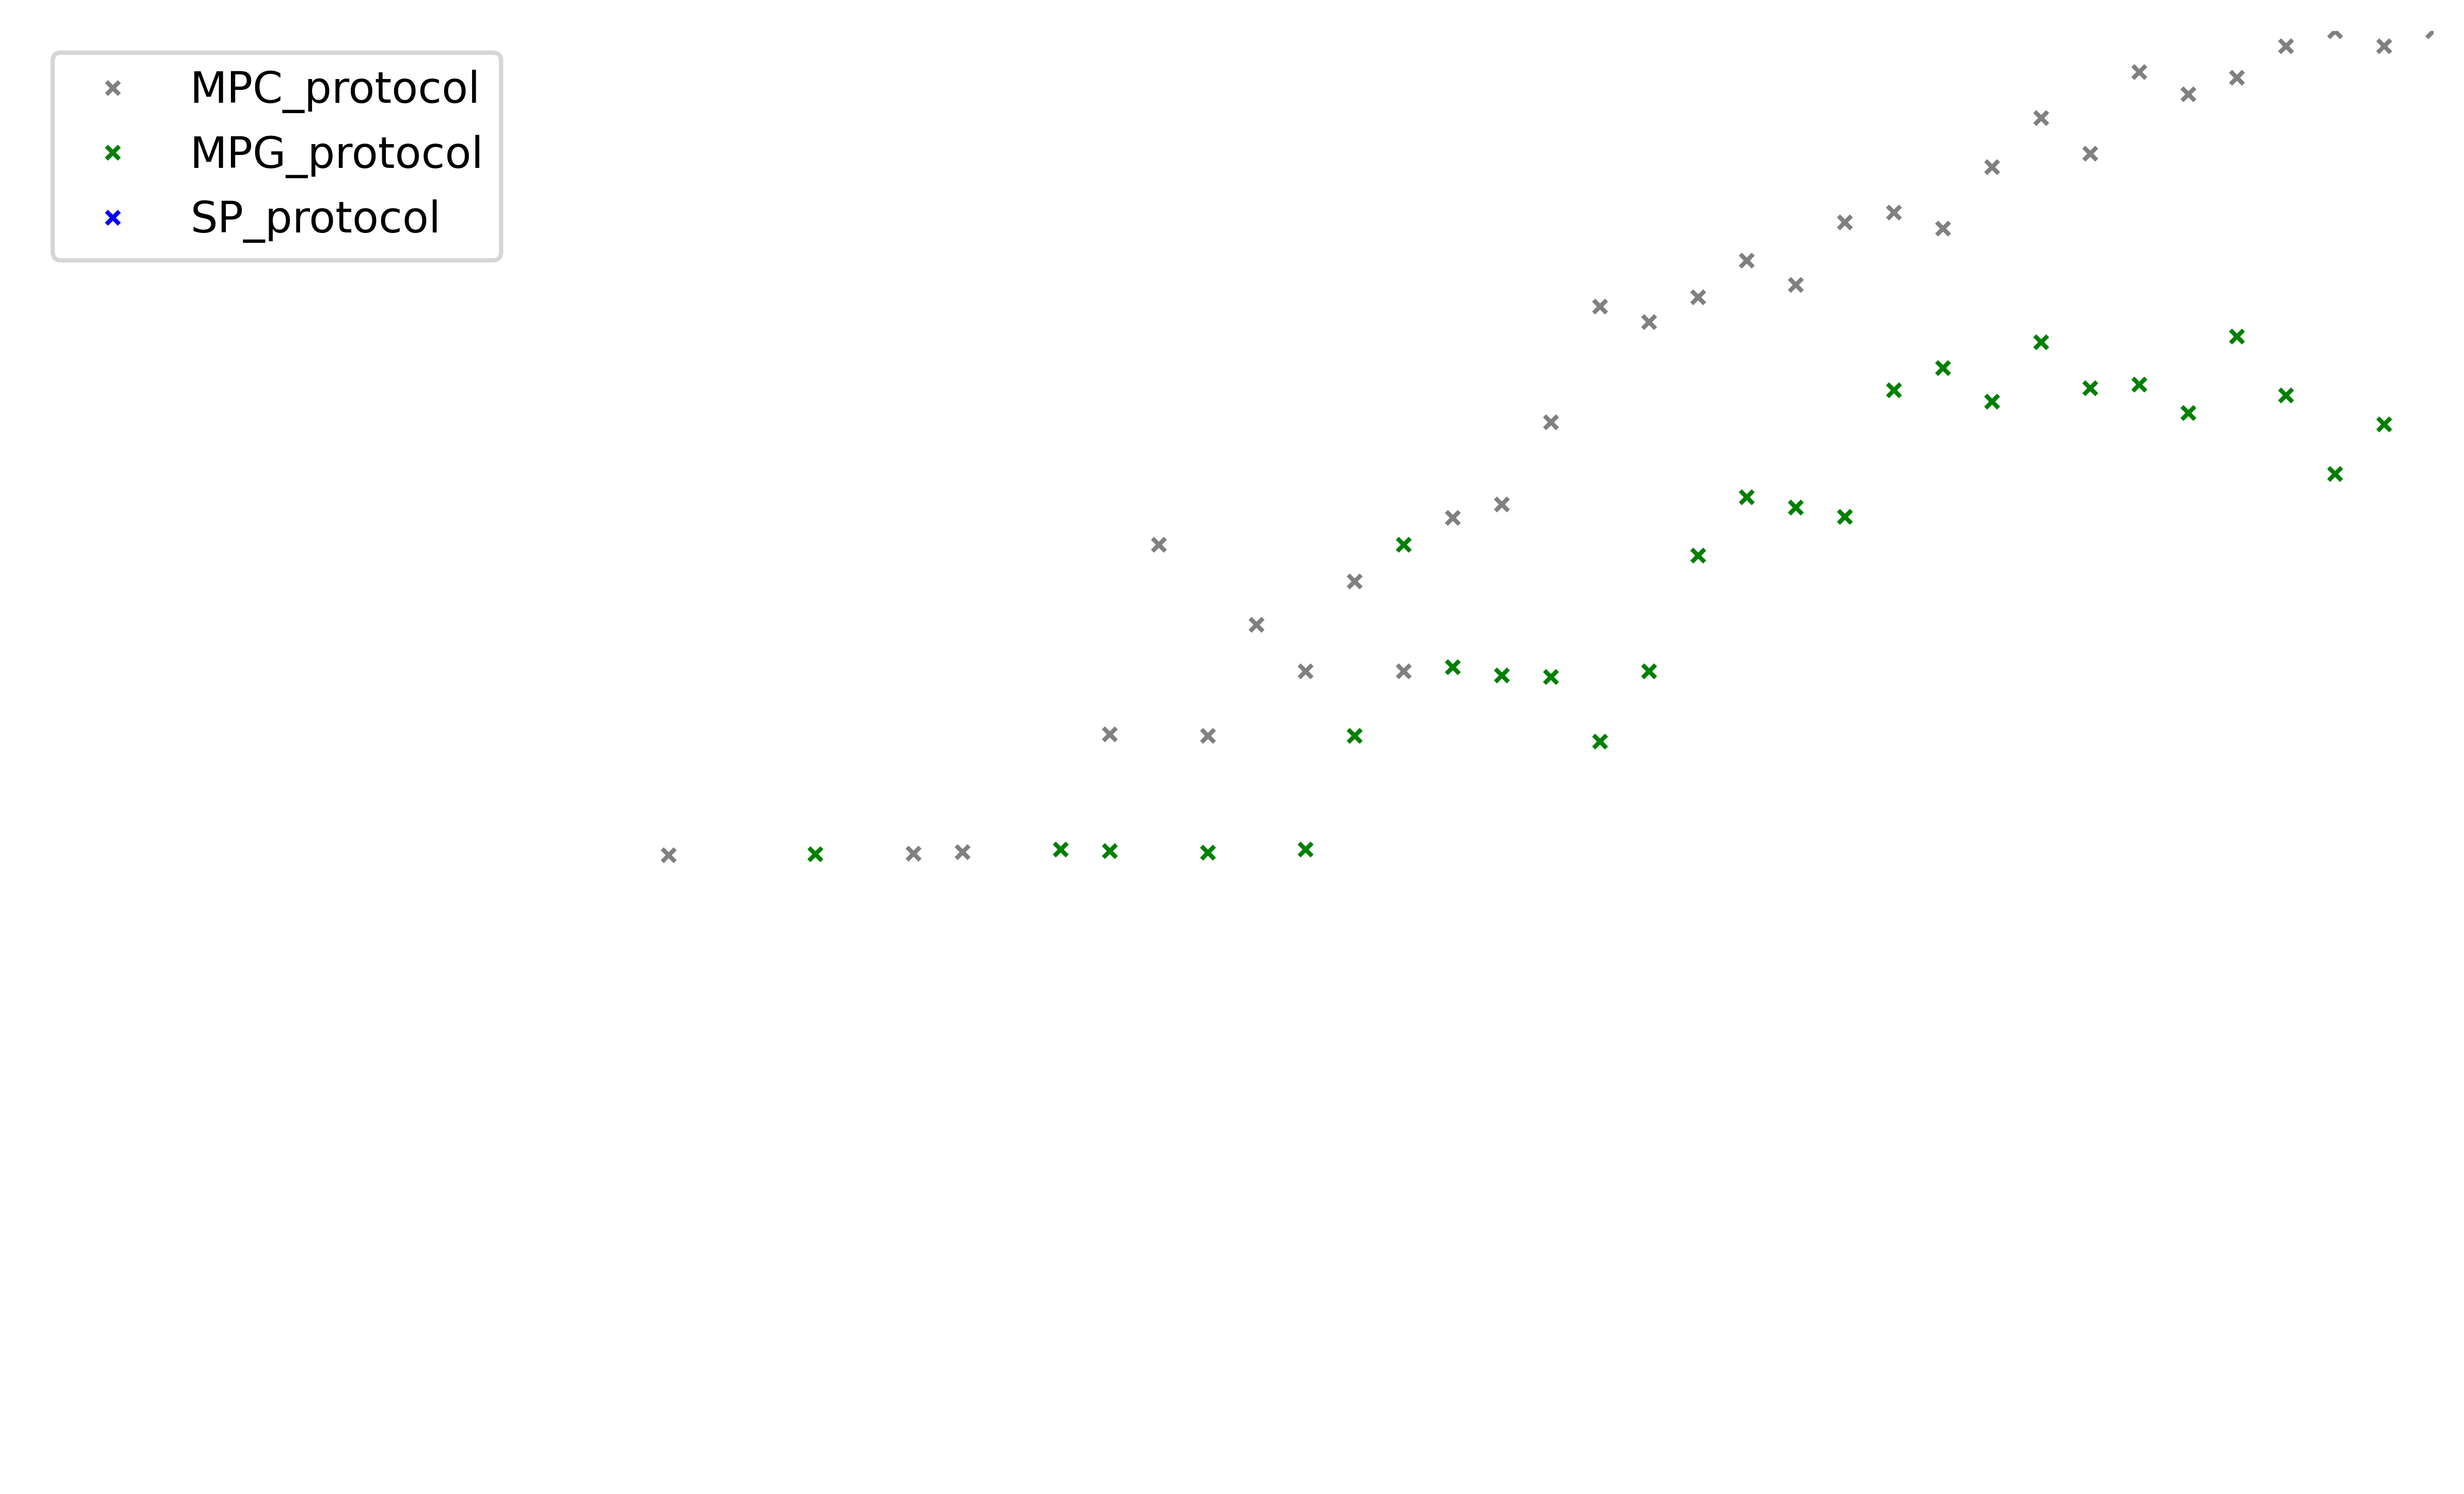

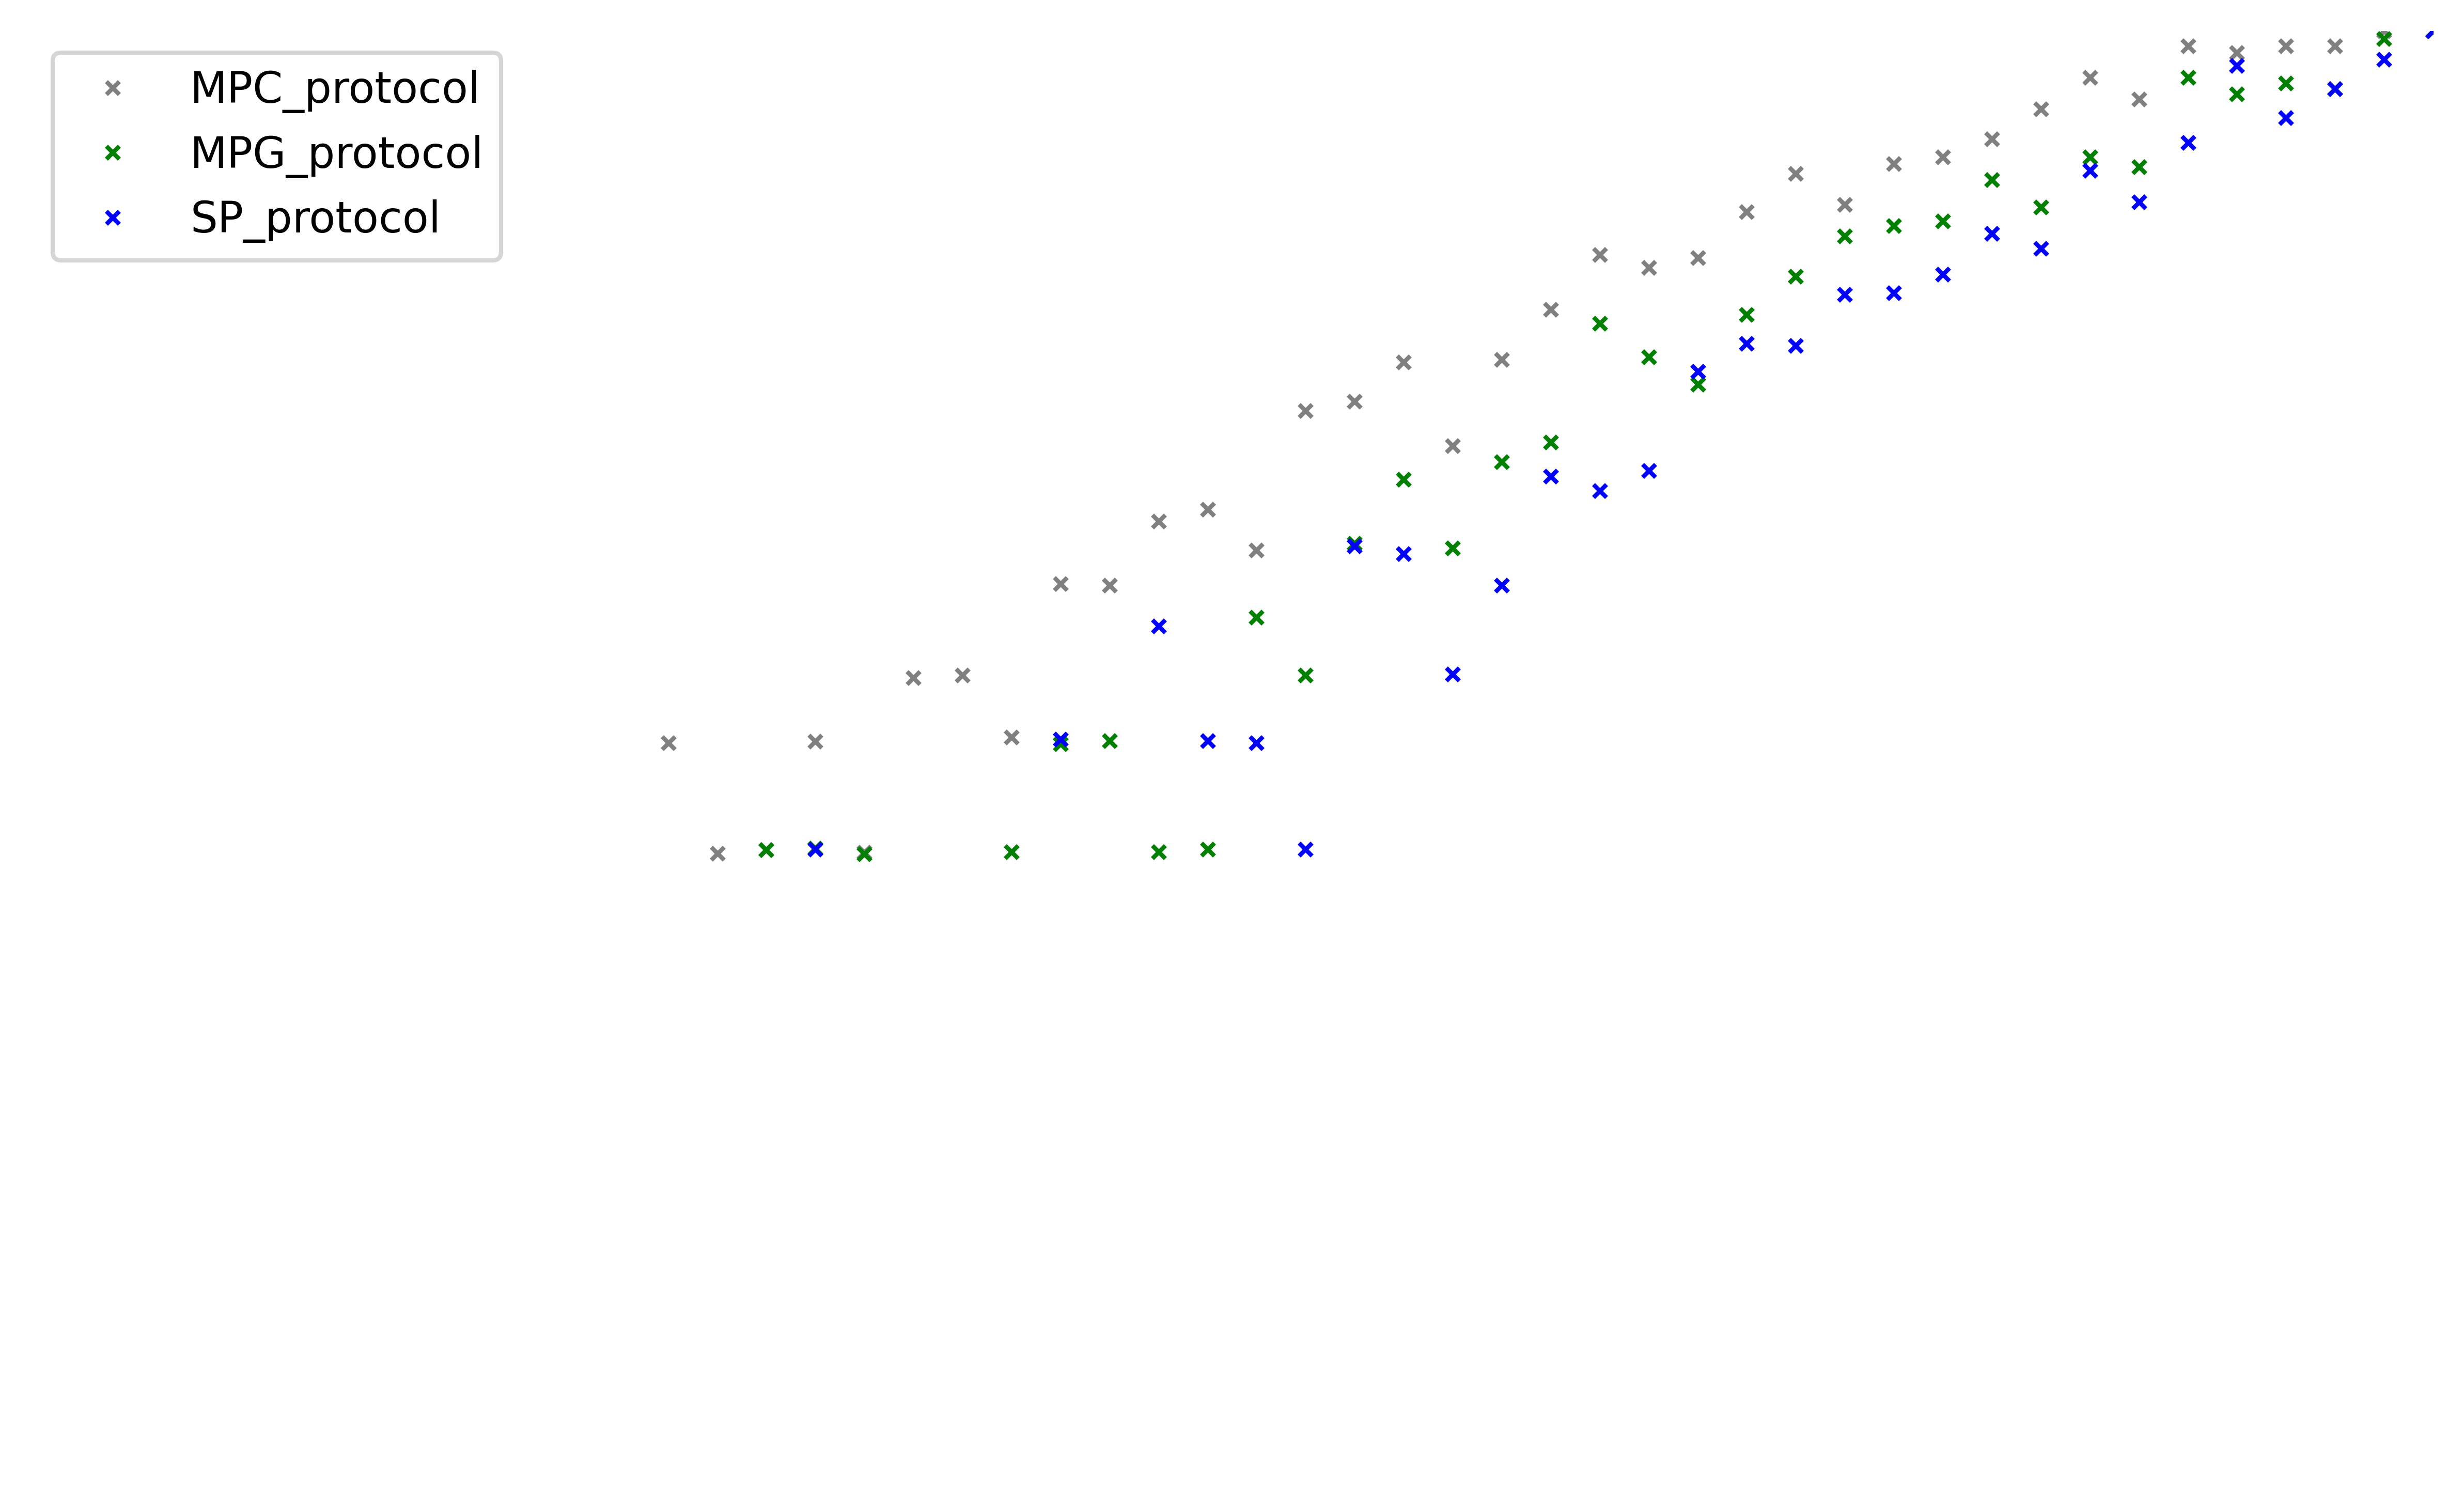

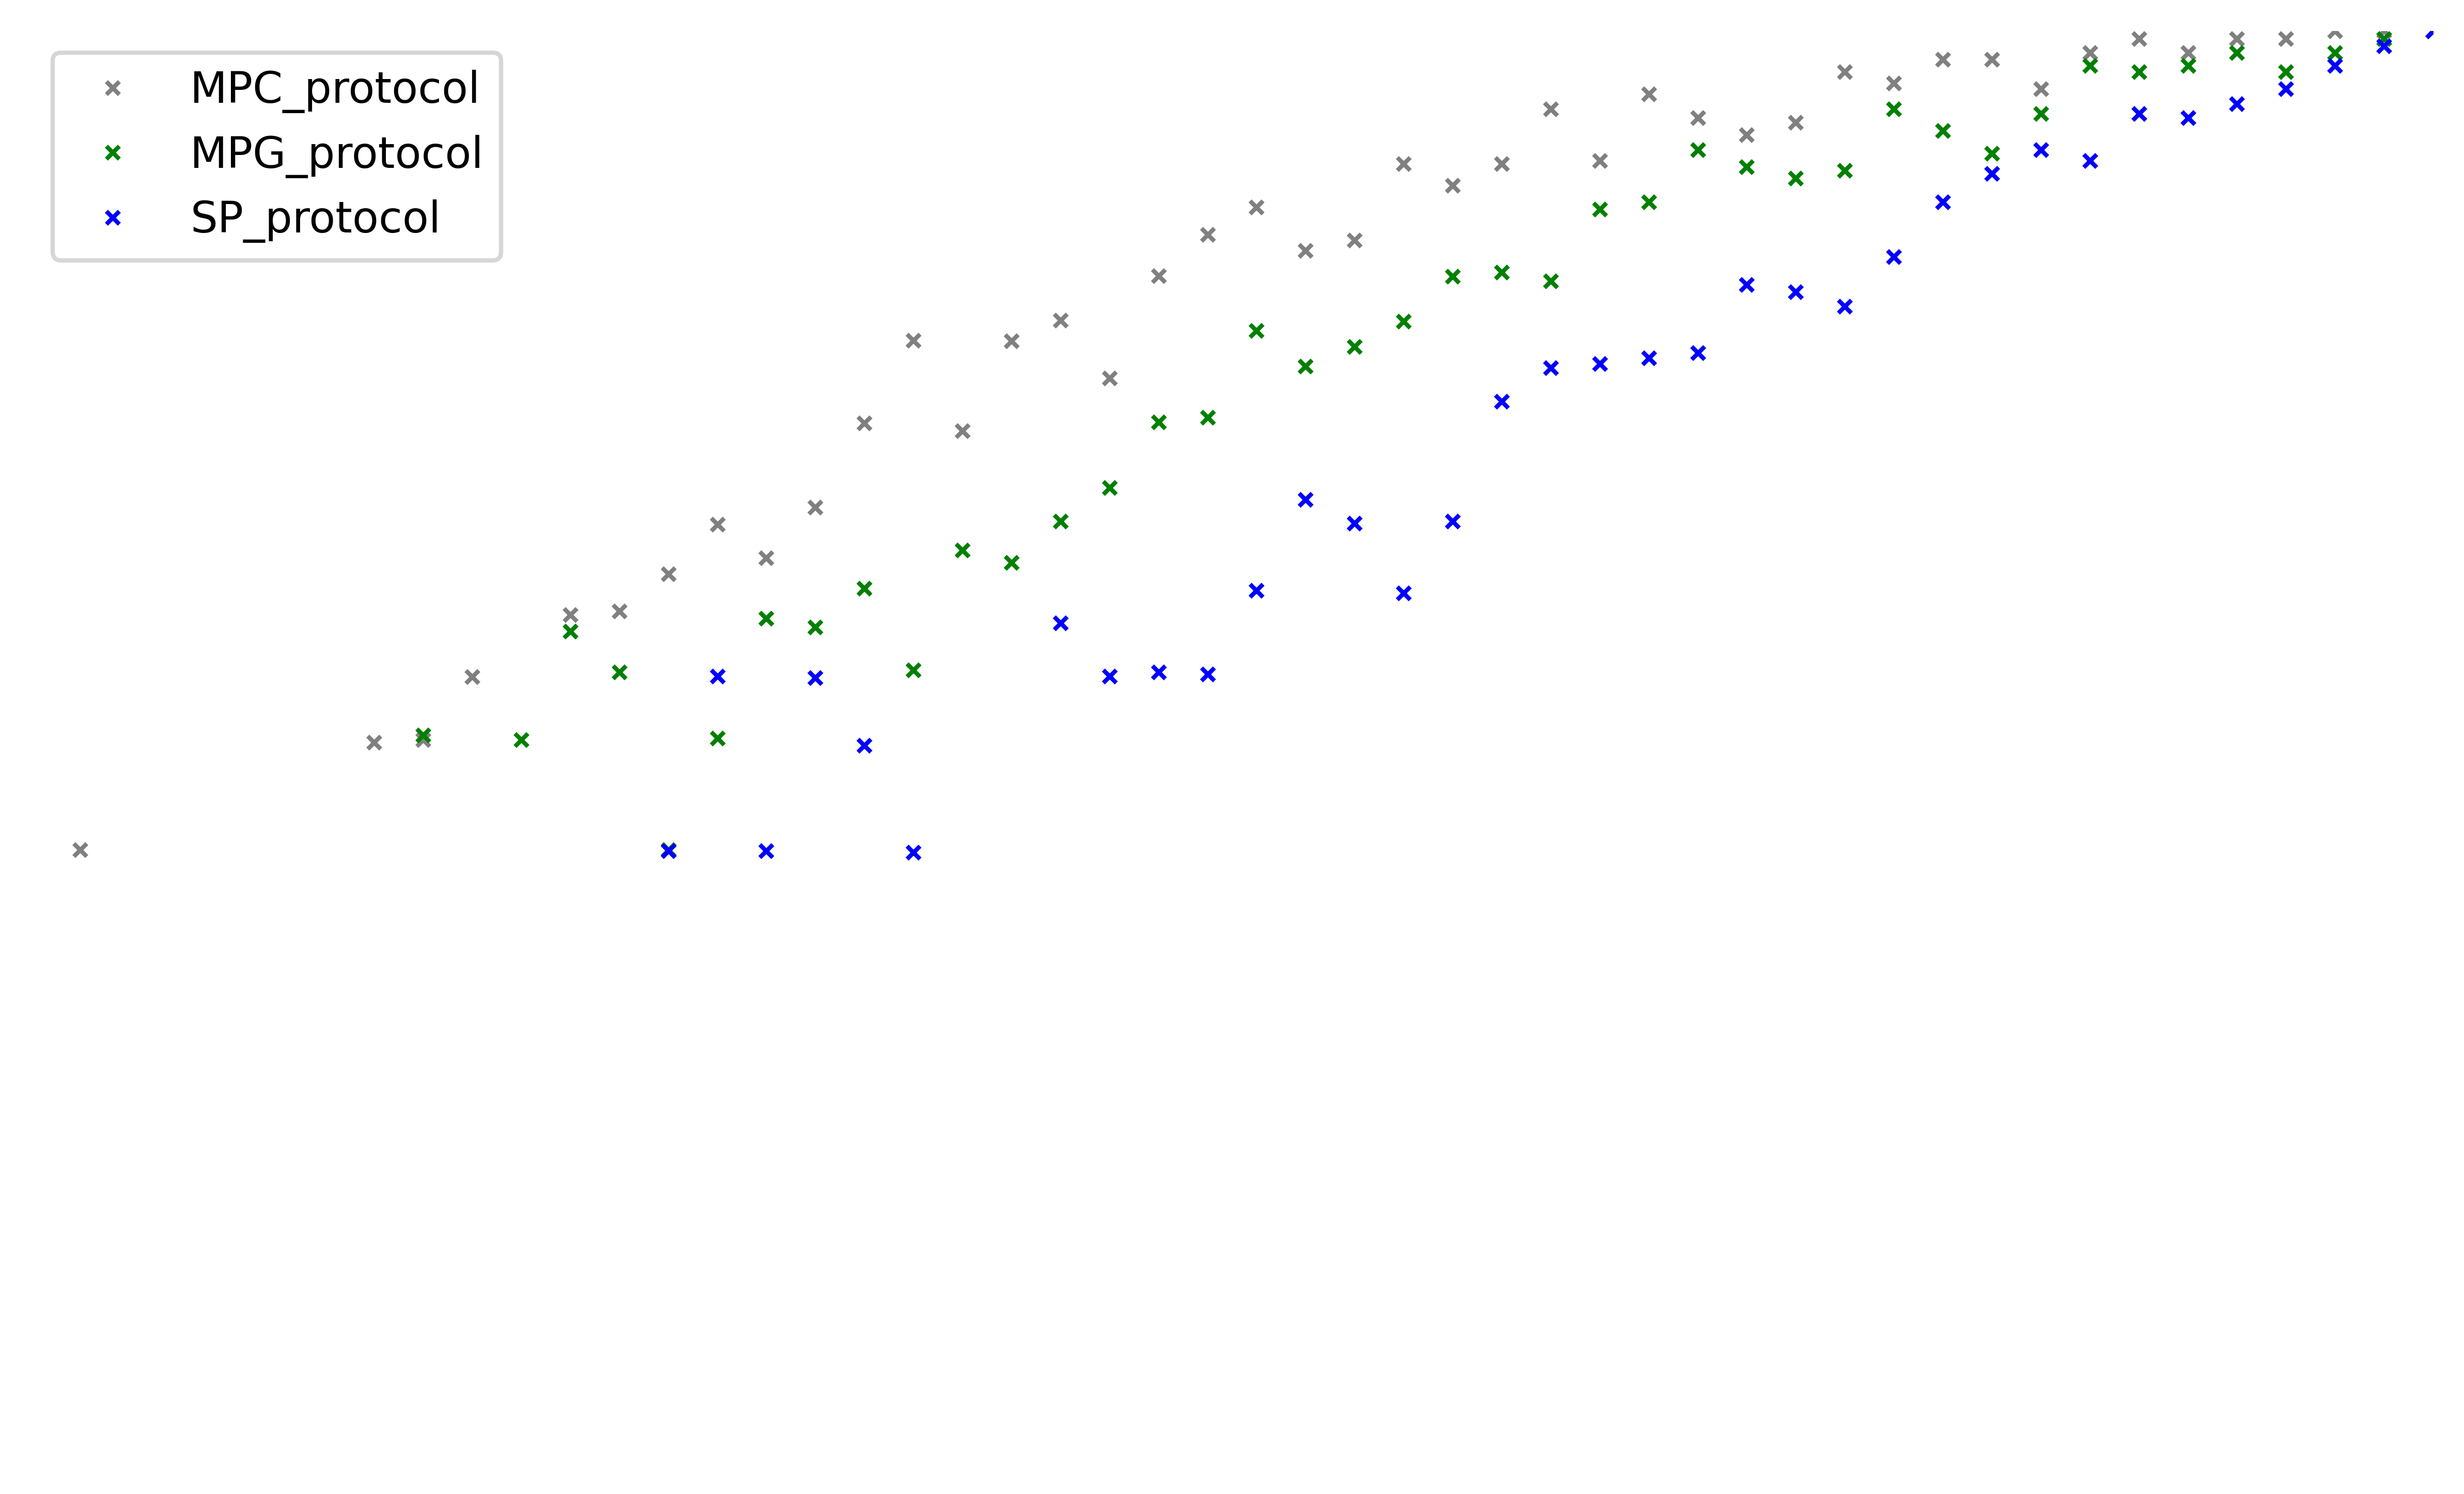

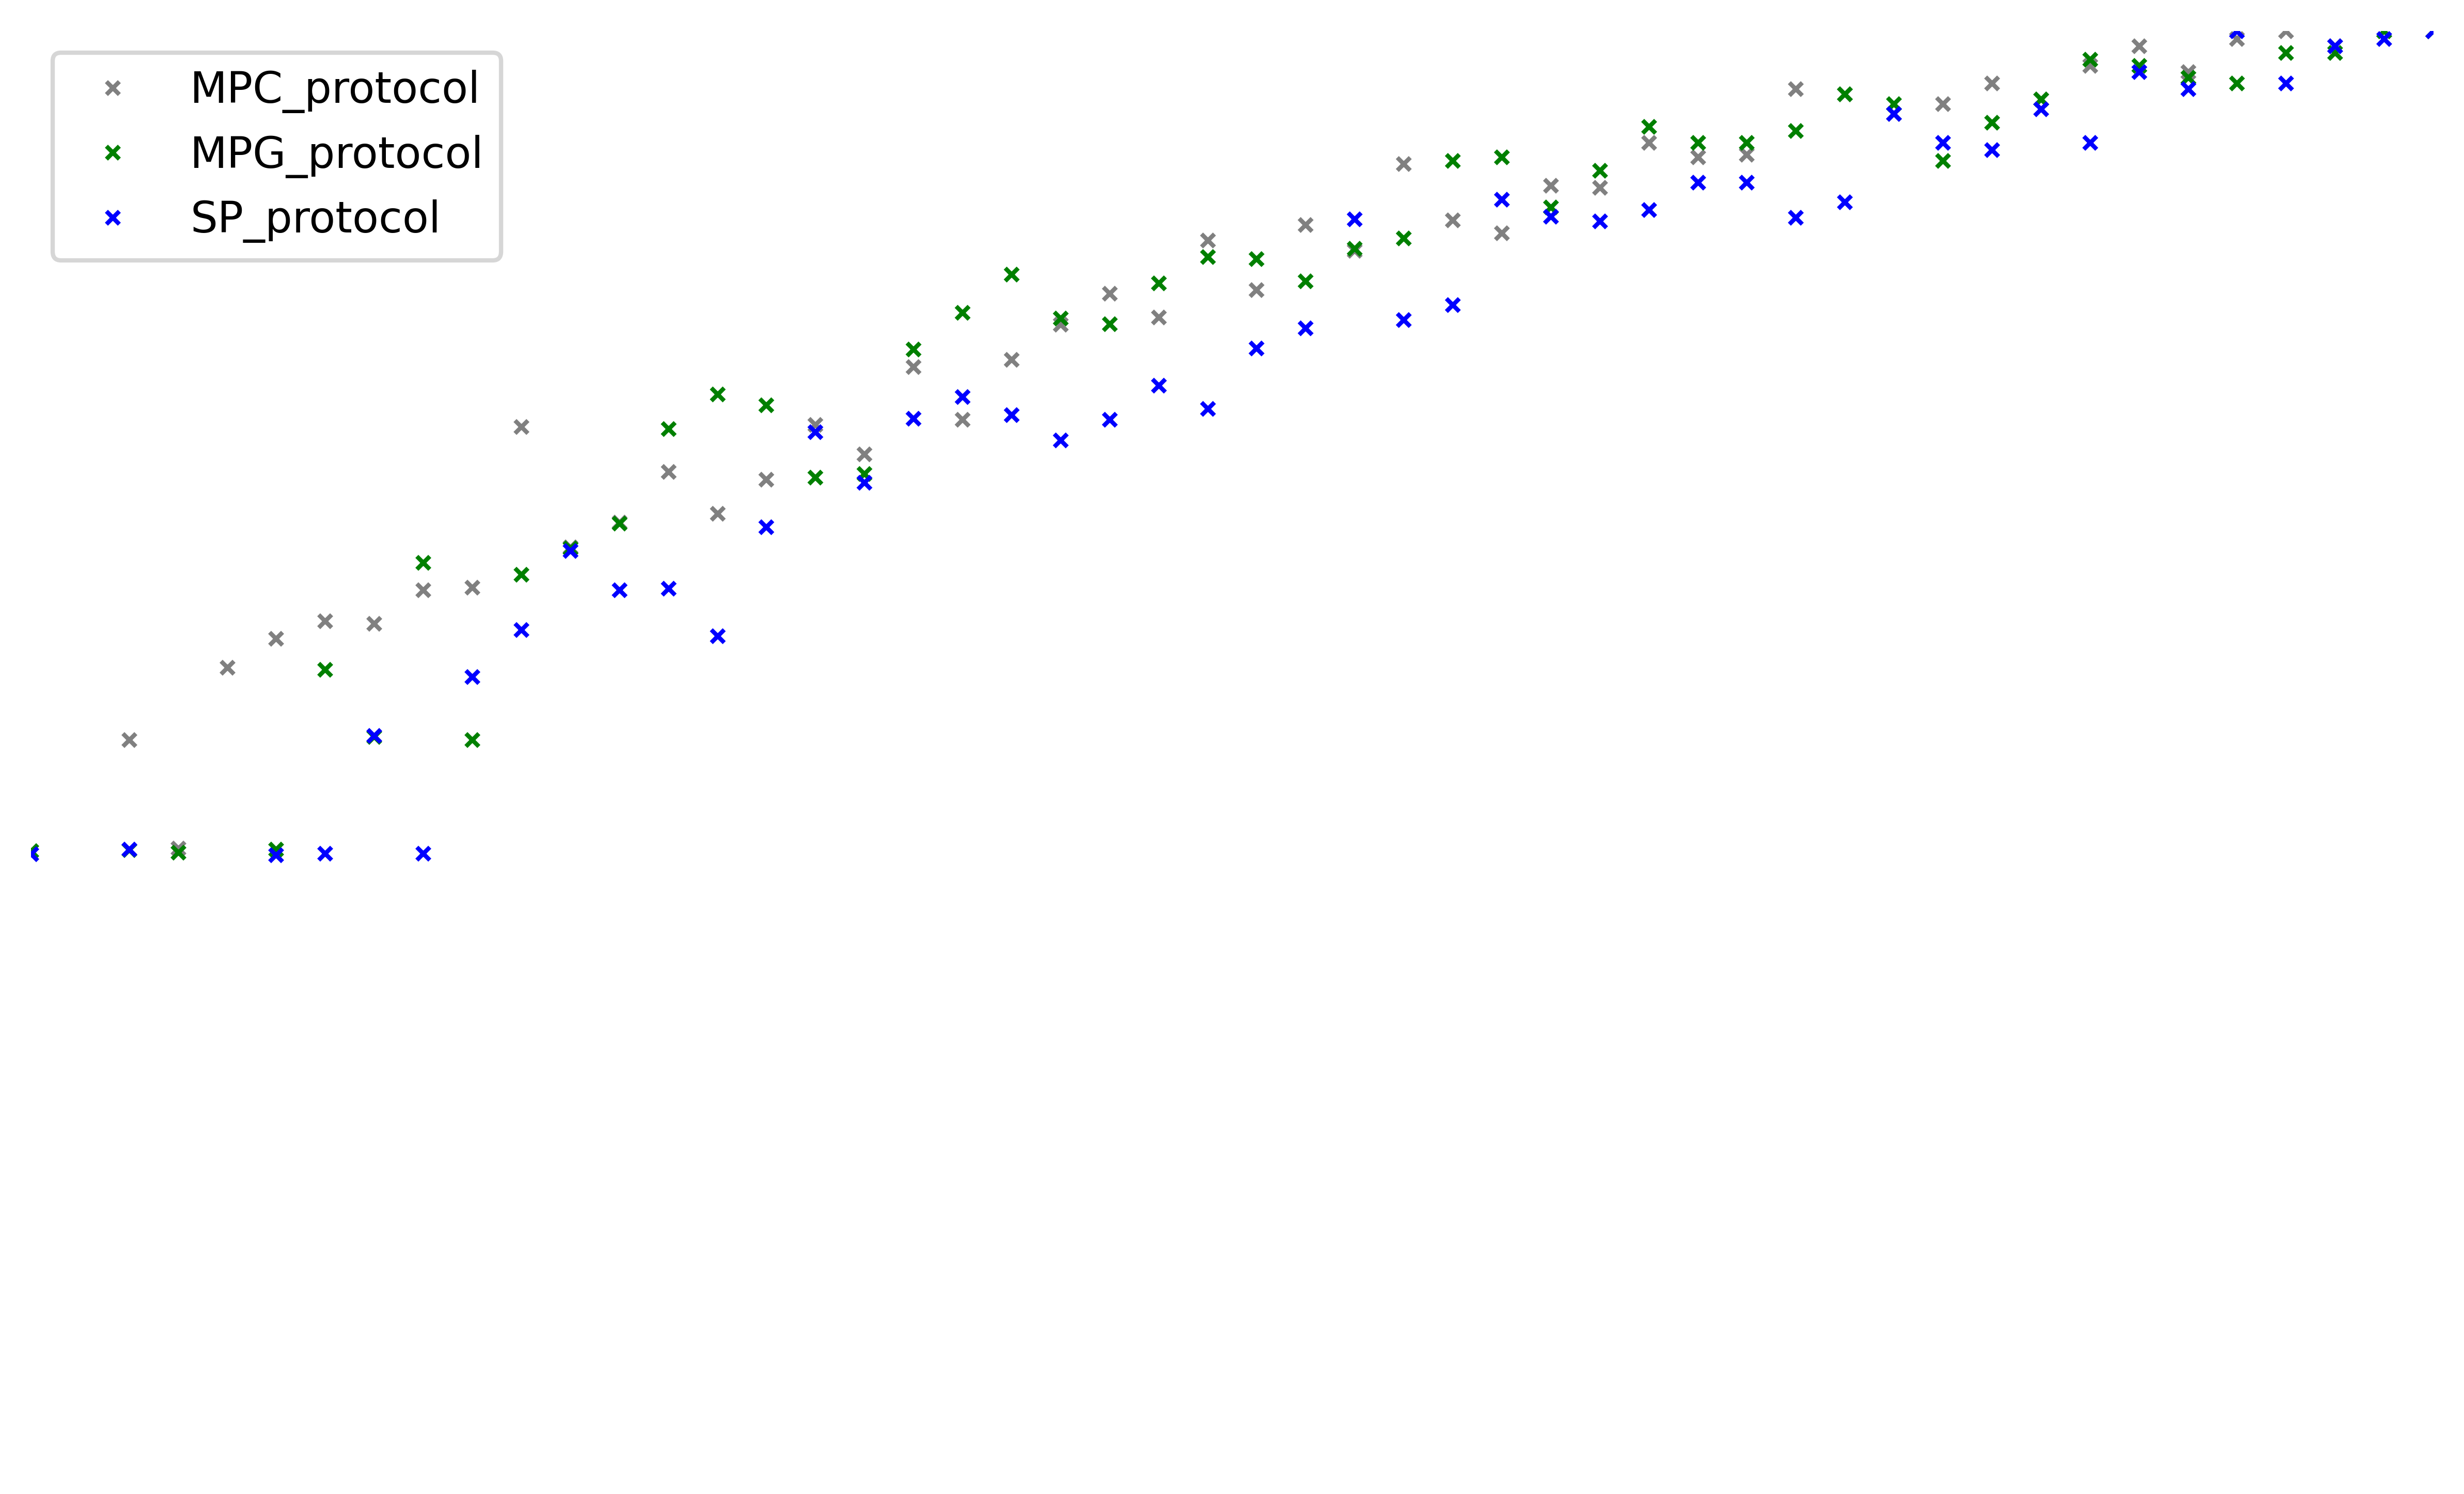

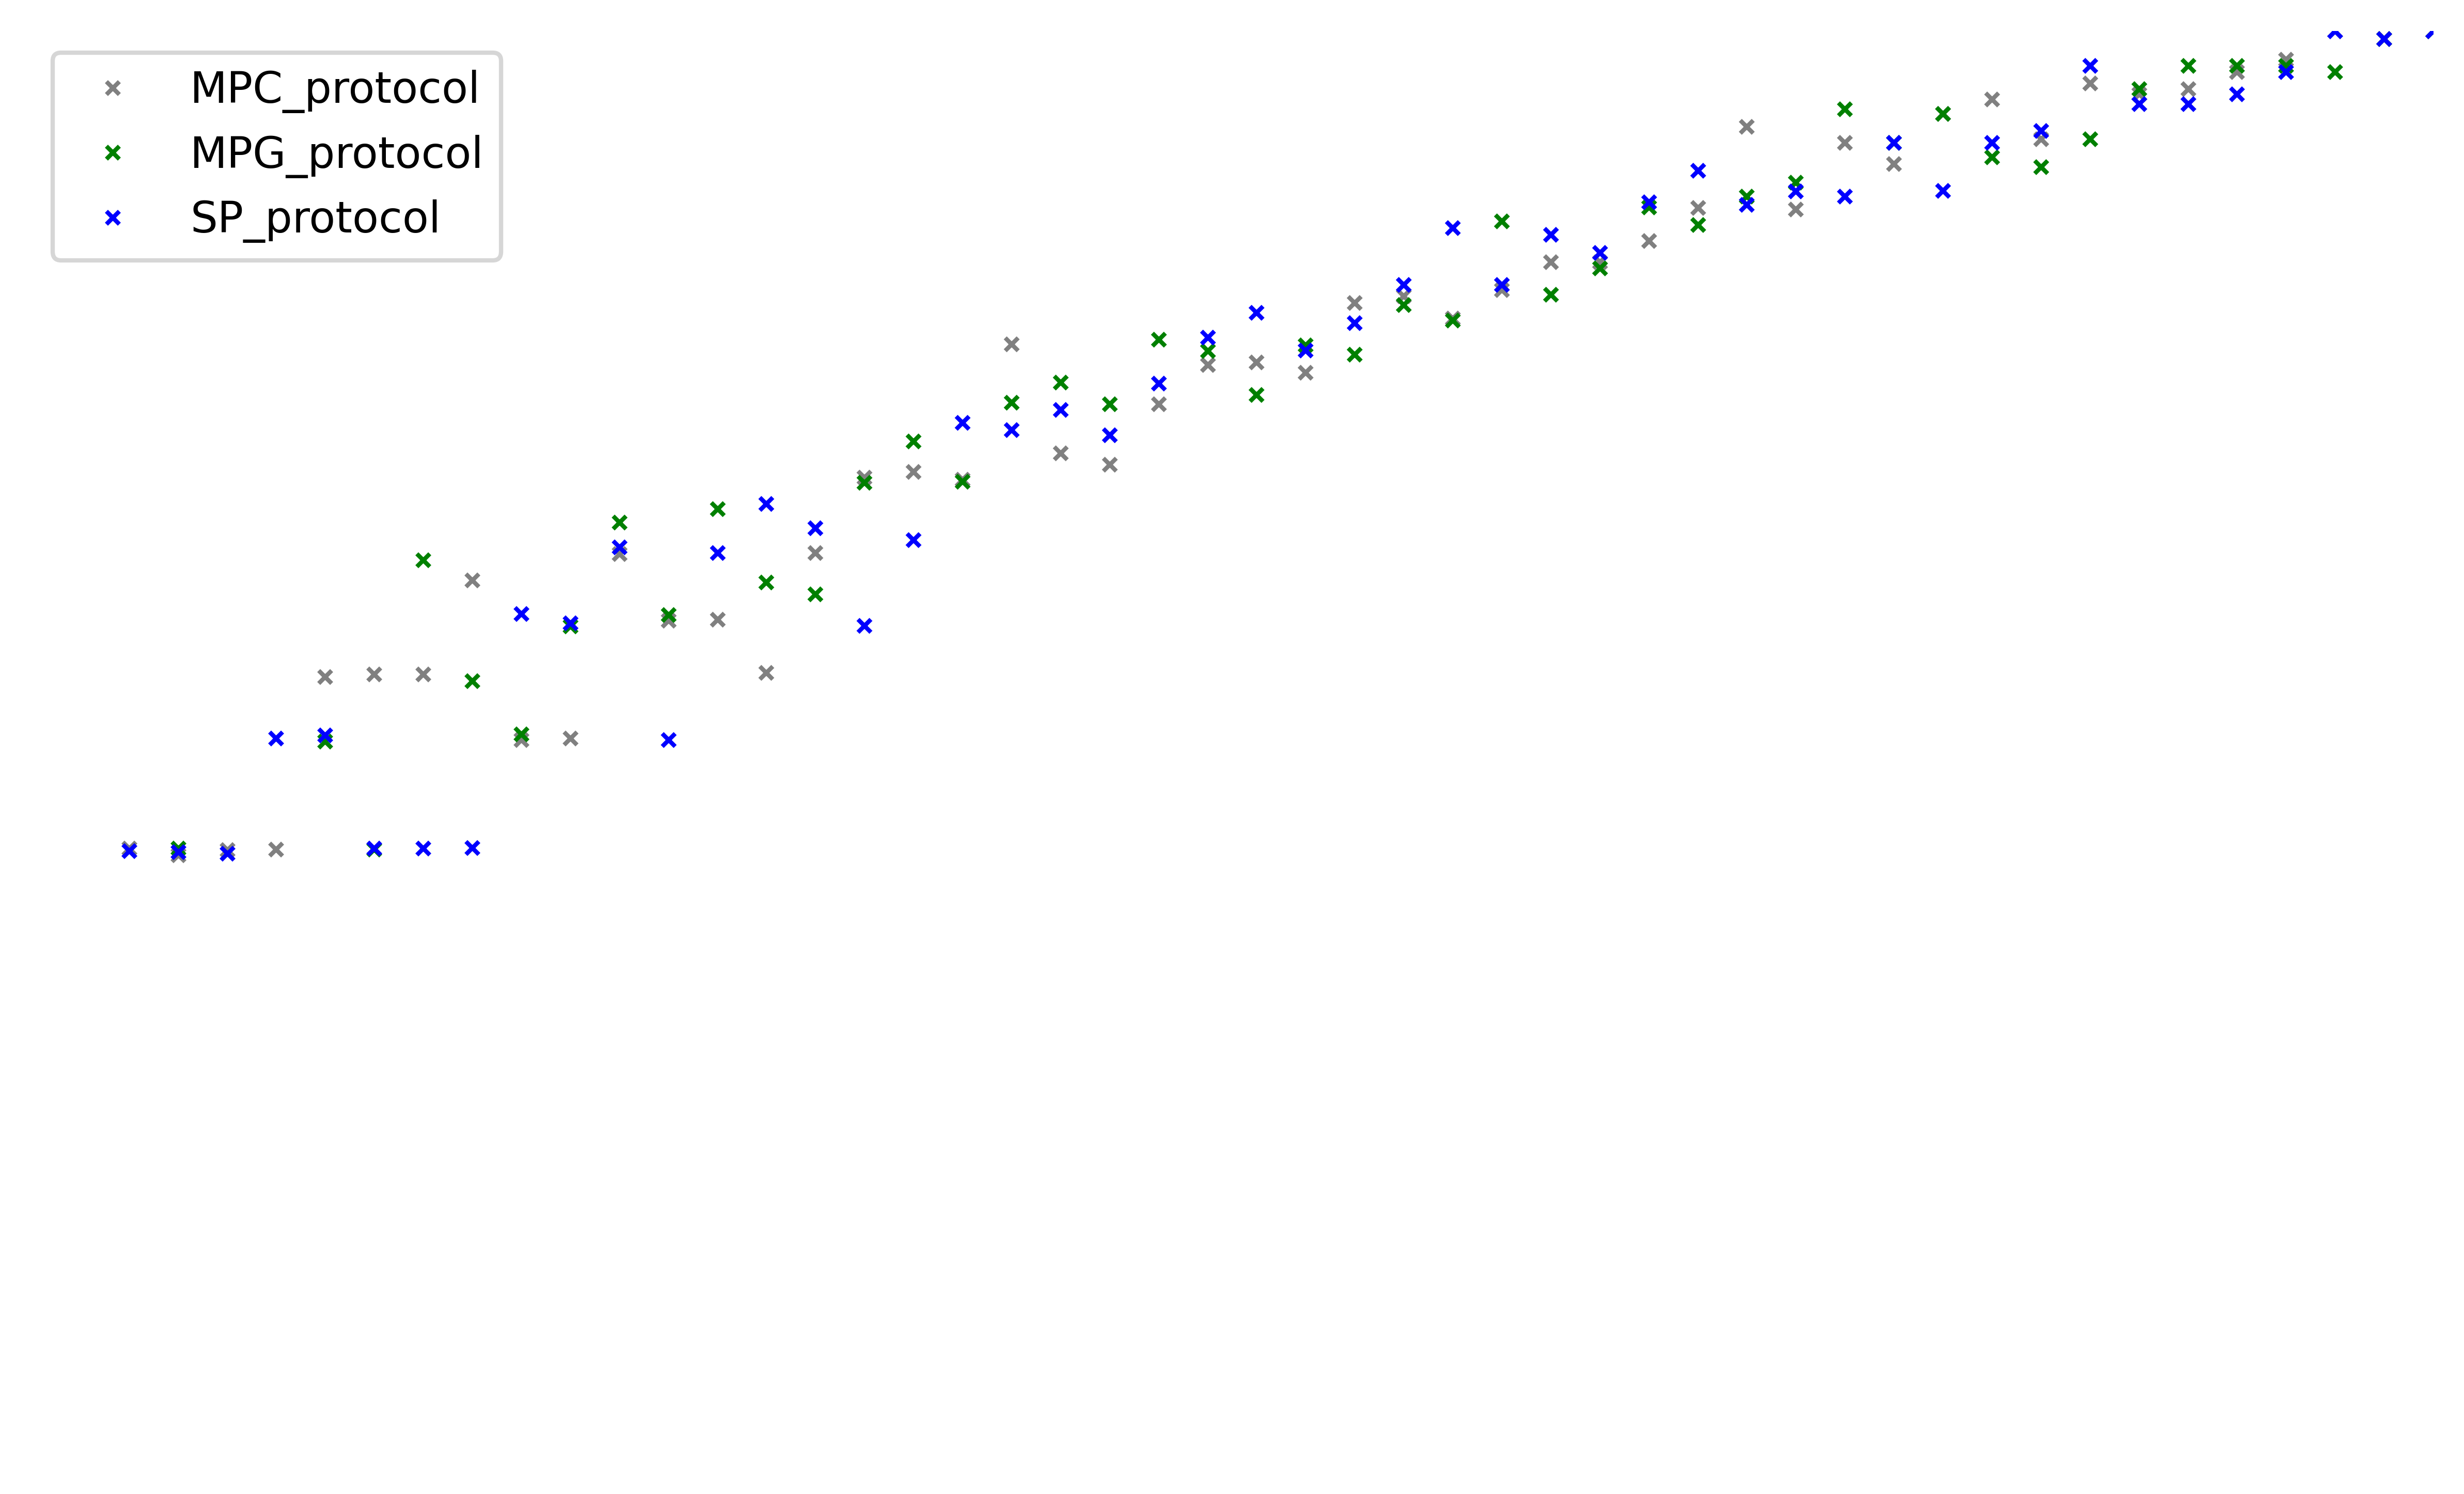

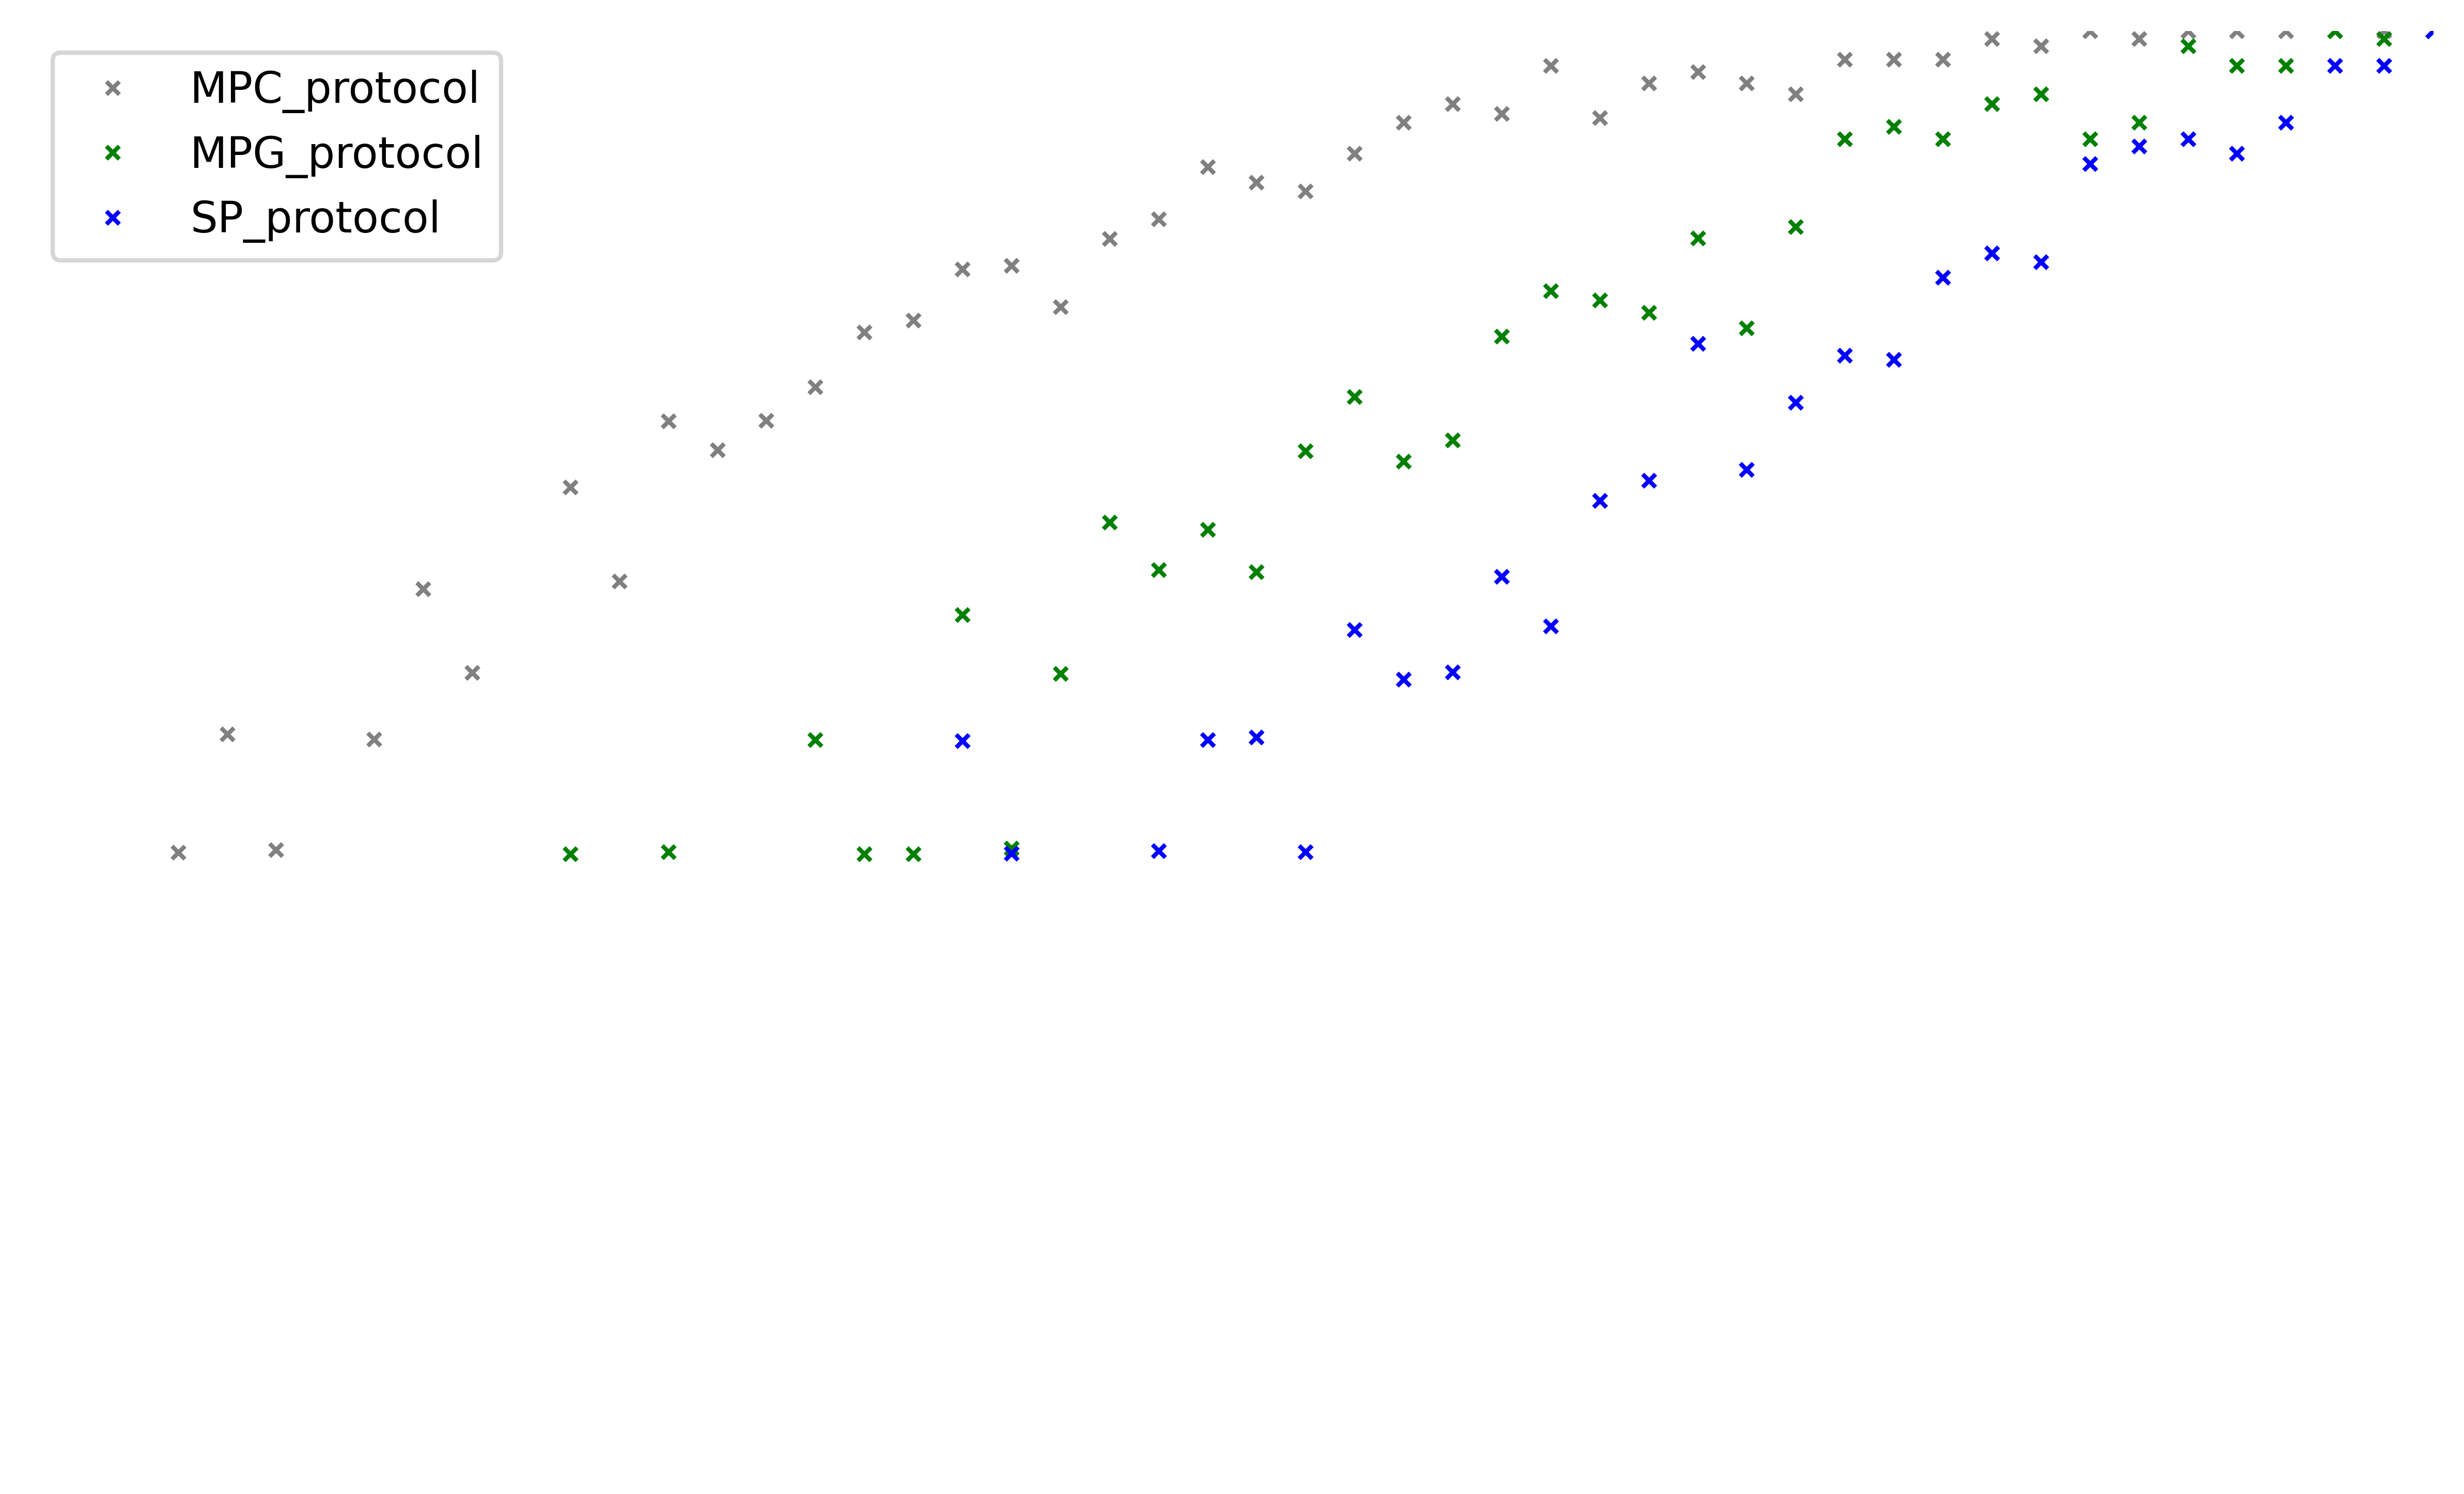

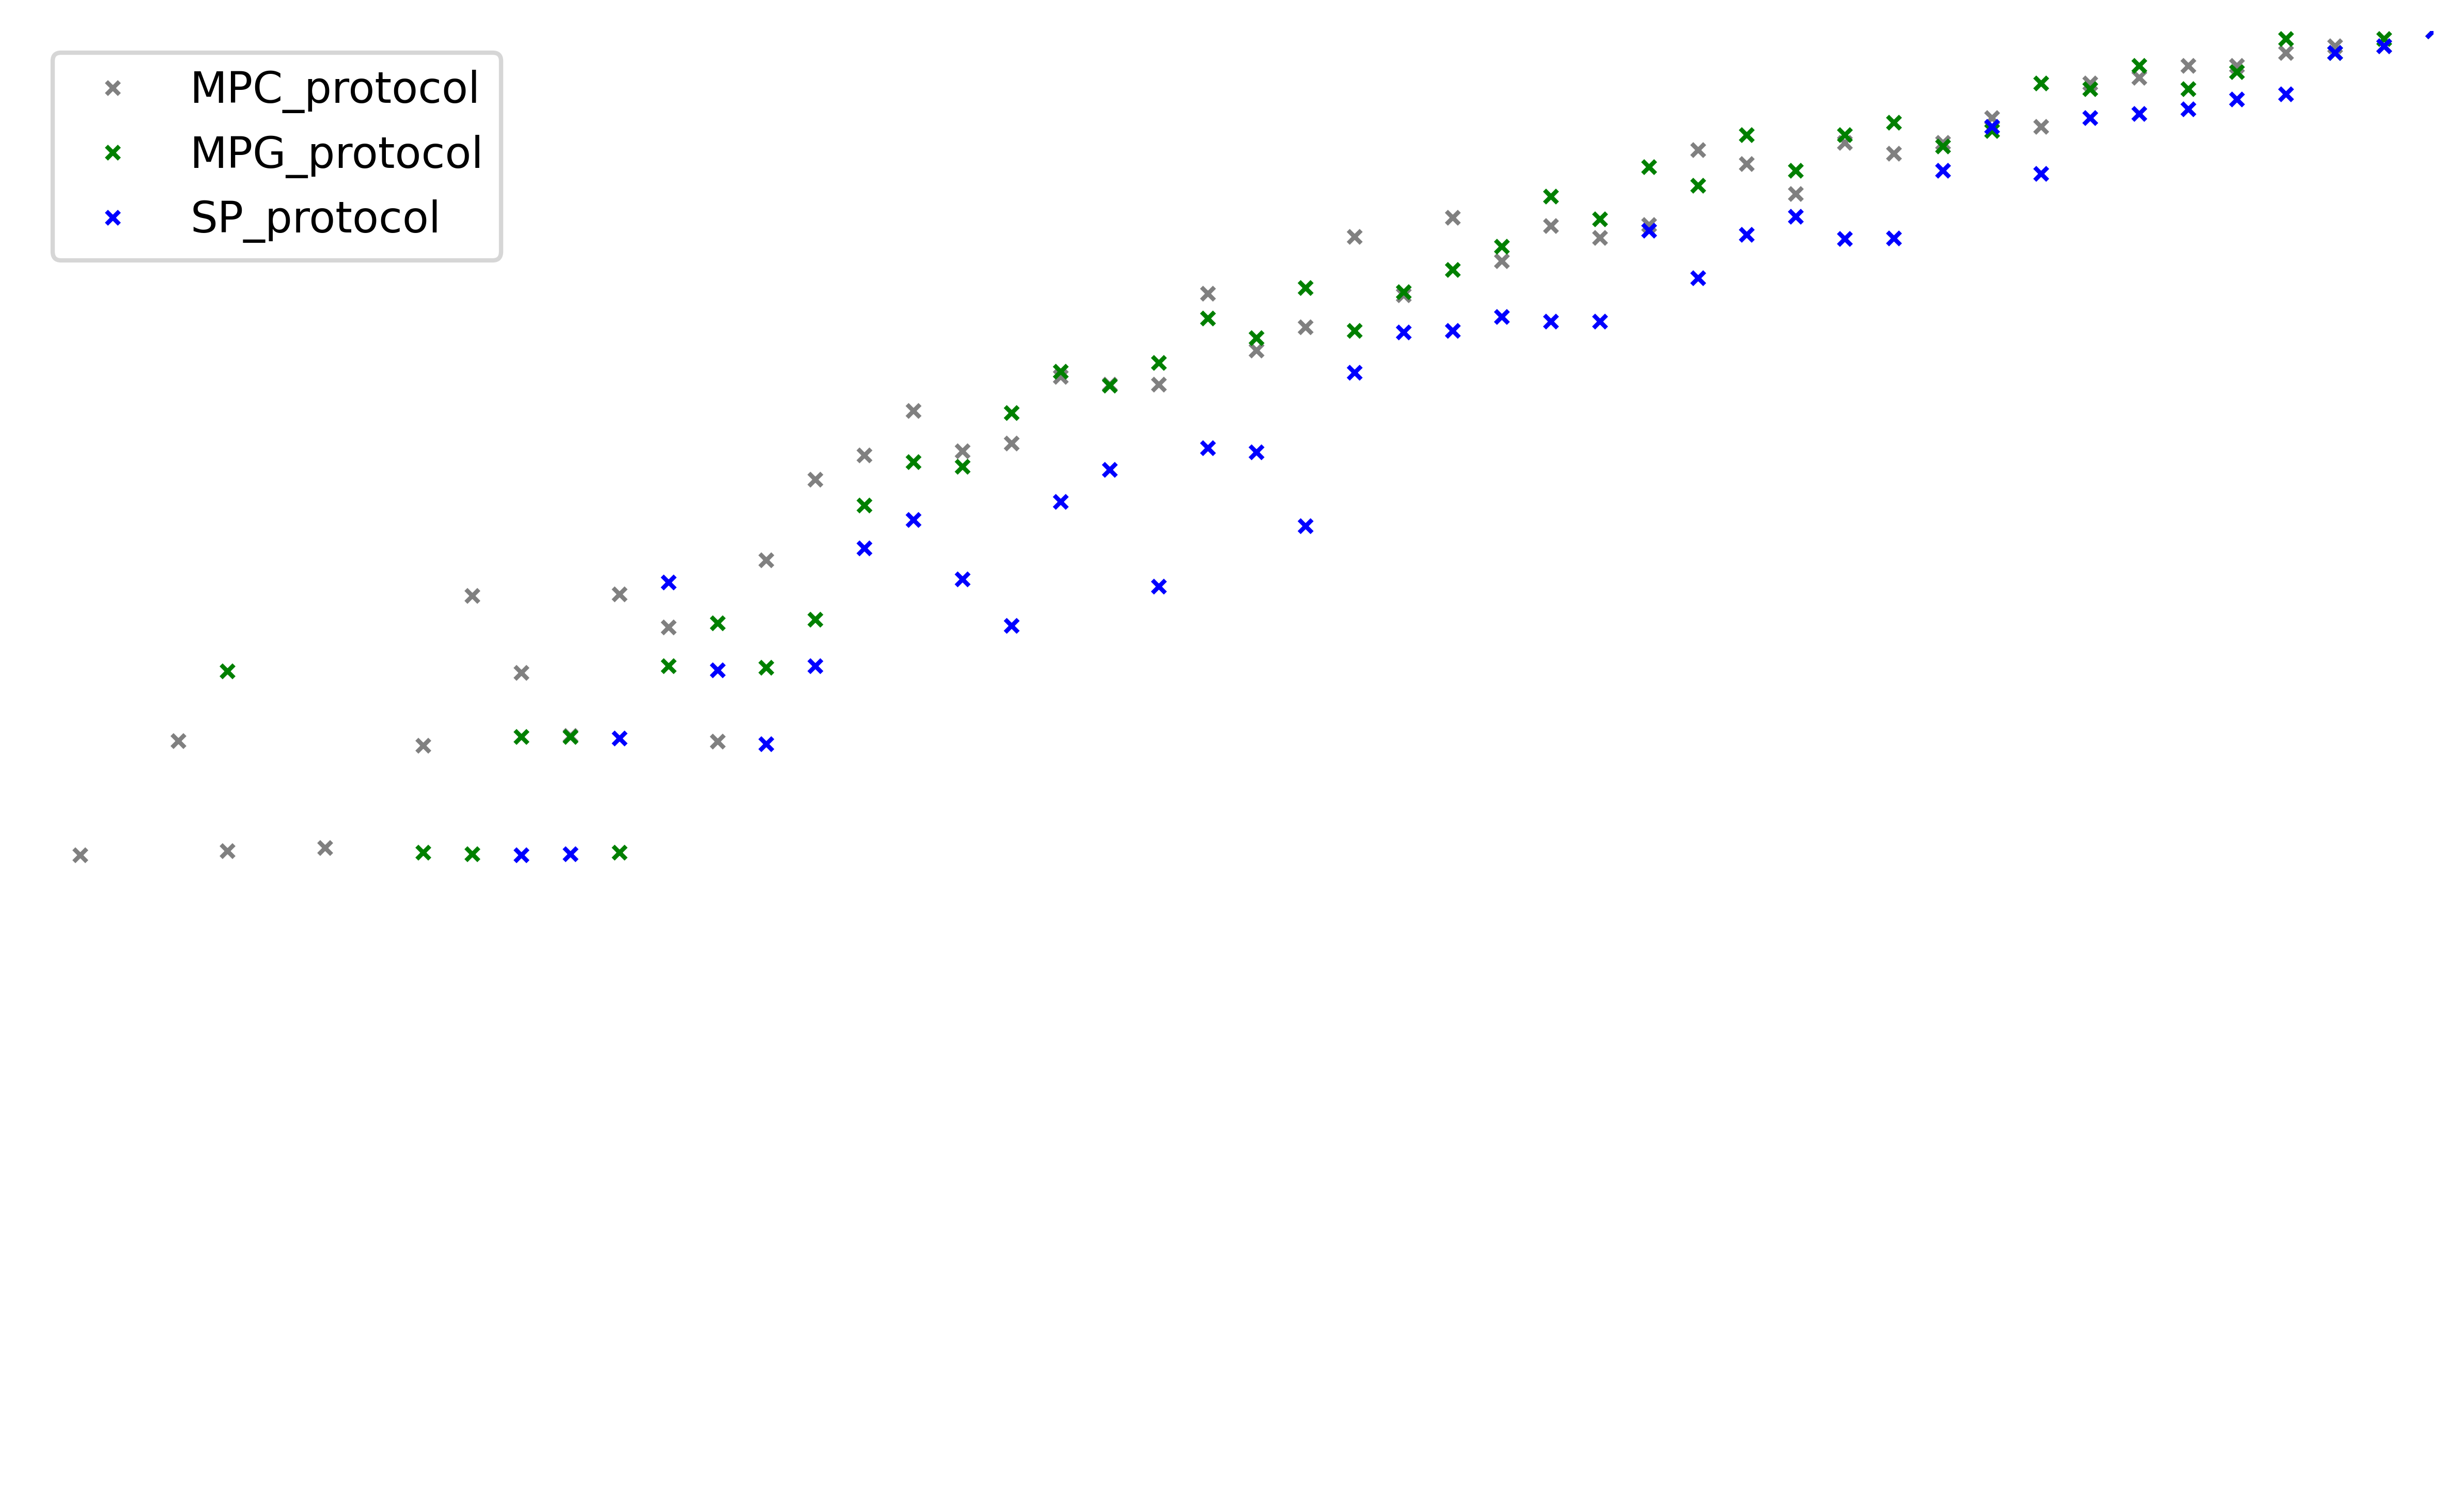

In [18]:
funcs= [MPC_protocol,MPG_protocol,SP_protocol]
p_range = np.linspace(1, 0.2, 50)

timesteps = 10
reps = 20
alpha = 1.4
beta = 0.105
max_rounds = 10
shuffle_nodes = True
root_path = Path.cwd().parent.joinpath("graphs_json")

# 遍历 graphs_json 文件夹中的每个子文件夹
for subfolder in root_path.iterdir():
    if subfolder.is_dir():  # 判断是否是子文件夹
        #print(f"Processing subfolder: {subfolder}")
        # 遍历当前子文件夹中的所有文件
        for file in subfolder.iterdir():
            if file.is_file():  # 判断是否是文件
                #print(f"  Processing file: {file}")
                class_folder = Path(subfolder).name
                file_path = file.with_suffix(".png")
                file_name = Path(file_path).name
                er_output_path = Path.cwd().parent.joinpath("result",class_folder,file_name)
                communities_output_path = Path.cwd().parent.joinpath("communitie",class_folder,file_name)
                ER = np.zeros((len(funcs),len(p_range)))
                G,users,pos = load_data(file)
                nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
                G = network(G)
                communities,users = multi_iterative_score_partition_with_drawing(G, users[0],alpha,beta,max_rounds,
                                                                           shuffle_nodes,pos,communities_output_path)
                for i,p in enumerate(tqdm.tqdm(p_range)):# tqdm_notebook
                    set_p_edge(G,p_op = p)
                    for j,function in enumerate(funcs):
                        er,multipartite_gen_time, links_used = function(G,users,timesteps=timesteps,reps=reps)
                        ER[j,i]+=er
                print(ER)
                plot_er_vs_p(p_range, ER, funcs, cols, er_output_path)

